<a href="https://colab.research.google.com/github/Yoel-G/Mechanomics/blob/main/Population_analysis_model_training_testing_and_batch_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author information:
Yoel Goldstein, Lab of Prof. Ofra Benny
Hebrew University, School of Pharmacy

This code uses FACS data to assess the classification performance in distinguishing between cancer cell populations with varying phenotypes by aggregating X number of cell values.

The code is generic and can be used for all cell lines. The current code uses H460 cell types as en example.

Once the models are trained they are saved as a pickle.

For excuting the code you can use any kind of data for any cell line:
* cells with particle
* cells without particles
* Batch samples

It does require to fit some parts of the preprocessing of the code to adjust it specifically to the type of the data, such as: number of samples and thresholds for cleaning.  

Code description:
*   Requires file directory pointing to a folder containing raw .csv files
*   Includes preprocessing of the raw data: cleaning, log transformation, and normalization.  
*  Multiple datasets are examined, including: physiological parameters alone (SSC and FSC), physiological parameters divided into bins, cell size alone (FSC), cell granularity alone (SSC), particle uptake parameters alone, particle uptake divided into bins, and a combined dataset containing all parameters (physiological and particle uptake).  
*   The code includes Random forest, XGBoost and SVM classifiers and study their performance in classifying between two cell subpopulations.  
*   Unseen data as a second blind test (Batch data)
*   PCA based dimeention reduction and its effect on the performances






In [ ]:
pip install eli5

In [ ]:
import pandas as pd
import numpy as np
from pylab import *
import eli5
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from eli5.sklearn import PermutationImportance

from pathlib import Path
from pandas import DataFrame
from collections import Counter
from functools import reduce
from xgboost import XGBClassifier
from google.colab import drive

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
sns.set_style('white')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

data_path = r'' # enter the correct path

Mounted at /content/drive


# functions for analysis

In [ ]:
# getting the index of the row in the dataset
def get_index(df):
    index = df.index
    t = index.array
    t_dict = Counter(t).most_common()
    t_dict = dict(t_dict)
    t_keys = t_dict.keys()
    return (t_keys)

In [ ]:
# splitting the dataset into groups and returning for each row its group number
# choos the number of cells per group
def split_df(index):
    #pop = (floor(index/100) + 1).astype(int)
    #pop = (floor(index/200) + 1).astype(int)
    pop = (floor(index/500) + 1).astype(int)
    #pop = (floor(index/50) + 1).astype(int)
    return pd.Series([(pop)])

In [ ]:
# split the uptake intensity range into 11 bins and return a list of these bins.
# For each row, this function defaults to a value of 0, except for the bin where the intensity falls,
# which is assigned a value of 1. It returns 11 columns of 0 and 1.

def bins (intensity):
    bins_list = [0,0,0,0,0,0,0,0,0,0,0]

    if intensity < 4:
        bins_list[0] = 1
    elif intensity >= 4 and intensity < 5:
        bins_list[1] = 1
    elif intensity >=5 and intensity < 6:
        bins_list[2] = 1
    elif intensity >=6 and intensity < 7:
        bins_list[3] = 1
    elif intensity >=7 and intensity < 8:
        bins_list[4] = 1
    elif intensity >=8 and intensity < 9:
        bins_list[5] = 1
    elif intensity >= 9 and intensity < 10:
        bins_list[6] = 1
    elif intensity >= 10 and intensity < 10.5:
        bins_list[7] = 1
    elif intensity >= 10.5 and intensity < 11:
        bins_list[8] = 1
    elif intensity >= 11 and intensity < 11.5:
        bins_list[9] = 1
    else:
        bins_list[10] = 1

    return pd.Series([bins_list[0],bins_list[1],bins_list[2],bins_list[3],bins_list[4],bins_list[5],bins_list[6],
                     bins_list[7], bins_list[8], bins_list[9], bins_list[10]])

In [ ]:
# split the pyshiological (size (FSC) and granularity (SSC)) range into 7 bins and return a list of these bins.
# For each row, this function defaults to a value of 0, except for the bin where the intensity falls,
# which is assigned a value of 1. It returns 7 columns of 0 and 1.

def bins_phys (intensity):
    bins_list = [0,0,0,0,0,0,0]

    if intensity < 10:
        bins_list[0] = 1
    elif intensity >= 10 and intensity < 10.5:
        bins_list[1] = 1
    elif intensity >= 10.5 and intensity < 11:
        bins_list[2] = 1
    elif intensity >= 11 and intensity < 11.5:
        bins_list[3] = 1
    elif intensity >= 11.5 and intensity < 12:
        bins_list[4] = 1
    elif intensity >= 12 and intensity < 12.5:
        bins_list[5] = 1
    else:
        bins_list[6] = 1

    return pd.Series([bins_list[0],bins_list[1],bins_list[2],bins_list[3],bins_list[4],bins_list[5],bins_list[6]])

In [ ]:
# multiplying the row uptake intensity with the bins coloumns (0 or 1)
def bins_intensity (intensity, A_1, A_2, A_3, A_4, A_5, A_6, A_7, A_8, A_9, A_10, A_11):
    return pd.Series([intensity*A_1, intensity*A_2, intensity*A_3, intensity*A_4,
                     intensity*A_5, intensity*A_6, intensity*A_7, intensity*A_8,
                     intensity*A_9, intensity*A_10, intensity*A_11])

In [ ]:
# multiplying the row physiological intensity with the bins coloumns (0 or 1)
def bins_intensity_phys (intensity, A_1, A_2, A_3, A_4, A_5, A_6, A_7):
    return pd.Series([intensity*A_1, intensity*A_2, intensity*A_3, intensity*A_4,
                     intensity*A_5, intensity*A_6, intensity*A_7])

In [ ]:
# normalizing the uptake intensities with the mean intansity of the group
def normalized_intensity (intensity_1, intensity_2, intensity_3, intensity_4, intensity_5, intensity_6, intensity_7,intensity_8,intensity_9,intensity_10,intensity_11,mean_A):
    return pd.Series([intensity_1/mean_A, intensity_2/mean_A, intensity_3/mean_A, intensity_4/mean_A,
                      intensity_5/mean_A, intensity_6/mean_A, intensity_7/mean_A, intensity_8/mean_A,
                      intensity_9/mean_A, intensity_10/mean_A, intensity_11/mean_A])

In [ ]:
# normalizing the physiological intensities with the mean intansity of the group
def normalized_intensity_phys (intensity_1, intensity_2, intensity_3, intensity_4, intensity_5, intensity_6, intensity_7, mean_A):
    return pd.Series([intensity_1/mean_A, intensity_2/mean_A, intensity_3/mean_A, intensity_4/mean_A,
                      intensity_5/mean_A, intensity_6/mean_A, intensity_7/mean_A])

In [ ]:
# finds and returns the group mean uptake intensities of each bin
def average (intensity_1, intensity_2, intensity_3, intensity_4, intensity_5, intensity_6, intensity_7,intensity_8,
             intensity_9, intensity_10, intensity_11, count_1, count_2, count_3, count_4, count_5, count_6, count_7,
             count_8, count_9, count_10, count_11):
    return pd.Series([intensity_1/count_1, intensity_2/count_2, intensity_3/count_3, intensity_4/count_4,
                      intensity_5/count_5, intensity_6/count_6, intensity_7/count_7, intensity_8/count_8,
                      intensity_9/count_9, intensity_10/count_10, intensity_11/count_11])

In [ ]:
# finds and returns the group mean physiological intensities of each bin
def average_phys (intensity_1, intensity_2, intensity_3, intensity_4, intensity_5, intensity_6, intensity_7,
             count_1, count_2, count_3, count_4, count_5, count_6, count_7):
    return pd.Series([intensity_1/count_1, intensity_2/count_2, intensity_3/count_3, intensity_4/count_4,
                      intensity_5/count_5, intensity_6/count_6, intensity_7/count_7])

In [ ]:
# finds and returns mising values
def fix_median (pop_number_origin, pop_number, intensity):
    pop_dict = {pop_number[i]: intensity[i] for i in range(len(pop_number))}
    pop_dict_origin ={}
    if pop_number_origin in pop_dict:
        pop_dict_origin[pop_number_origin] = pop_dict[pop_number_origin]
    else:
        pop_dict_origin[pop_number_origin] = 0

    return pd.Series(pop_dict_origin[pop_number_origin])

In [ ]:
# building a function for analysis visualization
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_true.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

In [ ]:
# displays the model accuracy performance of the training and validation data
def display_classification_results(classifier, X_train, y_train, x_val, y_val):
    print('Classifier: {0:s}\nParameters:'.format(classifier.__class__.__name__))
    for k,v in classifier.get_params().items():
        print('\t{0} : {1}'.format(k,v))
    training_set_score = classifier.score(X_train,y_train)
    print('Testing on TRAINING set: {}'.format(training_set_score))
    val_set_score = classifier.score(x_val,y_val)
    print('Validation on VALIDATION set: {}'.format(val_set_score))
    return (training_set_score,val_set_score)

# Preprocessing -  preparing the data for analysis

Here we demonstrate the analysis using the H460 cells.

In [ ]:
# read the H460 cells csv files from directory

df_1_H460 = pd.read_csv(data_path +'H460_1.csv')
df_2_H460 = pd.read_csv(data_path +'H460_2.csv')
df_3_H460 = pd.read_csv(data_path +'H460_3.csv')
df_4_H460 = pd.read_csv(data_path +'H460_4.csv')
df_5_H460 = pd.read_csv(data_path +'H460_5.csv')
df_6_H460 = pd.read_csv(data_path +'H460_6.csv')
df_7_H460 = pd.read_csv(data_path +'H460_7.csv')
df_8_H460 = pd.read_csv(data_path +'H460_8.csv')
df_9_H460 = pd.read_csv(data_path +'H460_9.csv')
df_10_H460 = pd.read_csv(data_path +'H460_10.csv')
df_11_H460 = pd.read_csv(data_path +'H460_11.csv')
df_12_H460 = pd.read_csv(data_path +'H460_12.csv')
df_13_H460 = pd.read_csv(data_path +'H460_13.csv')
df_14_H460 = pd.read_csv(data_path +'H460_14.csv')
df_15_H460 = pd.read_csv(data_path +'H460_15.csv')
df_16_H460 = pd.read_csv(data_path +'H460_16.csv')
df_17_H460 = pd.read_csv(data_path +'H460_17.csv')
df_18_H460 = pd.read_csv(data_path +'H460_18.csv')
df_19_H460 = pd.read_csv(data_path +'H460_19.csv')
df_20_H460 = pd.read_csv(data_path +'H460_20.csv')


If the data containes one sample only for each population use from now on only pop 1 train and pop 2 train and scilent pop 1 test and pop 2 test

In [ ]:
# asigning training and testing datasets in the case of multiple samples

# training pop 1 - buliding a list with the chosen files for training
df_list_pop_1 = [df_1_H460, df_2_H460, df_3_H460, df_4_H460, df_5_H460,
          df_6_H460, df_7_H460, df_8_H460, df_9_H460, df_10_H460,
          df_11_H460, df_12_H460, df_13_H460, df_14_H460, df_15_H460]

# adding the file number - group in each of the training files
group = 1
for df in df_list_pop_1:
    df['group'] = group
    group += 1

# testing pop 1 - buliding a list with the chosen files for testing
df_list_pop_1_test = [df_16_H460, df_17_H460, df_18_H460, df_19_H460, df_20_H460]

In the case where there is only one sample for the next preprocessing steps use only pop 1

In [ ]:
# read the H460 cis-res cells csv files fro directory

df_1_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_1.csv')
df_2_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_2.csv')
df_3_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_3.csv')
df_4_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_4.csv')
df_5_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_5.csv')
df_6_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_6.csv')
df_7_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_7.csv')
df_8_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_8.csv')
df_9_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_9.csv')
df_10_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_10.csv')
df_11_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_11.csv')
df_12_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_12.csv')
df_13_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_13.csv')
df_14_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_14.csv')
df_15_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_15.csv')
df_16_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_16.csv')
df_17_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_17.csv')
df_18_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_18.csv')
df_19_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_19.csv')
df_20_H460_cis_res = pd.read_csv(data_path +'H460_cis_res_20.csv')

In [ ]:
# asigning training and testing datasets in the case of multiple samples

# training pop 2 - buliding a list with the chosen files for training
df_list_pop_2 = [df_1_H460_cis_res, df_2_H460_cis_res, df_3_H460_cis_res, df_4_H460_cis_res, df_5_H460_cis_res,
          df_6_H460_cis_res, df_7_H460_cis_res, df_8_H460_cis_res, df_9_H460_cis_res, df_10_H460_cis_res,
          df_11_H460_cis_res, df_12_H460_cis_res, df_13_H460_cis_res, df_14_H460_cis_res, df_15_H460_cis_res]

# adding the file number - group in each of the training files
for df in df_list_pop_2:
    df['group'] = group
    group += 1

# testing pop 2 - buliding a list with the chosen files for testing
df_list_pop_2_test = [df_16_H460_cis_res, df_17_H460_cis_res, df_18_H460_cis_res, df_19_H460_cis_res, df_20_H460_cis_res]

In [ ]:
# merging the datasets into one dataset of training and one dataset of testing for both cell lines
# not needed if there is only one sample of each population

# merged df train pop 1
Total_pop_1 = pd.DataFrame()
for df in df_list_pop_1:
    Total_pop_1 =  pd.concat([Total_pop_1, df], ignore_index=True)

# merged df test pop 1
Total_pop_1_test = pd.DataFrame()
for df in df_list_pop_1_test:
    Total_pop_1_test =  pd.concat([Total_pop_1_test, df], ignore_index=True)


# merged df train pop 2
Total_pop_2 = pd.DataFrame()
for df in df_list_pop_2:
    Total_pop_2 =  pd.concat([Total_pop_2, df], ignore_index=True)

# merged df test pop 2
Total_pop_2_test = pd.DataFrame()
for df in df_list_pop_2_test:
    Total_pop_2_test =  pd.concat([Total_pop_2_test, df], ignore_index=True)


In [ ]:
# renaming train pop 1
Total_pop_1.drop(['Unnamed: 0','Time'], axis = 1, inplace = True)
Total_pop_1.rename(columns={"FSC-A": "FSC_A", "FSC-H": "FSC_H", "FSC-W": "FSC_W", "SSC-A": "SSC_A",
                                  "SSC-H": "SSC_H", "SSC-W": "SSC_W", "BV421-A": "BV421_A", "FITC-A": "FITC_A",
                                  "PerCP-A": "PerCP_A", "PE-Texas Red-A": "PE_Texas_Red_A", "BV421-A": "BV421_A",
                                   "Alexa Fluor 700-A": "Alexa_Fluor_700_A"}, inplace = True)

# renaming test pop 1
Total_pop_1_test.drop(['Unnamed: 0','Time'], axis = 1, inplace = True)
Total_pop_1_test.rename(columns={"FSC-A": "FSC_A", "FSC-H": "FSC_H", "FSC-W": "FSC_W", "SSC-A": "SSC_A",
                                  "SSC-H": "SSC_H", "SSC-W": "SSC_W", "BV421-A": "BV421_A", "FITC-A": "FITC_A",
                                  "PerCP-A": "PerCP_A", "PE-Texas Red-A": "PE_Texas_Red_A", "BV421-A": "BV421_A",
                                   "Alexa Fluor 700-A": "Alexa_Fluor_700_A"}, inplace = True)

# renaming train pop 2
Total_pop_2.drop(['Unnamed: 0','Time'], axis = 1, inplace = True)
Total_pop_2.rename(columns={"FSC-A": "FSC_A", "FSC-H": "FSC_H", "FSC-W": "FSC_W", "SSC-A": "SSC_A",
                                  "SSC-H": "SSC_H", "SSC-W": "SSC_W", "BV421-A": "BV421_A", "FITC-A": "FITC_A",
                                  "PerCP-A": "PerCP_A", "PE-Texas Red-A": "PE_Texas_Red_A", "BV421-A": "BV421_A",
                                   "Alexa Fluor 700-A": "Alexa_Fluor_700_A"}, inplace = True)

# renaming test pop 2
Total_pop_2_test.drop(['Unnamed: 0','Time'], axis = 1, inplace = True)
Total_pop_2_test.rename(columns={"FSC-A": "FSC_A", "FSC-H": "FSC_H", "FSC-W": "FSC_W", "SSC-A": "SSC_A",
                                  "SSC-H": "SSC_H", "SSC-W": "SSC_W", "BV421-A": "BV421_A", "FITC-A": "FITC_A",
                                  "PerCP-A": "PerCP_A", "PE-Texas Red-A": "PE_Texas_Red_A", "BV421-A": "BV421_A",
                                   "Alexa Fluor 700-A": "Alexa_Fluor_700_A"}, inplace = True)

In [ ]:
# since we merged the files we need to set a new index
# not needed if there is only one sample of each population

# setting a list of indexes for pop 1
index_list_pop_1 = get_index(Total_pop_1['FSC_A'])
index_list_pop_1_test = get_index(Total_pop_1_test['FSC_A'])

# setting a list of indexes index for pop 2
index_list_pop_2 = get_index(Total_pop_2['FSC_A'])
index_list_pop_2_test = get_index(Total_pop_2_test['FSC_A'])

# assigning index pop 1
Total_pop_1['row_index'] = index_list_pop_1
Total_pop_1_test['row_index'] = index_list_pop_1_test

# assigning index pop 2
Total_pop_2['row_index'] = index_list_pop_2
Total_pop_2_test['row_index'] = index_list_pop_2_test

In [ ]:
# assigning the data sets to groups of cells (500/200/100/50)

#spliting to sub-populations pop 1
Total_pop_1[['population_number']] = Total_pop_1.apply(lambda x: split_df(x.row_index), axis=1)
Total_pop_1_test[['population_number']] = Total_pop_1_test.apply(lambda x: split_df(x.row_index), axis=1)

#spliting to sub-populations pop 2
Total_pop_2[['population_number']] = Total_pop_2.apply(lambda x: split_df(x.row_index), axis=1)
Total_pop_2_test[['population_number']] = Total_pop_2_test.apply(lambda x: split_df(x.row_index), axis=1)

In [ ]:
# Cleaning the data of the first population based on a preliminary analysis (the numbers here are good for the H460 cells)

# filtering out doublets and debris pop 1
Total_pop_1 = Total_pop_1[Total_pop_1['SSC_W']< 125000]
Total_pop_1 = Total_pop_1[Total_pop_1['SSC_W']> 70000]
Total_pop_1 = Total_pop_1[Total_pop_1['SSC_A']> 10000]

Total_pop_1_test = Total_pop_1_test[Total_pop_1_test['SSC_W']< 125000]
Total_pop_1_test = Total_pop_1_test[Total_pop_1_test['SSC_W']> 70000]
Total_pop_1_test = Total_pop_1_test[Total_pop_1_test['SSC_A']> 10000]

# Cleaning the data of the second population based on a preliminary analysis (the numbers in this example are good for H460 cis-res cells)
Total_pop_2 = Total_pop_2[Total_pop_2['SSC_W']> 70000]
Total_pop_2 = Total_pop_2[Total_pop_2['SSC_A']> 25000]

Total_pop_2_test = Total_pop_2_test[Total_pop_2_test['SSC_W']> 70000]
Total_pop_2_test = Total_pop_2_test[Total_pop_2_test['SSC_A']> 25000]

In [ ]:
# log transformation of the data

# train pop 1
Total_pop_1_log = Total_pop_1.transform(log, channels=['FSC_A','FSC_H', 'FSC_W', 'SSC_A', 'SSC_H', 'SSC_W', 'BV421_A', 'FITC_A','PerCP_A', 'PE_Texas_Red_A', 'Alexa_Fluor_700_A'], b=500.0, inplace = True)
Total_pop_1_log.replace([np.inf, -np.inf], np.nan, inplace = True)
Total_pop_1_log = Total_pop_1_log.fillna(0)
Total_pop_1_log['Cell_line'] = 0
Total_pop_1_log.reset_index(inplace = True)
group_list_1 = Total_pop_1.group.tolist()
Total_pop_1_log['group'] = group_list_1
prefeatured_pop_1 = Total_pop_1_log

# test pop 1
Total_pop_1_test_log = Total_pop_1_test.transform(log, channels=['FSC_A','FSC_H', 'FSC_W', 'SSC_A', 'SSC_H', 'SSC_W', 'BV421_A', 'FITC_A','PerCP_A', 'PE_Texas_Red_A', 'Alexa_Fluor_700_A'], b=500.0, inplace = True)
Total_pop_1_test_log.replace([np.inf, -np.inf], np.nan, inplace = True)
Total_pop_1_test_log = Total_pop_1_test_log.fillna(0)
Total_pop_1_test_log['Cell_line'] = 0
Total_pop_1_test_log.reset_index(inplace = True)
prefeatured_pop_1_test = Total_pop_1_test_log

# train pop 2
Total_pop_2_log = Total_pop_2.transform(log, channels=['FSC_A','FSC_H', 'FSC_W', 'SSC_A', 'SSC_H', 'SSC_W', 'BV421_A', 'FITC_A','PerCP_A', 'PE_Texas_Red_A', 'Alexa_Fluor_700_A'], b=500.0)
Total_pop_2_log.replace([np.inf, -np.inf], np.nan, inplace = True)
Total_pop_2_log = Total_pop_2_log.fillna(0)
Total_pop_2_log['Cell_line'] = 1
Total_pop_2_log.reset_index(inplace = True)
group_list_2 = Total_pop_2.group.tolist()
Total_pop_2_log['group'] = group_list_2
prefeatured_pop_2 = Total_pop_2_log

# test pop 2
Total_pop_2_test_log = Total_pop_2_test.transform(log, channels=['FSC_A','FSC_H', 'FSC_W', 'SSC_A', 'SSC_H', 'SSC_W', 'BV421_A', 'FITC_A','PerCP_A', 'PE_Texas_Red_A', 'Alexa_Fluor_700_A'], b=500.0)
Total_pop_2_test_log.replace([np.inf, -np.inf], np.nan, inplace = True)
Total_pop_2_test_log = Total_pop_2_test_log.fillna(0)
Total_pop_2_test_log['Cell_line'] = 1
Total_pop_2_test_log.reset_index(inplace = True)
prefeatured_pop_2_test = Total_pop_2_test_log

In [ ]:
# saving the preprocessed datasets - named the data as needed
prefeatured_pop_1.to_csv(data_path + 'Total_train_H460_filtered_log.csv')
prefeatured_pop_2.to_csv(data_path + 'Total_train_H460_cis_res_filtered_log.csv')

# This part includes the different approachs for clasify the data:
*   Only uptake data
*   Only physiological data
*   Only FSC data
*   Only SSC data
*   All the data
*   Only uptake with bins
*   Only physiological with bins

Each one start with preparation of the features








## Uptake Features

Pop 1 - bins mean and median

Pop 1 train data

In [ ]:
# apply bins function on the different particle features
Total_pop_1_log[['BV421_A_1', 'BV421_A_2', 'BV421_A_3', 'BV421_A_4', 'BV421_A_5', 'BV421_A_6', 'BV421_A_7', 'BV421_A_8', 'BV421_A_9', 'BV421_A_10', 'BV421_A_11']] = Total_pop_1_log['BV421_A'].apply(bins)
Total_pop_1_log[['FITC_A_1', 'FITC_A_2', 'FITC_A_3', 'FITC_A_4', 'FITC_A_5', 'FITC_A_6', 'FITC_A_7', 'FITC_A_8', 'FITC_A_9', 'FITC_A_10', 'FITC_A_11']] = Total_pop_1_log['FITC_A'].apply(bins)
Total_pop_1_log[['PE_Texas_Red_A_1', 'PE_Texas_Red_A_2', 'PE_Texas_Red_A_3', 'PE_Texas_Red_A_4', 'PE_Texas_Red_A_5', 'PE_Texas_Red_A_6', 'PE_Texas_Red_A_7', 'PE_Texas_Red_A_8', 'PE_Texas_Red_A_9', 'PE_Texas_Red_A_10', 'PE_Texas_Red_A_11']] = Total_pop_1_log['PE_Texas_Red_A'].apply(bins)
Total_pop_1_log[['Alexa_Fluor_700_A_1', 'Alexa_Fluor_700_A_2', 'Alexa_Fluor_700_A_3', 'Alexa_Fluor_700_A_4', 'Alexa_Fluor_700_A_5', 'Alexa_Fluor_700_A_6', 'Alexa_Fluor_700_A_7', 'Alexa_Fluor_700_A_8', 'Alexa_Fluor_700_A_9', 'Alexa_Fluor_700_A_10', 'Alexa_Fluor_700_A_11']] = Total_pop_1_log['Alexa_Fluor_700_A'].apply(bins)
Total_pop_1_log[['PerCP_A_1', 'PerCP_A_2', 'PerCP_A_3', 'PerCP_A_4', 'PerCP_A_5', 'PerCP_A_6', 'PerCP_A_7', 'PerCP_A_8', 'PerCP_A_9', 'PerCP_A_10', 'PerCP_A_11']] = Total_pop_1_log['PerCP_A'].apply(bins)
Total_pop_1_log.head()

,index,FSC_A,FSC_H,FSC_W,SSC_A,SSC_H,SSC_W,BV421_A,FITC_A,PerCP_A,...,PerCP_A_2,PerCP_A_3,PerCP_A_4,PerCP_A_5,PerCP_A_6,PerCP_A_7,PerCP_A_8,PerCP_A_9,PerCP_A_10,PerCP_A_11
0,0,10.205215,9.829357,11.466214,9.930050,9.706682,11.313723,4.014218,5.489723,5.131613,...,0,1,0,0,0,0,0,0,0,0
1,1,10.021740,9.570459,11.541635,9.921455,9.717339,11.294471,3.335058,5.459160,4.738039,...,1,0,0,0,0,0,0,0,0,0
2,3,10.070320,9.710994,11.449680,10.135656,9.879297,11.346713,5.478386,7.783574,5.548181,...,0,1,0,0,0,0,0,0,0,0
3,4,10.440642,9.982114,11.548883,10.336251,10.002428,11.424178,4.571820,5.718868,5.231697,...,0,1,0,0,0,0,0,0,0,0
4,5,9.133289,8.772455,11.451188,9.211500,8.584852,11.717003,4.158258,5.141137,4.987776,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# applying bins intensity function on the particle features
Total_pop_1_log[['0.5_1_intensity', '0.5_2_intensity', '0.5_3_intensity', '0.5_4_intensity', '0.5_5_intensity', '0.5_6_intensity', '0.5_7_intensity', '0.5_8_intensity', '0.5_9_intensity', '0.5_10_intensity', '0.5_11_intensity']] = Total_pop_1_log.apply(lambda x: bins_intensity(x.BV421_A, x.BV421_A_1, x.BV421_A_2, x.BV421_A_3, x.BV421_A_4, x.BV421_A_5, x.BV421_A_6, x.BV421_A_7, x.BV421_A_8, x.BV421_A_9, x.BV421_A_10, x.BV421_A_11), axis=1)
Total_pop_1_log[['0.8_1_intensity', '0.8_2_intensity', '0.8_3_intensity', '0.8_4_intensity', '0.8_5_intensity', '0.8_6_intensity', '0.8_7_intensity', '0.8_8_intensity', '0.8_9_intensity', '0.8_10_intensity', '0.8_11_intensity']] = Total_pop_1_log.apply(lambda x: bins_intensity(x.FITC_A, x.FITC_A_1, x.FITC_A_2, x.FITC_A_3, x.FITC_A_4, x.FITC_A_5, x.FITC_A_6, x.FITC_A_7, x.FITC_A_8, x.FITC_A_9, x.FITC_A_10, x.FITC_A_11), axis=1)
Total_pop_1_log[['2.4_1_intensity', '2.4_2_intensity', '2.4_3_intensity', '2.4_4_intensity', '2.4_5_intensity', '2.4_6_intensity', '2.4_7_intensity', '2.4_8_intensity', '2.4_9_intensity', '2.4_10_intensity', '2.4_11_intensity']] = Total_pop_1_log.apply(lambda x: bins_intensity(x.PE_Texas_Red_A, x.PE_Texas_Red_A_1, x.PE_Texas_Red_A_2, x.PE_Texas_Red_A_3, x.PE_Texas_Red_A_4, x.PE_Texas_Red_A_5, x.PE_Texas_Red_A_6, x.PE_Texas_Red_A_7, x.PE_Texas_Red_A_8, x.PE_Texas_Red_A_9, x.PE_Texas_Red_A_10, x.PE_Texas_Red_A_11), axis=1)
Total_pop_1_log[['3.36_1_intensity', '3.36_2_intensity', '3.36_3_intensity', '3.36_4_intensity', '3.36_5_intensity', '3.36_6_intensity', '3.36_7_intensity', '3.36_8_intensity', '3.36_9_intensity', '3.36_10_intensity', '3.36_11_intensity']] = Total_pop_1_log.apply(lambda x: bins_intensity(x.Alexa_Fluor_700_A, x.Alexa_Fluor_700_A_1, x.Alexa_Fluor_700_A_2, x.Alexa_Fluor_700_A_3, x.Alexa_Fluor_700_A_4, x.Alexa_Fluor_700_A_5, x.Alexa_Fluor_700_A_6, x.Alexa_Fluor_700_A_7, x.Alexa_Fluor_700_A_8, x.Alexa_Fluor_700_A_9, x.Alexa_Fluor_700_A_10, x.Alexa_Fluor_700_A_11), axis=1)
Total_pop_1_log[['0.04_1_intensity', '0.04_2_intensity', '0.04_3_intensity', '0.04_4_intensity', '0.04_5_intensity', '0.04_6_intensity', '0.04_7_intensity', '0.04_8_intensity', '0.04_9_intensity', '0.04_10_intensity', '0.04_11_intensity']] = Total_pop_1_log.apply(lambda x: bins_intensity(x.PerCP_A, x.PerCP_A_1, x.PerCP_A_2, x.PerCP_A_3, x.PerCP_A_4, x.PerCP_A_5, x.PerCP_A_6, x.PerCP_A_7, x.PerCP_A_8, x.PerCP_A_9, x.PerCP_A_10, x.PerCP_A_11), axis=1)

In [ ]:
  # grouping all the relevant data per population and building new df's that include only the relevant data for analysis
grouper = Total_pop_1_log.groupby(pd.Grouper(key='population_number'))
BV421_A_1_intensity_sum = grouper['0.5_1_intensity'].sum().to_frame(name='intensity_sum_BV421_A_1').reset_index()
BV421_A_2_intensity_sum = grouper['0.5_2_intensity'].sum().to_frame(name='intensity_sum_BV421_A_2').reset_index()
BV421_A_3_intensity_sum = grouper['0.5_3_intensity'].sum().to_frame(name='intensity_sum_BV421_A_3').reset_index()
BV421_A_4_intensity_sum = grouper['0.5_4_intensity'].sum().to_frame(name='intensity_sum_BV421_A_4').reset_index()
BV421_A_5_intensity_sum = grouper['0.5_5_intensity'].sum().to_frame(name='intensity_sum_BV421_A_5').reset_index()
BV421_A_6_intensity_sum = grouper['0.5_6_intensity'].sum().to_frame(name='intensity_sum_BV421_A_6').reset_index()
BV421_A_7_intensity_sum = grouper['0.5_7_intensity'].sum().to_frame(name='intensity_sum_BV421_A_7').reset_index()
BV421_A_8_intensity_sum = grouper['0.5_8_intensity'].sum().to_frame(name='intensity_sum_BV421_A_8').reset_index()
BV421_A_9_intensity_sum = grouper['0.5_9_intensity'].sum().to_frame(name='intensity_sum_BV421_A_9').reset_index()
BV421_A_10_intensity_sum = grouper['0.5_10_intensity'].sum().to_frame(name='intensity_sum_BV421_A_10').reset_index()
BV421_A_11_intensity_sum = grouper['0.5_11_intensity'].sum().to_frame(name='intensity_sum_BV421_A_11').reset_index()
BV421_A_1_sum = grouper['BV421_A_1'].sum().to_frame(name='sum_BV421_A_1').reset_index()
BV421_A_2_sum = grouper['BV421_A_2'].sum().to_frame(name='sum_BV421_A_2').reset_index()
BV421_A_3_sum = grouper['BV421_A_3'].sum().to_frame(name='sum_BV421_A_3').reset_index()
BV421_A_4_sum = grouper['BV421_A_4'].sum().to_frame(name='sum_BV421_A_4').reset_index()
BV421_A_5_sum = grouper['BV421_A_5'].sum().to_frame(name='sum_BV421_A_5').reset_index()
BV421_A_6_sum = grouper['BV421_A_6'].sum().to_frame(name='sum_BV421_A_6').reset_index()
BV421_A_7_sum = grouper['BV421_A_7'].sum().to_frame(name='sum_BV421_A_7').reset_index()
BV421_A_8_sum = grouper['BV421_A_8'].sum().to_frame(name='sum_BV421_A_8').reset_index()
BV421_A_9_sum = grouper['BV421_A_9'].sum().to_frame(name='sum_BV421_A_9').reset_index()
BV421_A_10_sum = grouper['BV421_A_10'].sum().to_frame(name='sum_BV421_A_10').reset_index()
BV421_A_11_sum = grouper['BV421_A_11'].sum().to_frame(name='sum_BV421_A_11').reset_index()

FITC_A_1_intensity_sum = grouper['0.8_1_intensity'].sum().to_frame(name='intensity_sum_FITC_A_1').reset_index()
FITC_A_2_intensity_sum = grouper['0.8_2_intensity'].sum().to_frame(name='intensity_sum_FITC_A_2').reset_index()
FITC_A_3_intensity_sum = grouper['0.8_3_intensity'].sum().to_frame(name='intensity_sum_FITC_A_3').reset_index()
FITC_A_4_intensity_sum = grouper['0.8_4_intensity'].sum().to_frame(name='intensity_sum_FITC_A_4').reset_index()
FITC_A_5_intensity_sum = grouper['0.8_5_intensity'].sum().to_frame(name='intensity_sum_FITC_A_5').reset_index()
FITC_A_6_intensity_sum = grouper['0.8_6_intensity'].sum().to_frame(name='intensity_sum_FITC_A_6').reset_index()
FITC_A_7_intensity_sum = grouper['0.8_7_intensity'].sum().to_frame(name='intensity_sum_FITC_A_7').reset_index()
FITC_A_8_intensity_sum = grouper['0.8_8_intensity'].sum().to_frame(name='intensity_sum_FITC_A_8').reset_index()
FITC_A_9_intensity_sum = grouper['0.8_9_intensity'].sum().to_frame(name='intensity_sum_FITC_A_9').reset_index()
FITC_A_10_intensity_sum = grouper['0.8_10_intensity'].sum().to_frame(name='intensity_sum_FITC_A_10').reset_index()
FITC_A_11_intensity_sum = grouper['0.8_11_intensity'].sum().to_frame(name='intensity_sum_FITC_A_11').reset_index()
FITC_A_1_sum = grouper['FITC_A_1'].sum().to_frame(name='sum_FITC_A_1').reset_index()
FITC_A_2_sum = grouper['FITC_A_2'].sum().to_frame(name='sum_FITC_A_2').reset_index()
FITC_A_3_sum = grouper['FITC_A_3'].sum().to_frame(name='sum_FITC_A_3').reset_index()
FITC_A_4_sum = grouper['FITC_A_4'].sum().to_frame(name='sum_FITC_A_4').reset_index()
FITC_A_5_sum = grouper['FITC_A_5'].sum().to_frame(name='sum_FITC_A_5').reset_index()
FITC_A_6_sum = grouper['FITC_A_6'].sum().to_frame(name='sum_FITC_A_6').reset_index()
FITC_A_7_sum = grouper['FITC_A_7'].sum().to_frame(name='sum_FITC_A_7').reset_index()
FITC_A_8_sum = grouper['FITC_A_8'].sum().to_frame(name='sum_FITC_A_8').reset_index()
FITC_A_9_sum = grouper['FITC_A_9'].sum().to_frame(name='sum_FITC_A_9').reset_index()
FITC_A_10_sum = grouper['FITC_A_10'].sum().to_frame(name='sum_FITC_A_10').reset_index()
FITC_A_11_sum = grouper['FITC_A_11'].sum().to_frame(name='sum_FITC_A_11').reset_index()

PE_Texas_Red_A_1_intensity_sum = grouper['2.4_1_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_1').reset_index()
PE_Texas_Red_A_2_intensity_sum = grouper['2.4_2_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_2').reset_index()
PE_Texas_Red_A_3_intensity_sum = grouper['2.4_3_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_3').reset_index()
PE_Texas_Red_A_4_intensity_sum = grouper['2.4_4_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_4').reset_index()
PE_Texas_Red_A_5_intensity_sum = grouper['2.4_5_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_5').reset_index()
PE_Texas_Red_A_6_intensity_sum = grouper['2.4_6_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_6').reset_index()
PE_Texas_Red_A_7_intensity_sum = grouper['2.4_7_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_7').reset_index()
PE_Texas_Red_A_8_intensity_sum = grouper['2.4_8_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_8').reset_index()
PE_Texas_Red_A_9_intensity_sum = grouper['2.4_9_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_9').reset_index()
PE_Texas_Red_A_10_intensity_sum = grouper['2.4_10_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_10').reset_index()
PE_Texas_Red_A_11_intensity_sum = grouper['2.4_11_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_11').reset_index()
PE_Texas_Red_A_1_sum = grouper['PE_Texas_Red_A_1'].sum().to_frame(name='sum_PE_Texas_Red_A_1').reset_index()
PE_Texas_Red_A_2_sum = grouper['PE_Texas_Red_A_2'].sum().to_frame(name='sum_PE_Texas_Red_A_2').reset_index()
PE_Texas_Red_A_3_sum = grouper['PE_Texas_Red_A_3'].sum().to_frame(name='sum_PE_Texas_Red_A_3').reset_index()
PE_Texas_Red_A_4_sum = grouper['PE_Texas_Red_A_4'].sum().to_frame(name='sum_PE_Texas_Red_A_4').reset_index()
PE_Texas_Red_A_5_sum = grouper['PE_Texas_Red_A_5'].sum().to_frame(name='sum_PE_Texas_Red_A_5').reset_index()
PE_Texas_Red_A_6_sum = grouper['PE_Texas_Red_A_6'].sum().to_frame(name='sum_PE_Texas_Red_A_6').reset_index()
PE_Texas_Red_A_7_sum = grouper['PE_Texas_Red_A_7'].sum().to_frame(name='sum_PE_Texas_Red_A_7').reset_index()
PE_Texas_Red_A_8_sum = grouper['PE_Texas_Red_A_8'].sum().to_frame(name='sum_PE_Texas_Red_A_8').reset_index()
PE_Texas_Red_A_9_sum = grouper['PE_Texas_Red_A_9'].sum().to_frame(name='sum_PE_Texas_Red_A_9').reset_index()
PE_Texas_Red_A_10_sum = grouper['PE_Texas_Red_A_10'].sum().to_frame(name='sum_PE_Texas_Red_A_10').reset_index()
PE_Texas_Red_A_11_sum = grouper['PE_Texas_Red_A_11'].sum().to_frame(name='sum_PE_Texas_Red_A_11').reset_index()

Alexa_Fluor_700_A_1_intensity_sum = grouper['3.36_1_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_1').reset_index()
Alexa_Fluor_700_A_2_intensity_sum = grouper['3.36_2_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_2').reset_index()
Alexa_Fluor_700_A_3_intensity_sum = grouper['3.36_3_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_3').reset_index()
Alexa_Fluor_700_A_4_intensity_sum = grouper['3.36_4_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_4').reset_index()
Alexa_Fluor_700_A_5_intensity_sum = grouper['3.36_5_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_5').reset_index()
Alexa_Fluor_700_A_6_intensity_sum = grouper['3.36_6_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_6').reset_index()
Alexa_Fluor_700_A_7_intensity_sum = grouper['3.36_7_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_7').reset_index()
Alexa_Fluor_700_A_8_intensity_sum = grouper['3.36_8_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_8').reset_index()
Alexa_Fluor_700_A_9_intensity_sum = grouper['3.36_9_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_9').reset_index()
Alexa_Fluor_700_A_10_intensity_sum = grouper['3.36_10_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_10').reset_index()
Alexa_Fluor_700_A_11_intensity_sum = grouper['3.36_11_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_11').reset_index()
Alexa_Fluor_700_A_1_sum = grouper['Alexa_Fluor_700_A_1'].sum().to_frame(name='sum_Alexa_Fluor_700_A_1').reset_index()
Alexa_Fluor_700_A_2_sum = grouper['Alexa_Fluor_700_A_2'].sum().to_frame(name='sum_Alexa_Fluor_700_A_2').reset_index()
Alexa_Fluor_700_A_3_sum = grouper['Alexa_Fluor_700_A_3'].sum().to_frame(name='sum_Alexa_Fluor_700_A_3').reset_index()
Alexa_Fluor_700_A_4_sum = grouper['Alexa_Fluor_700_A_4'].sum().to_frame(name='sum_Alexa_Fluor_700_A_4').reset_index()
Alexa_Fluor_700_A_5_sum = grouper['Alexa_Fluor_700_A_5'].sum().to_frame(name='sum_Alexa_Fluor_700_A_5').reset_index()
Alexa_Fluor_700_A_6_sum = grouper['Alexa_Fluor_700_A_6'].sum().to_frame(name='sum_Alexa_Fluor_700_A_6').reset_index()
Alexa_Fluor_700_A_7_sum = grouper['Alexa_Fluor_700_A_7'].sum().to_frame(name='sum_Alexa_Fluor_700_A_7').reset_index()
Alexa_Fluor_700_A_8_sum = grouper['Alexa_Fluor_700_A_8'].sum().to_frame(name='sum_Alexa_Fluor_700_A_8').reset_index()
Alexa_Fluor_700_A_9_sum = grouper['Alexa_Fluor_700_A_9'].sum().to_frame(name='sum_Alexa_Fluor_700_A_9').reset_index()
Alexa_Fluor_700_A_10_sum = grouper['Alexa_Fluor_700_A_10'].sum().to_frame(name='sum_Alexa_Fluor_700_A_10').reset_index()
Alexa_Fluor_700_A_11_sum = grouper['Alexa_Fluor_700_A_11'].sum().to_frame(name='sum_Alexa_Fluor_700_A_11').reset_index()

PerCP_A_1_intensity_sum = grouper['0.04_1_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_1').reset_index()
PerCP_A_2_intensity_sum = grouper['0.04_2_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_2').reset_index()
PerCP_A_3_intensity_sum = grouper['0.04_3_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_3').reset_index()
PerCP_A_4_intensity_sum = grouper['0.04_4_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_4').reset_index()
PerCP_A_5_intensity_sum = grouper['0.04_5_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_5').reset_index()
PerCP_A_6_intensity_sum = grouper['0.04_6_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_6').reset_index()
PerCP_A_7_intensity_sum = grouper['0.04_7_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_7').reset_index()
PerCP_A_8_intensity_sum = grouper['0.04_8_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_8').reset_index()
PerCP_A_9_intensity_sum = grouper['0.04_9_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_9').reset_index()
PerCP_A_10_intensity_sum = grouper['0.04_10_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_10').reset_index()
PerCP_A_11_intensity_sum = grouper['0.04_11_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_11').reset_index()
PerCP_A_1_sum = grouper['PerCP_A_1'].sum().to_frame(name='sum_PerCP_A_1').reset_index()
PerCP_A_2_sum = grouper['PerCP_A_2'].sum().to_frame(name='sum_PerCP_A_2').reset_index()
PerCP_A_3_sum = grouper['PerCP_A_3'].sum().to_frame(name='sum_PerCP_A_3').reset_index()
PerCP_A_4_sum = grouper['PerCP_A_4'].sum().to_frame(name='sum_PerCP_A_4').reset_index()
PerCP_A_5_sum = grouper['PerCP_A_5'].sum().to_frame(name='sum_PerCP_A_5').reset_index()
PerCP_A_6_sum = grouper['PerCP_A_6'].sum().to_frame(name='sum_PerCP_A_6').reset_index()
PerCP_A_7_sum = grouper['PerCP_A_7'].sum().to_frame(name='sum_PerCP_A_7').reset_index()
PerCP_A_8_sum = grouper['PerCP_A_8'].sum().to_frame(name='sum_PerCP_A_8').reset_index()
PerCP_A_9_sum = grouper['PerCP_A_9'].sum().to_frame(name='sum_PerCP_A_9').reset_index()
PerCP_A_10_sum = grouper['PerCP_A_10'].sum().to_frame(name='sum_PerCP_A_10').reset_index()
PerCP_A_11_sum = grouper['PerCP_A_11'].sum().to_frame(name='sum_PerCP_A_11').reset_index()
Cell_line = grouper['Cell_line'].mean().to_frame(name='Cell_line').reset_index()
group = grouper['group'].mean().to_frame(name='group').reset_index()

mean_FSC_A = grouper['FSC_A'].mean().to_frame(name='FSC_A_mean').reset_index()
mean_FSC_H = grouper['FSC_H'].mean().to_frame(name='FSC_H_mean').reset_index()
mean_FSC_W = grouper['FSC_W'].mean().to_frame(name='FSC_W_mean').reset_index()
mean_SSC_A = grouper['SSC_A'].mean().to_frame(name='SSC_A_mean').reset_index()
mean_SSC_H = grouper['SSC_H'].mean().to_frame(name='SSC_H_mean').reset_index()
mean_SSC_W = grouper['SSC_W'].mean().to_frame(name='SSC_W_mean').reset_index()


In [ ]:
# setting an array of all the grouped data
pop_1_log_grouper = [BV421_A_1_intensity_sum, BV421_A_2_intensity_sum, BV421_A_3_intensity_sum, BV421_A_4_intensity_sum, BV421_A_5_intensity_sum,
         BV421_A_6_intensity_sum, BV421_A_7_intensity_sum, BV421_A_8_intensity_sum, BV421_A_9_intensity_sum, BV421_A_10_intensity_sum, BV421_A_11_intensity_sum,
         BV421_A_1_sum, BV421_A_2_sum, BV421_A_3_sum, BV421_A_4_sum, BV421_A_5_sum, BV421_A_6_sum, BV421_A_7_sum, BV421_A_8_sum, BV421_A_9_sum, BV421_A_10_sum, BV421_A_11_sum,
         FITC_A_1_intensity_sum, FITC_A_2_intensity_sum, FITC_A_3_intensity_sum, FITC_A_4_intensity_sum, FITC_A_5_intensity_sum, FITC_A_6_intensity_sum, FITC_A_7_intensity_sum,
         FITC_A_8_intensity_sum, FITC_A_9_intensity_sum, FITC_A_10_intensity_sum, FITC_A_11_intensity_sum, FITC_A_1_sum, FITC_A_2_sum, FITC_A_3_sum, FITC_A_4_sum, FITC_A_5_sum,
         FITC_A_6_sum, FITC_A_7_sum, FITC_A_8_sum, FITC_A_9_sum, FITC_A_10_sum, FITC_A_11_sum,PE_Texas_Red_A_1_intensity_sum, PE_Texas_Red_A_2_intensity_sum, PE_Texas_Red_A_3_intensity_sum,
         PE_Texas_Red_A_4_intensity_sum, PE_Texas_Red_A_5_intensity_sum, PE_Texas_Red_A_6_intensity_sum, PE_Texas_Red_A_7_intensity_sum, PE_Texas_Red_A_8_intensity_sum, PE_Texas_Red_A_9_intensity_sum,
         PE_Texas_Red_A_10_intensity_sum, PE_Texas_Red_A_11_intensity_sum, PE_Texas_Red_A_1_sum, PE_Texas_Red_A_2_sum, PE_Texas_Red_A_3_sum, PE_Texas_Red_A_4_sum, PE_Texas_Red_A_5_sum,
         PE_Texas_Red_A_6_sum, PE_Texas_Red_A_7_sum, PE_Texas_Red_A_8_sum, PE_Texas_Red_A_9_sum, PE_Texas_Red_A_10_sum, PE_Texas_Red_A_11_sum,
         Alexa_Fluor_700_A_1_intensity_sum, Alexa_Fluor_700_A_2_intensity_sum, Alexa_Fluor_700_A_3_intensity_sum, Alexa_Fluor_700_A_4_intensity_sum, Alexa_Fluor_700_A_5_intensity_sum,
         Alexa_Fluor_700_A_6_intensity_sum, Alexa_Fluor_700_A_7_intensity_sum, Alexa_Fluor_700_A_8_intensity_sum, Alexa_Fluor_700_A_9_intensity_sum, Alexa_Fluor_700_A_10_intensity_sum, Alexa_Fluor_700_A_11_intensity_sum,
         Alexa_Fluor_700_A_1_sum, Alexa_Fluor_700_A_2_sum, Alexa_Fluor_700_A_3_sum, Alexa_Fluor_700_A_4_sum, Alexa_Fluor_700_A_5_sum, Alexa_Fluor_700_A_6_sum, Alexa_Fluor_700_A_7_sum, Alexa_Fluor_700_A_8_sum,
         Alexa_Fluor_700_A_9_sum, Alexa_Fluor_700_A_10_sum, Alexa_Fluor_700_A_11_sum, PerCP_A_1_intensity_sum, PerCP_A_2_intensity_sum, PerCP_A_3_intensity_sum, PerCP_A_4_intensity_sum, PerCP_A_5_intensity_sum,
         PerCP_A_6_intensity_sum, PerCP_A_7_intensity_sum, PerCP_A_8_intensity_sum, PerCP_A_9_intensity_sum, PerCP_A_10_intensity_sum, PerCP_A_11_intensity_sum,
         PerCP_A_1_sum, PerCP_A_2_sum, PerCP_A_3_sum, PerCP_A_4_sum, PerCP_A_5_sum, PerCP_A_6_sum, PerCP_A_7_sum, PerCP_A_8_sum, PerCP_A_9_sum, PerCP_A_10_sum, PerCP_A_11_sum,
         mean_FSC_A, mean_FSC_H, mean_FSC_W, mean_SSC_A, mean_SSC_H, mean_SSC_W, group, Cell_line]

In [ ]:
# building a new dfs of the grouped data
pop_1_log_grouped = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_1_log_grouper)

normalizing the data

In [ ]:
pop_1_log_grouped[['normalized_intensity_BV421_A_1', 'normalized_intensity_BV421_A_2', 'normalized_intensity_BV421_A_3', 'normalized_intensity_BV421_A_4'
                  , 'normalized_intensity_BV421_A_5', 'normalized_intensity_BV421_A_6', 'normalized_intensity_BV421_A_7', 'normalized_intensity_BV421_A_8'
                  , 'normalized_intensity_BV421_A_9', 'normalized_intensity_BV421_A_10', 'normalized_intensity_BV421_A_11']] = pop_1_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_BV421_A_1, x.intensity_sum_BV421_A_2, x.intensity_sum_BV421_A_3, x.intensity_sum_BV421_A_4, x.intensity_sum_BV421_A_5,
                  x.intensity_sum_BV421_A_6, x.intensity_sum_BV421_A_7, x.intensity_sum_BV421_A_8, x.intensity_sum_BV421_A_9, x.intensity_sum_BV421_A_10, x.intensity_sum_BV421_A_11,
                  x.FSC_A_mean), axis=1)

In [ ]:
pop_1_log_grouped[['normalized_intensity_FITC_A_1', 'normalized_intensity_FITC_A_2', 'normalized_intensity_FITC_A_3', 'normalized_intensity_FITC_A_4',
                          'normalized_intensity_FITC_A_5', 'normalized_intensity_FITC_A_6', 'normalized_intensity_FITC_A_7', 'normalized_intensity_FITC_A_8',
                          'normalized_intensity_FITC_A_9', 'normalized_intensity_FITC_A_10', 'normalized_intensity_FITC_A_11']] = pop_1_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_FITC_A_1, x.intensity_sum_FITC_A_2, x.intensity_sum_FITC_A_3, x.intensity_sum_FITC_A_4, x.intensity_sum_FITC_A_5,
                          x.intensity_sum_FITC_A_6, x.intensity_sum_FITC_A_7, x.intensity_sum_FITC_A_8, x.intensity_sum_FITC_A_9, x.intensity_sum_FITC_A_10, x.intensity_sum_FITC_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_1', 'normalized_intensity_PE_Texas_Red_A_2', 'normalized_intensity_PE_Texas_Red_A_3', 'normalized_intensity_PE_Texas_Red_A_4',
                          'normalized_intensity_PE_Texas_Red_A_5', 'normalized_intensity_PE_Texas_Red_A_6', 'normalized_intensity_PE_Texas_Red_A_7', 'normalized_intensity_PE_Texas_Red_A_8',
                          'normalized_intensity_PE_Texas_Red_A_9','normalized_intensity_PE_Texas_Red_A_10','normalized_intensity_PE_Texas_Red_A_11']] = pop_1_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_PE_Texas_Red_A_1, x.intensity_sum_PE_Texas_Red_A_2, x.intensity_sum_PE_Texas_Red_A_3, x.intensity_sum_PE_Texas_Red_A_4, x.intensity_sum_PE_Texas_Red_A_5,
                          x.intensity_sum_PE_Texas_Red_A_6, x.intensity_sum_PE_Texas_Red_A_7, x.intensity_sum_PE_Texas_Red_A_8, x.intensity_sum_PE_Texas_Red_A_9,
                          x.intensity_sum_PE_Texas_Red_A_10, x.intensity_sum_PE_Texas_Red_A_11, x.FSC_A_mean), axis=1)

In [ ]:
pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_1', 'normalized_intensity_Alexa_Fluor_700_A_2', 'normalized_intensity_Alexa_Fluor_700_A_3', 'normalized_intensity_Alexa_Fluor_700_A_4',
                          'normalized_intensity_Alexa_Fluor_700_A_5', 'normalized_intensity_Alexa_Fluor_700_A_6', 'normalized_intensity_Alexa_Fluor_700_A_7', 'normalized_intensity_Alexa_Fluor_700_A_8',
                          'normalized_intensity_Alexa_Fluor_700_A_9', 'normalized_intensity_Alexa_Fluor_700_A_10', 'normalized_intensity_Alexa_Fluor_700_A_11']] = pop_1_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_Alexa_Fluor_700_A_1, x.intensity_sum_Alexa_Fluor_700_A_2, x.intensity_sum_Alexa_Fluor_700_A_3, x.intensity_sum_Alexa_Fluor_700_A_4, x.intensity_sum_Alexa_Fluor_700_A_5,
                          x.intensity_sum_Alexa_Fluor_700_A_6, x.intensity_sum_Alexa_Fluor_700_A_7, x.intensity_sum_Alexa_Fluor_700_A_8, x.intensity_sum_Alexa_Fluor_700_A_9, x.intensity_sum_Alexa_Fluor_700_A_10, x.intensity_sum_Alexa_Fluor_700_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_1_log_grouped[['normalized_intensity_PerCP_A_1', 'normalized_intensity_PerCP_A_2', 'normalized_intensity_PerCP_A_3', 'normalized_intensity_PerCP_A_4',
                          'normalized_intensity_PerCP_A_5', 'normalized_intensity_PerCP_A_6', 'normalized_intensity_PerCP_A_7', 'normalized_intensity_PerCP_A_8',
                          'normalized_intensity_PerCP_A_9', 'normalized_intensity_PerCP_A_10', 'normalized_intensity_PerCP_A_11']] = pop_1_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_PerCP_A_1, x.intensity_sum_PerCP_A_2, x.intensity_sum_PerCP_A_3, x.intensity_sum_PerCP_A_4, x.intensity_sum_PerCP_A_5,
                          x.intensity_sum_PerCP_A_6, x.intensity_sum_PerCP_A_7, x.intensity_sum_PerCP_A_8, x.intensity_sum_PerCP_A_9, x.intensity_sum_PerCP_A_10, x.intensity_sum_PerCP_A_11,
                          x.FSC_A_mean), axis=1)

calculating the mean uptake intensities per bin

In [ ]:
pop_1_log_grouped[['mean_intensity_0.5_1', 'mean_intensity_0.5_2', 'mean_intensity_0.5_3', 'mean_intensity_0.5_4',
                          'mean_intensity_0.5_5', 'mean_intensity_0.5_6', 'mean_intensity_0.5_7', 'mean_intensity_0.5_8',
                          'mean_intensity_0.5_9', 'mean_intensity_0.5_10', 'mean_intensity_0.5_11']] = pop_1_log_grouped.apply(lambda x: average(x.normalized_intensity_BV421_A_1, x.normalized_intensity_BV421_A_2, x.normalized_intensity_BV421_A_3, x.normalized_intensity_BV421_A_4, x.normalized_intensity_BV421_A_5,
                          x.normalized_intensity_BV421_A_6, x.normalized_intensity_BV421_A_7, x.normalized_intensity_BV421_A_8, x.normalized_intensity_BV421_A_9, x.normalized_intensity_BV421_A_10, x.normalized_intensity_BV421_A_11,
                          x.sum_BV421_A_1, x.sum_BV421_A_2, x.sum_BV421_A_3, x.sum_BV421_A_4, x.sum_BV421_A_5, x.sum_BV421_A_6, x.sum_BV421_A_7, x.sum_BV421_A_8,x.sum_BV421_A_9, x.sum_BV421_A_10, x.sum_BV421_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_log_grouped[['mean_intensity_0.8_1', 'mean_intensity_0.8_2', 'mean_intensity_0.8_3', 'mean_intensity_0.8_4',
                          'mean_intensity_0.8_5', 'mean_intensity_0.8_6', 'mean_intensity_0.8_7', 'mean_intensity_0.8_8',
                          'mean_intensity_0.8_9', 'mean_intensity_0.8_10', 'mean_intensity_0.8_11']] = pop_1_log_grouped.apply(lambda x: average(x.normalized_intensity_FITC_A_1, x.normalized_intensity_FITC_A_2, x.normalized_intensity_FITC_A_3, x.normalized_intensity_FITC_A_4, x.normalized_intensity_FITC_A_5,
                          x.normalized_intensity_FITC_A_6, x.normalized_intensity_FITC_A_7, x.normalized_intensity_FITC_A_8, x.normalized_intensity_FITC_A_9, x.normalized_intensity_FITC_A_10, x.normalized_intensity_FITC_A_11,
                          x.sum_FITC_A_1, x.sum_FITC_A_2, x.sum_FITC_A_3, x.sum_FITC_A_4, x.sum_FITC_A_5, x.sum_FITC_A_6, x.sum_FITC_A_7, x.sum_FITC_A_8, x.sum_FITC_A_9, x.sum_FITC_A_10, x.sum_FITC_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_log_grouped[['mean_intensity_2.4_1', 'mean_intensity_2.4_2', 'mean_intensity_2.4_3', 'mean_intensity_2.4_4',
                          'mean_intensity_2.4_5', 'mean_intensity_2.4_6', 'mean_intensity_2.4_7', 'mean_intensity_2.4_8',
                          'mean_intensity_2.4_9', 'mean_intensity_2.4_10', 'mean_intensity_2.4_11']] = pop_1_log_grouped.apply(lambda x: average(x.normalized_intensity_PE_Texas_Red_A_1, x.normalized_intensity_PE_Texas_Red_A_2, x.normalized_intensity_PE_Texas_Red_A_3, x.normalized_intensity_PE_Texas_Red_A_4, x.normalized_intensity_PE_Texas_Red_A_5,
                          x.normalized_intensity_PE_Texas_Red_A_6, x.normalized_intensity_PE_Texas_Red_A_7, x.normalized_intensity_PE_Texas_Red_A_8,
                          x.normalized_intensity_PE_Texas_Red_A_9, x.normalized_intensity_PE_Texas_Red_A_10, x.normalized_intensity_PE_Texas_Red_A_11,
                          x.sum_PE_Texas_Red_A_1, x.sum_PE_Texas_Red_A_2, x.sum_PE_Texas_Red_A_3, x.sum_PE_Texas_Red_A_4, x.sum_PE_Texas_Red_A_5,
                          x.sum_PE_Texas_Red_A_6, x.sum_PE_Texas_Red_A_7, x.sum_PE_Texas_Red_A_8, x.sum_PE_Texas_Red_A_9, x.sum_PE_Texas_Red_A_10, x.sum_PE_Texas_Red_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_log_grouped[['mean_intensity_3.36_1', 'mean_intensity_3.36_2', 'mean_intensity_3.36_3', 'mean_intensity_3.36_4',
                          'mean_intensity_3.36_5', 'mean_intensity_3.36_6', 'mean_intensity_3.36_7', 'mean_intensity_3.36_8',
                          'mean_intensity_3.36_9', 'mean_intensity_3.36_10', 'mean_intensity_3.36_11']] = pop_1_log_grouped.apply(lambda x: average(x.normalized_intensity_Alexa_Fluor_700_A_1, x.normalized_intensity_Alexa_Fluor_700_A_2, x.normalized_intensity_Alexa_Fluor_700_A_3, x.normalized_intensity_Alexa_Fluor_700_A_4, x.normalized_intensity_Alexa_Fluor_700_A_5,
                          x.normalized_intensity_Alexa_Fluor_700_A_6, x.normalized_intensity_Alexa_Fluor_700_A_7, x.normalized_intensity_Alexa_Fluor_700_A_8,
                          x.normalized_intensity_Alexa_Fluor_700_A_9, x.normalized_intensity_Alexa_Fluor_700_A_10, x.normalized_intensity_Alexa_Fluor_700_A_11,
                          x.sum_Alexa_Fluor_700_A_1, x.sum_Alexa_Fluor_700_A_2, x.sum_Alexa_Fluor_700_A_3, x.sum_Alexa_Fluor_700_A_4, x.sum_Alexa_Fluor_700_A_5,
                          x.sum_Alexa_Fluor_700_A_6, x.sum_Alexa_Fluor_700_A_7, x.sum_Alexa_Fluor_700_A_8, x.sum_Alexa_Fluor_700_A_9, x.sum_Alexa_Fluor_700_A_10, x.sum_Alexa_Fluor_700_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_log_grouped[['mean_intensity_0.04_1', 'mean_intensity_0.04_2', 'mean_intensity_0.04_3', 'mean_intensity_0.04_4',
                          'mean_intensity_0.04_5', 'mean_intensity_0.04_6', 'mean_intensity_0.04_7', 'mean_intensity_0.04_8',
                          'mean_intensity_0.04_9', 'mean_intensity_0.04_10', 'mean_intensity_0.04_11']] = pop_1_log_grouped.apply(lambda x: average(x.normalized_intensity_PerCP_A_1, x.normalized_intensity_PerCP_A_2, x.normalized_intensity_PerCP_A_3, x.normalized_intensity_PerCP_A_4, x.normalized_intensity_PerCP_A_5,
                          x.normalized_intensity_PerCP_A_6, x.normalized_intensity_PerCP_A_7, x.normalized_intensity_PerCP_A_8,
                          x.normalized_intensity_PerCP_A_9, x.normalized_intensity_PerCP_A_10, x.normalized_intensity_PerCP_A_11,
                          x.sum_PerCP_A_1, x.sum_PerCP_A_2, x.sum_PerCP_A_3, x.sum_PerCP_A_4, x.sum_PerCP_A_5,
                          x.sum_PerCP_A_6, x.sum_PerCP_A_7, x.sum_PerCP_A_8,x.sum_PerCP_A_9, x.sum_PerCP_A_10, x.sum_PerCP_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_log_grouped.to_csv('H460_log_filtered_grouped.csv') # name the data

calculating median intesities per bin

In [ ]:
# buliding dfs for median calculations
df_median_1_1 = pop_1_log_grouped[['normalized_intensity_BV421_A_1', 'population_number']]
df_median_1_2 = pop_1_log_grouped[['normalized_intensity_BV421_A_2', 'population_number']]
df_median_1_3 = pop_1_log_grouped[['normalized_intensity_BV421_A_3', 'population_number']]
df_median_1_4 = pop_1_log_grouped[['normalized_intensity_BV421_A_4', 'population_number']]
df_median_1_5 = pop_1_log_grouped[['normalized_intensity_BV421_A_5', 'population_number']]
df_median_1_6 = pop_1_log_grouped[['normalized_intensity_BV421_A_6', 'population_number']]
df_median_1_7 = pop_1_log_grouped[['normalized_intensity_BV421_A_7', 'population_number']]
df_median_1_8 = pop_1_log_grouped[['normalized_intensity_BV421_A_8', 'population_number']]
df_median_1_9 = pop_1_log_grouped[['normalized_intensity_BV421_A_9', 'population_number']]
df_median_1_10 = pop_1_log_grouped[['normalized_intensity_BV421_A_10', 'population_number']]
df_median_1_11 = pop_1_log_grouped[['normalized_intensity_BV421_A_11', 'population_number']]

df_median_2_1 = pop_1_log_grouped[['normalized_intensity_FITC_A_1', 'population_number']]
df_median_2_2 = pop_1_log_grouped[['normalized_intensity_FITC_A_2', 'population_number']]
df_median_2_3 = pop_1_log_grouped[['normalized_intensity_FITC_A_3', 'population_number']]
df_median_2_4 = pop_1_log_grouped[['normalized_intensity_FITC_A_4', 'population_number']]
df_median_2_5 = pop_1_log_grouped[['normalized_intensity_FITC_A_5', 'population_number']]
df_median_2_6 = pop_1_log_grouped[['normalized_intensity_FITC_A_6', 'population_number']]
df_median_2_7 = pop_1_log_grouped[['normalized_intensity_FITC_A_7', 'population_number']]
df_median_2_8 = pop_1_log_grouped[['normalized_intensity_FITC_A_8', 'population_number']]
df_median_2_9 = pop_1_log_grouped[['normalized_intensity_FITC_A_9', 'population_number']]
df_median_2_10 = pop_1_log_grouped[['normalized_intensity_FITC_A_10', 'population_number']]
df_median_2_11 = pop_1_log_grouped[['normalized_intensity_FITC_A_11', 'population_number']]

df_median_3_1 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_1', 'population_number']]
df_median_3_2 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_2', 'population_number']]
df_median_3_3 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_3', 'population_number']]
df_median_3_4 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_4', 'population_number']]
df_median_3_5 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_5', 'population_number']]
df_median_3_6 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_6', 'population_number']]
df_median_3_7 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_7', 'population_number']]
df_median_3_8 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_8', 'population_number']]
df_median_3_9 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_9', 'population_number']]
df_median_3_10 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_10', 'population_number']]
df_median_3_11 = pop_1_log_grouped[['normalized_intensity_PE_Texas_Red_A_11', 'population_number']]

df_median_4_1 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_1', 'population_number']]
df_median_4_2 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_2', 'population_number']]
df_median_4_3 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_3', 'population_number']]
df_median_4_4 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_4', 'population_number']]
df_median_4_5 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_5', 'population_number']]
df_median_4_6 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_6', 'population_number']]
df_median_4_7 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_7', 'population_number']]
df_median_4_8 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_8', 'population_number']]
df_median_4_9 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_9', 'population_number']]
df_median_4_10 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_10', 'population_number']]
df_median_4_11 = pop_1_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_11', 'population_number']]

df_median_5_1 = pop_1_log_grouped[['normalized_intensity_PerCP_A_1', 'population_number']]
df_median_5_2 = pop_1_log_grouped[['normalized_intensity_PerCP_A_2', 'population_number']]
df_median_5_3 = pop_1_log_grouped[['normalized_intensity_PerCP_A_3', 'population_number']]
df_median_5_4 = pop_1_log_grouped[['normalized_intensity_PerCP_A_4', 'population_number']]
df_median_5_5 = pop_1_log_grouped[['normalized_intensity_PerCP_A_5', 'population_number']]
df_median_5_6 = pop_1_log_grouped[['normalized_intensity_PerCP_A_6', 'population_number']]
df_median_5_7 = pop_1_log_grouped[['normalized_intensity_PerCP_A_7', 'population_number']]
df_median_5_8 = pop_1_log_grouped[['normalized_intensity_PerCP_A_8', 'population_number']]
df_median_5_9 = pop_1_log_grouped[['normalized_intensity_PerCP_A_9', 'population_number']]
df_median_5_10 = pop_1_log_grouped[['normalized_intensity_PerCP_A_10', 'population_number']]
df_median_5_11 = pop_1_log_grouped[['normalized_intensity_PerCP_A_11', 'population_number']]

In [ ]:
# filtering out zeroes
df_median_1_1 = df_median_1_1[df_median_1_1['normalized_intensity_BV421_A_1'] > 0]
df_median_1_2 = df_median_1_2[df_median_1_2['normalized_intensity_BV421_A_2'] > 0]
df_median_1_3 = df_median_1_3[df_median_1_3['normalized_intensity_BV421_A_3'] > 0]
df_median_1_4 = df_median_1_4[df_median_1_4['normalized_intensity_BV421_A_4'] > 0]
df_median_1_5 = df_median_1_5[df_median_1_5['normalized_intensity_BV421_A_5'] > 0]
df_median_1_6 = df_median_1_6[df_median_1_6['normalized_intensity_BV421_A_6'] > 0]
df_median_1_7 = df_median_1_7[df_median_1_7['normalized_intensity_BV421_A_7'] > 0]
df_median_1_8 = df_median_1_8[df_median_1_8['normalized_intensity_BV421_A_8'] > 0]
df_median_1_9 = df_median_1_9[df_median_1_9['normalized_intensity_BV421_A_9'] > 0]
df_median_1_10 = df_median_1_10[df_median_1_10['normalized_intensity_BV421_A_10'] > 0]
df_median_1_11 = df_median_1_11[df_median_1_11['normalized_intensity_BV421_A_11'] > 0]

df_median_2_1 = df_median_2_1[df_median_2_1['normalized_intensity_FITC_A_1'] > 0]
df_median_2_2 = df_median_2_2[df_median_2_2['normalized_intensity_FITC_A_2'] > 0]
df_median_2_3 = df_median_2_3[df_median_2_3['normalized_intensity_FITC_A_3'] > 0]
df_median_2_4 = df_median_2_4[df_median_2_4['normalized_intensity_FITC_A_4'] > 0]
df_median_2_5 = df_median_2_5[df_median_2_5['normalized_intensity_FITC_A_5'] > 0]
df_median_2_6 = df_median_2_6[df_median_2_6['normalized_intensity_FITC_A_6'] > 0]
df_median_2_7 = df_median_2_7[df_median_2_7['normalized_intensity_FITC_A_7'] > 0]
df_median_2_8 = df_median_2_8[df_median_2_8['normalized_intensity_FITC_A_8'] > 0]
df_median_2_9 = df_median_2_9[df_median_2_9['normalized_intensity_FITC_A_9'] > 0]
df_median_2_10 = df_median_2_10[df_median_2_10['normalized_intensity_FITC_A_10'] > 0]
df_median_2_11 = df_median_2_11[df_median_2_11['normalized_intensity_FITC_A_11'] > 0]

df_median_3_1 = df_median_3_1[df_median_3_1['normalized_intensity_PE_Texas_Red_A_1'] > 0]
df_median_3_2 = df_median_3_2[df_median_3_2['normalized_intensity_PE_Texas_Red_A_2'] > 0]
df_median_3_3 = df_median_3_3[df_median_3_3['normalized_intensity_PE_Texas_Red_A_3'] > 0]
df_median_3_4 = df_median_3_4[df_median_3_4['normalized_intensity_PE_Texas_Red_A_4'] > 0]
df_median_3_5 = df_median_3_5[df_median_3_5['normalized_intensity_PE_Texas_Red_A_5'] > 0]
df_median_3_6 = df_median_3_6[df_median_3_6['normalized_intensity_PE_Texas_Red_A_6'] > 0]
df_median_3_7 = df_median_3_7[df_median_3_7['normalized_intensity_PE_Texas_Red_A_7'] > 0]
df_median_3_8 = df_median_3_8[df_median_3_8['normalized_intensity_PE_Texas_Red_A_8'] > 0]
df_median_3_9 = df_median_3_9[df_median_3_9['normalized_intensity_PE_Texas_Red_A_9'] > 0]
df_median_3_10 = df_median_3_10[df_median_3_10['normalized_intensity_PE_Texas_Red_A_10'] > 0]
df_median_3_11 = df_median_3_11[df_median_3_11['normalized_intensity_PE_Texas_Red_A_11'] > 0]

df_median_4_1 = df_median_4_1[df_median_4_1['normalized_intensity_Alexa_Fluor_700_A_1'] > 0]
df_median_4_2 = df_median_4_2[df_median_4_2['normalized_intensity_Alexa_Fluor_700_A_2'] > 0]
df_median_4_3 = df_median_4_3[df_median_4_3['normalized_intensity_Alexa_Fluor_700_A_3'] > 0]
df_median_4_4 = df_median_4_4[df_median_4_4['normalized_intensity_Alexa_Fluor_700_A_4'] > 0]
df_median_4_5 = df_median_4_5[df_median_4_5['normalized_intensity_Alexa_Fluor_700_A_5'] > 0]
df_median_4_6 = df_median_4_6[df_median_4_6['normalized_intensity_Alexa_Fluor_700_A_6'] > 0]
df_median_4_7 = df_median_4_7[df_median_4_7['normalized_intensity_Alexa_Fluor_700_A_7'] > 0]
df_median_4_8 = df_median_4_8[df_median_4_8['normalized_intensity_Alexa_Fluor_700_A_8'] > 0]
df_median_4_9 = df_median_4_9[df_median_4_9['normalized_intensity_Alexa_Fluor_700_A_9'] > 0]
df_median_4_10 = df_median_4_10[df_median_4_10['normalized_intensity_Alexa_Fluor_700_A_10'] > 0]
df_median_4_11 = df_median_4_11[df_median_4_11['normalized_intensity_Alexa_Fluor_700_A_11'] > 0]

df_median_5_1 = df_median_5_1[df_median_5_1['normalized_intensity_PerCP_A_1'] > 0]
df_median_5_2 = df_median_5_2[df_median_5_2['normalized_intensity_PerCP_A_2'] > 0]
df_median_5_3 = df_median_5_3[df_median_5_3['normalized_intensity_PerCP_A_3'] > 0]
df_median_5_4 = df_median_5_4[df_median_5_4['normalized_intensity_PerCP_A_4'] > 0]
df_median_5_5 = df_median_5_5[df_median_5_5['normalized_intensity_PerCP_A_5'] > 0]
df_median_5_6 = df_median_5_6[df_median_5_6['normalized_intensity_PerCP_A_6'] > 0]
df_median_5_7 = df_median_5_7[df_median_5_7['normalized_intensity_PerCP_A_7'] > 0]
df_median_5_8 = df_median_5_8[df_median_5_8['normalized_intensity_PerCP_A_8'] > 0]
df_median_5_9 = df_median_5_9[df_median_5_9['normalized_intensity_PerCP_A_9'] > 0]
df_median_5_10 = df_median_5_10[df_median_5_10['normalized_intensity_PerCP_A_10'] > 0]
df_median_5_11 = df_median_5_11[df_median_5_11['normalized_intensity_PerCP_A_11'] > 0]

In [ ]:
# grouping and calculating the median per positive (>0) values per bin
df_subset_1_1 = df_median_1_1.loc[:, ['population_number', 'normalized_intensity_BV421_A_1'] ]
df_median_1_1_grouped = df_median_1_1.groupby('population_number').median()
df_median_1_1_grouped = df_median_1_1_grouped.rename(columns={"normalized_intensity_BV421_A_1": "0.5_1_median_intensity"})
df_median_1_1_grouped = df_median_1_1_grouped.reset_index()
df_subset_1_2 = df_median_1_2.loc[:, ['population_number', 'normalized_intensity_BV421_A_2'] ]
df_median_1_2_grouped = df_median_1_2.groupby('population_number').median()
df_median_1_2_grouped = df_median_1_2_grouped.rename(columns={"normalized_intensity_BV421_A_2": "0.5_2_median_intensity"})
df_median_1_2_grouped = df_median_1_2_grouped.reset_index()
df_subset_1_3 = df_median_1_3.loc[:, ['population_number', 'normalized_intensity_BV421_A_3'] ]
df_median_1_3_grouped = df_median_1_3.groupby('population_number').median()
df_median_1_3_grouped = df_median_1_3_grouped.rename(columns={"normalized_intensity_BV421_A_3": "0.5_3_median_intensity"})
df_median_1_3_grouped = df_median_1_3_grouped.reset_index()
df_subset_1_4 = df_median_1_4.loc[:, ['population_number', 'normalized_intensity_BV421_A_4'] ]
df_median_1_4_grouped = df_median_1_4.groupby('population_number').median()
df_median_1_4_grouped = df_median_1_4_grouped.rename(columns={"normalized_intensity_BV421_A_4": "0.5_4_median_intensity"})
df_median_1_4_grouped = df_median_1_4_grouped.reset_index()
df_subset_1_5 = df_median_1_5.loc[:, ['population_number', 'normalized_intensity_BV421_A_5'] ]
df_median_1_5_grouped = df_median_1_5.groupby('population_number').median()
df_median_1_5_grouped = df_median_1_5_grouped.rename(columns={"normalized_intensity_BV421_A_5": "0.5_5_median_intensity"})
df_median_1_5_grouped = df_median_1_5_grouped.reset_index()
df_subset_1_6 = df_median_1_6.loc[:, ['population_number', 'normalized_intensity_BV421_A_6'] ]
df_median_1_6_grouped = df_median_1_6.groupby('population_number').median()
df_median_1_6_grouped = df_median_1_6_grouped.rename(columns={"normalized_intensity_BV421_A_6": "0.5_6_median_intensity"})
df_median_1_6_grouped = df_median_1_6_grouped.reset_index()
df_subset_1_7 = df_median_1_7.loc[:, ['population_number', 'normalized_intensity_BV421_A_7'] ]
df_median_1_7_grouped = df_median_1_7.groupby('population_number').median()
df_median_1_7_grouped = df_median_1_7_grouped.rename(columns={"normalized_intensity_BV421_A_7": "0.5_7_median_intensity"})
df_median_1_7_grouped = df_median_1_7_grouped.reset_index()
df_subset_1_8 = df_median_1_8.loc[:, ['population_number', 'normalized_intensity_BV421_A_8'] ]
df_median_1_8_grouped = df_median_1_8.groupby('population_number').median()
df_median_1_8_grouped = df_median_1_8_grouped.rename(columns={"normalized_intensity_BV421_A_8": "0.5_8_median_intensity"})
df_median_1_8_grouped = df_median_1_8_grouped.reset_index()
df_subset_1_9 = df_median_1_9.loc[:, ['population_number', 'normalized_intensity_BV421_A_9'] ]
df_median_1_9_grouped = df_median_1_9.groupby('population_number').median()
df_median_1_9_grouped = df_median_1_9_grouped.rename(columns={"normalized_intensity_BV421_A_9": "0.5_9_median_intensity"})
df_median_1_9_grouped = df_median_1_9_grouped.reset_index()
df_subset_1_10 = df_median_1_10.loc[:, ['population_number', 'normalized_intensity_BV421_A_10'] ]
df_median_1_10_grouped = df_median_1_10.groupby('population_number').median()
df_median_1_10_grouped = df_median_1_10_grouped.rename(columns={"normalized_intensity_BV421_A_10": "0.5_10_median_intensity"})
df_median_1_10_grouped = df_median_1_10_grouped.reset_index()
df_subset_1_11 = df_median_1_11.loc[:, ['population_number', 'normalized_intensity_BV421_A_11'] ]
df_median_1_11_grouped = df_median_1_11.groupby('population_number').median()
df_median_1_11_grouped = df_median_1_11_grouped.rename(columns={"normalized_intensity_BV421_A_11": "0.5_11_median_intensity"})
df_median_1_11_grouped = df_median_1_11_grouped.reset_index()

df_subset_2_1 = df_median_2_1.loc[:, ['population_number', 'normalized_intensity_FITC_A_1'] ]
df_median_2_1_grouped = df_median_2_1.groupby('population_number').median()
df_median_2_1_grouped = df_median_2_1_grouped.rename(columns={"normalized_intensity_FITC_A_1": "0.8_1_median_intensity"})
df_median_2_1_grouped = df_median_2_1_grouped.reset_index()
df_subset_2_2 = df_median_2_2.loc[:, ['population_number', 'normalized_intensity_FITC_A_2'] ]
df_median_2_2_grouped = df_median_2_2.groupby('population_number').median()
df_median_2_2_grouped = df_median_2_2_grouped.rename(columns={"normalized_intensity_FITC_A_2": "0.8_2_median_intensity"})
df_median_2_2_grouped = df_median_2_2_grouped.reset_index()
df_subset_2_3 = df_median_2_3.loc[:, ['population_number', 'normalized_intensity_FITC_A_3'] ]
df_median_2_3_grouped = df_median_2_3.groupby('population_number').median()
df_median_2_3_grouped = df_median_2_3_grouped.rename(columns= {"normalized_intensity_FITC_A_3": "0.8_3_median_intensity"})
df_median_2_3_grouped = df_median_2_3_grouped.reset_index()
df_subset_2_4 = df_median_2_4.loc[:, ['population_number', 'normalized_intensity_FITC_A_4'] ]
df_median_2_4_grouped = df_median_2_4.groupby('population_number').median()
df_median_2_4_grouped = df_median_2_4_grouped.rename(columns={"normalized_intensity_FITC_A_4": "0.8_4_median_intensity"})
df_median_2_4_grouped = df_median_2_4_grouped.reset_index()
df_subset_2_5 = df_median_2_5.loc[:, ['population_number', 'normalized_intensity_FITC_A_5'] ]
df_median_2_5_grouped = df_median_2_5.groupby('population_number').median()
df_median_2_5_grouped = df_median_2_5_grouped.rename(columns={"normalized_intensity_FITC_A_5": "0.8_5_median_intensity"})
df_median_2_5_grouped = df_median_2_5_grouped.reset_index()
df_subset_2_6 = df_median_2_6.loc[:, ['population_number', 'normalized_intensity_FITC_A_6'] ]
df_median_2_6_grouped = df_median_2_6.groupby('population_number').median()
df_median_2_6_grouped = df_median_2_6_grouped.rename(columns={"normalized_intensity_FITC_A_6": "0.8_6_median_intensity"})
df_median_2_6_grouped = df_median_2_6_grouped.reset_index()
df_subset_2_7 = df_median_2_7.loc[:, ['population_number', 'normalized_intensity_FITC_A_7'] ]
df_median_2_7_grouped = df_median_2_7.groupby('population_number').median()
df_median_2_7_grouped = df_median_2_7_grouped.rename(columns={"normalized_intensity_FITC_A_7": "0.8_7_median_intensity"})
df_median_2_7_grouped = df_median_2_7_grouped.reset_index()
df_subset_2_8 = df_median_2_8.loc[:, ['population_number', 'normalized_intensity_FITC_A_8'] ]
df_median_2_8_grouped = df_median_2_8.groupby('population_number').median()
df_median_2_8_grouped = df_median_2_8_grouped.rename(columns={"normalized_intensity_FITC_A_8": "0.8_8_median_intensity"})
df_median_2_8_grouped = df_median_2_8_grouped.reset_index()
df_subset_2_9 = df_median_2_9.loc[:, ['population_number', 'normalized_intensity_FITC_A_9'] ]
df_median_2_9_grouped = df_median_2_9.groupby('population_number').median()
df_median_2_9_grouped = df_median_2_9_grouped.rename(columns={"normalized_intensity_FITC_A_9": "0.8_9_median_intensity"})
df_median_2_9_grouped = df_median_2_9_grouped.reset_index()
df_subset_2_10 = df_median_2_10.loc[:, ['population_number', 'normalized_intensity_FITC_A_10'] ]
df_median_2_10_grouped = df_median_2_10.groupby('population_number').median()
df_median_2_10_grouped = df_median_2_10_grouped.rename(columns={"normalized_intensity_FITC_A_10": "0.8_10_median_intensity"})
df_median_2_10_grouped = df_median_2_10_grouped.reset_index()
df_subset_2_11 = df_median_2_11.loc[:, ['population_number', 'normalized_intensity_FITC_A_11'] ]
df_median_2_11_grouped = df_median_2_11.groupby('population_number').median()
df_median_2_11_grouped = df_median_2_11_grouped.rename(columns={"normalized_intensity_FITC_A_11": "0.8_11_median_intensity"})
df_median_2_11_grouped = df_median_2_11_grouped.reset_index()

df_subset_3_1 = df_median_3_1.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_1'] ]
df_median_3_1_grouped = df_median_3_1.groupby('population_number').median()
df_median_3_1_grouped = df_median_3_1_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_1": "2.4_1_median_intensity"})
df_median_3_1_grouped = df_median_3_1_grouped.reset_index()
df_subset_3_2 = df_median_3_2.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_2'] ]
df_median_3_2_grouped = df_median_3_2.groupby('population_number').median()
df_median_3_2_grouped = df_median_3_2_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_2": "2.4_2_median_intensity"})
df_median_3_2_grouped = df_median_3_2_grouped.reset_index()
df_subset_3_3 = df_median_3_3.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_3'] ]
df_median_3_3_grouped = df_median_3_3.groupby('population_number').median()
df_median_3_3_grouped = df_median_3_3_grouped.rename(columns= {"normalized_intensity_PE_Texas_Red_A_3": "2.4_3_median_intensity"})
df_median_3_3_grouped = df_median_3_3_grouped.reset_index()
df_subset_3_4 = df_median_3_4.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_4'] ]
df_median_3_4_grouped = df_median_3_4.groupby('population_number').median()
df_median_3_4_grouped = df_median_3_4_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_4": "2.4_4_median_intensity"})
df_median_3_4_grouped = df_median_3_4_grouped.reset_index()
df_subset_3_5 = df_median_3_5.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_5'] ]
df_median_3_5_grouped = df_median_3_5.groupby('population_number').median()
df_median_3_5_grouped = df_median_3_5_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_5": "2.4_5_median_intensity"})
df_median_3_5_grouped = df_median_3_5_grouped.reset_index()
df_subset_3_6 = df_median_3_6.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_6'] ]
df_median_3_6_grouped = df_median_3_6.groupby('population_number').median()
df_median_3_6_grouped = df_median_3_6_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_6": "2.4_6_median_intensity"})
df_median_3_6_grouped = df_median_3_6_grouped.reset_index()
df_subset_3_7 = df_median_3_7.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_7'] ]
df_median_3_7_grouped = df_median_3_7.groupby('population_number').median()
df_median_3_7_grouped = df_median_3_7_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_7": "2.4_7_median_intensity"})
df_median_3_7_grouped = df_median_3_7_grouped.reset_index()
df_subset_3_8 = df_median_3_8.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_8'] ]
df_median_3_8_grouped = df_median_3_8.groupby('population_number').median()
df_median_3_8_grouped = df_median_3_8_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_8": "2.4_8_median_intensity"})
df_median_3_8_grouped = df_median_3_8_grouped.reset_index()
df_subset_3_9 = df_median_3_9.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_9'] ]
df_median_3_9_grouped = df_median_3_9.groupby('population_number').median()
df_median_3_9_grouped = df_median_3_9_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_9": "2.4_9_median_intensity"})
df_median_3_9_grouped = df_median_3_9_grouped.reset_index()
df_subset_3_10 = df_median_3_10.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_10'] ]
df_median_3_10_grouped = df_median_3_10.groupby('population_number').median()
df_median_3_10_grouped = df_median_3_10_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_10": "2.4_10_median_intensity"})
df_median_3_10_grouped = df_median_3_10_grouped.reset_index()
df_subset_3_11 = df_median_3_11.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_11'] ]
df_median_3_11_grouped = df_median_3_11.groupby('population_number').median()
df_median_3_11_grouped = df_median_3_11_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_11": "2.4_11_median_intensity"})
df_median_3_11_grouped = df_median_3_11_grouped.reset_index()

df_subset_4_1 = df_median_4_1.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_1'] ]
df_median_4_1_grouped = df_median_4_1.groupby('population_number').median()
df_median_4_1_grouped = df_median_4_1_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_1": "3.36_1_median_intensity"})
df_median_4_1_grouped = df_median_4_1_grouped.reset_index()
df_subset_4_2 = df_median_4_2.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_2'] ]
df_median_4_2_grouped = df_median_4_2.groupby('population_number').median()
df_median_4_2_grouped = df_median_4_2_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_2": "3.36_2_median_intensity"})
df_median_4_2_grouped = df_median_4_2_grouped.reset_index()
df_subset_4_3 = df_median_4_3.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_3'] ]
df_median_4_3_grouped = df_median_4_3.groupby('population_number').median()
df_median_4_3_grouped = df_median_4_3_grouped.rename(columns= {"normalized_intensity_Alexa_Fluor_700_A_3": "3.36_3_median_intensity"})
df_median_4_3_grouped = df_median_4_3_grouped.reset_index()
df_subset_4_4 = df_median_4_4.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_4'] ]
df_median_4_4_grouped = df_median_4_4.groupby('population_number').median()
df_median_4_4_grouped = df_median_4_4_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_4": "3.36_4_median_intensity"})
df_median_4_4_grouped = df_median_4_4_grouped.reset_index()
df_subset_4_5 = df_median_4_5.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_5'] ]
df_median_4_5_grouped = df_median_4_5.groupby('population_number').median()
df_median_4_5_grouped = df_median_4_5_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_5": "3.36_5_median_intensity"})
df_median_4_5_grouped = df_median_4_5_grouped.reset_index()
df_subset_4_6 = df_median_4_6.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_6'] ]
df_median_4_6_grouped = df_median_4_6.groupby('population_number').median()
df_median_4_6_grouped = df_median_4_6_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_6": "3.36_6_median_intensity"})
df_median_4_6_grouped = df_median_4_6_grouped.reset_index()
df_subset_4_7 = df_median_4_7.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_7'] ]
df_median_4_7_grouped = df_median_4_7.groupby('population_number').median()
df_median_4_7_grouped = df_median_4_7_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_7": "3.36_7_median_intensity"})
df_median_4_7_grouped = df_median_4_7_grouped.reset_index()
df_subset_4_8 = df_median_4_8.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_8'] ]
df_median_4_8_grouped = df_median_4_8.groupby('population_number').median()
df_median_4_8_grouped = df_median_4_8_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_8": "3.36_8_median_intensity"})
df_median_4_8_grouped = df_median_4_8_grouped.reset_index()
df_subset_4_9 = df_median_4_9.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_9'] ]
df_median_4_9_grouped = df_median_4_9.groupby('population_number').median()
df_median_4_9_grouped = df_median_4_9_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_9": "3.36_9_median_intensity"})
df_median_4_9_grouped = df_median_4_9_grouped.reset_index()
df_subset_4_10 = df_median_4_10.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_10'] ]
df_median_4_10_grouped = df_median_4_10.groupby('population_number').median()
df_median_4_10_grouped = df_median_4_10_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_10": "3.36_10_median_intensity"})
df_median_4_10_grouped = df_median_4_10_grouped.reset_index()
df_subset_4_11 = df_median_4_11.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_11'] ]
df_median_4_11_grouped = df_median_4_11.groupby('population_number').median()
df_median_4_11_grouped = df_median_4_11_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_11": "3.36_11_median_intensity"})
df_median_4_11_grouped = df_median_4_11_grouped.reset_index()

df_subset_5_1 = df_median_5_1.loc[:, ['population_number', 'normalized_intensity_PerCP_A_1']]
df_median_5_1_grouped = df_median_5_1.groupby('population_number').median()
df_median_5_1_grouped = df_median_5_1_grouped.rename(columns={"normalized_intensity_PerCP_A_1": "0.04_1_median_intensity"})
df_median_5_1_grouped = df_median_5_1_grouped.reset_index()
df_subset_5_2 = df_median_5_2.loc[:, ['population_number', 'normalized_intensity_PerCP_A_2'] ]
df_median_5_2_grouped = df_median_5_2.groupby('population_number').median()
df_median_5_2_grouped = df_median_5_2_grouped.rename(columns={"normalized_intensity_PerCP_A_2": "0.04_2_median_intensity"})
df_median_5_2_grouped = df_median_5_2_grouped.reset_index()
df_subset_5_3 = df_median_5_3.loc[:, ['population_number', 'normalized_intensity_PerCP_A_3'] ]
df_median_5_3_grouped = df_median_5_3.groupby('population_number').median()
df_median_5_3_grouped = df_median_5_3_grouped.rename(columns= {"normalized_intensity_PerCP_A_3": "0.04_3_median_intensity"})
df_median_5_3_grouped = df_median_5_3_grouped.reset_index()
df_subset_5_4 = df_median_5_4.loc[:, ['population_number', 'normalized_intensity_PerCP_A_4'] ]
df_median_5_4_grouped = df_median_5_4.groupby('population_number').median()
df_median_5_4_grouped = df_median_5_4_grouped.rename(columns={"normalized_intensity_PerCP_A_4": "0.04_4_median_intensity"})
df_median_5_4_grouped = df_median_5_4_grouped.reset_index()
df_subset_5_5 = df_median_5_5.loc[:, ['population_number', 'normalized_intensity_PerCP_A_5'] ]
df_median_5_5_grouped = df_median_5_5.groupby('population_number').median()
df_median_5_5_grouped = df_median_5_5_grouped.rename(columns={"normalized_intensity_PerCP_A_5": "0.04_5_median_intensity"})
df_median_5_5_grouped = df_median_5_5_grouped.reset_index()
df_subset_5_6 = df_median_5_6.loc[:, ['population_number', 'normalized_intensity_PerCP_A_6'] ]
df_median_5_6_grouped = df_median_5_6.groupby('population_number').median()
df_median_5_6_grouped = df_median_5_6_grouped.rename(columns={"normalized_intensity_PerCP_A_6": "0.04_6_median_intensity"})
df_median_5_6_grouped = df_median_5_6_grouped.reset_index()
df_subset_5_7 = df_median_5_7.loc[:, ['population_number', 'normalized_intensity_PerCP_A_7'] ]
df_median_5_7_grouped = df_median_5_7.groupby('population_number').median()
df_median_5_7_grouped = df_median_5_7_grouped.rename(columns={"normalized_intensity_PerCP_A_7": "0.04_7_median_intensity"})
df_median_5_7_grouped = df_median_5_7_grouped.reset_index()
df_subset_5_8 = df_median_5_8.loc[:, ['population_number', 'normalized_intensity_PerCP_A_8'] ]
df_median_5_8_grouped = df_median_5_8.groupby('population_number').median()
df_median_5_8_grouped = df_median_5_8_grouped.rename(columns={"normalized_intensity_PerCP_A_8": "0.04_8_median_intensity"})
df_median_5_8_grouped = df_median_5_8_grouped.reset_index()
df_subset_5_9 = df_median_5_9.loc[:, ['population_number', 'normalized_intensity_PerCP_A_9'] ]
df_median_5_9_grouped = df_median_5_9.groupby('population_number').median()
df_median_5_9_grouped = df_median_5_9_grouped.rename(columns={"normalized_intensity_PerCP_A_9": "0.04_9_median_intensity"})
df_median_5_9_grouped = df_median_5_9_grouped.reset_index()
df_subset_5_10 = df_median_5_10.loc[:, ['population_number', 'normalized_intensity_PerCP_A_10'] ]
df_median_5_10_grouped = df_median_5_10.groupby('population_number').median()
df_median_5_10_grouped = df_median_5_10_grouped.rename(columns={"normalized_intensity_PerCP_A_10": "0.04_10_median_intensity"})
df_median_5_10_grouped = df_median_5_10_grouped.reset_index()
df_subset_5_11 = df_median_5_11.loc[:, ['population_number', 'normalized_intensity_PerCP_A_11'] ]
df_median_5_11_grouped = df_median_5_11.groupby('population_number').median()
df_median_5_11_grouped = df_median_5_11_grouped.rename(columns={"normalized_intensity_PerCP_A_11": "0.04_11_median_intensity"})
df_median_5_11_grouped = df_median_5_11_grouped.reset_index()

In [ ]:
# returning the zeros that were filtered out to the dfs
pop_1_log_grouped[['0.5_1_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_1_grouped.population_number, df_median_1_1_grouped['0.5_1_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_2_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_2_grouped.population_number, df_median_1_2_grouped['0.5_2_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_3_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_3_grouped.population_number, df_median_1_3_grouped['0.5_3_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_4_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_4_grouped.population_number, df_median_1_4_grouped['0.5_4_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_5_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_5_grouped.population_number, df_median_1_5_grouped['0.5_5_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_6_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_6_grouped.population_number, df_median_1_6_grouped['0.5_6_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_7_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_7_grouped.population_number, df_median_1_7_grouped['0.5_7_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_8_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_8_grouped.population_number, df_median_1_8_grouped['0.5_8_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_9_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_9_grouped.population_number, df_median_1_9_grouped['0.5_9_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_10_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_10_grouped.population_number, df_median_1_10_grouped['0.5_10_median_intensity']), axis = 1)
pop_1_log_grouped[['0.5_11_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_11_grouped.population_number, df_median_1_11_grouped['0.5_11_median_intensity']), axis = 1)

pop_1_log_grouped[['0.8_1_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_1_grouped.population_number, df_median_2_1_grouped['0.8_1_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_2_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_2_grouped.population_number, df_median_2_2_grouped['0.8_2_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_3_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_3_grouped.population_number, df_median_2_3_grouped['0.8_3_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_4_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_4_grouped.population_number, df_median_2_4_grouped['0.8_4_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_5_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_5_grouped.population_number, df_median_2_5_grouped['0.8_5_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_6_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_6_grouped.population_number, df_median_2_6_grouped['0.8_6_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_7_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_7_grouped.population_number, df_median_2_7_grouped['0.8_7_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_8_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_8_grouped.population_number, df_median_2_8_grouped['0.8_8_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_9_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_9_grouped.population_number, df_median_2_9_grouped['0.8_9_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_10_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_10_grouped.population_number, df_median_2_10_grouped['0.8_10_median_intensity']), axis = 1)
pop_1_log_grouped[['0.8_11_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_11_grouped.population_number, df_median_2_11_grouped['0.8_11_median_intensity']), axis = 1)

pop_1_log_grouped[['2.4_1_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_1_grouped.population_number, df_median_3_1_grouped['2.4_1_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_2_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_2_grouped.population_number, df_median_3_2_grouped['2.4_2_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_3_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_3_grouped.population_number, df_median_3_3_grouped['2.4_3_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_4_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_4_grouped.population_number, df_median_3_4_grouped['2.4_4_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_5_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_5_grouped.population_number, df_median_3_5_grouped['2.4_5_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_6_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_6_grouped.population_number, df_median_3_6_grouped['2.4_6_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_7_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_7_grouped.population_number, df_median_3_7_grouped['2.4_7_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_8_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_8_grouped.population_number, df_median_3_8_grouped['2.4_8_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_9_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_9_grouped.population_number, df_median_3_9_grouped['2.4_9_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_10_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_10_grouped.population_number, df_median_3_10_grouped['2.4_10_median_intensity']), axis = 1)
pop_1_log_grouped[['2.4_11_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_11_grouped.population_number, df_median_3_11_grouped['2.4_11_median_intensity']), axis = 1)

pop_1_log_grouped[['3.36_1_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_1_grouped.population_number, df_median_4_1_grouped['3.36_1_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_2_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_2_grouped.population_number, df_median_4_2_grouped['3.36_2_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_3_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_3_grouped.population_number, df_median_4_3_grouped['3.36_3_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_4_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_4_grouped.population_number, df_median_4_4_grouped['3.36_4_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_5_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_5_grouped.population_number, df_median_4_5_grouped['3.36_5_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_6_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_6_grouped.population_number, df_median_4_6_grouped['3.36_6_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_7_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_7_grouped.population_number, df_median_4_7_grouped['3.36_7_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_8_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_8_grouped.population_number, df_median_4_8_grouped['3.36_8_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_9_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_9_grouped.population_number, df_median_4_9_grouped['3.36_9_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_10_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_10_grouped.population_number, df_median_4_10_grouped['3.36_10_median_intensity']), axis = 1)
pop_1_log_grouped[['3.36_11_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_11_grouped.population_number, df_median_4_11_grouped['3.36_11_median_intensity']), axis = 1)

pop_1_log_grouped[['0.04_1_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_1_grouped.population_number, df_median_5_1_grouped['0.04_1_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_2_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_2_grouped.population_number, df_median_5_2_grouped['0.04_2_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_3_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_3_grouped.population_number, df_median_5_3_grouped['0.04_3_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_4_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_4_grouped.population_number, df_median_5_4_grouped['0.04_4_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_5_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_5_grouped.population_number, df_median_5_5_grouped['0.04_5_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_6_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_6_grouped.population_number, df_median_5_6_grouped['0.04_6_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_7_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_7_grouped.population_number, df_median_5_7_grouped['0.04_7_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_8_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_8_grouped.population_number, df_median_5_8_grouped['0.04_8_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_9_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_9_grouped.population_number, df_median_5_9_grouped['0.04_9_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_10_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_10_grouped.population_number, df_median_5_10_grouped['0.04_10_median_intensity']), axis = 1)
pop_1_log_grouped[['0.04_11_median_intensity']] = pop_1_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_11_grouped.population_number, df_median_5_11_grouped['0.04_11_median_intensity']), axis = 1)

In [ ]:
# removing float groups values
pop_1_log_grouped.drop(pop_1_log_grouped[pop_1_log_grouped['group'] > pop_1_log_grouped['group'].apply(np.floor)].index, inplace = True)


In [ ]:
# saving the pop 1 uptake dataset
pop_1_log_grouped.to_csv('H460_log_grouped_filtered_final.csv') # name the data

Pop 1 - testing dataframe

In [ ]:
# apply bins function on the different particle features
Total_pop_1_test_log[['BV421_A_1', 'BV421_A_2', 'BV421_A_3', 'BV421_A_4', 'BV421_A_5', 'BV421_A_6', 'BV421_A_7', 'BV421_A_8', 'BV421_A_9', 'BV421_A_10', 'BV421_A_11']] = Total_pop_1_test_log['BV421_A'].apply(bins)
Total_pop_1_test_log[['FITC_A_1', 'FITC_A_2', 'FITC_A_3', 'FITC_A_4', 'FITC_A_5', 'FITC_A_6', 'FITC_A_7', 'FITC_A_8', 'FITC_A_9', 'FITC_A_10', 'FITC_A_11']] = Total_pop_1_test_log['FITC_A'].apply(bins)
Total_pop_1_test_log[['PE_Texas_Red_A_1', 'PE_Texas_Red_A_2', 'PE_Texas_Red_A_3', 'PE_Texas_Red_A_4', 'PE_Texas_Red_A_5', 'PE_Texas_Red_A_6', 'PE_Texas_Red_A_7', 'PE_Texas_Red_A_8', 'PE_Texas_Red_A_9', 'PE_Texas_Red_A_10', 'PE_Texas_Red_A_11']] = Total_pop_1_test_log['PE_Texas_Red_A'].apply(bins)
Total_pop_1_test_log[['Alexa_Fluor_700_A_1', 'Alexa_Fluor_700_A_2', 'Alexa_Fluor_700_A_3', 'Alexa_Fluor_700_A_4', 'Alexa_Fluor_700_A_5', 'Alexa_Fluor_700_A_6', 'Alexa_Fluor_700_A_7', 'Alexa_Fluor_700_A_8', 'Alexa_Fluor_700_A_9', 'Alexa_Fluor_700_A_10', 'Alexa_Fluor_700_A_11']] = Total_pop_1_test_log['Alexa_Fluor_700_A'].apply(bins)
Total_pop_1_test_log[['PerCP_A_1', 'PerCP_A_2', 'PerCP_A_3', 'PerCP_A_4', 'PerCP_A_5', 'PerCP_A_6', 'PerCP_A_7', 'PerCP_A_8', 'PerCP_A_9', 'PerCP_A_10', 'PerCP_A_11']] = Total_pop_1_test_log['PerCP_A'].apply(bins)
Total_pop_1_test_log.head()

,index,FSC_A,FSC_H,FSC_W,SSC_A,SSC_H,SSC_W,BV421_A,FITC_A,PerCP_A,...,PerCP_A_2,PerCP_A_3,PerCP_A_4,PerCP_A_5,PerCP_A_6,PerCP_A_7,PerCP_A_8,PerCP_A_9,PerCP_A_10,PerCP_A_11
0,0,11.175142,10.759306,11.506191,10.177997,9.868171,11.400181,4.145988,5.486372,4.826232,...,1,0,0,0,0,0,0,0,0,0
1,1,10.699862,10.252947,11.537271,10.268677,9.929448,11.429585,5.550631,7.834547,5.554470,...,0,1,0,0,0,0,0,0,0,0
2,2,11.134122,10.783550,11.440927,11.392584,11.193835,11.289104,6.282416,8.820373,9.617450,...,0,0,0,0,0,1,0,0,0,0
3,3,9.998106,9.730859,11.357602,10.208878,9.882315,11.416918,3.758872,5.538672,4.954065,...,1,0,0,0,0,0,0,0,0,0
4,5,11.809214,11.314657,11.584912,11.093826,10.903733,11.280448,6.026301,8.435744,7.368447,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# applying bins intensity function on the particle features
Total_pop_1_test_log[['0.5_1_intensity', '0.5_2_intensity', '0.5_3_intensity', '0.5_4_intensity', '0.5_5_intensity', '0.5_6_intensity', '0.5_7_intensity', '0.5_8_intensity', '0.5_9_intensity', '0.5_10_intensity', '0.5_11_intensity']] = Total_pop_1_test_log.apply(lambda x: bins_intensity(x.BV421_A, x.BV421_A_1, x.BV421_A_2, x.BV421_A_3, x.BV421_A_4, x.BV421_A_5, x.BV421_A_6, x.BV421_A_7, x.BV421_A_8, x.BV421_A_9, x.BV421_A_10, x.BV421_A_11), axis=1)
Total_pop_1_test_log[['0.8_1_intensity', '0.8_2_intensity', '0.8_3_intensity', '0.8_4_intensity', '0.8_5_intensity', '0.8_6_intensity', '0.8_7_intensity', '0.8_8_intensity', '0.8_9_intensity', '0.8_10_intensity', '0.8_11_intensity']] = Total_pop_1_test_log.apply(lambda x: bins_intensity(x.FITC_A, x.FITC_A_1, x.FITC_A_2, x.FITC_A_3, x.FITC_A_4, x.FITC_A_5, x.FITC_A_6, x.FITC_A_7, x.FITC_A_8, x.FITC_A_9, x.FITC_A_10, x.FITC_A_11), axis=1)
Total_pop_1_test_log[['2.4_1_intensity', '2.4_2_intensity', '2.4_3_intensity', '2.4_4_intensity', '2.4_5_intensity', '2.4_6_intensity', '2.4_7_intensity', '2.4_8_intensity', '2.4_9_intensity', '2.4_10_intensity', '2.4_11_intensity']] = Total_pop_1_test_log.apply(lambda x: bins_intensity(x.PE_Texas_Red_A, x.PE_Texas_Red_A_1, x.PE_Texas_Red_A_2, x.PE_Texas_Red_A_3, x.PE_Texas_Red_A_4, x.PE_Texas_Red_A_5, x.PE_Texas_Red_A_6, x.PE_Texas_Red_A_7, x.PE_Texas_Red_A_8, x.PE_Texas_Red_A_9, x.PE_Texas_Red_A_10, x.PE_Texas_Red_A_11), axis=1)
Total_pop_1_test_log[['3.36_1_intensity', '3.36_2_intensity', '3.36_3_intensity', '3.36_4_intensity', '3.36_5_intensity', '3.36_6_intensity', '3.36_7_intensity', '3.36_8_intensity', '3.36_9_intensity', '3.36_10_intensity', '3.36_11_intensity']] = Total_pop_1_test_log.apply(lambda x: bins_intensity(x.Alexa_Fluor_700_A, x.Alexa_Fluor_700_A_1, x.Alexa_Fluor_700_A_2, x.Alexa_Fluor_700_A_3, x.Alexa_Fluor_700_A_4, x.Alexa_Fluor_700_A_5, x.Alexa_Fluor_700_A_6, x.Alexa_Fluor_700_A_7, x.Alexa_Fluor_700_A_8, x.Alexa_Fluor_700_A_9, x.Alexa_Fluor_700_A_10, x.Alexa_Fluor_700_A_11), axis=1)
Total_pop_1_test_log[['0.04_1_intensity', '0.04_2_intensity', '0.04_3_intensity', '0.04_4_intensity', '0.04_5_intensity', '0.04_6_intensity', '0.04_7_intensity', '0.04_8_intensity', '0.04_9_intensity', '0.04_10_intensity', '0.04_11_intensity']] = Total_pop_1_test_log.apply(lambda x: bins_intensity(x.PerCP_A, x.PerCP_A_1, x.PerCP_A_2, x.PerCP_A_3, x.PerCP_A_4, x.PerCP_A_5, x.PerCP_A_6, x.PerCP_A_7, x.PerCP_A_8, x.PerCP_A_9, x.PerCP_A_10, x.PerCP_A_11), axis=1)


In [ ]:
# grouping all the relevant data per population and building new df's that include only the relevant data for analysis
grouper = Total_pop_1_test_log.groupby(pd.Grouper(key='population_number'))
BV421_A_1_intensity_sum = grouper['0.5_1_intensity'].sum().to_frame(name='intensity_sum_BV421_A_1').reset_index()
BV421_A_2_intensity_sum = grouper['0.5_2_intensity'].sum().to_frame(name='intensity_sum_BV421_A_2').reset_index()
BV421_A_3_intensity_sum = grouper['0.5_3_intensity'].sum().to_frame(name='intensity_sum_BV421_A_3').reset_index()
BV421_A_4_intensity_sum = grouper['0.5_4_intensity'].sum().to_frame(name='intensity_sum_BV421_A_4').reset_index()
BV421_A_5_intensity_sum = grouper['0.5_5_intensity'].sum().to_frame(name='intensity_sum_BV421_A_5').reset_index()
BV421_A_6_intensity_sum = grouper['0.5_6_intensity'].sum().to_frame(name='intensity_sum_BV421_A_6').reset_index()
BV421_A_7_intensity_sum = grouper['0.5_7_intensity'].sum().to_frame(name='intensity_sum_BV421_A_7').reset_index()
BV421_A_8_intensity_sum = grouper['0.5_8_intensity'].sum().to_frame(name='intensity_sum_BV421_A_8').reset_index()
BV421_A_9_intensity_sum = grouper['0.5_9_intensity'].sum().to_frame(name='intensity_sum_BV421_A_9').reset_index()
BV421_A_10_intensity_sum = grouper['0.5_10_intensity'].sum().to_frame(name='intensity_sum_BV421_A_10').reset_index()
BV421_A_11_intensity_sum = grouper['0.5_11_intensity'].sum().to_frame(name='intensity_sum_BV421_A_11').reset_index()
BV421_A_1_sum = grouper['BV421_A_1'].sum().to_frame(name='sum_BV421_A_1').reset_index()
BV421_A_2_sum = grouper['BV421_A_2'].sum().to_frame(name='sum_BV421_A_2').reset_index()
BV421_A_4_sum = grouper['BV421_A_4'].sum().to_frame(name='sum_BV421_A_4').reset_index()
BV421_A_5_sum = grouper['BV421_A_5'].sum().to_frame(name='sum_BV421_A_5').reset_index()
BV421_A_6_sum = grouper['BV421_A_6'].sum().to_frame(name='sum_BV421_A_6').reset_index()
BV421_A_7_sum = grouper['BV421_A_7'].sum().to_frame(name='sum_BV421_A_7').reset_index()
BV421_A_8_sum = grouper['BV421_A_8'].sum().to_frame(name='sum_BV421_A_8').reset_index()
BV421_A_9_sum = grouper['BV421_A_9'].sum().to_frame(name='sum_BV421_A_9').reset_index()
BV421_A_10_sum = grouper['BV421_A_10'].sum().to_frame(name='sum_BV421_A_10').reset_index()
BV421_A_11_sum = grouper['BV421_A_11'].sum().to_frame(name='sum_BV421_A_11').reset_index()

FITC_A_1_intensity_sum = grouper['0.8_1_intensity'].sum().to_frame(name='intensity_sum_FITC_A_1').reset_index()
FITC_A_2_intensity_sum = grouper['0.8_2_intensity'].sum().to_frame(name='intensity_sum_FITC_A_2').reset_index()
FITC_A_3_intensity_sum = grouper['0.8_3_intensity'].sum().to_frame(name='intensity_sum_FITC_A_3').reset_index()
FITC_A_4_intensity_sum = grouper['0.8_4_intensity'].sum().to_frame(name='intensity_sum_FITC_A_4').reset_index()
FITC_A_5_intensity_sum = grouper['0.8_5_intensity'].sum().to_frame(name='intensity_sum_FITC_A_5').reset_index()
FITC_A_6_intensity_sum = grouper['0.8_6_intensity'].sum().to_frame(name='intensity_sum_FITC_A_6').reset_index()
FITC_A_7_intensity_sum = grouper['0.8_7_intensity'].sum().to_frame(name='intensity_sum_FITC_A_7').reset_index()
FITC_A_8_intensity_sum = grouper['0.8_8_intensity'].sum().to_frame(name='intensity_sum_FITC_A_8').reset_index()
FITC_A_9_intensity_sum = grouper['0.8_9_intensity'].sum().to_frame(name='intensity_sum_FITC_A_9').reset_index()
FITC_A_10_intensity_sum = grouper['0.8_10_intensity'].sum().to_frame(name='intensity_sum_FITC_A_10').reset_index()
FITC_A_11_intensity_sum = grouper['0.8_11_intensity'].sum().to_frame(name='intensity_sum_FITC_A_11').reset_index()
FITC_A_1_sum = grouper['FITC_A_1'].sum().to_frame(name='sum_FITC_A_1').reset_index()
FITC_A_2_sum = grouper['FITC_A_2'].sum().to_frame(name='sum_FITC_A_2').reset_index()
FITC_A_3_sum = grouper['FITC_A_3'].sum().to_frame(name='sum_FITC_A_3').reset_index()
FITC_A_4_sum = grouper['FITC_A_4'].sum().to_frame(name='sum_FITC_A_4').reset_index()
FITC_A_5_sum = grouper['FITC_A_5'].sum().to_frame(name='sum_FITC_A_5').reset_index()
FITC_A_6_sum = grouper['FITC_A_6'].sum().to_frame(name='sum_FITC_A_6').reset_index()
FITC_A_7_sum = grouper['FITC_A_7'].sum().to_frame(name='sum_FITC_A_7').reset_index()
FITC_A_8_sum = grouper['FITC_A_8'].sum().to_frame(name='sum_FITC_A_8').reset_index()
FITC_A_9_sum = grouper['FITC_A_9'].sum().to_frame(name='sum_FITC_A_9').reset_index()
FITC_A_10_sum = grouper['FITC_A_10'].sum().to_frame(name='sum_FITC_A_10').reset_index()
FITC_A_11_sum = grouper['FITC_A_11'].sum().to_frame(name='sum_FITC_A_11').reset_index()

PE_Texas_Red_A_1_intensity_sum = grouper['2.4_1_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_1').reset_index()
PE_Texas_Red_A_2_intensity_sum = grouper['2.4_2_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_2').reset_index()
PE_Texas_Red_A_3_intensity_sum = grouper['2.4_3_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_3').reset_index()
PE_Texas_Red_A_4_intensity_sum = grouper['2.4_4_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_4').reset_index()
PE_Texas_Red_A_5_intensity_sum = grouper['2.4_5_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_5').reset_index()
PE_Texas_Red_A_6_intensity_sum = grouper['2.4_6_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_6').reset_index()
PE_Texas_Red_A_7_intensity_sum = grouper['2.4_7_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_7').reset_index()
PE_Texas_Red_A_8_intensity_sum = grouper['2.4_8_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_8').reset_index()
PE_Texas_Red_A_9_intensity_sum = grouper['2.4_9_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_9').reset_index()
PE_Texas_Red_A_10_intensity_sum = grouper['2.4_10_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_10').reset_index()
PE_Texas_Red_A_11_intensity_sum = grouper['2.4_11_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_11').reset_index()
PE_Texas_Red_A_1_sum = grouper['PE_Texas_Red_A_1'].sum().to_frame(name='sum_PE_Texas_Red_A_1').reset_index()
PE_Texas_Red_A_2_sum = grouper['PE_Texas_Red_A_2'].sum().to_frame(name='sum_PE_Texas_Red_A_2').reset_index()
PE_Texas_Red_A_3_sum = grouper['PE_Texas_Red_A_3'].sum().to_frame(name='sum_PE_Texas_Red_A_3').reset_index()
PE_Texas_Red_A_4_sum = grouper['PE_Texas_Red_A_4'].sum().to_frame(name='sum_PE_Texas_Red_A_4').reset_index()
PE_Texas_Red_A_5_sum = grouper['PE_Texas_Red_A_5'].sum().to_frame(name='sum_PE_Texas_Red_A_5').reset_index()
PE_Texas_Red_A_6_sum = grouper['PE_Texas_Red_A_6'].sum().to_frame(name='sum_PE_Texas_Red_A_6').reset_index()
PE_Texas_Red_A_7_sum = grouper['PE_Texas_Red_A_7'].sum().to_frame(name='sum_PE_Texas_Red_A_7').reset_index()
PE_Texas_Red_A_8_sum = grouper['PE_Texas_Red_A_8'].sum().to_frame(name='sum_PE_Texas_Red_A_8').reset_index()
PE_Texas_Red_A_9_sum = grouper['PE_Texas_Red_A_9'].sum().to_frame(name='sum_PE_Texas_Red_A_9').reset_index()
PE_Texas_Red_A_10_sum = grouper['PE_Texas_Red_A_10'].sum().to_frame(name='sum_PE_Texas_Red_A_10').reset_index()
PE_Texas_Red_A_11_sum = grouper['PE_Texas_Red_A_11'].sum().to_frame(name='sum_PE_Texas_Red_A_11').reset_index()

Alexa_Fluor_700_A_1_intensity_sum = grouper['3.36_1_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_1').reset_index()
Alexa_Fluor_700_A_2_intensity_sum = grouper['3.36_2_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_2').reset_index()
Alexa_Fluor_700_A_3_intensity_sum = grouper['3.36_3_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_3').reset_index()
Alexa_Fluor_700_A_4_intensity_sum = grouper['3.36_4_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_4').reset_index()
Alexa_Fluor_700_A_5_intensity_sum = grouper['3.36_5_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_5').reset_index()
Alexa_Fluor_700_A_6_intensity_sum = grouper['3.36_6_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_6').reset_index()
Alexa_Fluor_700_A_7_intensity_sum = grouper['3.36_7_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_7').reset_index()
Alexa_Fluor_700_A_8_intensity_sum = grouper['3.36_8_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_8').reset_index()
Alexa_Fluor_700_A_9_intensity_sum = grouper['3.36_9_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_9').reset_index()
Alexa_Fluor_700_A_10_intensity_sum = grouper['3.36_10_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_10').reset_index()
Alexa_Fluor_700_A_11_intensity_sum = grouper['3.36_11_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_11').reset_index()
Alexa_Fluor_700_A_1_sum = grouper['Alexa_Fluor_700_A_1'].sum().to_frame(name='sum_Alexa_Fluor_700_A_1').reset_index()
Alexa_Fluor_700_A_2_sum = grouper['Alexa_Fluor_700_A_2'].sum().to_frame(name='sum_Alexa_Fluor_700_A_2').reset_index()
Alexa_Fluor_700_A_3_sum = grouper['Alexa_Fluor_700_A_3'].sum().to_frame(name='sum_Alexa_Fluor_700_A_3').reset_index()
Alexa_Fluor_700_A_4_sum = grouper['Alexa_Fluor_700_A_4'].sum().to_frame(name='sum_Alexa_Fluor_700_A_4').reset_index()
Alexa_Fluor_700_A_5_sum = grouper['Alexa_Fluor_700_A_5'].sum().to_frame(name='sum_Alexa_Fluor_700_A_5').reset_index()
Alexa_Fluor_700_A_6_sum = grouper['Alexa_Fluor_700_A_6'].sum().to_frame(name='sum_Alexa_Fluor_700_A_6').reset_index()
Alexa_Fluor_700_A_7_sum = grouper['Alexa_Fluor_700_A_7'].sum().to_frame(name='sum_Alexa_Fluor_700_A_7').reset_index()
Alexa_Fluor_700_A_8_sum = grouper['Alexa_Fluor_700_A_8'].sum().to_frame(name='sum_Alexa_Fluor_700_A_8').reset_index()
Alexa_Fluor_700_A_9_sum = grouper['Alexa_Fluor_700_A_9'].sum().to_frame(name='sum_Alexa_Fluor_700_A_9').reset_index()
Alexa_Fluor_700_A_10_sum = grouper['Alexa_Fluor_700_A_10'].sum().to_frame(name='sum_Alexa_Fluor_700_A_10').reset_index()
Alexa_Fluor_700_A_11_sum = grouper['Alexa_Fluor_700_A_11'].sum().to_frame(name='sum_Alexa_Fluor_700_A_11').reset_index()

PerCP_A_1_intensity_sum = grouper['0.04_1_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_1').reset_index()
PerCP_A_2_intensity_sum = grouper['0.04_2_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_2').reset_index()
PerCP_A_3_intensity_sum = grouper['0.04_3_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_3').reset_index()
PerCP_A_4_intensity_sum = grouper['0.04_4_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_4').reset_index()
PerCP_A_5_intensity_sum = grouper['0.04_5_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_5').reset_index()
PerCP_A_6_intensity_sum = grouper['0.04_6_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_6').reset_index()
PerCP_A_7_intensity_sum = grouper['0.04_7_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_7').reset_index()
PerCP_A_8_intensity_sum = grouper['0.04_8_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_8').reset_index()
PerCP_A_9_intensity_sum = grouper['0.04_9_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_9').reset_index()
PerCP_A_10_intensity_sum = grouper['0.04_10_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_10').reset_index()
PerCP_A_11_intensity_sum = grouper['0.04_11_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_11').reset_index()
PerCP_A_1_sum = grouper['PerCP_A_1'].sum().to_frame(name='sum_PerCP_A_1').reset_index()
PerCP_A_2_sum = grouper['PerCP_A_2'].sum().to_frame(name='sum_PerCP_A_2').reset_index()
PerCP_A_3_sum = grouper['PerCP_A_3'].sum().to_frame(name='sum_PerCP_A_3').reset_index()
PerCP_A_4_sum = grouper['PerCP_A_4'].sum().to_frame(name='sum_PerCP_A_4').reset_index()
PerCP_A_5_sum = grouper['PerCP_A_5'].sum().to_frame(name='sum_PerCP_A_5').reset_index()
PerCP_A_6_sum = grouper['PerCP_A_6'].sum().to_frame(name='sum_PerCP_A_6').reset_index()
PerCP_A_7_sum = grouper['PerCP_A_7'].sum().to_frame(name='sum_PerCP_A_7').reset_index()
PerCP_A_8_sum = grouper['PerCP_A_8'].sum().to_frame(name='sum_PerCP_A_8').reset_index()
PerCP_A_9_sum = grouper['PerCP_A_9'].sum().to_frame(name='sum_PerCP_A_9').reset_index()
PerCP_A_10_sum = grouper['PerCP_A_10'].sum().to_frame(name='sum_PerCP_A_10').reset_index()
PerCP_A_11_sum = grouper['PerCP_A_11'].sum().to_frame(name='sum_PerCP_A_11').reset_index()
Cell_line = grouper['Cell_line'].mean().to_frame(name='Cell_line').reset_index()

mean_FSC_A = grouper['FSC_A'].mean().to_frame(name='FSC_A_mean').reset_index()
mean_FSC_H = grouper['FSC_H'].mean().to_frame(name='FSC_H_mean').reset_index()
mean_FSC_W = grouper['FSC_W'].mean().to_frame(name='FSC_W_mean').reset_index()
mean_SSC_A = grouper['SSC_A'].mean().to_frame(name='SSC_A_mean').reset_index()
mean_SSC_H = grouper['SSC_H'].mean().to_frame(name='SSC_H_mean').reset_index()
mean_SSC_W = grouper['SSC_W'].mean().to_frame(name='SSC_W_mean').reset_index()

In [ ]:
# setting an array of all the grouped data
pop_1_test_log_grouper = [BV421_A_1_intensity_sum, BV421_A_2_intensity_sum, BV421_A_3_intensity_sum, BV421_A_4_intensity_sum, BV421_A_5_intensity_sum,
         BV421_A_6_intensity_sum, BV421_A_7_intensity_sum, BV421_A_8_intensity_sum, BV421_A_9_intensity_sum, BV421_A_10_intensity_sum, BV421_A_11_intensity_sum,
         BV421_A_1_sum, BV421_A_2_sum, BV421_A_3_sum, BV421_A_4_sum, BV421_A_5_sum, BV421_A_6_sum, BV421_A_7_sum, BV421_A_8_sum, BV421_A_9_sum, BV421_A_10_sum, BV421_A_11_sum,
         FITC_A_1_intensity_sum, FITC_A_2_intensity_sum, FITC_A_3_intensity_sum, FITC_A_4_intensity_sum, FITC_A_5_intensity_sum, FITC_A_6_intensity_sum, FITC_A_7_intensity_sum,
         FITC_A_8_intensity_sum, FITC_A_9_intensity_sum, FITC_A_10_intensity_sum, FITC_A_11_intensity_sum, FITC_A_1_sum, FITC_A_2_sum, FITC_A_3_sum, FITC_A_4_sum, FITC_A_5_sum,
         FITC_A_6_sum, FITC_A_7_sum, FITC_A_8_sum, FITC_A_9_sum, FITC_A_10_sum, FITC_A_11_sum,PE_Texas_Red_A_1_intensity_sum, PE_Texas_Red_A_2_intensity_sum, PE_Texas_Red_A_3_intensity_sum,
         PE_Texas_Red_A_4_intensity_sum, PE_Texas_Red_A_5_intensity_sum, PE_Texas_Red_A_6_intensity_sum, PE_Texas_Red_A_7_intensity_sum, PE_Texas_Red_A_8_intensity_sum, PE_Texas_Red_A_9_intensity_sum,
         PE_Texas_Red_A_10_intensity_sum, PE_Texas_Red_A_11_intensity_sum, PE_Texas_Red_A_1_sum, PE_Texas_Red_A_2_sum, PE_Texas_Red_A_3_sum, PE_Texas_Red_A_4_sum, PE_Texas_Red_A_5_sum,
         PE_Texas_Red_A_6_sum, PE_Texas_Red_A_7_sum, PE_Texas_Red_A_8_sum, PE_Texas_Red_A_9_sum, PE_Texas_Red_A_10_sum, PE_Texas_Red_A_11_sum,
         Alexa_Fluor_700_A_1_intensity_sum, Alexa_Fluor_700_A_2_intensity_sum, Alexa_Fluor_700_A_3_intensity_sum, Alexa_Fluor_700_A_4_intensity_sum, Alexa_Fluor_700_A_5_intensity_sum,
         Alexa_Fluor_700_A_6_intensity_sum, Alexa_Fluor_700_A_7_intensity_sum, Alexa_Fluor_700_A_8_intensity_sum, Alexa_Fluor_700_A_9_intensity_sum, Alexa_Fluor_700_A_10_intensity_sum, Alexa_Fluor_700_A_11_intensity_sum,
         Alexa_Fluor_700_A_1_sum, Alexa_Fluor_700_A_2_sum, Alexa_Fluor_700_A_3_sum, Alexa_Fluor_700_A_4_sum, Alexa_Fluor_700_A_5_sum, Alexa_Fluor_700_A_6_sum, Alexa_Fluor_700_A_7_sum, Alexa_Fluor_700_A_8_sum,
         Alexa_Fluor_700_A_9_sum, Alexa_Fluor_700_A_10_sum, Alexa_Fluor_700_A_11_sum, PerCP_A_1_intensity_sum, PerCP_A_2_intensity_sum, PerCP_A_3_intensity_sum, PerCP_A_4_intensity_sum, PerCP_A_5_intensity_sum,
         PerCP_A_6_intensity_sum, PerCP_A_7_intensity_sum, PerCP_A_8_intensity_sum, PerCP_A_9_intensity_sum, PerCP_A_10_intensity_sum, PerCP_A_11_intensity_sum,
         PerCP_A_1_sum, PerCP_A_2_sum, PerCP_A_3_sum, PerCP_A_4_sum, PerCP_A_5_sum, PerCP_A_6_sum, PerCP_A_7_sum, PerCP_A_8_sum, PerCP_A_9_sum, PerCP_A_10_sum, PerCP_A_11_sum,
         mean_FSC_A, mean_FSC_H, mean_FSC_W, mean_SSC_A, mean_SSC_H, mean_SSC_W, Cell_line]


In [ ]:
# building a new dfs of the grouped data
pop_1_test_log_grouped = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_1_test_log_grouper)

normalizing uptake intensities per bin




In [ ]:
pop_1_test_log_grouped[['normalized_intensity_BV421_A_1', 'normalized_intensity_BV421_A_2', 'normalized_intensity_BV421_A_3', 'normalized_intensity_BV421_A_4'
                  , 'normalized_intensity_BV421_A_5', 'normalized_intensity_BV421_A_6', 'normalized_intensity_BV421_A_7', 'normalized_intensity_BV421_A_8'
                  , 'normalized_intensity_BV421_A_9', 'normalized_intensity_BV421_A_10', 'normalized_intensity_BV421_A_11']] = pop_1_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_BV421_A_1, x.intensity_sum_BV421_A_2, x.intensity_sum_BV421_A_3, x.intensity_sum_BV421_A_4, x.intensity_sum_BV421_A_5,
                  x.intensity_sum_BV421_A_6, x.intensity_sum_BV421_A_7, x.intensity_sum_BV421_A_8, x.intensity_sum_BV421_A_9, x.intensity_sum_BV421_A_10, x.intensity_sum_BV421_A_11,
                  x.FSC_A_mean), axis=1)

In [ ]:
pop_1_test_log_grouped[['normalized_intensity_FITC_A_1', 'normalized_intensity_FITC_A_2', 'normalized_intensity_FITC_A_3', 'normalized_intensity_FITC_A_4',
                          'normalized_intensity_FITC_A_5', 'normalized_intensity_FITC_A_6', 'normalized_intensity_FITC_A_7', 'normalized_intensity_FITC_A_8',
                          'normalized_intensity_FITC_A_9', 'normalized_intensity_FITC_A_10', 'normalized_intensity_FITC_A_11']] = pop_1_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_FITC_A_1, x.intensity_sum_FITC_A_2, x.intensity_sum_FITC_A_3, x.intensity_sum_FITC_A_4, x.intensity_sum_FITC_A_5,
                          x.intensity_sum_FITC_A_6, x.intensity_sum_FITC_A_7, x.intensity_sum_FITC_A_8, x.intensity_sum_FITC_A_9, x.intensity_sum_FITC_A_10, x.intensity_sum_FITC_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_1', 'normalized_intensity_PE_Texas_Red_A_2', 'normalized_intensity_PE_Texas_Red_A_3', 'normalized_intensity_PE_Texas_Red_A_4',
                          'normalized_intensity_PE_Texas_Red_A_5', 'normalized_intensity_PE_Texas_Red_A_6', 'normalized_intensity_PE_Texas_Red_A_7', 'normalized_intensity_PE_Texas_Red_A_8',
                          'normalized_intensity_PE_Texas_Red_A_9','normalized_intensity_PE_Texas_Red_A_10','normalized_intensity_PE_Texas_Red_A_11']] = pop_1_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_PE_Texas_Red_A_1, x.intensity_sum_PE_Texas_Red_A_2, x.intensity_sum_PE_Texas_Red_A_3, x.intensity_sum_PE_Texas_Red_A_4, x.intensity_sum_PE_Texas_Red_A_5,
                          x.intensity_sum_PE_Texas_Red_A_6, x.intensity_sum_PE_Texas_Red_A_7, x.intensity_sum_PE_Texas_Red_A_8, x.intensity_sum_PE_Texas_Red_A_9,
                          x.intensity_sum_PE_Texas_Red_A_10, x.intensity_sum_PE_Texas_Red_A_11, x.FSC_A_mean), axis=1)

In [ ]:
pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_1', 'normalized_intensity_Alexa_Fluor_700_A_2', 'normalized_intensity_Alexa_Fluor_700_A_3', 'normalized_intensity_Alexa_Fluor_700_A_4',
                          'normalized_intensity_Alexa_Fluor_700_A_5', 'normalized_intensity_Alexa_Fluor_700_A_6', 'normalized_intensity_Alexa_Fluor_700_A_7', 'normalized_intensity_Alexa_Fluor_700_A_8',
                          'normalized_intensity_Alexa_Fluor_700_A_9', 'normalized_intensity_Alexa_Fluor_700_A_10', 'normalized_intensity_Alexa_Fluor_700_A_11']] = pop_1_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_Alexa_Fluor_700_A_1, x.intensity_sum_Alexa_Fluor_700_A_2, x.intensity_sum_Alexa_Fluor_700_A_3, x.intensity_sum_Alexa_Fluor_700_A_4, x.intensity_sum_Alexa_Fluor_700_A_5,
                          x.intensity_sum_Alexa_Fluor_700_A_6, x.intensity_sum_Alexa_Fluor_700_A_7, x.intensity_sum_Alexa_Fluor_700_A_8, x.intensity_sum_Alexa_Fluor_700_A_9, x.intensity_sum_Alexa_Fluor_700_A_10, x.intensity_sum_Alexa_Fluor_700_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_1_test_log_grouped[['normalized_intensity_PerCP_A_1', 'normalized_intensity_PerCP_A_2', 'normalized_intensity_PerCP_A_3', 'normalized_intensity_PerCP_A_4',
                          'normalized_intensity_PerCP_A_5', 'normalized_intensity_PerCP_A_6', 'normalized_intensity_PerCP_A_7', 'normalized_intensity_PerCP_A_8',
                          'normalized_intensity_PerCP_A_9', 'normalized_intensity_PerCP_A_10', 'normalized_intensity_PerCP_A_11']] = pop_1_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_PerCP_A_1, x.intensity_sum_PerCP_A_2, x.intensity_sum_PerCP_A_3, x.intensity_sum_PerCP_A_4, x.intensity_sum_PerCP_A_5,
                          x.intensity_sum_PerCP_A_6, x.intensity_sum_PerCP_A_7, x.intensity_sum_PerCP_A_8, x.intensity_sum_PerCP_A_9, x.intensity_sum_PerCP_A_10, x.intensity_sum_PerCP_A_11,
                          x.FSC_A_mean), axis=1)

calculating mean uptake intesities per bin

In [ ]:
pop_1_test_log_grouped[['mean_intensity_0.5_1', 'mean_intensity_0.5_2', 'mean_intensity_0.5_3', 'mean_intensity_0.5_4',
                          'mean_intensity_0.5_5', 'mean_intensity_0.5_6', 'mean_intensity_0.5_7', 'mean_intensity_0.5_8',
                          'mean_intensity_0.5_9', 'mean_intensity_0.5_10', 'mean_intensity_0.5_11']] = pop_1_test_log_grouped.apply(lambda x: average(x.normalized_intensity_BV421_A_1, x.normalized_intensity_BV421_A_2, x.normalized_intensity_BV421_A_3, x.normalized_intensity_BV421_A_4, x.normalized_intensity_BV421_A_5,
                          x.normalized_intensity_BV421_A_6, x.normalized_intensity_BV421_A_7, x.normalized_intensity_BV421_A_8, x.normalized_intensity_BV421_A_9, x.normalized_intensity_BV421_A_10, x.normalized_intensity_BV421_A_11,
                          x.sum_BV421_A_1, x.sum_BV421_A_2, x.sum_BV421_A_3, x.sum_BV421_A_4, x.sum_BV421_A_5, x.sum_BV421_A_6, x.sum_BV421_A_7, x.sum_BV421_A_8,x.sum_BV421_A_9, x.sum_BV421_A_10, x.sum_BV421_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_test_log_grouped[['mean_intensity_0.8_1', 'mean_intensity_0.8_2', 'mean_intensity_0.8_3', 'mean_intensity_0.8_4',
                          'mean_intensity_0.8_5', 'mean_intensity_0.8_6', 'mean_intensity_0.8_7', 'mean_intensity_0.8_8',
                          'mean_intensity_0.8_9', 'mean_intensity_0.8_10', 'mean_intensity_0.8_11']] = pop_1_test_log_grouped.apply(lambda x: average(x.normalized_intensity_FITC_A_1, x.normalized_intensity_FITC_A_2, x.normalized_intensity_FITC_A_3, x.normalized_intensity_FITC_A_4, x.normalized_intensity_FITC_A_5,
                          x.normalized_intensity_FITC_A_6, x.normalized_intensity_FITC_A_7, x.normalized_intensity_FITC_A_8, x.normalized_intensity_FITC_A_9, x.normalized_intensity_FITC_A_10, x.normalized_intensity_FITC_A_11,
                          x.sum_FITC_A_1, x.sum_FITC_A_2, x.sum_FITC_A_3, x.sum_FITC_A_4, x.sum_FITC_A_5, x.sum_FITC_A_6, x.sum_FITC_A_7, x.sum_FITC_A_8, x.sum_FITC_A_9, x.sum_FITC_A_10, x.sum_FITC_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_test_log_grouped[['mean_intensity_2.4_1', 'mean_intensity_2.4_2', 'mean_intensity_2.4_3', 'mean_intensity_2.4_4',
                          'mean_intensity_2.4_5', 'mean_intensity_2.4_6', 'mean_intensity_2.4_7', 'mean_intensity_2.4_8',
                          'mean_intensity_2.4_9', 'mean_intensity_2.4_10', 'mean_intensity_2.4_11']] = pop_1_test_log_grouped.apply(lambda x: average(x.normalized_intensity_PE_Texas_Red_A_1, x.normalized_intensity_PE_Texas_Red_A_2, x.normalized_intensity_PE_Texas_Red_A_3, x.normalized_intensity_PE_Texas_Red_A_4, x.normalized_intensity_PE_Texas_Red_A_5,
                          x.normalized_intensity_PE_Texas_Red_A_6, x.normalized_intensity_PE_Texas_Red_A_7, x.normalized_intensity_PE_Texas_Red_A_8,
                          x.normalized_intensity_PE_Texas_Red_A_9, x.normalized_intensity_PE_Texas_Red_A_10, x.normalized_intensity_PE_Texas_Red_A_11,
                          x.sum_PE_Texas_Red_A_1, x.sum_PE_Texas_Red_A_2, x.sum_PE_Texas_Red_A_3, x.sum_PE_Texas_Red_A_4, x.sum_PE_Texas_Red_A_5,
                          x.sum_PE_Texas_Red_A_6, x.sum_PE_Texas_Red_A_7, x.sum_PE_Texas_Red_A_8, x.sum_PE_Texas_Red_A_9, x.sum_PE_Texas_Red_A_10, x.sum_PE_Texas_Red_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_test_log_grouped[['mean_intensity_3.36_1', 'mean_intensity_3.36_2', 'mean_intensity_3.36_3', 'mean_intensity_3.36_4',
                          'mean_intensity_3.36_5', 'mean_intensity_3.36_6', 'mean_intensity_3.36_7', 'mean_intensity_3.36_8',
                          'mean_intensity_3.36_9', 'mean_intensity_3.36_10', 'mean_intensity_3.36_11']] = pop_1_test_log_grouped.apply(lambda x: average(x.normalized_intensity_Alexa_Fluor_700_A_1, x.normalized_intensity_Alexa_Fluor_700_A_2, x.normalized_intensity_Alexa_Fluor_700_A_3, x.normalized_intensity_Alexa_Fluor_700_A_4, x.normalized_intensity_Alexa_Fluor_700_A_5,
                          x.normalized_intensity_Alexa_Fluor_700_A_6, x.normalized_intensity_Alexa_Fluor_700_A_7, x.normalized_intensity_Alexa_Fluor_700_A_8,
                          x.normalized_intensity_Alexa_Fluor_700_A_9, x.normalized_intensity_Alexa_Fluor_700_A_10, x.normalized_intensity_Alexa_Fluor_700_A_11,
                          x.sum_Alexa_Fluor_700_A_1, x.sum_Alexa_Fluor_700_A_2, x.sum_Alexa_Fluor_700_A_3, x.sum_Alexa_Fluor_700_A_4, x.sum_Alexa_Fluor_700_A_5,
                          x.sum_Alexa_Fluor_700_A_6, x.sum_Alexa_Fluor_700_A_7, x.sum_Alexa_Fluor_700_A_8, x.sum_Alexa_Fluor_700_A_9, x.sum_Alexa_Fluor_700_A_10, x.sum_Alexa_Fluor_700_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_1_test_log_grouped[['mean_intensity_0.04_1', 'mean_intensity_0.04_2', 'mean_intensity_0.04_3', 'mean_intensity_0.04_4',
                          'mean_intensity_0.04_5', 'mean_intensity_0.04_6', 'mean_intensity_0.04_7', 'mean_intensity_0.04_8',
                          'mean_intensity_0.04_9', 'mean_intensity_0.04_10', 'mean_intensity_0.04_11']] = pop_1_test_log_grouped.apply(lambda x: average(x.normalized_intensity_PerCP_A_1, x.normalized_intensity_PerCP_A_2, x.normalized_intensity_PerCP_A_3, x.normalized_intensity_PerCP_A_4, x.normalized_intensity_PerCP_A_5,
                          x.normalized_intensity_PerCP_A_6, x.normalized_intensity_PerCP_A_7, x.normalized_intensity_PerCP_A_8,
                          x.normalized_intensity_PerCP_A_9, x.normalized_intensity_PerCP_A_10, x.normalized_intensity_PerCP_A_11,
                          x.sum_PerCP_A_1, x.sum_PerCP_A_2, x.sum_PerCP_A_3, x.sum_PerCP_A_4, x.sum_PerCP_A_5,
                          x.sum_PerCP_A_6, x.sum_PerCP_A_7, x.sum_PerCP_A_8,x.sum_PerCP_A_9, x.sum_PerCP_A_10, x.sum_PerCP_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
# buliding dfs for median calculations
df_median_1_1 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_1', 'population_number']]
df_median_1_2 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_2', 'population_number']]
df_median_1_3 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_3', 'population_number']]
df_median_1_4 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_4', 'population_number']]
df_median_1_5 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_5', 'population_number']]
df_median_1_6 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_6', 'population_number']]
df_median_1_7 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_7', 'population_number']]
df_median_1_8 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_8', 'population_number']]
df_median_1_9 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_9', 'population_number']]
df_median_1_10 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_10', 'population_number']]
df_median_1_11 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_11', 'population_number']]

df_median_2_1 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_1', 'population_number']]
df_median_2_2 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_2', 'population_number']]
df_median_2_3 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_3', 'population_number']]
df_median_2_4 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_4', 'population_number']]
df_median_2_5 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_5', 'population_number']]
df_median_2_6 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_6', 'population_number']]
df_median_2_7 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_7', 'population_number']]
df_median_2_8 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_8', 'population_number']]
df_median_2_9 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_9', 'population_number']]
df_median_2_10 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_10', 'population_number']]
df_median_2_11 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_11', 'population_number']]

df_median_3_1 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_1', 'population_number']]
df_median_3_2 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_2', 'population_number']]
df_median_3_3 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_3', 'population_number']]
df_median_3_4 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_4', 'population_number']]
df_median_3_5 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_5', 'population_number']]
df_median_3_6 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_6', 'population_number']]
df_median_3_7 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_7', 'population_number']]
df_median_3_8 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_8', 'population_number']]
df_median_3_9 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_9', 'population_number']]
df_median_3_10 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_10', 'population_number']]
df_median_3_11 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_11', 'population_number']]

df_median_4_1 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_1', 'population_number']]
df_median_4_2 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_2', 'population_number']]
df_median_4_3 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_3', 'population_number']]
df_median_4_4 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_4', 'population_number']]
df_median_4_5 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_5', 'population_number']]
df_median_4_6 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_6', 'population_number']]
df_median_4_7 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_7', 'population_number']]
df_median_4_8 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_8', 'population_number']]
df_median_4_9 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_9', 'population_number']]
df_median_4_10 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_10', 'population_number']]
df_median_4_11 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_11', 'population_number']]

df_median_5_1 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_1', 'population_number']]
df_median_5_2 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_2', 'population_number']]
df_median_5_3 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_3', 'population_number']]
df_median_5_4 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_4', 'population_number']]
df_median_5_5 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_5', 'population_number']]
df_median_5_6 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_6', 'population_number']]
df_median_5_7 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_7', 'population_number']]
df_median_5_8 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_8', 'population_number']]
df_median_5_9 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_9', 'population_number']]
df_median_5_10 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_10', 'population_number']]
df_median_5_11 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_11', 'population_number']]

In [ ]:
# filtering out zeroes
df_median_1_1 = df_median_1_1[df_median_1_1['normalized_intensity_BV421_A_1'] > 0]
df_median_1_2 = df_median_1_2[df_median_1_2['normalized_intensity_BV421_A_2'] > 0]
df_median_1_3 = df_median_1_3[df_median_1_3['normalized_intensity_BV421_A_3'] > 0]
df_median_1_4 = df_median_1_4[df_median_1_4['normalized_intensity_BV421_A_4'] > 0]
df_median_1_5 = df_median_1_5[df_median_1_5['normalized_intensity_BV421_A_5'] > 0]
df_median_1_6 = df_median_1_6[df_median_1_6['normalized_intensity_BV421_A_6'] > 0]
df_median_1_7 = df_median_1_7[df_median_1_7['normalized_intensity_BV421_A_7'] > 0]
df_median_1_8 = df_median_1_8[df_median_1_8['normalized_intensity_BV421_A_8'] > 0]
df_median_1_9 = df_median_1_9[df_median_1_9['normalized_intensity_BV421_A_9'] > 0]
df_median_1_10 = df_median_1_10[df_median_1_10['normalized_intensity_BV421_A_10'] > 0]
df_median_1_11 = df_median_1_11[df_median_1_11['normalized_intensity_BV421_A_11'] > 0]

df_median_2_1 = df_median_2_1[df_median_2_1['normalized_intensity_FITC_A_1'] > 0]
df_median_2_2 = df_median_2_2[df_median_2_2['normalized_intensity_FITC_A_2'] > 0]
df_median_2_3 = df_median_2_3[df_median_2_3['normalized_intensity_FITC_A_3'] > 0]
df_median_2_4 = df_median_2_4[df_median_2_4['normalized_intensity_FITC_A_4'] > 0]
df_median_2_5 = df_median_2_5[df_median_2_5['normalized_intensity_FITC_A_5'] > 0]
df_median_2_6 = df_median_2_6[df_median_2_6['normalized_intensity_FITC_A_6'] > 0]
df_median_2_7 = df_median_2_7[df_median_2_7['normalized_intensity_FITC_A_7'] > 0]
df_median_2_8 = df_median_2_8[df_median_2_8['normalized_intensity_FITC_A_8'] > 0]
df_median_2_9 = df_median_2_9[df_median_2_9['normalized_intensity_FITC_A_9'] > 0]
df_median_2_10 = df_median_2_10[df_median_2_10['normalized_intensity_FITC_A_10'] > 0]
df_median_2_11 = df_median_2_11[df_median_2_11['normalized_intensity_FITC_A_11'] > 0]

df_median_3_1 = df_median_3_1[df_median_3_1['normalized_intensity_PE_Texas_Red_A_1'] > 0]
df_median_3_2 = df_median_3_2[df_median_3_2['normalized_intensity_PE_Texas_Red_A_2'] > 0]
df_median_3_3 = df_median_3_3[df_median_3_3['normalized_intensity_PE_Texas_Red_A_3'] > 0]
df_median_3_4 = df_median_3_4[df_median_3_4['normalized_intensity_PE_Texas_Red_A_4'] > 0]
df_median_3_5 = df_median_3_5[df_median_3_5['normalized_intensity_PE_Texas_Red_A_5'] > 0]
df_median_3_6 = df_median_3_6[df_median_3_6['normalized_intensity_PE_Texas_Red_A_6'] > 0]
df_median_3_7 = df_median_3_7[df_median_3_7['normalized_intensity_PE_Texas_Red_A_7'] > 0]
df_median_3_8 = df_median_3_8[df_median_3_8['normalized_intensity_PE_Texas_Red_A_8'] > 0]
df_median_3_9 = df_median_3_9[df_median_3_9['normalized_intensity_PE_Texas_Red_A_9'] > 0]
df_median_3_10 = df_median_3_10[df_median_3_10['normalized_intensity_PE_Texas_Red_A_10'] > 0]
df_median_3_11 = df_median_3_11[df_median_3_11['normalized_intensity_PE_Texas_Red_A_11'] > 0]

df_median_4_1 = df_median_4_1[df_median_4_1['normalized_intensity_Alexa_Fluor_700_A_1'] > 0]
df_median_4_2 = df_median_4_2[df_median_4_2['normalized_intensity_Alexa_Fluor_700_A_2'] > 0]
df_median_4_3 = df_median_4_3[df_median_4_3['normalized_intensity_Alexa_Fluor_700_A_3'] > 0]
df_median_4_4 = df_median_4_4[df_median_4_4['normalized_intensity_Alexa_Fluor_700_A_4'] > 0]
df_median_4_5 = df_median_4_5[df_median_4_5['normalized_intensity_Alexa_Fluor_700_A_5'] > 0]
df_median_4_6 = df_median_4_6[df_median_4_6['normalized_intensity_Alexa_Fluor_700_A_6'] > 0]
df_median_4_7 = df_median_4_7[df_median_4_7['normalized_intensity_Alexa_Fluor_700_A_7'] > 0]
df_median_4_8 = df_median_4_8[df_median_4_8['normalized_intensity_Alexa_Fluor_700_A_8'] > 0]
df_median_4_9 = df_median_4_9[df_median_4_9['normalized_intensity_Alexa_Fluor_700_A_9'] > 0]
df_median_4_10 = df_median_4_10[df_median_4_10['normalized_intensity_Alexa_Fluor_700_A_10'] > 0]
df_median_4_11 = df_median_4_11[df_median_4_11['normalized_intensity_Alexa_Fluor_700_A_11'] > 0]

df_median_5_1 = df_median_5_1[df_median_5_1['normalized_intensity_PerCP_A_1'] > 0]
df_median_5_2 = df_median_5_2[df_median_5_2['normalized_intensity_PerCP_A_2'] > 0]
df_median_5_3 = df_median_5_3[df_median_5_3['normalized_intensity_PerCP_A_3'] > 0]
df_median_5_4 = df_median_5_4[df_median_5_4['normalized_intensity_PerCP_A_4'] > 0]
df_median_5_5 = df_median_5_5[df_median_5_5['normalized_intensity_PerCP_A_5'] > 0]
df_median_5_6 = df_median_5_6[df_median_5_6['normalized_intensity_PerCP_A_6'] > 0]
df_median_5_7 = df_median_5_7[df_median_5_7['normalized_intensity_PerCP_A_7'] > 0]
df_median_5_8 = df_median_5_8[df_median_5_8['normalized_intensity_PerCP_A_8'] > 0]
df_median_5_9 = df_median_5_9[df_median_5_9['normalized_intensity_PerCP_A_9'] > 0]
df_median_5_10 = df_median_5_10[df_median_5_10['normalized_intensity_PerCP_A_10'] > 0]
df_median_5_11 = df_median_5_11[df_median_5_11['normalized_intensity_PerCP_A_11'] > 0]

In [ ]:
# grouping and calculating the median per positive (>0) values per bin
df_subset_1_1 = df_median_1_1.loc[:, ['population_number', 'normalized_intensity_BV421_A_1'] ]
df_median_1_1_grouped = df_median_1_1.groupby('population_number').median()
df_median_1_1_grouped = df_median_1_1_grouped.rename(columns={"normalized_intensity_BV421_A_1": "0.5_1_median_intensity"})
df_median_1_1_grouped = df_median_1_1_grouped.reset_index()
df_subset_1_2 = df_median_1_2.loc[:, ['population_number', 'normalized_intensity_BV421_A_2'] ]
df_median_1_2_grouped = df_median_1_2.groupby('population_number').median()
df_median_1_2_grouped = df_median_1_2_grouped.rename(columns={"normalized_intensity_BV421_A_2": "0.5_2_median_intensity"})
df_median_1_2_grouped = df_median_1_2_grouped.reset_index()
df_subset_1_3 = df_median_1_3.loc[:, ['population_number', 'normalized_intensity_BV421_A_3'] ]
df_median_1_3_grouped = df_median_1_3.groupby('population_number').median()
df_median_1_3_grouped = df_median_1_3_grouped.rename(columns={"normalized_intensity_BV421_A_3": "0.5_3_median_intensity"})
df_median_1_3_grouped = df_median_1_3_grouped.reset_index()
df_subset_1_4 = df_median_1_4.loc[:, ['population_number', 'normalized_intensity_BV421_A_4'] ]
df_median_1_4_grouped = df_median_1_4.groupby('population_number').median()
df_median_1_4_grouped = df_median_1_4_grouped.rename(columns={"normalized_intensity_BV421_A_4": "0.5_4_median_intensity"})
df_median_1_4_grouped = df_median_1_4_grouped.reset_index()
df_subset_1_5 = df_median_1_5.loc[:, ['population_number', 'normalized_intensity_BV421_A_5'] ]
df_median_1_5_grouped = df_median_1_5.groupby('population_number').median()
df_median_1_5_grouped = df_median_1_5_grouped.rename(columns={"normalized_intensity_BV421_A_5": "0.5_5_median_intensity"})
df_median_1_5_grouped = df_median_1_5_grouped.reset_index()
df_subset_1_6 = df_median_1_6.loc[:, ['population_number', 'normalized_intensity_BV421_A_6'] ]
df_median_1_6_grouped = df_median_1_6.groupby('population_number').median()
df_median_1_6_grouped = df_median_1_6_grouped.rename(columns={"normalized_intensity_BV421_A_6": "0.5_6_median_intensity"})
df_median_1_6_grouped = df_median_1_6_grouped.reset_index()
df_subset_1_7 = df_median_1_7.loc[:, ['population_number', 'normalized_intensity_BV421_A_7'] ]
df_median_1_7_grouped = df_median_1_7.groupby('population_number').median()
df_median_1_7_grouped = df_median_1_7_grouped.rename(columns={"normalized_intensity_BV421_A_7": "0.5_7_median_intensity"})
df_median_1_7_grouped = df_median_1_7_grouped.reset_index()
df_subset_1_8 = df_median_1_8.loc[:, ['population_number', 'normalized_intensity_BV421_A_8'] ]
df_median_1_8_grouped = df_median_1_8.groupby('population_number').median()
df_median_1_8_grouped = df_median_1_8_grouped.rename(columns={"normalized_intensity_BV421_A_8": "0.5_8_median_intensity"})
df_median_1_8_grouped = df_median_1_8_grouped.reset_index()
df_subset_1_9 = df_median_1_9.loc[:, ['population_number', 'normalized_intensity_BV421_A_9'] ]
df_median_1_9_grouped = df_median_1_9.groupby('population_number').median()
df_median_1_9_grouped = df_median_1_9_grouped.rename(columns={"normalized_intensity_BV421_A_9": "0.5_9_median_intensity"})
df_median_1_9_grouped = df_median_1_9_grouped.reset_index()
df_subset_1_10 = df_median_1_10.loc[:, ['population_number', 'normalized_intensity_BV421_A_10'] ]
df_median_1_10_grouped = df_median_1_10.groupby('population_number').median()
df_median_1_10_grouped = df_median_1_10_grouped.rename(columns={"normalized_intensity_BV421_A_10": "0.5_10_median_intensity"})
df_median_1_10_grouped = df_median_1_10_grouped.reset_index()
df_subset_1_11 = df_median_1_11.loc[:, ['population_number', 'normalized_intensity_BV421_A_11'] ]
df_median_1_11_grouped = df_median_1_11.groupby('population_number').median()
df_median_1_11_grouped = df_median_1_11_grouped.rename(columns={"normalized_intensity_BV421_A_11": "0.5_11_median_intensity"})
df_median_1_11_grouped = df_median_1_11_grouped.reset_index()

df_subset_2_1 = df_median_2_1.loc[:, ['population_number', 'normalized_intensity_FITC_A_1'] ]
df_median_2_1_grouped = df_median_2_1.groupby('population_number').median()
df_median_2_1_grouped = df_median_2_1_grouped.rename(columns={"normalized_intensity_FITC_A_1": "0.8_1_median_intensity"})
df_median_2_1_grouped = df_median_2_1_grouped.reset_index()
df_subset_2_2 = df_median_2_2.loc[:, ['population_number', 'normalized_intensity_FITC_A_2'] ]
df_median_2_2_grouped = df_median_2_2.groupby('population_number').median()
df_median_2_2_grouped = df_median_2_2_grouped.rename(columns={"normalized_intensity_FITC_A_2": "0.8_2_median_intensity"})
df_median_2_2_grouped = df_median_2_2_grouped.reset_index()
df_subset_2_3 = df_median_2_3.loc[:, ['population_number', 'normalized_intensity_FITC_A_3'] ]
df_median_2_3_grouped = df_median_2_3.groupby('population_number').median()
df_median_2_3_grouped = df_median_2_3_grouped.rename(columns= {"normalized_intensity_FITC_A_3": "0.8_3_median_intensity"})
df_median_2_3_grouped = df_median_2_3_grouped.reset_index()
df_subset_2_4 = df_median_2_4.loc[:, ['population_number', 'normalized_intensity_FITC_A_4'] ]
df_median_2_4_grouped = df_median_2_4.groupby('population_number').median()
df_median_2_4_grouped = df_median_2_4_grouped.rename(columns={"normalized_intensity_FITC_A_4": "0.8_4_median_intensity"})
df_median_2_4_grouped = df_median_2_4_grouped.reset_index()
df_subset_2_5 = df_median_2_5.loc[:, ['population_number', 'normalized_intensity_FITC_A_5'] ]
df_median_2_5_grouped = df_median_2_5.groupby('population_number').median()
df_median_2_5_grouped = df_median_2_5_grouped.rename(columns={"normalized_intensity_FITC_A_5": "0.8_5_median_intensity"})
df_median_2_5_grouped = df_median_2_5_grouped.reset_index()
df_subset_2_6 = df_median_2_6.loc[:, ['population_number', 'normalized_intensity_FITC_A_6'] ]
df_median_2_6_grouped = df_median_2_6.groupby('population_number').median()
df_median_2_6_grouped = df_median_2_6_grouped.rename(columns={"normalized_intensity_FITC_A_6": "0.8_6_median_intensity"})
df_median_2_6_grouped = df_median_2_6_grouped.reset_index()
df_subset_2_7 = df_median_2_7.loc[:, ['population_number', 'normalized_intensity_FITC_A_7'] ]
df_median_2_7_grouped = df_median_2_7.groupby('population_number').median()
df_median_2_7_grouped = df_median_2_7_grouped.rename(columns={"normalized_intensity_FITC_A_7": "0.8_7_median_intensity"})
df_median_2_7_grouped = df_median_2_7_grouped.reset_index()
df_subset_2_8 = df_median_2_8.loc[:, ['population_number', 'normalized_intensity_FITC_A_8'] ]
df_median_2_8_grouped = df_median_2_8.groupby('population_number').median()
df_median_2_8_grouped = df_median_2_8_grouped.rename(columns={"normalized_intensity_FITC_A_8": "0.8_8_median_intensity"})
df_median_2_8_grouped = df_median_2_8_grouped.reset_index()
df_subset_2_9 = df_median_2_9.loc[:, ['population_number', 'normalized_intensity_FITC_A_9'] ]
df_median_2_9_grouped = df_median_2_9.groupby('population_number').median()
df_median_2_9_grouped = df_median_2_9_grouped.rename(columns={"normalized_intensity_FITC_A_9": "0.8_9_median_intensity"})
df_median_2_9_grouped = df_median_2_9_grouped.reset_index()
df_subset_2_10 = df_median_2_10.loc[:, ['population_number', 'normalized_intensity_FITC_A_10'] ]
df_median_2_10_grouped = df_median_2_10.groupby('population_number').median()
df_median_2_10_grouped = df_median_2_10_grouped.rename(columns={"normalized_intensity_FITC_A_10": "0.8_10_median_intensity"})
df_median_2_10_grouped = df_median_2_10_grouped.reset_index()
df_subset_2_11 = df_median_2_11.loc[:, ['population_number', 'normalized_intensity_FITC_A_11'] ]
df_median_2_11_grouped = df_median_2_11.groupby('population_number').median()
df_median_2_11_grouped = df_median_2_11_grouped.rename(columns={"normalized_intensity_FITC_A_11": "0.8_11_median_intensity"})
df_median_2_11_grouped = df_median_2_11_grouped.reset_index()

df_subset_3_1 = df_median_3_1.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_1'] ]
df_median_3_1_grouped = df_median_3_1.groupby('population_number').median()
df_median_3_1_grouped = df_median_3_1_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_1": "2.4_1_median_intensity"})
df_median_3_1_grouped = df_median_3_1_grouped.reset_index()
df_subset_3_2 = df_median_3_2.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_2'] ]
df_median_3_2_grouped = df_median_3_2.groupby('population_number').median()
df_median_3_2_grouped = df_median_3_2_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_2": "2.4_2_median_intensity"})
df_median_3_2_grouped = df_median_3_2_grouped.reset_index()
df_subset_3_3 = df_median_3_3.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_3'] ]
df_median_3_3_grouped = df_median_3_3.groupby('population_number').median()
df_median_3_3_grouped = df_median_3_3_grouped.rename(columns= {"normalized_intensity_PE_Texas_Red_A_3": "2.4_3_median_intensity"})
df_median_3_3_grouped = df_median_3_3_grouped.reset_index()
df_subset_3_4 = df_median_3_4.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_4'] ]
df_median_3_4_grouped = df_median_3_4.groupby('population_number').median()
df_median_3_4_grouped = df_median_3_4_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_4": "2.4_4_median_intensity"})
df_median_3_4_grouped = df_median_3_4_grouped.reset_index()
df_subset_3_5 = df_median_3_5.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_5'] ]
df_median_3_5_grouped = df_median_3_5.groupby('population_number').median()
df_median_3_5_grouped = df_median_3_5_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_5": "2.4_5_median_intensity"})
df_median_3_5_grouped = df_median_3_5_grouped.reset_index()
df_subset_3_6 = df_median_3_6.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_6'] ]
df_median_3_6_grouped = df_median_3_6.groupby('population_number').median()
df_median_3_6_grouped = df_median_3_6_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_6": "2.4_6_median_intensity"})
df_median_3_6_grouped = df_median_3_6_grouped.reset_index()
df_subset_3_7 = df_median_3_7.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_7'] ]
df_median_3_7_grouped = df_median_3_7.groupby('population_number').median()
df_median_3_7_grouped = df_median_3_7_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_7": "2.4_7_median_intensity"})
df_median_3_7_grouped = df_median_3_7_grouped.reset_index()
df_subset_3_8 = df_median_3_8.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_8'] ]
df_median_3_8_grouped = df_median_3_8.groupby('population_number').median()
df_median_3_8_grouped = df_median_3_8_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_8": "2.4_8_median_intensity"})
df_median_3_8_grouped = df_median_3_8_grouped.reset_index()
df_subset_3_9 = df_median_3_9.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_9'] ]
df_median_3_9_grouped = df_median_3_9.groupby('population_number').median()
df_median_3_9_grouped = df_median_3_9_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_9": "2.4_9_median_intensity"})
df_median_3_9_grouped = df_median_3_9_grouped.reset_index()
df_subset_3_10 = df_median_3_10.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_10'] ]
df_median_3_10_grouped = df_median_3_10.groupby('population_number').median()
df_median_3_10_grouped = df_median_3_10_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_10": "2.4_10_median_intensity"})
df_median_3_10_grouped = df_median_3_10_grouped.reset_index()
df_subset_3_11 = df_median_3_11.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_11'] ]
df_median_3_11_grouped = df_median_3_11.groupby('population_number').median()
df_median_3_11_grouped = df_median_3_11_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_11": "2.4_11_median_intensity"})
df_median_3_11_grouped = df_median_3_11_grouped.reset_index()

df_subset_4_1 = df_median_4_1.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_1'] ]
df_median_4_1_grouped = df_median_4_1.groupby('population_number').median()
df_median_4_1_grouped = df_median_4_1_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_1": "3.36_1_median_intensity"})
df_median_4_1_grouped = df_median_4_1_grouped.reset_index()
df_subset_4_2 = df_median_4_2.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_2'] ]
df_median_4_2_grouped = df_median_4_2.groupby('population_number').median()
df_median_4_2_grouped = df_median_4_2_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_2": "3.36_2_median_intensity"})
df_median_4_2_grouped = df_median_4_2_grouped.reset_index()
df_subset_4_3 = df_median_4_3.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_3'] ]
df_median_4_3_grouped = df_median_4_3.groupby('population_number').median()
df_median_4_3_grouped = df_median_4_3_grouped.rename(columns= {"normalized_intensity_Alexa_Fluor_700_A_3": "3.36_3_median_intensity"})
df_median_4_3_grouped = df_median_4_3_grouped.reset_index()
df_subset_4_4 = df_median_4_4.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_4'] ]
df_median_4_4_grouped = df_median_4_4.groupby('population_number').median()
df_median_4_4_grouped = df_median_4_4_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_4": "3.36_4_median_intensity"})
df_median_4_4_grouped = df_median_4_4_grouped.reset_index()
df_subset_4_5 = df_median_4_5.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_5'] ]
df_median_4_5_grouped = df_median_4_5.groupby('population_number').median()
df_median_4_5_grouped = df_median_4_5_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_5": "3.36_5_median_intensity"})
df_median_4_5_grouped = df_median_4_5_grouped.reset_index()
df_subset_4_6 = df_median_4_6.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_6'] ]
df_median_4_6_grouped = df_median_4_6.groupby('population_number').median()
df_median_4_6_grouped = df_median_4_6_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_6": "3.36_6_median_intensity"})
df_median_4_6_grouped = df_median_4_6_grouped.reset_index()
df_subset_4_7 = df_median_4_7.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_7'] ]
df_median_4_7_grouped = df_median_4_7.groupby('population_number').median()
df_median_4_7_grouped = df_median_4_7_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_7": "3.36_7_median_intensity"})
df_median_4_7_grouped = df_median_4_7_grouped.reset_index()
df_subset_4_8 = df_median_4_8.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_8'] ]
df_median_4_8_grouped = df_median_4_8.groupby('population_number').median()
df_median_4_8_grouped = df_median_4_8_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_8": "3.36_8_median_intensity"})
df_median_4_8_grouped = df_median_4_8_grouped.reset_index()
df_subset_4_9 = df_median_4_9.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_9'] ]
df_median_4_9_grouped = df_median_4_9.groupby('population_number').median()
df_median_4_9_grouped = df_median_4_9_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_9": "3.36_9_median_intensity"})
df_median_4_9_grouped = df_median_4_9_grouped.reset_index()
df_subset_4_10 = df_median_4_10.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_10'] ]
df_median_4_10_grouped = df_median_4_10.groupby('population_number').median()
df_median_4_10_grouped = df_median_4_10_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_10": "3.36_10_median_intensity"})
df_median_4_10_grouped = df_median_4_10_grouped.reset_index()
df_subset_4_11 = df_median_4_11.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_11'] ]
df_median_4_11_grouped = df_median_4_11.groupby('population_number').median()
df_median_4_11_grouped = df_median_4_11_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_11": "3.36_11_median_intensity"})
df_median_4_11_grouped = df_median_4_11_grouped.reset_index()

df_subset_5_1 = df_median_5_1.loc[:, ['population_number', 'normalized_intensity_PerCP_A_1']]
df_median_5_1_grouped = df_median_5_1.groupby('population_number').median()
df_median_5_1_grouped = df_median_5_1_grouped.rename(columns={"normalized_intensity_PerCP_A_1": "0.04_1_median_intensity"})
df_median_5_1_grouped = df_median_5_1_grouped.reset_index()
df_subset_5_2 = df_median_5_2.loc[:, ['population_number', 'normalized_intensity_PerCP_A_2'] ]
df_median_5_2_grouped = df_median_5_2.groupby('population_number').median()
df_median_5_2_grouped = df_median_5_2_grouped.rename(columns={"normalized_intensity_PerCP_A_2": "0.04_2_median_intensity"})
df_median_5_2_grouped = df_median_5_2_grouped.reset_index()
df_subset_5_3 = df_median_5_3.loc[:, ['population_number', 'normalized_intensity_PerCP_A_3'] ]
df_median_5_3_grouped = df_median_5_3.groupby('population_number').median()
df_median_5_3_grouped = df_median_5_3_grouped.rename(columns= {"normalized_intensity_PerCP_A_3": "0.04_3_median_intensity"})
df_median_5_3_grouped = df_median_5_3_grouped.reset_index()
df_subset_5_4 = df_median_5_4.loc[:, ['population_number', 'normalized_intensity_PerCP_A_4'] ]
df_median_5_4_grouped = df_median_5_4.groupby('population_number').median()
df_median_5_4_grouped = df_median_5_4_grouped.rename(columns={"normalized_intensity_PerCP_A_4": "0.04_4_median_intensity"})
df_median_5_4_grouped = df_median_5_4_grouped.reset_index()
df_subset_5_5 = df_median_5_5.loc[:, ['population_number', 'normalized_intensity_PerCP_A_5'] ]
df_median_5_5_grouped = df_median_5_5.groupby('population_number').median()
df_median_5_5_grouped = df_median_5_5_grouped.rename(columns={"normalized_intensity_PerCP_A_5": "0.04_5_median_intensity"})
df_median_5_5_grouped = df_median_5_5_grouped.reset_index()
df_subset_5_6 = df_median_5_6.loc[:, ['population_number', 'normalized_intensity_PerCP_A_6'] ]
df_median_5_6_grouped = df_median_5_6.groupby('population_number').median()
df_median_5_6_grouped = df_median_5_6_grouped.rename(columns={"normalized_intensity_PerCP_A_6": "0.04_6_median_intensity"})
df_median_5_6_grouped = df_median_5_6_grouped.reset_index()
df_subset_5_7 = df_median_5_7.loc[:, ['population_number', 'normalized_intensity_PerCP_A_7'] ]
df_median_5_7_grouped = df_median_5_7.groupby('population_number').median()
df_median_5_7_grouped = df_median_5_7_grouped.rename(columns={"normalized_intensity_PerCP_A_7": "0.04_7_median_intensity"})
df_median_5_7_grouped = df_median_5_7_grouped.reset_index()
df_subset_5_8 = df_median_5_8.loc[:, ['population_number', 'normalized_intensity_PerCP_A_8'] ]
df_median_5_8_grouped = df_median_5_8.groupby('population_number').median()
df_median_5_8_grouped = df_median_5_8_grouped.rename(columns={"normalized_intensity_PerCP_A_8": "0.04_8_median_intensity"})
df_median_5_8_grouped = df_median_5_8_grouped.reset_index()
df_subset_5_9 = df_median_5_9.loc[:, ['population_number', 'normalized_intensity_PerCP_A_9'] ]
df_median_5_9_grouped = df_median_5_9.groupby('population_number').median()
df_median_5_9_grouped = df_median_5_9_grouped.rename(columns={"normalized_intensity_PerCP_A_9": "0.04_9_median_intensity"})
df_median_5_9_grouped = df_median_5_9_grouped.reset_index()
df_subset_5_10 = df_median_5_10.loc[:, ['population_number', 'normalized_intensity_PerCP_A_10'] ]
df_median_5_10_grouped = df_median_5_10.groupby('population_number').median()
df_median_5_10_grouped = df_median_5_10_grouped.rename(columns={"normalized_intensity_PerCP_A_10": "0.04_10_median_intensity"})
df_median_5_10_grouped = df_median_5_10_grouped.reset_index()
df_subset_5_11 = df_median_5_11.loc[:, ['population_number', 'normalized_intensity_PerCP_A_11'] ]
df_median_5_11_grouped = df_median_5_11.groupby('population_number').median()
df_median_5_11_grouped = df_median_5_11_grouped.rename(columns={"normalized_intensity_PerCP_A_11": "0.04_11_median_intensity"})
df_median_5_11_grouped = df_median_5_11_grouped.reset_index()

In [ ]:
# returning the zeros that were filtered out to the dfs
pop_1_test_log_grouped[['0.5_1_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_1_grouped.population_number, df_median_1_1_grouped['0.5_1_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_2_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_2_grouped.population_number, df_median_1_2_grouped['0.5_2_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_3_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_3_grouped.population_number, df_median_1_3_grouped['0.5_3_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_4_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_4_grouped.population_number, df_median_1_4_grouped['0.5_4_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_5_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_5_grouped.population_number, df_median_1_5_grouped['0.5_5_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_6_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_6_grouped.population_number, df_median_1_6_grouped['0.5_6_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_7_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_7_grouped.population_number, df_median_1_7_grouped['0.5_7_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_8_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_8_grouped.population_number, df_median_1_8_grouped['0.5_8_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_9_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_9_grouped.population_number, df_median_1_9_grouped['0.5_9_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_10_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_10_grouped.population_number, df_median_1_10_grouped['0.5_10_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.5_11_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_11_grouped.population_number, df_median_1_11_grouped['0.5_11_median_intensity']), axis = 1)

pop_1_test_log_grouped[['0.8_1_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_1_grouped.population_number, df_median_2_1_grouped['0.8_1_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_2_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_2_grouped.population_number, df_median_2_2_grouped['0.8_2_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_3_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_3_grouped.population_number, df_median_2_3_grouped['0.8_3_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_4_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_4_grouped.population_number, df_median_2_4_grouped['0.8_4_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_5_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_5_grouped.population_number, df_median_2_5_grouped['0.8_5_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_6_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_6_grouped.population_number, df_median_2_6_grouped['0.8_6_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_7_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_7_grouped.population_number, df_median_2_7_grouped['0.8_7_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_8_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_8_grouped.population_number, df_median_2_8_grouped['0.8_8_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_9_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_9_grouped.population_number, df_median_2_9_grouped['0.8_9_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_10_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_10_grouped.population_number, df_median_2_10_grouped['0.8_10_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.8_11_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_11_grouped.population_number, df_median_2_11_grouped['0.8_11_median_intensity']), axis = 1)

pop_1_test_log_grouped[['2.4_1_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_1_grouped.population_number, df_median_3_1_grouped['2.4_1_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_2_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_2_grouped.population_number, df_median_3_2_grouped['2.4_2_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_3_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_3_grouped.population_number, df_median_3_3_grouped['2.4_3_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_4_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_4_grouped.population_number, df_median_3_4_grouped['2.4_4_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_5_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_5_grouped.population_number, df_median_3_5_grouped['2.4_5_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_6_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_6_grouped.population_number, df_median_3_6_grouped['2.4_6_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_7_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_7_grouped.population_number, df_median_3_7_grouped['2.4_7_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_8_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_8_grouped.population_number, df_median_3_8_grouped['2.4_8_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_9_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_9_grouped.population_number, df_median_3_9_grouped['2.4_9_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_10_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_10_grouped.population_number, df_median_3_10_grouped['2.4_10_median_intensity']), axis = 1)
pop_1_test_log_grouped[['2.4_11_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_11_grouped.population_number, df_median_3_11_grouped['2.4_11_median_intensity']), axis = 1)

pop_1_test_log_grouped[['3.36_1_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_1_grouped.population_number, df_median_4_1_grouped['3.36_1_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_2_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_2_grouped.population_number, df_median_4_2_grouped['3.36_2_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_3_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_3_grouped.population_number, df_median_4_3_grouped['3.36_3_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_4_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_4_grouped.population_number, df_median_4_4_grouped['3.36_4_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_5_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_5_grouped.population_number, df_median_4_5_grouped['3.36_5_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_6_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_6_grouped.population_number, df_median_4_6_grouped['3.36_6_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_7_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_7_grouped.population_number, df_median_4_7_grouped['3.36_7_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_8_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_8_grouped.population_number, df_median_4_8_grouped['3.36_8_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_9_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_9_grouped.population_number, df_median_4_9_grouped['3.36_9_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_10_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_10_grouped.population_number, df_median_4_10_grouped['3.36_10_median_intensity']), axis = 1)
pop_1_test_log_grouped[['3.36_11_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_11_grouped.population_number, df_median_4_11_grouped['3.36_11_median_intensity']), axis = 1)

pop_1_test_log_grouped[['0.04_1_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_1_grouped.population_number, df_median_5_1_grouped['0.04_1_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_2_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_2_grouped.population_number, df_median_5_2_grouped['0.04_2_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_3_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_3_grouped.population_number, df_median_5_3_grouped['0.04_3_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_4_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_4_grouped.population_number, df_median_5_4_grouped['0.04_4_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_5_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_5_grouped.population_number, df_median_5_5_grouped['0.04_5_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_6_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_6_grouped.population_number, df_median_5_6_grouped['0.04_6_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_7_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_7_grouped.population_number, df_median_5_7_grouped['0.04_7_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_8_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_8_grouped.population_number, df_median_5_8_grouped['0.04_8_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_9_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_9_grouped.population_number, df_median_5_9_grouped['0.04_9_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_10_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_10_grouped.population_number, df_median_5_10_grouped['0.04_10_median_intensity']), axis = 1)
pop_1_test_log_grouped[['0.04_11_median_intensity']] = pop_1_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_11_grouped.population_number, df_median_5_11_grouped['0.04_11_median_intensity']), axis = 1)

In [ ]:
pop_1_test_log_grouped.to_csv('H460_test_log_grouped_filtered_final.csv') # name the data

Pop 2 - train data




In [ ]:
# apply bins function on the different particle features
Total_pop_2_log[['BV421_A_1', 'BV421_A_2', 'BV421_A_3', 'BV421_A_4', 'BV421_A_5', 'BV421_A_6', 'BV421_A_7', 'BV421_A_8', 'BV421_A_9', 'BV421_A_10', 'BV421_A_11']] = Total_pop_2_log['BV421_A'].apply(bins)
Total_pop_2_log[['FITC_A_1', 'FITC_A_2', 'FITC_A_3', 'FITC_A_4', 'FITC_A_5', 'FITC_A_6', 'FITC_A_7', 'FITC_A_8', 'FITC_A_9', 'FITC_A_10', 'FITC_A_11']] = Total_pop_2_log['FITC_A'].apply(bins)
Total_pop_2_log[['PE_Texas_Red_A_1', 'PE_Texas_Red_A_2', 'PE_Texas_Red_A_3', 'PE_Texas_Red_A_4', 'PE_Texas_Red_A_5', 'PE_Texas_Red_A_6', 'PE_Texas_Red_A_7', 'PE_Texas_Red_A_8', 'PE_Texas_Red_A_9', 'PE_Texas_Red_A_10', 'PE_Texas_Red_A_11']] = Total_pop_2_log['PE_Texas_Red_A'].apply(bins)
Total_pop_2_log[['Alexa_Fluor_700_A_1', 'Alexa_Fluor_700_A_2', 'Alexa_Fluor_700_A_3', 'Alexa_Fluor_700_A_4', 'Alexa_Fluor_700_A_5', 'Alexa_Fluor_700_A_6', 'Alexa_Fluor_700_A_7', 'Alexa_Fluor_700_A_8', 'Alexa_Fluor_700_A_9', 'Alexa_Fluor_700_A_10', 'Alexa_Fluor_700_A_11']] = Total_pop_2_log['Alexa_Fluor_700_A'].apply(bins)
Total_pop_2_log[['PerCP_A_1', 'PerCP_A_2', 'PerCP_A_3', 'PerCP_A_4', 'PerCP_A_5', 'PerCP_A_6', 'PerCP_A_7', 'PerCP_A_8', 'PerCP_A_9', 'PerCP_A_10', 'PerCP_A_11']] = Total_pop_2_log['PerCP_A'].apply(bins)
Total_pop_2_log.head()


,index,FSC_A,FSC_H,FSC_W,SSC_A,SSC_H,SSC_W,BV421_A,FITC_A,PerCP_A,...,PerCP_A_2,PerCP_A_3,PerCP_A_4,PerCP_A_5,PerCP_A_6,PerCP_A_7,PerCP_A_8,PerCP_A_9,PerCP_A_10,PerCP_A_11
0,1,11.137090,10.703851,11.523594,10.997430,10.569752,11.518034,5.009034,6.184541,5.739922,...,0,1,0,0,0,0,0,0,0,0
1,2,11.647558,11.214290,11.523623,11.341194,10.835081,11.596469,5.180884,6.660370,6.191196,...,0,0,1,0,0,0,0,0,0,0
2,3,10.526786,9.972220,11.644921,10.882848,10.382792,11.590412,5.236336,6.562359,5.985723,...,0,1,0,0,0,0,0,0,0,0
3,5,10.954942,10.506929,11.538368,11.031602,10.801288,11.320669,4.721352,6.470134,8.860012,...,0,0,0,0,1,0,0,0,0,0
4,7,11.624381,11.038978,11.675757,11.555575,11.146748,11.499181,5.386328,7.411943,7.407530,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# applying bins intensity function on the particle features
Total_pop_2_log[['0.5_1_intensity', '0.5_2_intensity', '0.5_3_intensity', '0.5_4_intensity', '0.5_5_intensity', '0.5_6_intensity', '0.5_7_intensity', '0.5_8_intensity', '0.5_9_intensity', '0.5_10_intensity', '0.5_11_intensity']] = Total_pop_2_log.apply(lambda x: bins_intensity(x.BV421_A, x.BV421_A_1, x.BV421_A_2, x.BV421_A_3, x.BV421_A_4, x.BV421_A_5, x.BV421_A_6, x.BV421_A_7, x.BV421_A_8, x.BV421_A_9, x.BV421_A_10, x.BV421_A_11), axis=1)
Total_pop_2_log[['0.8_1_intensity', '0.8_2_intensity', '0.8_3_intensity', '0.8_4_intensity', '0.8_5_intensity', '0.8_6_intensity', '0.8_7_intensity', '0.8_8_intensity', '0.8_9_intensity', '0.8_10_intensity', '0.8_11_intensity']] = Total_pop_2_log.apply(lambda x: bins_intensity(x.FITC_A, x.FITC_A_1, x.FITC_A_2, x.FITC_A_3, x.FITC_A_4, x.FITC_A_5, x.FITC_A_6, x.FITC_A_7, x.FITC_A_8, x.FITC_A_9, x.FITC_A_10, x.FITC_A_11), axis=1)
Total_pop_2_log[['2.4_1_intensity', '2.4_2_intensity', '2.4_3_intensity', '2.4_4_intensity', '2.4_5_intensity', '2.4_6_intensity', '2.4_7_intensity', '2.4_8_intensity', '2.4_9_intensity', '2.4_10_intensity', '2.4_11_intensity']] = Total_pop_2_log.apply(lambda x: bins_intensity(x.PE_Texas_Red_A, x.PE_Texas_Red_A_1, x.PE_Texas_Red_A_2, x.PE_Texas_Red_A_3, x.PE_Texas_Red_A_4, x.PE_Texas_Red_A_5, x.PE_Texas_Red_A_6, x.PE_Texas_Red_A_7, x.PE_Texas_Red_A_8, x.PE_Texas_Red_A_9, x.PE_Texas_Red_A_10, x.PE_Texas_Red_A_11), axis=1)
Total_pop_2_log[['3.36_1_intensity', '3.36_2_intensity', '3.36_3_intensity', '3.36_4_intensity', '3.36_5_intensity', '3.36_6_intensity', '3.36_7_intensity', '3.36_8_intensity', '3.36_9_intensity', '3.36_10_intensity', '3.36_11_intensity']] = Total_pop_2_log.apply(lambda x: bins_intensity(x.Alexa_Fluor_700_A, x.Alexa_Fluor_700_A_1, x.Alexa_Fluor_700_A_2, x.Alexa_Fluor_700_A_3, x.Alexa_Fluor_700_A_4, x.Alexa_Fluor_700_A_5, x.Alexa_Fluor_700_A_6, x.Alexa_Fluor_700_A_7, x.Alexa_Fluor_700_A_8, x.Alexa_Fluor_700_A_9, x.Alexa_Fluor_700_A_10, x.Alexa_Fluor_700_A_11), axis=1)
Total_pop_2_log[['0.04_1_intensity', '0.04_2_intensity', '0.04_3_intensity', '0.04_4_intensity', '0.04_5_intensity', '0.04_6_intensity', '0.04_7_intensity', '0.04_8_intensity', '0.04_9_intensity', '0.04_10_intensity', '0.04_11_intensity']] = Total_pop_2_log.apply(lambda x: bins_intensity(x.PerCP_A, x.PerCP_A_1, x.PerCP_A_2, x.PerCP_A_3, x.PerCP_A_4, x.PerCP_A_5, x.PerCP_A_6, x.PerCP_A_7, x.PerCP_A_8, x.PerCP_A_9, x.PerCP_A_10, x.PerCP_A_11), axis=1)

In [ ]:
# grouping all the relevant data per population and building new df's that include only the relevant data for analysis
grouper = Total_pop_2_log.groupby(pd.Grouper(key='population_number'))
BV421_A_1_intensity_sum = grouper['0.5_1_intensity'].sum().to_frame(name='intensity_sum_BV421_A_1').reset_index()
BV421_A_2_intensity_sum = grouper['0.5_2_intensity'].sum().to_frame(name='intensity_sum_BV421_A_2').reset_index()
BV421_A_3_intensity_sum = grouper['0.5_3_intensity'].sum().to_frame(name='intensity_sum_BV421_A_3').reset_index()
BV421_A_4_intensity_sum = grouper['0.5_4_intensity'].sum().to_frame(name='intensity_sum_BV421_A_4').reset_index()
BV421_A_5_intensity_sum = grouper['0.5_5_intensity'].sum().to_frame(name='intensity_sum_BV421_A_5').reset_index()
BV421_A_6_intensity_sum = grouper['0.5_6_intensity'].sum().to_frame(name='intensity_sum_BV421_A_6').reset_index()
BV421_A_7_intensity_sum = grouper['0.5_7_intensity'].sum().to_frame(name='intensity_sum_BV421_A_7').reset_index()
BV421_A_8_intensity_sum = grouper['0.5_8_intensity'].sum().to_frame(name='intensity_sum_BV421_A_8').reset_index()
BV421_A_9_intensity_sum = grouper['0.5_9_intensity'].sum().to_frame(name='intensity_sum_BV421_A_9').reset_index()
BV421_A_10_intensity_sum = grouper['0.5_10_intensity'].sum().to_frame(name='intensity_sum_BV421_A_10').reset_index()
BV421_A_11_intensity_sum = grouper['0.5_11_intensity'].sum().to_frame(name='intensity_sum_BV421_A_11').reset_index()
BV421_A_1_sum = grouper['BV421_A_1'].sum().to_frame(name='sum_BV421_A_1').reset_index()
BV421_A_2_sum = grouper['BV421_A_2'].sum().to_frame(name='sum_BV421_A_2').reset_index()
BV421_A_3_sum = grouper['BV421_A_3'].sum().to_frame(name='sum_BV421_A_3').reset_index()
BV421_A_4_sum = grouper['BV421_A_4'].sum().to_frame(name='sum_BV421_A_4').reset_index()
BV421_A_5_sum = grouper['BV421_A_5'].sum().to_frame(name='sum_BV421_A_5').reset_index()
BV421_A_6_sum = grouper['BV421_A_6'].sum().to_frame(name='sum_BV421_A_6').reset_index()
BV421_A_7_sum = grouper['BV421_A_7'].sum().to_frame(name='sum_BV421_A_7').reset_index()
BV421_A_8_sum = grouper['BV421_A_8'].sum().to_frame(name='sum_BV421_A_8').reset_index()
BV421_A_9_sum = grouper['BV421_A_9'].sum().to_frame(name='sum_BV421_A_9').reset_index()
BV421_A_10_sum = grouper['BV421_A_10'].sum().to_frame(name='sum_BV421_A_10').reset_index()
BV421_A_11_sum = grouper['BV421_A_11'].sum().to_frame(name='sum_BV421_A_11').reset_index()

FITC_A_1_intensity_sum = grouper['0.8_1_intensity'].sum().to_frame(name='intensity_sum_FITC_A_1').reset_index()
FITC_A_2_intensity_sum = grouper['0.8_2_intensity'].sum().to_frame(name='intensity_sum_FITC_A_2').reset_index()
FITC_A_3_intensity_sum = grouper['0.8_3_intensity'].sum().to_frame(name='intensity_sum_FITC_A_3').reset_index()
FITC_A_4_intensity_sum = grouper['0.8_4_intensity'].sum().to_frame(name='intensity_sum_FITC_A_4').reset_index()
FITC_A_5_intensity_sum = grouper['0.8_5_intensity'].sum().to_frame(name='intensity_sum_FITC_A_5').reset_index()
FITC_A_6_intensity_sum = grouper['0.8_6_intensity'].sum().to_frame(name='intensity_sum_FITC_A_6').reset_index()
FITC_A_7_intensity_sum = grouper['0.8_7_intensity'].sum().to_frame(name='intensity_sum_FITC_A_7').reset_index()
FITC_A_8_intensity_sum = grouper['0.8_8_intensity'].sum().to_frame(name='intensity_sum_FITC_A_8').reset_index()
FITC_A_9_intensity_sum = grouper['0.8_9_intensity'].sum().to_frame(name='intensity_sum_FITC_A_9').reset_index()
FITC_A_10_intensity_sum = grouper['0.8_10_intensity'].sum().to_frame(name='intensity_sum_FITC_A_10').reset_index()
FITC_A_11_intensity_sum = grouper['0.8_11_intensity'].sum().to_frame(name='intensity_sum_FITC_A_11').reset_index()
FITC_A_1_sum = grouper['FITC_A_1'].sum().to_frame(name='sum_FITC_A_1').reset_index()
FITC_A_2_sum = grouper['FITC_A_2'].sum().to_frame(name='sum_FITC_A_2').reset_index()
FITC_A_3_sum = grouper['FITC_A_3'].sum().to_frame(name='sum_FITC_A_3').reset_index()
FITC_A_4_sum = grouper['FITC_A_4'].sum().to_frame(name='sum_FITC_A_4').reset_index()
FITC_A_5_sum = grouper['FITC_A_5'].sum().to_frame(name='sum_FITC_A_5').reset_index()
FITC_A_6_sum = grouper['FITC_A_6'].sum().to_frame(name='sum_FITC_A_6').reset_index()
FITC_A_7_sum = grouper['FITC_A_7'].sum().to_frame(name='sum_FITC_A_7').reset_index()
FITC_A_8_sum = grouper['FITC_A_8'].sum().to_frame(name='sum_FITC_A_8').reset_index()
FITC_A_9_sum = grouper['FITC_A_9'].sum().to_frame(name='sum_FITC_A_9').reset_index()
FITC_A_10_sum = grouper['FITC_A_10'].sum().to_frame(name='sum_FITC_A_10').reset_index()
FITC_A_11_sum = grouper['FITC_A_11'].sum().to_frame(name='sum_FITC_A_11').reset_index()

PE_Texas_Red_A_1_intensity_sum = grouper['2.4_1_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_1').reset_index()
PE_Texas_Red_A_2_intensity_sum = grouper['2.4_2_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_2').reset_index()
PE_Texas_Red_A_3_intensity_sum = grouper['2.4_3_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_3').reset_index()
PE_Texas_Red_A_4_intensity_sum = grouper['2.4_4_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_4').reset_index()
PE_Texas_Red_A_5_intensity_sum = grouper['2.4_5_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_5').reset_index()
PE_Texas_Red_A_6_intensity_sum = grouper['2.4_6_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_6').reset_index()
PE_Texas_Red_A_7_intensity_sum = grouper['2.4_7_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_7').reset_index()
PE_Texas_Red_A_8_intensity_sum = grouper['2.4_8_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_8').reset_index()
PE_Texas_Red_A_9_intensity_sum = grouper['2.4_9_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_9').reset_index()
PE_Texas_Red_A_10_intensity_sum = grouper['2.4_10_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_10').reset_index()
PE_Texas_Red_A_11_intensity_sum = grouper['2.4_11_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_11').reset_index()
PE_Texas_Red_A_1_sum = grouper['PE_Texas_Red_A_1'].sum().to_frame(name='sum_PE_Texas_Red_A_1').reset_index()
PE_Texas_Red_A_2_sum = grouper['PE_Texas_Red_A_2'].sum().to_frame(name='sum_PE_Texas_Red_A_2').reset_index()
PE_Texas_Red_A_3_sum = grouper['PE_Texas_Red_A_3'].sum().to_frame(name='sum_PE_Texas_Red_A_3').reset_index()
PE_Texas_Red_A_4_sum = grouper['PE_Texas_Red_A_4'].sum().to_frame(name='sum_PE_Texas_Red_A_4').reset_index()
PE_Texas_Red_A_5_sum = grouper['PE_Texas_Red_A_5'].sum().to_frame(name='sum_PE_Texas_Red_A_5').reset_index()
PE_Texas_Red_A_6_sum = grouper['PE_Texas_Red_A_6'].sum().to_frame(name='sum_PE_Texas_Red_A_6').reset_index()
PE_Texas_Red_A_7_sum = grouper['PE_Texas_Red_A_7'].sum().to_frame(name='sum_PE_Texas_Red_A_7').reset_index()
PE_Texas_Red_A_8_sum = grouper['PE_Texas_Red_A_8'].sum().to_frame(name='sum_PE_Texas_Red_A_8').reset_index()
PE_Texas_Red_A_9_sum = grouper['PE_Texas_Red_A_9'].sum().to_frame(name='sum_PE_Texas_Red_A_9').reset_index()
PE_Texas_Red_A_10_sum = grouper['PE_Texas_Red_A_10'].sum().to_frame(name='sum_PE_Texas_Red_A_10').reset_index()
PE_Texas_Red_A_11_sum = grouper['PE_Texas_Red_A_11'].sum().to_frame(name='sum_PE_Texas_Red_A_11').reset_index()

Alexa_Fluor_700_A_1_intensity_sum = grouper['3.36_1_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_1').reset_index()
Alexa_Fluor_700_A_2_intensity_sum = grouper['3.36_2_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_2').reset_index()
Alexa_Fluor_700_A_3_intensity_sum = grouper['3.36_3_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_3').reset_index()
Alexa_Fluor_700_A_4_intensity_sum = grouper['3.36_4_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_4').reset_index()
Alexa_Fluor_700_A_5_intensity_sum = grouper['3.36_5_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_5').reset_index()
Alexa_Fluor_700_A_6_intensity_sum = grouper['3.36_6_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_6').reset_index()
Alexa_Fluor_700_A_7_intensity_sum = grouper['3.36_7_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_7').reset_index()
Alexa_Fluor_700_A_8_intensity_sum = grouper['3.36_8_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_8').reset_index()
Alexa_Fluor_700_A_9_intensity_sum = grouper['3.36_9_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_9').reset_index()
Alexa_Fluor_700_A_10_intensity_sum = grouper['3.36_10_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_10').reset_index()
Alexa_Fluor_700_A_11_intensity_sum = grouper['3.36_11_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_11').reset_index()
Alexa_Fluor_700_A_1_sum = grouper['Alexa_Fluor_700_A_1'].sum().to_frame(name='sum_Alexa_Fluor_700_A_1').reset_index()
Alexa_Fluor_700_A_2_sum = grouper['Alexa_Fluor_700_A_2'].sum().to_frame(name='sum_Alexa_Fluor_700_A_2').reset_index()
Alexa_Fluor_700_A_3_sum = grouper['Alexa_Fluor_700_A_3'].sum().to_frame(name='sum_Alexa_Fluor_700_A_3').reset_index()
Alexa_Fluor_700_A_4_sum = grouper['Alexa_Fluor_700_A_4'].sum().to_frame(name='sum_Alexa_Fluor_700_A_4').reset_index()
Alexa_Fluor_700_A_5_sum = grouper['Alexa_Fluor_700_A_5'].sum().to_frame(name='sum_Alexa_Fluor_700_A_5').reset_index()
Alexa_Fluor_700_A_6_sum = grouper['Alexa_Fluor_700_A_6'].sum().to_frame(name='sum_Alexa_Fluor_700_A_6').reset_index()
Alexa_Fluor_700_A_7_sum = grouper['Alexa_Fluor_700_A_7'].sum().to_frame(name='sum_Alexa_Fluor_700_A_7').reset_index()
Alexa_Fluor_700_A_8_sum = grouper['Alexa_Fluor_700_A_8'].sum().to_frame(name='sum_Alexa_Fluor_700_A_8').reset_index()
Alexa_Fluor_700_A_9_sum = grouper['Alexa_Fluor_700_A_9'].sum().to_frame(name='sum_Alexa_Fluor_700_A_9').reset_index()
Alexa_Fluor_700_A_10_sum = grouper['Alexa_Fluor_700_A_10'].sum().to_frame(name='sum_Alexa_Fluor_700_A_10').reset_index()
Alexa_Fluor_700_A_11_sum = grouper['Alexa_Fluor_700_A_11'].sum().to_frame(name='sum_Alexa_Fluor_700_A_11').reset_index()

PerCP_A_1_intensity_sum = grouper['0.04_1_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_1').reset_index()
PerCP_A_2_intensity_sum = grouper['0.04_2_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_2').reset_index()
PerCP_A_3_intensity_sum = grouper['0.04_3_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_3').reset_index()
PerCP_A_4_intensity_sum = grouper['0.04_4_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_4').reset_index()
PerCP_A_5_intensity_sum = grouper['0.04_5_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_5').reset_index()
PerCP_A_6_intensity_sum = grouper['0.04_6_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_6').reset_index()
PerCP_A_7_intensity_sum = grouper['0.04_7_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_7').reset_index()
PerCP_A_8_intensity_sum = grouper['0.04_8_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_8').reset_index()
PerCP_A_9_intensity_sum = grouper['0.04_9_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_9').reset_index()
PerCP_A_10_intensity_sum = grouper['0.04_10_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_10').reset_index()
PerCP_A_11_intensity_sum = grouper['0.04_11_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_11').reset_index()
PerCP_A_1_sum = grouper['PerCP_A_1'].sum().to_frame(name='sum_PerCP_A_1').reset_index()
PerCP_A_2_sum = grouper['PerCP_A_2'].sum().to_frame(name='sum_PerCP_A_2').reset_index()
PerCP_A_3_sum = grouper['PerCP_A_3'].sum().to_frame(name='sum_PerCP_A_3').reset_index()
PerCP_A_4_sum = grouper['PerCP_A_4'].sum().to_frame(name='sum_PerCP_A_4').reset_index()
PerCP_A_5_sum = grouper['PerCP_A_5'].sum().to_frame(name='sum_PerCP_A_5').reset_index()
PerCP_A_6_sum = grouper['PerCP_A_6'].sum().to_frame(name='sum_PerCP_A_6').reset_index()
PerCP_A_7_sum = grouper['PerCP_A_7'].sum().to_frame(name='sum_PerCP_A_7').reset_index()
PerCP_A_8_sum = grouper['PerCP_A_8'].sum().to_frame(name='sum_PerCP_A_8').reset_index()
PerCP_A_9_sum = grouper['PerCP_A_9'].sum().to_frame(name='sum_PerCP_A_9').reset_index()
PerCP_A_10_sum = grouper['PerCP_A_10'].sum().to_frame(name='sum_PerCP_A_10').reset_index()
PerCP_A_11_sum = grouper['PerCP_A_11'].sum().to_frame(name='sum_PerCP_A_11').reset_index()
Cell_line = grouper['Cell_line'].mean().to_frame(name='Cell_line').reset_index()
group = grouper['group'].mean().to_frame(name='group').reset_index()

mean_FSC_A = grouper['FSC_A'].mean().to_frame(name='FSC_A_mean').reset_index()
mean_FSC_H = grouper['FSC_H'].mean().to_frame(name='FSC_H_mean').reset_index()
mean_FSC_W = grouper['FSC_W'].mean().to_frame(name='FSC_W_mean').reset_index()
mean_SSC_A = grouper['SSC_A'].mean().to_frame(name='SSC_A_mean').reset_index()
mean_SSC_H = grouper['SSC_H'].mean().to_frame(name='SSC_H_mean').reset_index()
mean_SSC_W = grouper['SSC_W'].mean().to_frame(name='SSC_W_mean').reset_index()


In [ ]:
# setting an array of all the grouped data
pop_2_log_grouper = [BV421_A_1_intensity_sum, BV421_A_2_intensity_sum, BV421_A_3_intensity_sum, BV421_A_4_intensity_sum, BV421_A_5_intensity_sum,
         BV421_A_6_intensity_sum, BV421_A_7_intensity_sum, BV421_A_8_intensity_sum, BV421_A_9_intensity_sum, BV421_A_10_intensity_sum, BV421_A_11_intensity_sum,
         BV421_A_1_sum, BV421_A_2_sum, BV421_A_3_sum, BV421_A_4_sum, BV421_A_5_sum, BV421_A_6_sum, BV421_A_7_sum, BV421_A_8_sum, BV421_A_9_sum, BV421_A_10_sum, BV421_A_11_sum,
         FITC_A_1_intensity_sum, FITC_A_2_intensity_sum, FITC_A_3_intensity_sum, FITC_A_4_intensity_sum, FITC_A_5_intensity_sum, FITC_A_6_intensity_sum, FITC_A_7_intensity_sum,
         FITC_A_8_intensity_sum, FITC_A_9_intensity_sum, FITC_A_10_intensity_sum, FITC_A_11_intensity_sum, FITC_A_1_sum, FITC_A_2_sum, FITC_A_3_sum, FITC_A_4_sum, FITC_A_5_sum,
         FITC_A_6_sum, FITC_A_7_sum, FITC_A_8_sum, FITC_A_9_sum, FITC_A_10_sum, FITC_A_11_sum,PE_Texas_Red_A_1_intensity_sum, PE_Texas_Red_A_2_intensity_sum, PE_Texas_Red_A_3_intensity_sum,
         PE_Texas_Red_A_4_intensity_sum, PE_Texas_Red_A_5_intensity_sum, PE_Texas_Red_A_6_intensity_sum, PE_Texas_Red_A_7_intensity_sum, PE_Texas_Red_A_8_intensity_sum, PE_Texas_Red_A_9_intensity_sum,
         PE_Texas_Red_A_10_intensity_sum, PE_Texas_Red_A_11_intensity_sum, PE_Texas_Red_A_1_sum, PE_Texas_Red_A_2_sum, PE_Texas_Red_A_3_sum, PE_Texas_Red_A_4_sum, PE_Texas_Red_A_5_sum,
         PE_Texas_Red_A_6_sum, PE_Texas_Red_A_7_sum, PE_Texas_Red_A_8_sum, PE_Texas_Red_A_9_sum, PE_Texas_Red_A_10_sum, PE_Texas_Red_A_11_sum,
         Alexa_Fluor_700_A_1_intensity_sum, Alexa_Fluor_700_A_2_intensity_sum, Alexa_Fluor_700_A_3_intensity_sum, Alexa_Fluor_700_A_4_intensity_sum, Alexa_Fluor_700_A_5_intensity_sum,
         Alexa_Fluor_700_A_6_intensity_sum, Alexa_Fluor_700_A_7_intensity_sum, Alexa_Fluor_700_A_8_intensity_sum, Alexa_Fluor_700_A_9_intensity_sum, Alexa_Fluor_700_A_10_intensity_sum, Alexa_Fluor_700_A_11_intensity_sum,
         Alexa_Fluor_700_A_1_sum, Alexa_Fluor_700_A_2_sum, Alexa_Fluor_700_A_3_sum, Alexa_Fluor_700_A_4_sum, Alexa_Fluor_700_A_5_sum, Alexa_Fluor_700_A_6_sum, Alexa_Fluor_700_A_7_sum, Alexa_Fluor_700_A_8_sum,
         Alexa_Fluor_700_A_9_sum, Alexa_Fluor_700_A_10_sum, Alexa_Fluor_700_A_11_sum, PerCP_A_1_intensity_sum, PerCP_A_2_intensity_sum, PerCP_A_3_intensity_sum, PerCP_A_4_intensity_sum, PerCP_A_5_intensity_sum,
         PerCP_A_6_intensity_sum, PerCP_A_7_intensity_sum, PerCP_A_8_intensity_sum, PerCP_A_9_intensity_sum, PerCP_A_10_intensity_sum, PerCP_A_11_intensity_sum,
         PerCP_A_1_sum, PerCP_A_2_sum, PerCP_A_3_sum, PerCP_A_4_sum, PerCP_A_5_sum, PerCP_A_6_sum, PerCP_A_7_sum, PerCP_A_8_sum, PerCP_A_9_sum, PerCP_A_10_sum, PerCP_A_11_sum,
         mean_FSC_A, mean_FSC_H, mean_FSC_W, mean_SSC_A, mean_SSC_H, mean_SSC_W, group, Cell_line]


In [ ]:
# building a new dfs of the grouped data
pop_2_log_grouped = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_2_log_grouper)

normalizing the uptake intensities per bin

In [ ]:
pop_2_log_grouped[['normalized_intensity_BV421_A_1', 'normalized_intensity_BV421_A_2', 'normalized_intensity_BV421_A_3', 'normalized_intensity_BV421_A_4'
                  , 'normalized_intensity_BV421_A_5', 'normalized_intensity_BV421_A_6', 'normalized_intensity_BV421_A_7', 'normalized_intensity_BV421_A_8'
                  , 'normalized_intensity_BV421_A_9', 'normalized_intensity_BV421_A_10', 'normalized_intensity_BV421_A_11']] = pop_2_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_BV421_A_1, x.intensity_sum_BV421_A_2, x.intensity_sum_BV421_A_3, x.intensity_sum_BV421_A_4, x.intensity_sum_BV421_A_5,
                  x.intensity_sum_BV421_A_6, x.intensity_sum_BV421_A_7, x.intensity_sum_BV421_A_8, x.intensity_sum_BV421_A_9, x.intensity_sum_BV421_A_10, x.intensity_sum_BV421_A_11,
                  x.FSC_A_mean), axis=1)

In [ ]:
pop_2_log_grouped[['normalized_intensity_FITC_A_1', 'normalized_intensity_FITC_A_2', 'normalized_intensity_FITC_A_3', 'normalized_intensity_FITC_A_4',
                          'normalized_intensity_FITC_A_5', 'normalized_intensity_FITC_A_6', 'normalized_intensity_FITC_A_7', 'normalized_intensity_FITC_A_8',
                          'normalized_intensity_FITC_A_9', 'normalized_intensity_FITC_A_10', 'normalized_intensity_FITC_A_11']] = pop_2_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_FITC_A_1, x.intensity_sum_FITC_A_2, x.intensity_sum_FITC_A_3, x.intensity_sum_FITC_A_4, x.intensity_sum_FITC_A_5,
                          x.intensity_sum_FITC_A_6, x.intensity_sum_FITC_A_7, x.intensity_sum_FITC_A_8, x.intensity_sum_FITC_A_9, x.intensity_sum_FITC_A_10, x.intensity_sum_FITC_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_1', 'normalized_intensity_PE_Texas_Red_A_2', 'normalized_intensity_PE_Texas_Red_A_3', 'normalized_intensity_PE_Texas_Red_A_4',
                          'normalized_intensity_PE_Texas_Red_A_5', 'normalized_intensity_PE_Texas_Red_A_6', 'normalized_intensity_PE_Texas_Red_A_7', 'normalized_intensity_PE_Texas_Red_A_8',
                          'normalized_intensity_PE_Texas_Red_A_9','normalized_intensity_PE_Texas_Red_A_10','normalized_intensity_PE_Texas_Red_A_11']] = pop_2_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_PE_Texas_Red_A_1, x.intensity_sum_PE_Texas_Red_A_2, x.intensity_sum_PE_Texas_Red_A_3, x.intensity_sum_PE_Texas_Red_A_4, x.intensity_sum_PE_Texas_Red_A_5,
                          x.intensity_sum_PE_Texas_Red_A_6, x.intensity_sum_PE_Texas_Red_A_7, x.intensity_sum_PE_Texas_Red_A_8, x.intensity_sum_PE_Texas_Red_A_9, x.intensity_sum_PE_Texas_Red_A_10, x.intensity_sum_PE_Texas_Red_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_1', 'normalized_intensity_Alexa_Fluor_700_A_2', 'normalized_intensity_Alexa_Fluor_700_A_3', 'normalized_intensity_Alexa_Fluor_700_A_4',
                          'normalized_intensity_Alexa_Fluor_700_A_5', 'normalized_intensity_Alexa_Fluor_700_A_6', 'normalized_intensity_Alexa_Fluor_700_A_7', 'normalized_intensity_Alexa_Fluor_700_A_8',
                          'normalized_intensity_Alexa_Fluor_700_A_9', 'normalized_intensity_Alexa_Fluor_700_A_10', 'normalized_intensity_Alexa_Fluor_700_A_11']] = pop_2_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_Alexa_Fluor_700_A_1, x.intensity_sum_Alexa_Fluor_700_A_2, x.intensity_sum_Alexa_Fluor_700_A_3, x.intensity_sum_Alexa_Fluor_700_A_4, x.intensity_sum_Alexa_Fluor_700_A_5,
                          x.intensity_sum_Alexa_Fluor_700_A_6, x.intensity_sum_Alexa_Fluor_700_A_7, x.intensity_sum_Alexa_Fluor_700_A_8, x.intensity_sum_Alexa_Fluor_700_A_9, x.intensity_sum_Alexa_Fluor_700_A_10, x.intensity_sum_Alexa_Fluor_700_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_2_log_grouped[['normalized_intensity_PerCP_A_1', 'normalized_intensity_PerCP_A_2', 'normalized_intensity_PerCP_A_3', 'normalized_intensity_PerCP_A_4',
                          'normalized_intensity_PerCP_A_5', 'normalized_intensity_PerCP_A_6', 'normalized_intensity_PerCP_A_7', 'normalized_intensity_PerCP_A_8',
                          'normalized_intensity_PerCP_A_9', 'normalized_intensity_PerCP_A_10', 'normalized_intensity_PerCP_A_11']] = pop_2_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_PerCP_A_1, x.intensity_sum_PerCP_A_2, x.intensity_sum_PerCP_A_3, x.intensity_sum_PerCP_A_4, x.intensity_sum_PerCP_A_5,
                          x.intensity_sum_PerCP_A_6, x.intensity_sum_PerCP_A_7, x.intensity_sum_PerCP_A_8, x.intensity_sum_PerCP_A_9, x.intensity_sum_PerCP_A_10, x.intensity_sum_PerCP_A_11,
                          x.FSC_A_mean), axis=1)

calculating the mean uptake intesities per bin

In [ ]:
pop_2_log_grouped[['mean_intensity_0.5_1', 'mean_intensity_0.5_2', 'mean_intensity_0.5_3', 'mean_intensity_0.5_4',
                          'mean_intensity_0.5_5', 'mean_intensity_0.5_6', 'mean_intensity_0.5_7', 'mean_intensity_0.5_8',
                          'mean_intensity_0.5_9', 'mean_intensity_0.5_10', 'mean_intensity_0.5_11']] = pop_2_log_grouped.apply(lambda x: average(x.normalized_intensity_BV421_A_1, x.normalized_intensity_BV421_A_2, x.normalized_intensity_BV421_A_3, x.normalized_intensity_BV421_A_4, x.normalized_intensity_BV421_A_5,
                          x.normalized_intensity_BV421_A_6, x.normalized_intensity_BV421_A_7, x.normalized_intensity_BV421_A_8, x.normalized_intensity_BV421_A_9, x.normalized_intensity_BV421_A_10, x.normalized_intensity_BV421_A_11,
                          x.sum_BV421_A_1, x.sum_BV421_A_2, x.sum_BV421_A_3, x.sum_BV421_A_4, x.sum_BV421_A_5, x.sum_BV421_A_6, x.sum_BV421_A_7, x.sum_BV421_A_8,x.sum_BV421_A_9, x.sum_BV421_A_10, x.sum_BV421_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_log_grouped[['mean_intensity_0.8_1', 'mean_intensity_0.8_2', 'mean_intensity_0.8_3', 'mean_intensity_0.8_4',
                          'mean_intensity_0.8_5', 'mean_intensity_0.8_6', 'mean_intensity_0.8_7', 'mean_intensity_0.8_8',
                          'mean_intensity_0.8_9', 'mean_intensity_0.8_10', 'mean_intensity_0.8_11']] = pop_2_log_grouped.apply(lambda x: average(x.normalized_intensity_FITC_A_1, x.normalized_intensity_FITC_A_2, x.normalized_intensity_FITC_A_3, x.normalized_intensity_FITC_A_4, x.normalized_intensity_FITC_A_5,
                          x.normalized_intensity_FITC_A_6, x.normalized_intensity_FITC_A_7, x.normalized_intensity_FITC_A_8, x.normalized_intensity_FITC_A_9, x.normalized_intensity_FITC_A_10, x.normalized_intensity_FITC_A_11,
                          x.sum_FITC_A_1, x.sum_FITC_A_2, x.sum_FITC_A_3, x.sum_FITC_A_4, x.sum_FITC_A_5, x.sum_FITC_A_6, x.sum_FITC_A_7, x.sum_FITC_A_8, x.sum_FITC_A_9, x.sum_FITC_A_10, x.sum_FITC_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_log_grouped[['mean_intensity_2.4_1', 'mean_intensity_2.4_2', 'mean_intensity_2.4_3', 'mean_intensity_2.4_4',
                          'mean_intensity_2.4_5', 'mean_intensity_2.4_6', 'mean_intensity_2.4_7', 'mean_intensity_2.4_8',
                          'mean_intensity_2.4_9', 'mean_intensity_2.4_10', 'mean_intensity_2.4_11']] = pop_2_log_grouped.apply(lambda x: average(x.normalized_intensity_PE_Texas_Red_A_1, x.normalized_intensity_PE_Texas_Red_A_2, x.normalized_intensity_PE_Texas_Red_A_3, x.normalized_intensity_PE_Texas_Red_A_4, x.normalized_intensity_PE_Texas_Red_A_5,
                          x.normalized_intensity_PE_Texas_Red_A_6, x.normalized_intensity_PE_Texas_Red_A_7, x.normalized_intensity_PE_Texas_Red_A_8,
                          x.normalized_intensity_PE_Texas_Red_A_9, x.normalized_intensity_PE_Texas_Red_A_10, x.normalized_intensity_PE_Texas_Red_A_11,
                          x.sum_PE_Texas_Red_A_1, x.sum_PE_Texas_Red_A_2, x.sum_PE_Texas_Red_A_3, x.sum_PE_Texas_Red_A_4, x.sum_PE_Texas_Red_A_5,
                          x.sum_PE_Texas_Red_A_6, x.sum_PE_Texas_Red_A_7, x.sum_PE_Texas_Red_A_8, x.sum_PE_Texas_Red_A_9, x.sum_PE_Texas_Red_A_10, x.sum_PE_Texas_Red_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_log_grouped[['mean_intensity_3.36_1', 'mean_intensity_3.36_2', 'mean_intensity_3.36_3', 'mean_intensity_3.36_4',
                          'mean_intensity_3.36_5', 'mean_intensity_3.36_6', 'mean_intensity_3.36_7', 'mean_intensity_3.36_8', 'mean_intensity_3.36_9', 'mean_intensity_3.36_10', 'mean_intensity_3.36_11']] = pop_2_log_grouped.apply(lambda x: average(x.normalized_intensity_Alexa_Fluor_700_A_1, x.normalized_intensity_Alexa_Fluor_700_A_2, x.normalized_intensity_Alexa_Fluor_700_A_3, x.normalized_intensity_Alexa_Fluor_700_A_4, x.normalized_intensity_Alexa_Fluor_700_A_5,
                          x.normalized_intensity_Alexa_Fluor_700_A_6, x.normalized_intensity_Alexa_Fluor_700_A_7, x.normalized_intensity_Alexa_Fluor_700_A_8,
                          x.normalized_intensity_Alexa_Fluor_700_A_9, x.normalized_intensity_Alexa_Fluor_700_A_10, x.normalized_intensity_Alexa_Fluor_700_A_11,
                          x.sum_Alexa_Fluor_700_A_1, x.sum_Alexa_Fluor_700_A_2, x.sum_Alexa_Fluor_700_A_3, x.sum_Alexa_Fluor_700_A_4, x.sum_Alexa_Fluor_700_A_5,
                          x.sum_Alexa_Fluor_700_A_6, x.sum_Alexa_Fluor_700_A_7, x.sum_Alexa_Fluor_700_A_8, x.sum_Alexa_Fluor_700_A_9, x.sum_Alexa_Fluor_700_A_10, x.sum_Alexa_Fluor_700_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_log_grouped[['mean_intensity_0.04_1', 'mean_intensity_0.04_2', 'mean_intensity_0.04_3', 'mean_intensity_0.04_4',
                          'mean_intensity_0.04_5', 'mean_intensity_0.04_6', 'mean_intensity_0.04_7', 'mean_intensity_0.04_8',
                          'mean_intensity_0.04_9', 'mean_intensity_0.04_10', 'mean_intensity_0.04_11']] = pop_2_log_grouped.apply(lambda x: average(x.normalized_intensity_PerCP_A_1, x.normalized_intensity_PerCP_A_2, x.normalized_intensity_PerCP_A_3, x.normalized_intensity_PerCP_A_4, x.normalized_intensity_PerCP_A_5,
                          x.normalized_intensity_PerCP_A_6, x.normalized_intensity_PerCP_A_7, x.normalized_intensity_PerCP_A_8,
                          x.normalized_intensity_PerCP_A_9, x.normalized_intensity_PerCP_A_10, x.normalized_intensity_PerCP_A_11,
                          x.sum_PerCP_A_1, x.sum_PerCP_A_2, x.sum_PerCP_A_3, x.sum_PerCP_A_4, x.sum_PerCP_A_5,
                          x.sum_PerCP_A_6, x.sum_PerCP_A_7, x.sum_PerCP_A_8,x.sum_PerCP_A_9, x.sum_PerCP_A_10, x.sum_PerCP_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_log_grouped.to_csv('H460_cis_res_log_grouped_filtered.csv') # name the data

In [ ]:
# buliding dfs for median calculations
df_median_1_1 = pop_2_log_grouped[['normalized_intensity_BV421_A_1', 'population_number']]
df_median_1_2 = pop_2_log_grouped[['normalized_intensity_BV421_A_2', 'population_number']]
df_median_1_3 = pop_2_log_grouped[['normalized_intensity_BV421_A_3', 'population_number']]
df_median_1_4 = pop_2_log_grouped[['normalized_intensity_BV421_A_4', 'population_number']]
df_median_1_5 = pop_2_log_grouped[['normalized_intensity_BV421_A_5', 'population_number']]
df_median_1_6 = pop_2_log_grouped[['normalized_intensity_BV421_A_6', 'population_number']]
df_median_1_7 = pop_2_log_grouped[['normalized_intensity_BV421_A_7', 'population_number']]
df_median_1_8 = pop_2_log_grouped[['normalized_intensity_BV421_A_8', 'population_number']]
df_median_1_9 = pop_2_log_grouped[['normalized_intensity_BV421_A_9', 'population_number']]
df_median_1_10 = pop_2_log_grouped[['normalized_intensity_BV421_A_10', 'population_number']]
df_median_1_11 = pop_2_log_grouped[['normalized_intensity_BV421_A_11', 'population_number']]

df_median_2_1 = pop_2_log_grouped[['normalized_intensity_FITC_A_1', 'population_number']]
df_median_2_2 = pop_2_log_grouped[['normalized_intensity_FITC_A_2', 'population_number']]
df_median_2_3 = pop_2_log_grouped[['normalized_intensity_FITC_A_3', 'population_number']]
df_median_2_4 = pop_2_log_grouped[['normalized_intensity_FITC_A_4', 'population_number']]
df_median_2_5 = pop_2_log_grouped[['normalized_intensity_FITC_A_5', 'population_number']]
df_median_2_6 = pop_2_log_grouped[['normalized_intensity_FITC_A_6', 'population_number']]
df_median_2_7 = pop_2_log_grouped[['normalized_intensity_FITC_A_7', 'population_number']]
df_median_2_8 = pop_2_log_grouped[['normalized_intensity_FITC_A_8', 'population_number']]
df_median_2_9 = pop_2_log_grouped[['normalized_intensity_FITC_A_9', 'population_number']]
df_median_2_10 = pop_2_log_grouped[['normalized_intensity_FITC_A_10', 'population_number']]
df_median_2_11 = pop_2_log_grouped[['normalized_intensity_FITC_A_11', 'population_number']]

df_median_3_1 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_1', 'population_number']]
df_median_3_2 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_2', 'population_number']]
df_median_3_3 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_3', 'population_number']]
df_median_3_4 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_4', 'population_number']]
df_median_3_5 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_5', 'population_number']]
df_median_3_6 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_6', 'population_number']]
df_median_3_7 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_7', 'population_number']]
df_median_3_8 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_8', 'population_number']]
df_median_3_9 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_9', 'population_number']]
df_median_3_10 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_10', 'population_number']]
df_median_3_11 = pop_2_log_grouped[['normalized_intensity_PE_Texas_Red_A_11', 'population_number']]

df_median_4_1 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_1', 'population_number']]
df_median_4_2 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_2', 'population_number']]
df_median_4_3 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_3', 'population_number']]
df_median_4_4 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_4', 'population_number']]
df_median_4_5 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_5', 'population_number']]
df_median_4_6 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_6', 'population_number']]
df_median_4_7 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_7', 'population_number']]
df_median_4_8 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_8', 'population_number']]
df_median_4_9 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_9', 'population_number']]
df_median_4_10 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_10', 'population_number']]
df_median_4_11 = pop_2_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_11', 'population_number']]

df_median_5_1 = pop_2_log_grouped[['normalized_intensity_PerCP_A_1', 'population_number']]
df_median_5_2 = pop_2_log_grouped[['normalized_intensity_PerCP_A_2', 'population_number']]
df_median_5_3 = pop_2_log_grouped[['normalized_intensity_PerCP_A_3', 'population_number']]
df_median_5_4 = pop_2_log_grouped[['normalized_intensity_PerCP_A_4', 'population_number']]
df_median_5_5 = pop_2_log_grouped[['normalized_intensity_PerCP_A_5', 'population_number']]
df_median_5_6 = pop_2_log_grouped[['normalized_intensity_PerCP_A_6', 'population_number']]
df_median_5_7 = pop_2_log_grouped[['normalized_intensity_PerCP_A_7', 'population_number']]
df_median_5_8 = pop_2_log_grouped[['normalized_intensity_PerCP_A_8', 'population_number']]
df_median_5_9 = pop_2_log_grouped[['normalized_intensity_PerCP_A_9', 'population_number']]
df_median_5_10 = pop_2_log_grouped[['normalized_intensity_PerCP_A_10', 'population_number']]
df_median_5_11 = pop_2_log_grouped[['normalized_intensity_PerCP_A_11', 'population_number']]

In [ ]:
# filtering out zeroes
df_median_1_1 = df_median_1_1[df_median_1_1['normalized_intensity_BV421_A_1'] > 0]
df_median_1_2 = df_median_1_2[df_median_1_2['normalized_intensity_BV421_A_2'] > 0]
df_median_1_3 = df_median_1_3[df_median_1_3['normalized_intensity_BV421_A_3'] > 0]
df_median_1_4 = df_median_1_4[df_median_1_4['normalized_intensity_BV421_A_4'] > 0]
df_median_1_5 = df_median_1_5[df_median_1_5['normalized_intensity_BV421_A_5'] > 0]
df_median_1_6 = df_median_1_6[df_median_1_6['normalized_intensity_BV421_A_6'] > 0]
df_median_1_7 = df_median_1_7[df_median_1_7['normalized_intensity_BV421_A_7'] > 0]
df_median_1_8 = df_median_1_8[df_median_1_8['normalized_intensity_BV421_A_8'] > 0]
df_median_1_9 = df_median_1_9[df_median_1_9['normalized_intensity_BV421_A_9'] > 0]
df_median_1_10 = df_median_1_10[df_median_1_10['normalized_intensity_BV421_A_10'] > 0]
df_median_1_11 = df_median_1_11[df_median_1_11['normalized_intensity_BV421_A_11'] > 0]

df_median_2_1 = df_median_2_1[df_median_2_1['normalized_intensity_FITC_A_1'] > 0]
df_median_2_2 = df_median_2_2[df_median_2_2['normalized_intensity_FITC_A_2'] > 0]
df_median_2_3 = df_median_2_3[df_median_2_3['normalized_intensity_FITC_A_3'] > 0]
df_median_2_4 = df_median_2_4[df_median_2_4['normalized_intensity_FITC_A_4'] > 0]
df_median_2_5 = df_median_2_5[df_median_2_5['normalized_intensity_FITC_A_5'] > 0]
df_median_2_6 = df_median_2_6[df_median_2_6['normalized_intensity_FITC_A_6'] > 0]
df_median_2_7 = df_median_2_7[df_median_2_7['normalized_intensity_FITC_A_7'] > 0]
df_median_2_8 = df_median_2_8[df_median_2_8['normalized_intensity_FITC_A_8'] > 0]
df_median_2_9 = df_median_2_9[df_median_2_9['normalized_intensity_FITC_A_9'] > 0]
df_median_2_10 = df_median_2_10[df_median_2_10['normalized_intensity_FITC_A_10'] > 0]
df_median_2_11 = df_median_2_11[df_median_2_11['normalized_intensity_FITC_A_11'] > 0]

df_median_3_1 = df_median_3_1[df_median_3_1['normalized_intensity_PE_Texas_Red_A_1'] > 0]
df_median_3_2 = df_median_3_2[df_median_3_2['normalized_intensity_PE_Texas_Red_A_2'] > 0]
df_median_3_3 = df_median_3_3[df_median_3_3['normalized_intensity_PE_Texas_Red_A_3'] > 0]
df_median_3_4 = df_median_3_4[df_median_3_4['normalized_intensity_PE_Texas_Red_A_4'] > 0]
df_median_3_5 = df_median_3_5[df_median_3_5['normalized_intensity_PE_Texas_Red_A_5'] > 0]
df_median_3_6 = df_median_3_6[df_median_3_6['normalized_intensity_PE_Texas_Red_A_6'] > 0]
df_median_3_7 = df_median_3_7[df_median_3_7['normalized_intensity_PE_Texas_Red_A_7'] > 0]
df_median_3_8 = df_median_3_8[df_median_3_8['normalized_intensity_PE_Texas_Red_A_8'] > 0]
df_median_3_9 = df_median_3_9[df_median_3_9['normalized_intensity_PE_Texas_Red_A_9'] > 0]
df_median_3_10 = df_median_3_10[df_median_3_10['normalized_intensity_PE_Texas_Red_A_10'] > 0]
df_median_3_11 = df_median_3_11[df_median_3_11['normalized_intensity_PE_Texas_Red_A_11'] > 0]

df_median_4_1 = df_median_4_1[df_median_4_1['normalized_intensity_Alexa_Fluor_700_A_1'] > 0]
df_median_4_2 = df_median_4_2[df_median_4_2['normalized_intensity_Alexa_Fluor_700_A_2'] > 0]
df_median_4_3 = df_median_4_3[df_median_4_3['normalized_intensity_Alexa_Fluor_700_A_3'] > 0]
df_median_4_4 = df_median_4_4[df_median_4_4['normalized_intensity_Alexa_Fluor_700_A_4'] > 0]
df_median_4_5 = df_median_4_5[df_median_4_5['normalized_intensity_Alexa_Fluor_700_A_5'] > 0]
df_median_4_6 = df_median_4_6[df_median_4_6['normalized_intensity_Alexa_Fluor_700_A_6'] > 0]
df_median_4_7 = df_median_4_7[df_median_4_7['normalized_intensity_Alexa_Fluor_700_A_7'] > 0]
df_median_4_8 = df_median_4_8[df_median_4_8['normalized_intensity_Alexa_Fluor_700_A_8'] > 0]
df_median_4_9 = df_median_4_9[df_median_4_9['normalized_intensity_Alexa_Fluor_700_A_9'] > 0]
df_median_4_10 = df_median_4_10[df_median_4_10['normalized_intensity_Alexa_Fluor_700_A_10'] > 0]
df_median_4_11 = df_median_4_11[df_median_4_11['normalized_intensity_Alexa_Fluor_700_A_11'] > 0]

df_median_5_1 = df_median_5_1[df_median_5_1['normalized_intensity_PerCP_A_1'] > 0]
df_median_5_2 = df_median_5_2[df_median_5_2['normalized_intensity_PerCP_A_2'] > 0]
df_median_5_3 = df_median_5_3[df_median_5_3['normalized_intensity_PerCP_A_3'] > 0]
df_median_5_4 = df_median_5_4[df_median_5_4['normalized_intensity_PerCP_A_4'] > 0]
df_median_5_5 = df_median_5_5[df_median_5_5['normalized_intensity_PerCP_A_5'] > 0]
df_median_5_6 = df_median_5_6[df_median_5_6['normalized_intensity_PerCP_A_6'] > 0]
df_median_5_7 = df_median_5_7[df_median_5_7['normalized_intensity_PerCP_A_7'] > 0]
df_median_5_8 = df_median_5_8[df_median_5_8['normalized_intensity_PerCP_A_8'] > 0]
df_median_5_9 = df_median_5_9[df_median_5_9['normalized_intensity_PerCP_A_9'] > 0]
df_median_5_10 = df_median_5_10[df_median_5_10['normalized_intensity_PerCP_A_10'] > 0]
df_median_5_11 = df_median_5_11[df_median_5_11['normalized_intensity_PerCP_A_11'] > 0]

In [ ]:
# grouping and calculating the median per positive (>0) values per bin
df_subset_1_1 = df_median_1_1.loc[:, ['population_number', 'normalized_intensity_BV421_A_1'] ]
df_median_1_1_grouped = df_median_1_1.groupby('population_number').median()
df_median_1_1_grouped = df_median_1_1_grouped.rename(columns={"normalized_intensity_BV421_A_1": "0.5_1_median_intensity"})
df_median_1_1_grouped = df_median_1_1_grouped.reset_index()
df_subset_1_2 = df_median_1_2.loc[:, ['population_number', 'normalized_intensity_BV421_A_2'] ]
df_median_1_2_grouped = df_median_1_2.groupby('population_number').median()
df_median_1_2_grouped = df_median_1_2_grouped.rename(columns={"normalized_intensity_BV421_A_2": "0.5_2_median_intensity"})
df_median_1_2_grouped = df_median_1_2_grouped.reset_index()
df_subset_1_3 = df_median_1_3.loc[:, ['population_number', 'normalized_intensity_BV421_A_3'] ]
df_median_1_3_grouped = df_median_1_3.groupby('population_number').median()
df_median_1_3_grouped = df_median_1_3_grouped.rename(columns={"normalized_intensity_BV421_A_3": "0.5_3_median_intensity"})
df_median_1_3_grouped = df_median_1_3_grouped.reset_index()
df_subset_1_4 = df_median_1_4.loc[:, ['population_number', 'normalized_intensity_BV421_A_4'] ]
df_median_1_4_grouped = df_median_1_4.groupby('population_number').median()
df_median_1_4_grouped = df_median_1_4_grouped.rename(columns={"normalized_intensity_BV421_A_4": "0.5_4_median_intensity"})
df_median_1_4_grouped = df_median_1_4_grouped.reset_index()
df_subset_1_5 = df_median_1_5.loc[:, ['population_number', 'normalized_intensity_BV421_A_5'] ]
df_median_1_5_grouped = df_median_1_5.groupby('population_number').median()
df_median_1_5_grouped = df_median_1_5_grouped.rename(columns={"normalized_intensity_BV421_A_5": "0.5_5_median_intensity"})
df_median_1_5_grouped = df_median_1_5_grouped.reset_index()
df_subset_1_6 = df_median_1_6.loc[:, ['population_number', 'normalized_intensity_BV421_A_6'] ]
df_median_1_6_grouped = df_median_1_6.groupby('population_number').median()
df_median_1_6_grouped = df_median_1_6_grouped.rename(columns={"normalized_intensity_BV421_A_6": "0.5_6_median_intensity"})
df_median_1_6_grouped = df_median_1_6_grouped.reset_index()
df_subset_1_7 = df_median_1_7.loc[:, ['population_number', 'normalized_intensity_BV421_A_7'] ]
df_median_1_7_grouped = df_median_1_7.groupby('population_number').median()
df_median_1_7_grouped = df_median_1_7_grouped.rename(columns={"normalized_intensity_BV421_A_7": "0.5_7_median_intensity"})
df_median_1_7_grouped = df_median_1_7_grouped.reset_index()
df_subset_1_8 = df_median_1_8.loc[:, ['population_number', 'normalized_intensity_BV421_A_8'] ]
df_median_1_8_grouped = df_median_1_8.groupby('population_number').median()
df_median_1_8_grouped = df_median_1_8_grouped.rename(columns={"normalized_intensity_BV421_A_8": "0.5_8_median_intensity"})
df_median_1_8_grouped = df_median_1_8_grouped.reset_index()
df_subset_1_9 = df_median_1_9.loc[:, ['population_number', 'normalized_intensity_BV421_A_9'] ]
df_median_1_9_grouped = df_median_1_9.groupby('population_number').median()
df_median_1_9_grouped = df_median_1_9_grouped.rename(columns={"normalized_intensity_BV421_A_9": "0.5_9_median_intensity"})
df_median_1_9_grouped = df_median_1_9_grouped.reset_index()
df_subset_1_10 = df_median_1_10.loc[:, ['population_number', 'normalized_intensity_BV421_A_10'] ]
df_median_1_10_grouped = df_median_1_10.groupby('population_number').median()
df_median_1_10_grouped = df_median_1_10_grouped.rename(columns={"normalized_intensity_BV421_A_10": "0.5_10_median_intensity"})
df_median_1_10_grouped = df_median_1_10_grouped.reset_index()
df_subset_1_11 = df_median_1_11.loc[:, ['population_number', 'normalized_intensity_BV421_A_11'] ]
df_median_1_11_grouped = df_median_1_11.groupby('population_number').median()
df_median_1_11_grouped = df_median_1_11_grouped.rename(columns={"normalized_intensity_BV421_A_11": "0.5_11_median_intensity"})
df_median_1_11_grouped = df_median_1_11_grouped.reset_index()

df_subset_2_1 = df_median_2_1.loc[:, ['population_number', 'normalized_intensity_FITC_A_1'] ]
df_median_2_1_grouped = df_median_2_1.groupby('population_number').median()
df_median_2_1_grouped = df_median_2_1_grouped.rename(columns={"normalized_intensity_FITC_A_1": "0.8_1_median_intensity"})
df_median_2_1_grouped = df_median_2_1_grouped.reset_index()
df_subset_2_2 = df_median_2_2.loc[:, ['population_number', 'normalized_intensity_FITC_A_2'] ]
df_median_2_2_grouped = df_median_2_2.groupby('population_number').median()
df_median_2_2_grouped = df_median_2_2_grouped.rename(columns={"normalized_intensity_FITC_A_2": "0.8_2_median_intensity"})
df_median_2_2_grouped = df_median_2_2_grouped.reset_index()
df_subset_2_3 = df_median_2_3.loc[:, ['population_number', 'normalized_intensity_FITC_A_3'] ]
df_median_2_3_grouped = df_median_2_3.groupby('population_number').median()
df_median_2_3_grouped = df_median_2_3_grouped.rename(columns= {"normalized_intensity_FITC_A_3": "0.8_3_median_intensity"})
df_median_2_3_grouped = df_median_2_3_grouped.reset_index()
df_subset_2_4 = df_median_2_4.loc[:, ['population_number', 'normalized_intensity_FITC_A_4'] ]
df_median_2_4_grouped = df_median_2_4.groupby('population_number').median()
df_median_2_4_grouped = df_median_2_4_grouped.rename(columns={"normalized_intensity_FITC_A_4": "0.8_4_median_intensity"})
df_median_2_4_grouped = df_median_2_4_grouped.reset_index()
df_subset_2_5 = df_median_2_5.loc[:, ['population_number', 'normalized_intensity_FITC_A_5'] ]
df_median_2_5_grouped = df_median_2_5.groupby('population_number').median()
df_median_2_5_grouped = df_median_2_5_grouped.rename(columns={"normalized_intensity_FITC_A_5": "0.8_5_median_intensity"})
df_median_2_5_grouped = df_median_2_5_grouped.reset_index()
df_subset_2_6 = df_median_2_6.loc[:, ['population_number', 'normalized_intensity_FITC_A_6'] ]
df_median_2_6_grouped = df_median_2_6.groupby('population_number').median()
df_median_2_6_grouped = df_median_2_6_grouped.rename(columns={"normalized_intensity_FITC_A_6": "0.8_6_median_intensity"})
df_median_2_6_grouped = df_median_2_6_grouped.reset_index()
df_subset_2_7 = df_median_2_7.loc[:, ['population_number', 'normalized_intensity_FITC_A_7'] ]
df_median_2_7_grouped = df_median_2_7.groupby('population_number').median()
df_median_2_7_grouped = df_median_2_7_grouped.rename(columns={"normalized_intensity_FITC_A_7": "0.8_7_median_intensity"})
df_median_2_7_grouped = df_median_2_7_grouped.reset_index()
df_subset_2_8 = df_median_2_8.loc[:, ['population_number', 'normalized_intensity_FITC_A_8'] ]
df_median_2_8_grouped = df_median_2_8.groupby('population_number').median()
df_median_2_8_grouped = df_median_2_8_grouped.rename(columns={"normalized_intensity_FITC_A_8": "0.8_8_median_intensity"})
df_median_2_8_grouped = df_median_2_8_grouped.reset_index()
df_subset_2_9 = df_median_2_9.loc[:, ['population_number', 'normalized_intensity_FITC_A_9'] ]
df_median_2_9_grouped = df_median_2_9.groupby('population_number').median()
df_median_2_9_grouped = df_median_2_9_grouped.rename(columns={"normalized_intensity_FITC_A_9": "0.8_9_median_intensity"})
df_median_2_9_grouped = df_median_2_9_grouped.reset_index()
df_subset_2_10 = df_median_2_10.loc[:, ['population_number', 'normalized_intensity_FITC_A_10'] ]
df_median_2_10_grouped = df_median_2_10.groupby('population_number').median()
df_median_2_10_grouped = df_median_2_10_grouped.rename(columns={"normalized_intensity_FITC_A_10": "0.8_10_median_intensity"})
df_median_2_10_grouped = df_median_2_10_grouped.reset_index()
df_subset_2_11 = df_median_2_11.loc[:, ['population_number', 'normalized_intensity_FITC_A_11'] ]
df_median_2_11_grouped = df_median_2_11.groupby('population_number').median()
df_median_2_11_grouped = df_median_2_11_grouped.rename(columns={"normalized_intensity_FITC_A_11": "0.8_11_median_intensity"})
df_median_2_11_grouped = df_median_2_11_grouped.reset_index()

df_subset_3_1 = df_median_3_1.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_1'] ]
df_median_3_1_grouped = df_median_3_1.groupby('population_number').median()
df_median_3_1_grouped = df_median_3_1_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_1": "2.4_1_median_intensity"})
df_median_3_1_grouped = df_median_3_1_grouped.reset_index()
df_subset_3_2 = df_median_3_2.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_2'] ]
df_median_3_2_grouped = df_median_3_2.groupby('population_number').median()
df_median_3_2_grouped = df_median_3_2_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_2": "2.4_2_median_intensity"})
df_median_3_2_grouped = df_median_3_2_grouped.reset_index()
df_subset_3_3 = df_median_3_3.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_3'] ]
df_median_3_3_grouped = df_median_3_3.groupby('population_number').median()
df_median_3_3_grouped = df_median_3_3_grouped.rename(columns= {"normalized_intensity_PE_Texas_Red_A_3": "2.4_3_median_intensity"})
df_median_3_3_grouped = df_median_3_3_grouped.reset_index()
df_subset_3_4 = df_median_3_4.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_4'] ]
df_median_3_4_grouped = df_median_3_4.groupby('population_number').median()
df_median_3_4_grouped = df_median_3_4_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_4": "2.4_4_median_intensity"})
df_median_3_4_grouped = df_median_3_4_grouped.reset_index()
df_subset_3_5 = df_median_3_5.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_5'] ]
df_median_3_5_grouped = df_median_3_5.groupby('population_number').median()
df_median_3_5_grouped = df_median_3_5_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_5": "2.4_5_median_intensity"})
df_median_3_5_grouped = df_median_3_5_grouped.reset_index()
df_subset_3_6 = df_median_3_6.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_6'] ]
df_median_3_6_grouped = df_median_3_6.groupby('population_number').median()
df_median_3_6_grouped = df_median_3_6_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_6": "2.4_6_median_intensity"})
df_median_3_6_grouped = df_median_3_6_grouped.reset_index()
df_subset_3_7 = df_median_3_7.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_7'] ]
df_median_3_7_grouped = df_median_3_7.groupby('population_number').median()
df_median_3_7_grouped = df_median_3_7_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_7": "2.4_7_median_intensity"})
df_median_3_7_grouped = df_median_3_7_grouped.reset_index()
df_subset_3_8 = df_median_3_8.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_8'] ]
df_median_3_8_grouped = df_median_3_8.groupby('population_number').median()
df_median_3_8_grouped = df_median_3_8_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_8": "2.4_8_median_intensity"})
df_median_3_8_grouped = df_median_3_8_grouped.reset_index()
df_subset_3_9 = df_median_3_9.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_9'] ]
df_median_3_9_grouped = df_median_3_9.groupby('population_number').median()
df_median_3_9_grouped = df_median_3_9_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_9": "2.4_9_median_intensity"})
df_median_3_9_grouped = df_median_3_9_grouped.reset_index()
df_subset_3_10 = df_median_3_10.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_10'] ]
df_median_3_10_grouped = df_median_3_10.groupby('population_number').median()
df_median_3_10_grouped = df_median_3_10_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_10": "2.4_10_median_intensity"})
df_median_3_10_grouped = df_median_3_10_grouped.reset_index()
df_subset_3_11 = df_median_3_11.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_11'] ]
df_median_3_11_grouped = df_median_3_11.groupby('population_number').median()
df_median_3_11_grouped = df_median_3_11_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_11": "2.4_11_median_intensity"})
df_median_3_11_grouped = df_median_3_11_grouped.reset_index()

df_subset_4_1 = df_median_4_1.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_1'] ]
df_median_4_1_grouped = df_median_4_1.groupby('population_number').median()
df_median_4_1_grouped = df_median_4_1_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_1": "3.36_1_median_intensity"})
df_median_4_1_grouped = df_median_4_1_grouped.reset_index()
df_subset_4_2 = df_median_4_2.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_2'] ]
df_median_4_2_grouped = df_median_4_2.groupby('population_number').median()
df_median_4_2_grouped = df_median_4_2_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_2": "3.36_2_median_intensity"})
df_median_4_2_grouped = df_median_4_2_grouped.reset_index()
df_subset_4_3 = df_median_4_3.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_3'] ]
df_median_4_3_grouped = df_median_4_3.groupby('population_number').median()
df_median_4_3_grouped = df_median_4_3_grouped.rename(columns= {"normalized_intensity_Alexa_Fluor_700_A_3": "3.36_3_median_intensity"})
df_median_4_3_grouped = df_median_4_3_grouped.reset_index()
df_subset_4_4 = df_median_4_4.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_4'] ]
df_median_4_4_grouped = df_median_4_4.groupby('population_number').median()
df_median_4_4_grouped = df_median_4_4_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_4": "3.36_4_median_intensity"})
df_median_4_4_grouped = df_median_4_4_grouped.reset_index()
df_subset_4_5 = df_median_4_5.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_5'] ]
df_median_4_5_grouped = df_median_4_5.groupby('population_number').median()
df_median_4_5_grouped = df_median_4_5_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_5": "3.36_5_median_intensity"})
df_median_4_5_grouped = df_median_4_5_grouped.reset_index()
df_subset_4_6 = df_median_4_6.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_6'] ]
df_median_4_6_grouped = df_median_4_6.groupby('population_number').median()
df_median_4_6_grouped = df_median_4_6_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_6": "3.36_6_median_intensity"})
df_median_4_6_grouped = df_median_4_6_grouped.reset_index()
df_subset_4_7 = df_median_4_7.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_7'] ]
df_median_4_7_grouped = df_median_4_7.groupby('population_number').median()
df_median_4_7_grouped = df_median_4_7_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_7": "3.36_7_median_intensity"})
df_median_4_7_grouped = df_median_4_7_grouped.reset_index()
df_subset_4_8 = df_median_4_8.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_8'] ]
df_median_4_8_grouped = df_median_4_8.groupby('population_number').median()
df_median_4_8_grouped = df_median_4_8_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_8": "3.36_8_median_intensity"})
df_median_4_8_grouped = df_median_4_8_grouped.reset_index()
df_subset_4_9 = df_median_4_9.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_9'] ]
df_median_4_9_grouped = df_median_4_9.groupby('population_number').median()
df_median_4_9_grouped = df_median_4_9_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_9": "3.36_9_median_intensity"})
df_median_4_9_grouped = df_median_4_9_grouped.reset_index()
df_subset_4_10 = df_median_4_10.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_10'] ]
df_median_4_10_grouped = df_median_4_10.groupby('population_number').median()
df_median_4_10_grouped = df_median_4_10_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_10": "3.36_10_median_intensity"})
df_median_4_10_grouped = df_median_4_10_grouped.reset_index()
df_subset_4_11 = df_median_4_11.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_11'] ]
df_median_4_11_grouped = df_median_4_11.groupby('population_number').median()
df_median_4_11_grouped = df_median_4_11_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_11": "3.36_11_median_intensity"})
df_median_4_11_grouped = df_median_4_11_grouped.reset_index()

df_subset_5_1 = df_median_5_1.loc[:, ['population_number', 'normalized_intensity_PerCP_A_1']]
df_median_5_1_grouped = df_median_5_1.groupby('population_number').median()
df_median_5_1_grouped = df_median_5_1_grouped.rename(columns={"normalized_intensity_PerCP_A_1": "0.04_1_median_intensity"})
df_median_5_1_grouped = df_median_5_1_grouped.reset_index()
df_subset_5_2 = df_median_5_2.loc[:, ['population_number', 'normalized_intensity_PerCP_A_2'] ]
df_median_5_2_grouped = df_median_5_2.groupby('population_number').median()
df_median_5_2_grouped = df_median_5_2_grouped.rename(columns={"normalized_intensity_PerCP_A_2": "0.04_2_median_intensity"})
df_median_5_2_grouped = df_median_5_2_grouped.reset_index()
df_subset_5_3 = df_median_5_3.loc[:, ['population_number', 'normalized_intensity_PerCP_A_3'] ]
df_median_5_3_grouped = df_median_5_3.groupby('population_number').median()
df_median_5_3_grouped = df_median_5_3_grouped.rename(columns= {"normalized_intensity_PerCP_A_3": "0.04_3_median_intensity"})
df_median_5_3_grouped = df_median_5_3_grouped.reset_index()
df_subset_5_4 = df_median_5_4.loc[:, ['population_number', 'normalized_intensity_PerCP_A_4'] ]
df_median_5_4_grouped = df_median_5_4.groupby('population_number').median()
df_median_5_4_grouped = df_median_5_4_grouped.rename(columns={"normalized_intensity_PerCP_A_4": "0.04_4_median_intensity"})
df_median_5_4_grouped = df_median_5_4_grouped.reset_index()
df_subset_5_5 = df_median_5_5.loc[:, ['population_number', 'normalized_intensity_PerCP_A_5'] ]
df_median_5_5_grouped = df_median_5_5.groupby('population_number').median()
df_median_5_5_grouped = df_median_5_5_grouped.rename(columns={"normalized_intensity_PerCP_A_5": "0.04_5_median_intensity"})
df_median_5_5_grouped = df_median_5_5_grouped.reset_index()
df_subset_5_6 = df_median_5_6.loc[:, ['population_number', 'normalized_intensity_PerCP_A_6'] ]
df_median_5_6_grouped = df_median_5_6.groupby('population_number').median()
df_median_5_6_grouped = df_median_5_6_grouped.rename(columns={"normalized_intensity_PerCP_A_6": "0.04_6_median_intensity"})
df_median_5_6_grouped = df_median_5_6_grouped.reset_index()
df_subset_5_7 = df_median_5_7.loc[:, ['population_number', 'normalized_intensity_PerCP_A_7'] ]
df_median_5_7_grouped = df_median_5_7.groupby('population_number').median()
df_median_5_7_grouped = df_median_5_7_grouped.rename(columns={"normalized_intensity_PerCP_A_7": "0.04_7_median_intensity"})
df_median_5_7_grouped = df_median_5_7_grouped.reset_index()
df_subset_5_8 = df_median_5_8.loc[:, ['population_number', 'normalized_intensity_PerCP_A_8'] ]
df_median_5_8_grouped = df_median_5_8.groupby('population_number').median()
df_median_5_8_grouped = df_median_5_8_grouped.rename(columns={"normalized_intensity_PerCP_A_8": "0.04_8_median_intensity"})
df_median_5_8_grouped = df_median_5_8_grouped.reset_index()
df_subset_5_9 = df_median_5_9.loc[:, ['population_number', 'normalized_intensity_PerCP_A_9'] ]
df_median_5_9_grouped = df_median_5_9.groupby('population_number').median()
df_median_5_9_grouped = df_median_5_9_grouped.rename(columns={"normalized_intensity_PerCP_A_9": "0.04_9_median_intensity"})
df_median_5_9_grouped = df_median_5_9_grouped.reset_index()
df_subset_5_10 = df_median_5_10.loc[:, ['population_number', 'normalized_intensity_PerCP_A_10'] ]
df_median_5_10_grouped = df_median_5_10.groupby('population_number').median()
df_median_5_10_grouped = df_median_5_10_grouped.rename(columns={"normalized_intensity_PerCP_A_10": "0.04_10_median_intensity"})
df_median_5_10_grouped = df_median_5_10_grouped.reset_index()
df_subset_5_11 = df_median_5_11.loc[:, ['population_number', 'normalized_intensity_PerCP_A_11'] ]
df_median_5_11_grouped = df_median_5_11.groupby('population_number').median()
df_median_5_11_grouped = df_median_5_11_grouped.rename(columns={"normalized_intensity_PerCP_A_11": "0.04_11_median_intensity"})
df_median_5_11_grouped = df_median_5_11_grouped.reset_index()

In [ ]:
# returning the zeros that were filtered out to the dfs
pop_2_log_grouped[['0.5_1_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_1_grouped.population_number, df_median_1_1_grouped['0.5_1_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_2_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_2_grouped.population_number, df_median_1_2_grouped['0.5_2_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_3_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_3_grouped.population_number, df_median_1_3_grouped['0.5_3_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_4_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_4_grouped.population_number, df_median_1_4_grouped['0.5_4_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_5_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_5_grouped.population_number, df_median_1_5_grouped['0.5_5_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_6_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_6_grouped.population_number, df_median_1_6_grouped['0.5_6_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_7_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_7_grouped.population_number, df_median_1_7_grouped['0.5_7_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_8_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_8_grouped.population_number, df_median_1_8_grouped['0.5_8_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_9_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_9_grouped.population_number, df_median_1_9_grouped['0.5_9_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_10_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_10_grouped.population_number, df_median_1_10_grouped['0.5_10_median_intensity']), axis = 1)
pop_2_log_grouped[['0.5_11_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_11_grouped.population_number, df_median_1_11_grouped['0.5_11_median_intensity']), axis = 1)

pop_2_log_grouped[['0.8_1_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_1_grouped.population_number, df_median_2_1_grouped['0.8_1_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_2_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_2_grouped.population_number, df_median_2_2_grouped['0.8_2_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_3_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_3_grouped.population_number, df_median_2_3_grouped['0.8_3_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_4_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_4_grouped.population_number, df_median_2_4_grouped['0.8_4_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_5_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_5_grouped.population_number, df_median_2_5_grouped['0.8_5_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_6_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_6_grouped.population_number, df_median_2_6_grouped['0.8_6_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_7_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_7_grouped.population_number, df_median_2_7_grouped['0.8_7_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_8_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_8_grouped.population_number, df_median_2_8_grouped['0.8_8_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_9_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_9_grouped.population_number, df_median_2_9_grouped['0.8_9_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_10_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_10_grouped.population_number, df_median_2_10_grouped['0.8_10_median_intensity']), axis = 1)
pop_2_log_grouped[['0.8_11_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_11_grouped.population_number, df_median_2_11_grouped['0.8_11_median_intensity']), axis = 1)

pop_2_log_grouped[['2.4_1_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_1_grouped.population_number, df_median_3_1_grouped['2.4_1_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_2_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_2_grouped.population_number, df_median_3_2_grouped['2.4_2_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_3_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_3_grouped.population_number, df_median_3_3_grouped['2.4_3_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_4_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_4_grouped.population_number, df_median_3_4_grouped['2.4_4_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_5_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_5_grouped.population_number, df_median_3_5_grouped['2.4_5_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_6_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_6_grouped.population_number, df_median_3_6_grouped['2.4_6_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_7_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_7_grouped.population_number, df_median_3_7_grouped['2.4_7_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_8_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_8_grouped.population_number, df_median_3_8_grouped['2.4_8_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_9_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_9_grouped.population_number, df_median_3_9_grouped['2.4_9_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_10_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_10_grouped.population_number, df_median_3_10_grouped['2.4_10_median_intensity']), axis = 1)
pop_2_log_grouped[['2.4_11_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_11_grouped.population_number, df_median_3_11_grouped['2.4_11_median_intensity']), axis = 1)

pop_2_log_grouped[['3.36_1_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_1_grouped.population_number, df_median_4_1_grouped['3.36_1_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_2_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_2_grouped.population_number, df_median_4_2_grouped['3.36_2_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_3_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_3_grouped.population_number, df_median_4_3_grouped['3.36_3_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_4_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_4_grouped.population_number, df_median_4_4_grouped['3.36_4_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_5_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_5_grouped.population_number, df_median_4_5_grouped['3.36_5_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_6_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_6_grouped.population_number, df_median_4_6_grouped['3.36_6_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_7_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_7_grouped.population_number, df_median_4_7_grouped['3.36_7_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_8_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_8_grouped.population_number, df_median_4_8_grouped['3.36_8_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_9_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_9_grouped.population_number, df_median_4_9_grouped['3.36_9_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_10_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_10_grouped.population_number, df_median_4_10_grouped['3.36_10_median_intensity']), axis = 1)
pop_2_log_grouped[['3.36_11_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_11_grouped.population_number, df_median_4_11_grouped['3.36_11_median_intensity']), axis = 1)

pop_2_log_grouped[['0.04_1_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_1_grouped.population_number, df_median_5_1_grouped['0.04_1_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_2_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_2_grouped.population_number, df_median_5_2_grouped['0.04_2_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_3_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_3_grouped.population_number, df_median_5_3_grouped['0.04_3_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_4_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_4_grouped.population_number, df_median_5_4_grouped['0.04_4_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_5_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_5_grouped.population_number, df_median_5_5_grouped['0.04_5_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_6_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_6_grouped.population_number, df_median_5_6_grouped['0.04_6_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_7_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_7_grouped.population_number, df_median_5_7_grouped['0.04_7_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_8_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_8_grouped.population_number, df_median_5_8_grouped['0.04_8_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_9_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_9_grouped.population_number, df_median_5_9_grouped['0.04_9_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_10_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_10_grouped.population_number, df_median_5_10_grouped['0.04_10_median_intensity']), axis = 1)
pop_2_log_grouped[['0.04_11_median_intensity']] = pop_2_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_11_grouped.population_number, df_median_5_11_grouped['0.04_11_median_intensity']), axis = 1)

In [ ]:
#removing float groups values
pop_2_log_grouped.drop(pop_2_log_grouped[pop_2_log_grouped['group'] > pop_2_log_grouped['group'].apply(np.floor)].index, inplace = True)

In [ ]:
pop_2_log_grouped.to_csv('H460_cis_res_log_grouped_filtered_final.csv') # name the data

In [ ]:
# merging the training data of the two populations
populations_df_list = [pop_1_log_grouped, pop_2_log_grouped]
Merge_population = pd.DataFrame()
for df in populations_df_list:
    Merge_population = pd.concat([Merge_population, df], ignore_index=True)

Merge_population.to_csv('Merge_population_H460_filtered.csv') # name the data

In [ ]:
# saving the training preprocessed data as a pickle
model_name = 'Merge_population_H460_train_filtered' # name the data
pickle.dump(Merge_population, open(data_path+ model_name+'.pkl', 'wb'))

Pop 2 test data

In [ ]:
# apply bins function on the different particle features
Total_pop_2_test_log[['BV421_A_1', 'BV421_A_2', 'BV421_A_3', 'BV421_A_4', 'BV421_A_5', 'BV421_A_6', 'BV421_A_7', 'BV421_A_8', 'BV421_A_9', 'BV421_A_10', 'BV421_A_11']] = Total_pop_2_test_log['BV421_A'].apply(bins)
Total_pop_2_test_log[['FITC_A_1', 'FITC_A_2', 'FITC_A_3', 'FITC_A_4', 'FITC_A_5', 'FITC_A_6', 'FITC_A_7', 'FITC_A_8', 'FITC_A_9', 'FITC_A_10', 'FITC_A_11']] = Total_pop_2_test_log['FITC_A'].apply(bins)
Total_pop_2_test_log[['PE_Texas_Red_A_1', 'PE_Texas_Red_A_2', 'PE_Texas_Red_A_3', 'PE_Texas_Red_A_4', 'PE_Texas_Red_A_5', 'PE_Texas_Red_A_6', 'PE_Texas_Red_A_7', 'PE_Texas_Red_A_8', 'PE_Texas_Red_A_9', 'PE_Texas_Red_A_10', 'PE_Texas_Red_A_11']] = Total_pop_2_test_log['PE_Texas_Red_A'].apply(bins)
Total_pop_2_test_log[['Alexa_Fluor_700_A_1', 'Alexa_Fluor_700_A_2', 'Alexa_Fluor_700_A_3', 'Alexa_Fluor_700_A_4', 'Alexa_Fluor_700_A_5', 'Alexa_Fluor_700_A_6', 'Alexa_Fluor_700_A_7', 'Alexa_Fluor_700_A_8', 'Alexa_Fluor_700_A_9', 'Alexa_Fluor_700_A_10', 'Alexa_Fluor_700_A_11']] = Total_pop_2_test_log['Alexa_Fluor_700_A'].apply(bins)
Total_pop_2_test_log[['PerCP_A_1', 'PerCP_A_2', 'PerCP_A_3', 'PerCP_A_4', 'PerCP_A_5', 'PerCP_A_6', 'PerCP_A_7', 'PerCP_A_8', 'PerCP_A_9', 'PerCP_A_10', 'PerCP_A_11']] = Total_pop_2_test_log['PerCP_A'].apply(bins)
Total_pop_2_test_log.head()

,index,FSC_A,FSC_H,FSC_W,SSC_A,SSC_H,SSC_W,BV421_A,FITC_A,PerCP_A,...,PerCP_A_2,PerCP_A_3,PerCP_A_4,PerCP_A_5,PerCP_A_6,PerCP_A_7,PerCP_A_8,PerCP_A_9,PerCP_A_10,PerCP_A_11
0,0,10.928842,10.317285,11.701912,11.133880,10.636985,11.587251,6.128266,6.029555,5.876054,...,0,1,0,0,0,0,0,0,0,0
1,1,11.207565,10.771071,11.526849,10.970459,10.645496,11.415318,5.211124,7.287595,5.489723,...,0,1,0,0,0,0,0,0,0,0
2,2,10.774978,10.253264,11.612069,10.808433,10.374584,11.524203,3.941193,5.726815,5.187442,...,0,1,0,0,0,0,0,0,0,0
3,3,11.679606,11.092748,11.677213,11.253602,10.806835,11.537122,5.093873,6.773069,6.414671,...,0,0,1,0,0,0,0,0,0,0
4,4,11.039851,10.287457,11.842750,12.012435,11.292054,11.810735,7.389737,9.673482,9.282088,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# applying bins intensity function on the particle features
Total_pop_2_test_log[['0.5_1_intensity', '0.5_2_intensity', '0.5_3_intensity', '0.5_4_intensity', '0.5_5_intensity', '0.5_6_intensity', '0.5_7_intensity', '0.5_8_intensity', '0.5_9_intensity', '0.5_10_intensity', '0.5_11_intensity']] = Total_pop_2_test_log.apply(lambda x: bins_intensity(x.BV421_A, x.BV421_A_1, x.BV421_A_2, x.BV421_A_3, x.BV421_A_4, x.BV421_A_5, x.BV421_A_6, x.BV421_A_7, x.BV421_A_8, x.BV421_A_9, x.BV421_A_10, x.BV421_A_11), axis=1)
Total_pop_2_test_log[['0.8_1_intensity', '0.8_2_intensity', '0.8_3_intensity', '0.8_4_intensity', '0.8_5_intensity', '0.8_6_intensity', '0.8_7_intensity', '0.8_8_intensity', '0.8_9_intensity', '0.8_10_intensity', '0.8_11_intensity']] = Total_pop_2_test_log.apply(lambda x: bins_intensity(x.FITC_A, x.FITC_A_1, x.FITC_A_2, x.FITC_A_3, x.FITC_A_4, x.FITC_A_5, x.FITC_A_6, x.FITC_A_7, x.FITC_A_8, x.FITC_A_9, x.FITC_A_10, x.FITC_A_11), axis=1)
Total_pop_2_test_log[['2.4_1_intensity', '2.4_2_intensity', '2.4_3_intensity', '2.4_4_intensity', '2.4_5_intensity', '2.4_6_intensity', '2.4_7_intensity', '2.4_8_intensity', '2.4_9_intensity', '2.4_10_intensity', '2.4_11_intensity']] = Total_pop_2_test_log.apply(lambda x: bins_intensity(x.PE_Texas_Red_A, x.PE_Texas_Red_A_1, x.PE_Texas_Red_A_2, x.PE_Texas_Red_A_3, x.PE_Texas_Red_A_4, x.PE_Texas_Red_A_5, x.PE_Texas_Red_A_6, x.PE_Texas_Red_A_7, x.PE_Texas_Red_A_8, x.PE_Texas_Red_A_9, x.PE_Texas_Red_A_10, x.PE_Texas_Red_A_11), axis=1)
Total_pop_2_test_log[['3.36_1_intensity', '3.36_2_intensity', '3.36_3_intensity', '3.36_4_intensity', '3.36_5_intensity', '3.36_6_intensity', '3.36_7_intensity', '3.36_8_intensity', '3.36_9_intensity', '3.36_10_intensity', '3.36_11_intensity']] = Total_pop_2_test_log.apply(lambda x: bins_intensity(x.Alexa_Fluor_700_A, x.Alexa_Fluor_700_A_1, x.Alexa_Fluor_700_A_2, x.Alexa_Fluor_700_A_3, x.Alexa_Fluor_700_A_4, x.Alexa_Fluor_700_A_5, x.Alexa_Fluor_700_A_6, x.Alexa_Fluor_700_A_7, x.Alexa_Fluor_700_A_8, x.Alexa_Fluor_700_A_9, x.Alexa_Fluor_700_A_10, x.Alexa_Fluor_700_A_11), axis=1)
Total_pop_2_test_log[['0.04_1_intensity', '0.04_2_intensity', '0.04_3_intensity', '0.04_4_intensity', '0.04_5_intensity', '0.04_6_intensity', '0.04_7_intensity', '0.04_8_intensity', '0.04_9_intensity', '0.04_10_intensity', '0.04_11_intensity']] = Total_pop_2_test_log.apply(lambda x: bins_intensity(x.PerCP_A, x.PerCP_A_1, x.PerCP_A_2, x.PerCP_A_3, x.PerCP_A_4, x.PerCP_A_5, x.PerCP_A_6, x.PerCP_A_7, x.PerCP_A_8, x.PerCP_A_9, x.PerCP_A_10, x.PerCP_A_11), axis=1)


In [ ]:
# grouping all the relevant data per population and building new df's that include only the relevant data for analysis
grouper = Total_pop_2_test_log.groupby(pd.Grouper(key='population_number'))
BV421_A_1_intensity_sum = grouper['0.5_1_intensity'].sum().to_frame(name='intensity_sum_BV421_A_1').reset_index()
BV421_A_2_intensity_sum = grouper['0.5_2_intensity'].sum().to_frame(name='intensity_sum_BV421_A_2').reset_index()
BV421_A_3_intensity_sum = grouper['0.5_3_intensity'].sum().to_frame(name='intensity_sum_BV421_A_3').reset_index()
BV421_A_4_intensity_sum = grouper['0.5_4_intensity'].sum().to_frame(name='intensity_sum_BV421_A_4').reset_index()
BV421_A_5_intensity_sum = grouper['0.5_5_intensity'].sum().to_frame(name='intensity_sum_BV421_A_5').reset_index()
BV421_A_6_intensity_sum = grouper['0.5_6_intensity'].sum().to_frame(name='intensity_sum_BV421_A_6').reset_index()
BV421_A_7_intensity_sum = grouper['0.5_7_intensity'].sum().to_frame(name='intensity_sum_BV421_A_7').reset_index()
BV421_A_8_intensity_sum = grouper['0.5_8_intensity'].sum().to_frame(name='intensity_sum_BV421_A_8').reset_index()
BV421_A_9_intensity_sum = grouper['0.5_9_intensity'].sum().to_frame(name='intensity_sum_BV421_A_9').reset_index()
BV421_A_10_intensity_sum = grouper['0.5_10_intensity'].sum().to_frame(name='intensity_sum_BV421_A_10').reset_index()
BV421_A_11_intensity_sum = grouper['0.5_11_intensity'].sum().to_frame(name='intensity_sum_BV421_A_11').reset_index()
BV421_A_1_sum = grouper['BV421_A_1'].sum().to_frame(name='sum_BV421_A_1').reset_index()
BV421_A_2_sum = grouper['BV421_A_2'].sum().to_frame(name='sum_BV421_A_2').reset_index()
BV421_A_4_sum = grouper['BV421_A_4'].sum().to_frame(name='sum_BV421_A_4').reset_index()
BV421_A_5_sum = grouper['BV421_A_5'].sum().to_frame(name='sum_BV421_A_5').reset_index()
BV421_A_6_sum = grouper['BV421_A_6'].sum().to_frame(name='sum_BV421_A_6').reset_index()
BV421_A_7_sum = grouper['BV421_A_7'].sum().to_frame(name='sum_BV421_A_7').reset_index()
BV421_A_8_sum = grouper['BV421_A_8'].sum().to_frame(name='sum_BV421_A_8').reset_index()
BV421_A_9_sum = grouper['BV421_A_9'].sum().to_frame(name='sum_BV421_A_9').reset_index()
BV421_A_10_sum = grouper['BV421_A_10'].sum().to_frame(name='sum_BV421_A_10').reset_index()
BV421_A_11_sum = grouper['BV421_A_11'].sum().to_frame(name='sum_BV421_A_11').reset_index()

FITC_A_1_intensity_sum = grouper['0.8_1_intensity'].sum().to_frame(name='intensity_sum_FITC_A_1').reset_index()
FITC_A_2_intensity_sum = grouper['0.8_2_intensity'].sum().to_frame(name='intensity_sum_FITC_A_2').reset_index()
FITC_A_3_intensity_sum = grouper['0.8_3_intensity'].sum().to_frame(name='intensity_sum_FITC_A_3').reset_index()
FITC_A_4_intensity_sum = grouper['0.8_4_intensity'].sum().to_frame(name='intensity_sum_FITC_A_4').reset_index()
FITC_A_5_intensity_sum = grouper['0.8_5_intensity'].sum().to_frame(name='intensity_sum_FITC_A_5').reset_index()
FITC_A_6_intensity_sum = grouper['0.8_6_intensity'].sum().to_frame(name='intensity_sum_FITC_A_6').reset_index()
FITC_A_7_intensity_sum = grouper['0.8_7_intensity'].sum().to_frame(name='intensity_sum_FITC_A_7').reset_index()
FITC_A_8_intensity_sum = grouper['0.8_8_intensity'].sum().to_frame(name='intensity_sum_FITC_A_8').reset_index()
FITC_A_9_intensity_sum = grouper['0.8_9_intensity'].sum().to_frame(name='intensity_sum_FITC_A_9').reset_index()
FITC_A_10_intensity_sum = grouper['0.8_10_intensity'].sum().to_frame(name='intensity_sum_FITC_A_10').reset_index()
FITC_A_11_intensity_sum = grouper['0.8_11_intensity'].sum().to_frame(name='intensity_sum_FITC_A_11').reset_index()
FITC_A_1_sum = grouper['FITC_A_1'].sum().to_frame(name='sum_FITC_A_1').reset_index()
FITC_A_2_sum = grouper['FITC_A_2'].sum().to_frame(name='sum_FITC_A_2').reset_index()
FITC_A_3_sum = grouper['FITC_A_3'].sum().to_frame(name='sum_FITC_A_3').reset_index()
FITC_A_4_sum = grouper['FITC_A_4'].sum().to_frame(name='sum_FITC_A_4').reset_index()
FITC_A_5_sum = grouper['FITC_A_5'].sum().to_frame(name='sum_FITC_A_5').reset_index()
FITC_A_6_sum = grouper['FITC_A_6'].sum().to_frame(name='sum_FITC_A_6').reset_index()
FITC_A_7_sum = grouper['FITC_A_7'].sum().to_frame(name='sum_FITC_A_7').reset_index()
FITC_A_8_sum = grouper['FITC_A_8'].sum().to_frame(name='sum_FITC_A_8').reset_index()
FITC_A_9_sum = grouper['FITC_A_9'].sum().to_frame(name='sum_FITC_A_9').reset_index()
FITC_A_10_sum = grouper['FITC_A_10'].sum().to_frame(name='sum_FITC_A_10').reset_index()
FITC_A_11_sum = grouper['FITC_A_11'].sum().to_frame(name='sum_FITC_A_11').reset_index()

PE_Texas_Red_A_1_intensity_sum = grouper['2.4_1_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_1').reset_index()
PE_Texas_Red_A_2_intensity_sum = grouper['2.4_2_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_2').reset_index()
PE_Texas_Red_A_3_intensity_sum = grouper['2.4_3_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_3').reset_index()
PE_Texas_Red_A_4_intensity_sum = grouper['2.4_4_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_4').reset_index()
PE_Texas_Red_A_5_intensity_sum = grouper['2.4_5_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_5').reset_index()
PE_Texas_Red_A_6_intensity_sum = grouper['2.4_6_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_6').reset_index()
PE_Texas_Red_A_7_intensity_sum = grouper['2.4_7_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_7').reset_index()
PE_Texas_Red_A_8_intensity_sum = grouper['2.4_8_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_8').reset_index()
PE_Texas_Red_A_9_intensity_sum = grouper['2.4_9_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_9').reset_index()
PE_Texas_Red_A_10_intensity_sum = grouper['2.4_10_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_10').reset_index()
PE_Texas_Red_A_11_intensity_sum = grouper['2.4_11_intensity'].sum().to_frame(name='intensity_sum_PE_Texas_Red_A_11').reset_index()
PE_Texas_Red_A_1_sum = grouper['PE_Texas_Red_A_1'].sum().to_frame(name='sum_PE_Texas_Red_A_1').reset_index()
PE_Texas_Red_A_2_sum = grouper['PE_Texas_Red_A_2'].sum().to_frame(name='sum_PE_Texas_Red_A_2').reset_index()
PE_Texas_Red_A_3_sum = grouper['PE_Texas_Red_A_3'].sum().to_frame(name='sum_PE_Texas_Red_A_3').reset_index()
PE_Texas_Red_A_4_sum = grouper['PE_Texas_Red_A_4'].sum().to_frame(name='sum_PE_Texas_Red_A_4').reset_index()
PE_Texas_Red_A_5_sum = grouper['PE_Texas_Red_A_5'].sum().to_frame(name='sum_PE_Texas_Red_A_5').reset_index()
PE_Texas_Red_A_6_sum = grouper['PE_Texas_Red_A_6'].sum().to_frame(name='sum_PE_Texas_Red_A_6').reset_index()
PE_Texas_Red_A_7_sum = grouper['PE_Texas_Red_A_7'].sum().to_frame(name='sum_PE_Texas_Red_A_7').reset_index()
PE_Texas_Red_A_8_sum = grouper['PE_Texas_Red_A_8'].sum().to_frame(name='sum_PE_Texas_Red_A_8').reset_index()
PE_Texas_Red_A_9_sum = grouper['PE_Texas_Red_A_9'].sum().to_frame(name='sum_PE_Texas_Red_A_9').reset_index()
PE_Texas_Red_A_10_sum = grouper['PE_Texas_Red_A_10'].sum().to_frame(name='sum_PE_Texas_Red_A_10').reset_index()
PE_Texas_Red_A_11_sum = grouper['PE_Texas_Red_A_11'].sum().to_frame(name='sum_PE_Texas_Red_A_11').reset_index()

Alexa_Fluor_700_A_1_intensity_sum = grouper['3.36_1_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_1').reset_index()
Alexa_Fluor_700_A_2_intensity_sum = grouper['3.36_2_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_2').reset_index()
Alexa_Fluor_700_A_3_intensity_sum = grouper['3.36_3_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_3').reset_index()
Alexa_Fluor_700_A_4_intensity_sum = grouper['3.36_4_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_4').reset_index()
Alexa_Fluor_700_A_5_intensity_sum = grouper['3.36_5_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_5').reset_index()
Alexa_Fluor_700_A_6_intensity_sum = grouper['3.36_6_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_6').reset_index()
Alexa_Fluor_700_A_7_intensity_sum = grouper['3.36_7_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_7').reset_index()
Alexa_Fluor_700_A_8_intensity_sum = grouper['3.36_8_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_8').reset_index()
Alexa_Fluor_700_A_9_intensity_sum = grouper['3.36_9_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_9').reset_index()
Alexa_Fluor_700_A_10_intensity_sum = grouper['3.36_10_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_10').reset_index()
Alexa_Fluor_700_A_11_intensity_sum = grouper['3.36_11_intensity'].sum().to_frame(name='intensity_sum_Alexa_Fluor_700_A_11').reset_index()
Alexa_Fluor_700_A_1_sum = grouper['Alexa_Fluor_700_A_1'].sum().to_frame(name='sum_Alexa_Fluor_700_A_1').reset_index()
Alexa_Fluor_700_A_2_sum = grouper['Alexa_Fluor_700_A_2'].sum().to_frame(name='sum_Alexa_Fluor_700_A_2').reset_index()
Alexa_Fluor_700_A_3_sum = grouper['Alexa_Fluor_700_A_3'].sum().to_frame(name='sum_Alexa_Fluor_700_A_3').reset_index()
Alexa_Fluor_700_A_4_sum = grouper['Alexa_Fluor_700_A_4'].sum().to_frame(name='sum_Alexa_Fluor_700_A_4').reset_index()
Alexa_Fluor_700_A_5_sum = grouper['Alexa_Fluor_700_A_5'].sum().to_frame(name='sum_Alexa_Fluor_700_A_5').reset_index()
Alexa_Fluor_700_A_6_sum = grouper['Alexa_Fluor_700_A_6'].sum().to_frame(name='sum_Alexa_Fluor_700_A_6').reset_index()
Alexa_Fluor_700_A_7_sum = grouper['Alexa_Fluor_700_A_7'].sum().to_frame(name='sum_Alexa_Fluor_700_A_7').reset_index()
Alexa_Fluor_700_A_8_sum = grouper['Alexa_Fluor_700_A_8'].sum().to_frame(name='sum_Alexa_Fluor_700_A_8').reset_index()
Alexa_Fluor_700_A_9_sum = grouper['Alexa_Fluor_700_A_9'].sum().to_frame(name='sum_Alexa_Fluor_700_A_9').reset_index()
Alexa_Fluor_700_A_10_sum = grouper['Alexa_Fluor_700_A_10'].sum().to_frame(name='sum_Alexa_Fluor_700_A_10').reset_index()
Alexa_Fluor_700_A_11_sum = grouper['Alexa_Fluor_700_A_11'].sum().to_frame(name='sum_Alexa_Fluor_700_A_11').reset_index()

PerCP_A_1_intensity_sum = grouper['0.04_1_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_1').reset_index()
PerCP_A_2_intensity_sum = grouper['0.04_2_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_2').reset_index()
PerCP_A_3_intensity_sum = grouper['0.04_3_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_3').reset_index()
PerCP_A_4_intensity_sum = grouper['0.04_4_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_4').reset_index()
PerCP_A_5_intensity_sum = grouper['0.04_5_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_5').reset_index()
PerCP_A_6_intensity_sum = grouper['0.04_6_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_6').reset_index()
PerCP_A_7_intensity_sum = grouper['0.04_7_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_7').reset_index()
PerCP_A_8_intensity_sum = grouper['0.04_8_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_8').reset_index()
PerCP_A_9_intensity_sum = grouper['0.04_9_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_9').reset_index()
PerCP_A_10_intensity_sum = grouper['0.04_10_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_10').reset_index()
PerCP_A_11_intensity_sum = grouper['0.04_11_intensity'].sum().to_frame(name='intensity_sum_PerCP_A_11').reset_index()
PerCP_A_1_sum = grouper['PerCP_A_1'].sum().to_frame(name='sum_PerCP_A_1').reset_index()
PerCP_A_2_sum = grouper['PerCP_A_2'].sum().to_frame(name='sum_PerCP_A_2').reset_index()
PerCP_A_3_sum = grouper['PerCP_A_3'].sum().to_frame(name='sum_PerCP_A_3').reset_index()
PerCP_A_4_sum = grouper['PerCP_A_4'].sum().to_frame(name='sum_PerCP_A_4').reset_index()
PerCP_A_5_sum = grouper['PerCP_A_5'].sum().to_frame(name='sum_PerCP_A_5').reset_index()
PerCP_A_6_sum = grouper['PerCP_A_6'].sum().to_frame(name='sum_PerCP_A_6').reset_index()
PerCP_A_7_sum = grouper['PerCP_A_7'].sum().to_frame(name='sum_PerCP_A_7').reset_index()
PerCP_A_8_sum = grouper['PerCP_A_8'].sum().to_frame(name='sum_PerCP_A_8').reset_index()
PerCP_A_9_sum = grouper['PerCP_A_9'].sum().to_frame(name='sum_PerCP_A_9').reset_index()
PerCP_A_10_sum = grouper['PerCP_A_10'].sum().to_frame(name='sum_PerCP_A_10').reset_index()
PerCP_A_11_sum = grouper['PerCP_A_11'].sum().to_frame(name='sum_PerCP_A_11').reset_index()
Cell_line = grouper['Cell_line'].mean().to_frame(name='Cell_line').reset_index()

mean_FSC_A = grouper['FSC_A'].mean().to_frame(name='FSC_A_mean').reset_index()
mean_FSC_H = grouper['FSC_H'].mean().to_frame(name='FSC_H_mean').reset_index()
mean_FSC_W = grouper['FSC_W'].mean().to_frame(name='FSC_W_mean').reset_index()
mean_SSC_A = grouper['SSC_A'].mean().to_frame(name='SSC_A_mean').reset_index()
mean_SSC_H = grouper['SSC_H'].mean().to_frame(name='SSC_H_mean').reset_index()
mean_SSC_W = grouper['SSC_W'].mean().to_frame(name='SSC_W_mean').reset_index()

In [ ]:
# setting an array of all the grouped data
pop_2_test_log_grouper = [BV421_A_1_intensity_sum, BV421_A_2_intensity_sum, BV421_A_3_intensity_sum, BV421_A_4_intensity_sum, BV421_A_5_intensity_sum,
         BV421_A_6_intensity_sum, BV421_A_7_intensity_sum, BV421_A_8_intensity_sum, BV421_A_9_intensity_sum, BV421_A_10_intensity_sum, BV421_A_11_intensity_sum,
         BV421_A_1_sum, BV421_A_2_sum, BV421_A_3_sum, BV421_A_4_sum, BV421_A_5_sum, BV421_A_6_sum, BV421_A_7_sum, BV421_A_8_sum, BV421_A_9_sum, BV421_A_10_sum, BV421_A_11_sum,
         FITC_A_1_intensity_sum, FITC_A_2_intensity_sum, FITC_A_3_intensity_sum, FITC_A_4_intensity_sum, FITC_A_5_intensity_sum, FITC_A_6_intensity_sum, FITC_A_7_intensity_sum,
         FITC_A_8_intensity_sum, FITC_A_9_intensity_sum, FITC_A_10_intensity_sum, FITC_A_11_intensity_sum, FITC_A_1_sum, FITC_A_2_sum, FITC_A_3_sum, FITC_A_4_sum, FITC_A_5_sum,
         FITC_A_6_sum, FITC_A_7_sum, FITC_A_8_sum, FITC_A_9_sum, FITC_A_10_sum, FITC_A_11_sum,PE_Texas_Red_A_1_intensity_sum, PE_Texas_Red_A_2_intensity_sum, PE_Texas_Red_A_3_intensity_sum,
         PE_Texas_Red_A_4_intensity_sum, PE_Texas_Red_A_5_intensity_sum, PE_Texas_Red_A_6_intensity_sum, PE_Texas_Red_A_7_intensity_sum, PE_Texas_Red_A_8_intensity_sum, PE_Texas_Red_A_9_intensity_sum,
         PE_Texas_Red_A_10_intensity_sum, PE_Texas_Red_A_11_intensity_sum, PE_Texas_Red_A_1_sum, PE_Texas_Red_A_2_sum, PE_Texas_Red_A_3_sum, PE_Texas_Red_A_4_sum, PE_Texas_Red_A_5_sum,
         PE_Texas_Red_A_6_sum, PE_Texas_Red_A_7_sum, PE_Texas_Red_A_8_sum, PE_Texas_Red_A_9_sum, PE_Texas_Red_A_10_sum, PE_Texas_Red_A_11_sum,
         Alexa_Fluor_700_A_1_intensity_sum, Alexa_Fluor_700_A_2_intensity_sum, Alexa_Fluor_700_A_3_intensity_sum, Alexa_Fluor_700_A_4_intensity_sum, Alexa_Fluor_700_A_5_intensity_sum,
         Alexa_Fluor_700_A_6_intensity_sum, Alexa_Fluor_700_A_7_intensity_sum, Alexa_Fluor_700_A_8_intensity_sum, Alexa_Fluor_700_A_9_intensity_sum, Alexa_Fluor_700_A_10_intensity_sum, Alexa_Fluor_700_A_11_intensity_sum,
         Alexa_Fluor_700_A_1_sum, Alexa_Fluor_700_A_2_sum, Alexa_Fluor_700_A_3_sum, Alexa_Fluor_700_A_4_sum, Alexa_Fluor_700_A_5_sum, Alexa_Fluor_700_A_6_sum, Alexa_Fluor_700_A_7_sum, Alexa_Fluor_700_A_8_sum,
         Alexa_Fluor_700_A_9_sum, Alexa_Fluor_700_A_10_sum, Alexa_Fluor_700_A_11_sum, PerCP_A_1_intensity_sum, PerCP_A_2_intensity_sum, PerCP_A_3_intensity_sum, PerCP_A_4_intensity_sum, PerCP_A_5_intensity_sum,
         PerCP_A_6_intensity_sum, PerCP_A_7_intensity_sum, PerCP_A_8_intensity_sum, PerCP_A_9_intensity_sum, PerCP_A_10_intensity_sum, PerCP_A_11_intensity_sum,
         PerCP_A_1_sum, PerCP_A_2_sum, PerCP_A_3_sum, PerCP_A_4_sum, PerCP_A_5_sum, PerCP_A_6_sum, PerCP_A_7_sum, PerCP_A_8_sum, PerCP_A_9_sum, PerCP_A_10_sum, PerCP_A_11_sum,
         mean_FSC_A, mean_FSC_H, mean_FSC_W, mean_SSC_A, mean_SSC_H, mean_SSC_W, Cell_line]


In [ ]:
# building a new dfs of the grouped data
pop_2_test_log_grouped = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_2_test_log_grouper)

normalizing the uptake intencities per bin

In [ ]:
pop_2_test_log_grouped[['normalized_intensity_BV421_A_1', 'normalized_intensity_BV421_A_2', 'normalized_intensity_BV421_A_3', 'normalized_intensity_BV421_A_4'
                  , 'normalized_intensity_BV421_A_5', 'normalized_intensity_BV421_A_6', 'normalized_intensity_BV421_A_7', 'normalized_intensity_BV421_A_8'
                  , 'normalized_intensity_BV421_A_9', 'normalized_intensity_BV421_A_10', 'normalized_intensity_BV421_A_11']] = pop_2_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_BV421_A_1, x.intensity_sum_BV421_A_2, x.intensity_sum_BV421_A_3, x.intensity_sum_BV421_A_4, x.intensity_sum_BV421_A_5,
                  x.intensity_sum_BV421_A_6, x.intensity_sum_BV421_A_7, x.intensity_sum_BV421_A_8, x.intensity_sum_BV421_A_9, x.intensity_sum_BV421_A_10, x.intensity_sum_BV421_A_11,
                  x.FSC_A_mean), axis=1)

In [ ]:
pop_2_test_log_grouped[['normalized_intensity_FITC_A_1', 'normalized_intensity_FITC_A_2', 'normalized_intensity_FITC_A_3', 'normalized_intensity_FITC_A_4',
                          'normalized_intensity_FITC_A_5', 'normalized_intensity_FITC_A_6', 'normalized_intensity_FITC_A_7', 'normalized_intensity_FITC_A_8',
                          'normalized_intensity_FITC_A_9', 'normalized_intensity_FITC_A_10', 'normalized_intensity_FITC_A_11']] = pop_2_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_FITC_A_1, x.intensity_sum_FITC_A_2, x.intensity_sum_FITC_A_3, x.intensity_sum_FITC_A_4, x.intensity_sum_FITC_A_5,
                          x.intensity_sum_FITC_A_6, x.intensity_sum_FITC_A_7, x.intensity_sum_FITC_A_8, x.intensity_sum_FITC_A_9, x.intensity_sum_FITC_A_10, x.intensity_sum_FITC_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_2_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_1', 'normalized_intensity_PE_Texas_Red_A_2', 'normalized_intensity_PE_Texas_Red_A_3', 'normalized_intensity_PE_Texas_Red_A_4',
                          'normalized_intensity_PE_Texas_Red_A_5', 'normalized_intensity_PE_Texas_Red_A_6', 'normalized_intensity_PE_Texas_Red_A_7', 'normalized_intensity_PE_Texas_Red_A_8',
                          'normalized_intensity_PE_Texas_Red_A_9','normalized_intensity_PE_Texas_Red_A_10','normalized_intensity_PE_Texas_Red_A_11']] = pop_2_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_PE_Texas_Red_A_1, x.intensity_sum_PE_Texas_Red_A_2, x.intensity_sum_PE_Texas_Red_A_3, x.intensity_sum_PE_Texas_Red_A_4, x.intensity_sum_PE_Texas_Red_A_5,
                          x.intensity_sum_PE_Texas_Red_A_6, x.intensity_sum_PE_Texas_Red_A_7, x.intensity_sum_PE_Texas_Red_A_8, x.intensity_sum_PE_Texas_Red_A_9,
                          x.intensity_sum_PE_Texas_Red_A_10, x.intensity_sum_PE_Texas_Red_A_11, x.FSC_A_mean), axis=1)

In [ ]:
pop_2_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_1', 'normalized_intensity_Alexa_Fluor_700_A_2', 'normalized_intensity_Alexa_Fluor_700_A_3', 'normalized_intensity_Alexa_Fluor_700_A_4',
                          'normalized_intensity_Alexa_Fluor_700_A_5', 'normalized_intensity_Alexa_Fluor_700_A_6', 'normalized_intensity_Alexa_Fluor_700_A_7', 'normalized_intensity_Alexa_Fluor_700_A_8',
                          'normalized_intensity_Alexa_Fluor_700_A_9', 'normalized_intensity_Alexa_Fluor_700_A_10', 'normalized_intensity_Alexa_Fluor_700_A_11']] = pop_2_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_Alexa_Fluor_700_A_1, x.intensity_sum_Alexa_Fluor_700_A_2, x.intensity_sum_Alexa_Fluor_700_A_3, x.intensity_sum_Alexa_Fluor_700_A_4, x.intensity_sum_Alexa_Fluor_700_A_5,
                          x.intensity_sum_Alexa_Fluor_700_A_6, x.intensity_sum_Alexa_Fluor_700_A_7, x.intensity_sum_Alexa_Fluor_700_A_8, x.intensity_sum_Alexa_Fluor_700_A_9, x.intensity_sum_Alexa_Fluor_700_A_10, x.intensity_sum_Alexa_Fluor_700_A_11,
                          x.FSC_A_mean), axis=1)

In [ ]:
pop_2_test_log_grouped[['normalized_intensity_PerCP_A_1', 'normalized_intensity_PerCP_A_2', 'normalized_intensity_PerCP_A_3', 'normalized_intensity_PerCP_A_4',
                          'normalized_intensity_PerCP_A_5', 'normalized_intensity_PerCP_A_6', 'normalized_intensity_PerCP_A_7', 'normalized_intensity_PerCP_A_8',
                          'normalized_intensity_PerCP_A_9', 'normalized_intensity_PerCP_A_10', 'normalized_intensity_PerCP_A_11']] = pop_2_test_log_grouped.apply(lambda x: normalized_intensity(x.intensity_sum_PerCP_A_1, x.intensity_sum_PerCP_A_2, x.intensity_sum_PerCP_A_3, x.intensity_sum_PerCP_A_4, x.intensity_sum_PerCP_A_5,
                          x.intensity_sum_PerCP_A_6, x.intensity_sum_PerCP_A_7, x.intensity_sum_PerCP_A_8, x.intensity_sum_PerCP_A_9, x.intensity_sum_PerCP_A_10, x.intensity_sum_PerCP_A_11,
                          x.FSC_A_mean), axis=1)

calculating the mean uptake intensities per bin

In [ ]:
pop_2_test_log_grouped[['mean_intensity_0.5_1', 'mean_intensity_0.5_2', 'mean_intensity_0.5_3', 'mean_intensity_0.5_4',
                          'mean_intensity_0.5_5', 'mean_intensity_0.5_6', 'mean_intensity_0.5_7', 'mean_intensity_0.5_8',
                          'mean_intensity_0.5_9', 'mean_intensity_0.5_10', 'mean_intensity_0.5_11']] = pop_2_test_log_grouped.apply(lambda x: average(x.normalized_intensity_BV421_A_1, x.normalized_intensity_BV421_A_2, x.normalized_intensity_BV421_A_3, x.normalized_intensity_BV421_A_4, x.normalized_intensity_BV421_A_5,
                          x.normalized_intensity_BV421_A_6, x.normalized_intensity_BV421_A_7, x.normalized_intensity_BV421_A_8, x.normalized_intensity_BV421_A_9, x.normalized_intensity_BV421_A_10, x.normalized_intensity_BV421_A_11,
                          x.sum_BV421_A_1, x.sum_BV421_A_2, x.sum_BV421_A_3, x.sum_BV421_A_4, x.sum_BV421_A_5, x.sum_BV421_A_6, x.sum_BV421_A_7, x.sum_BV421_A_8,x.sum_BV421_A_9, x.sum_BV421_A_10, x.sum_BV421_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_test_log_grouped[['mean_intensity_0.8_1', 'mean_intensity_0.8_2', 'mean_intensity_0.8_3', 'mean_intensity_0.8_4',
                          'mean_intensity_0.8_5', 'mean_intensity_0.8_6', 'mean_intensity_0.8_7', 'mean_intensity_0.8_8',
                          'mean_intensity_0.8_9', 'mean_intensity_0.8_10', 'mean_intensity_0.8_11']] = pop_2_test_log_grouped.apply(lambda x: average(x.normalized_intensity_FITC_A_1, x.normalized_intensity_FITC_A_2, x.normalized_intensity_FITC_A_3, x.normalized_intensity_FITC_A_4, x.normalized_intensity_FITC_A_5,
                          x.normalized_intensity_FITC_A_6, x.normalized_intensity_FITC_A_7, x.normalized_intensity_FITC_A_8, x.normalized_intensity_FITC_A_9, x.normalized_intensity_FITC_A_10, x.normalized_intensity_FITC_A_11,
                          x.sum_FITC_A_1, x.sum_FITC_A_2, x.sum_FITC_A_3, x.sum_FITC_A_4, x.sum_FITC_A_5, x.sum_FITC_A_6, x.sum_FITC_A_7, x.sum_FITC_A_8, x.sum_FITC_A_9, x.sum_FITC_A_10, x.sum_FITC_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_test_log_grouped[['mean_intensity_2.4_1', 'mean_intensity_2.4_2', 'mean_intensity_2.4_3', 'mean_intensity_2.4_4',
                          'mean_intensity_2.4_5', 'mean_intensity_2.4_6', 'mean_intensity_2.4_7', 'mean_intensity_2.4_8',
                          'mean_intensity_2.4_9', 'mean_intensity_2.4_10', 'mean_intensity_2.4_11']] = pop_2_test_log_grouped.apply(lambda x: average(x.normalized_intensity_PE_Texas_Red_A_1, x.normalized_intensity_PE_Texas_Red_A_2, x.normalized_intensity_PE_Texas_Red_A_3, x.normalized_intensity_PE_Texas_Red_A_4, x.normalized_intensity_PE_Texas_Red_A_5,
                          x.normalized_intensity_PE_Texas_Red_A_6, x.normalized_intensity_PE_Texas_Red_A_7, x.normalized_intensity_PE_Texas_Red_A_8,
                          x.normalized_intensity_PE_Texas_Red_A_9, x.normalized_intensity_PE_Texas_Red_A_10, x.normalized_intensity_PE_Texas_Red_A_11,
                          x.sum_PE_Texas_Red_A_1, x.sum_PE_Texas_Red_A_2, x.sum_PE_Texas_Red_A_3, x.sum_PE_Texas_Red_A_4, x.sum_PE_Texas_Red_A_5,
                          x.sum_PE_Texas_Red_A_6, x.sum_PE_Texas_Red_A_7, x.sum_PE_Texas_Red_A_8, x.sum_PE_Texas_Red_A_9, x.sum_PE_Texas_Red_A_10, x.sum_PE_Texas_Red_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_test_log_grouped[['mean_intensity_3.36_1', 'mean_intensity_3.36_2', 'mean_intensity_3.36_3', 'mean_intensity_3.36_4',
                          'mean_intensity_3.36_5', 'mean_intensity_3.36_6', 'mean_intensity_3.36_7', 'mean_intensity_3.36_8',
                          'mean_intensity_3.36_9', 'mean_intensity_3.36_10', 'mean_intensity_3.36_11']] = pop_2_test_log_grouped.apply(lambda x: average(x.normalized_intensity_Alexa_Fluor_700_A_1, x.normalized_intensity_Alexa_Fluor_700_A_2, x.normalized_intensity_Alexa_Fluor_700_A_3, x.normalized_intensity_Alexa_Fluor_700_A_4, x.normalized_intensity_Alexa_Fluor_700_A_5,
                          x.normalized_intensity_Alexa_Fluor_700_A_6, x.normalized_intensity_Alexa_Fluor_700_A_7, x.normalized_intensity_Alexa_Fluor_700_A_8,
                          x.normalized_intensity_Alexa_Fluor_700_A_9, x.normalized_intensity_Alexa_Fluor_700_A_10, x.normalized_intensity_Alexa_Fluor_700_A_11,
                          x.sum_Alexa_Fluor_700_A_1, x.sum_Alexa_Fluor_700_A_2, x.sum_Alexa_Fluor_700_A_3, x.sum_Alexa_Fluor_700_A_4, x.sum_Alexa_Fluor_700_A_5,
                          x.sum_Alexa_Fluor_700_A_6, x.sum_Alexa_Fluor_700_A_7, x.sum_Alexa_Fluor_700_A_8, x.sum_Alexa_Fluor_700_A_9, x.sum_Alexa_Fluor_700_A_10, x.sum_Alexa_Fluor_700_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
pop_2_test_log_grouped[['mean_intensity_0.04_1', 'mean_intensity_0.04_2', 'mean_intensity_0.04_3', 'mean_intensity_0.04_4',
                          'mean_intensity_0.04_5', 'mean_intensity_0.04_6', 'mean_intensity_0.04_7', 'mean_intensity_0.04_8',
                          'mean_intensity_0.04_9', 'mean_intensity_0.04_10', 'mean_intensity_0.04_11']] = pop_2_test_log_grouped.apply(lambda x: average(x.normalized_intensity_PerCP_A_1, x.normalized_intensity_PerCP_A_2, x.normalized_intensity_PerCP_A_3, x.normalized_intensity_PerCP_A_4, x.normalized_intensity_PerCP_A_5,
                          x.normalized_intensity_PerCP_A_6, x.normalized_intensity_PerCP_A_7, x.normalized_intensity_PerCP_A_8,
                          x.normalized_intensity_PerCP_A_9, x.normalized_intensity_PerCP_A_10, x.normalized_intensity_PerCP_A_11,
                          x.sum_PerCP_A_1, x.sum_PerCP_A_2, x.sum_PerCP_A_3, x.sum_PerCP_A_4, x.sum_PerCP_A_5,
                          x.sum_PerCP_A_6, x.sum_PerCP_A_7, x.sum_PerCP_A_8,x.sum_PerCP_A_9, x.sum_PerCP_A_10, x.sum_PerCP_A_11), axis=1)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [ ]:
# buliding dfs for median calculations
df_median_1_1 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_1', 'population_number']]
df_median_1_2 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_2', 'population_number']]
df_median_1_3 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_3', 'population_number']]
df_median_1_4 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_4', 'population_number']]
df_median_1_5 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_5', 'population_number']]
df_median_1_6 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_6', 'population_number']]
df_median_1_7 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_7', 'population_number']]
df_median_1_8 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_8', 'population_number']]
df_median_1_9 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_9', 'population_number']]
df_median_1_10 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_10', 'population_number']]
df_median_1_11 = pop_1_test_log_grouped[['normalized_intensity_BV421_A_11', 'population_number']]

df_median_2_1 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_1', 'population_number']]
df_median_2_2 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_2', 'population_number']]
df_median_2_3 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_3', 'population_number']]
df_median_2_4 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_4', 'population_number']]
df_median_2_5 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_5', 'population_number']]
df_median_2_6 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_6', 'population_number']]
df_median_2_7 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_7', 'population_number']]
df_median_2_8 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_8', 'population_number']]
df_median_2_9 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_9', 'population_number']]
df_median_2_10 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_10', 'population_number']]
df_median_2_11 = pop_1_test_log_grouped[['normalized_intensity_FITC_A_11', 'population_number']]

df_median_3_1 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_1', 'population_number']]
df_median_3_2 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_2', 'population_number']]
df_median_3_3 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_3', 'population_number']]
df_median_3_4 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_4', 'population_number']]
df_median_3_5 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_5', 'population_number']]
df_median_3_6 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_6', 'population_number']]
df_median_3_7 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_7', 'population_number']]
df_median_3_8 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_8', 'population_number']]
df_median_3_9 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_9', 'population_number']]
df_median_3_10 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_10', 'population_number']]
df_median_3_11 = pop_1_test_log_grouped[['normalized_intensity_PE_Texas_Red_A_11', 'population_number']]

df_median_4_1 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_1', 'population_number']]
df_median_4_2 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_2', 'population_number']]
df_median_4_3 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_3', 'population_number']]
df_median_4_4 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_4', 'population_number']]
df_median_4_5 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_5', 'population_number']]
df_median_4_6 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_6', 'population_number']]
df_median_4_7 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_7', 'population_number']]
df_median_4_8 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_8', 'population_number']]
df_median_4_9 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_9', 'population_number']]
df_median_4_10 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_10', 'population_number']]
df_median_4_11 = pop_1_test_log_grouped[['normalized_intensity_Alexa_Fluor_700_A_11', 'population_number']]

df_median_5_1 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_1', 'population_number']]
df_median_5_2 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_2', 'population_number']]
df_median_5_3 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_3', 'population_number']]
df_median_5_4 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_4', 'population_number']]
df_median_5_5 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_5', 'population_number']]
df_median_5_6 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_6', 'population_number']]
df_median_5_7 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_7', 'population_number']]
df_median_5_8 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_8', 'population_number']]
df_median_5_9 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_9', 'population_number']]
df_median_5_10 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_10', 'population_number']]
df_median_5_11 = pop_1_test_log_grouped[['normalized_intensity_PerCP_A_11', 'population_number']]

In [ ]:
# filtering out zeroes
df_median_1_1 = df_median_1_1[df_median_1_1['normalized_intensity_BV421_A_1'] > 0]
df_median_1_2 = df_median_1_2[df_median_1_2['normalized_intensity_BV421_A_2'] > 0]
df_median_1_3 = df_median_1_3[df_median_1_3['normalized_intensity_BV421_A_3'] > 0]
df_median_1_4 = df_median_1_4[df_median_1_4['normalized_intensity_BV421_A_4'] > 0]
df_median_1_5 = df_median_1_5[df_median_1_5['normalized_intensity_BV421_A_5'] > 0]
df_median_1_6 = df_median_1_6[df_median_1_6['normalized_intensity_BV421_A_6'] > 0]
df_median_1_7 = df_median_1_7[df_median_1_7['normalized_intensity_BV421_A_7'] > 0]
df_median_1_8 = df_median_1_8[df_median_1_8['normalized_intensity_BV421_A_8'] > 0]
df_median_1_9 = df_median_1_9[df_median_1_9['normalized_intensity_BV421_A_9'] > 0]
df_median_1_10 = df_median_1_10[df_median_1_10['normalized_intensity_BV421_A_10'] > 0]
df_median_1_11 = df_median_1_11[df_median_1_11['normalized_intensity_BV421_A_11'] > 0]

df_median_2_1 = df_median_2_1[df_median_2_1['normalized_intensity_FITC_A_1'] > 0]
df_median_2_2 = df_median_2_2[df_median_2_2['normalized_intensity_FITC_A_2'] > 0]
df_median_2_3 = df_median_2_3[df_median_2_3['normalized_intensity_FITC_A_3'] > 0]
df_median_2_4 = df_median_2_4[df_median_2_4['normalized_intensity_FITC_A_4'] > 0]
df_median_2_5 = df_median_2_5[df_median_2_5['normalized_intensity_FITC_A_5'] > 0]
df_median_2_6 = df_median_2_6[df_median_2_6['normalized_intensity_FITC_A_6'] > 0]
df_median_2_7 = df_median_2_7[df_median_2_7['normalized_intensity_FITC_A_7'] > 0]
df_median_2_8 = df_median_2_8[df_median_2_8['normalized_intensity_FITC_A_8'] > 0]
df_median_2_9 = df_median_2_9[df_median_2_9['normalized_intensity_FITC_A_9'] > 0]
df_median_2_10 = df_median_2_10[df_median_2_10['normalized_intensity_FITC_A_10'] > 0]
df_median_2_11 = df_median_2_11[df_median_2_11['normalized_intensity_FITC_A_11'] > 0]

df_median_3_1 = df_median_3_1[df_median_3_1['normalized_intensity_PE_Texas_Red_A_1'] > 0]
df_median_3_2 = df_median_3_2[df_median_3_2['normalized_intensity_PE_Texas_Red_A_2'] > 0]
df_median_3_3 = df_median_3_3[df_median_3_3['normalized_intensity_PE_Texas_Red_A_3'] > 0]
df_median_3_4 = df_median_3_4[df_median_3_4['normalized_intensity_PE_Texas_Red_A_4'] > 0]
df_median_3_5 = df_median_3_5[df_median_3_5['normalized_intensity_PE_Texas_Red_A_5'] > 0]
df_median_3_6 = df_median_3_6[df_median_3_6['normalized_intensity_PE_Texas_Red_A_6'] > 0]
df_median_3_7 = df_median_3_7[df_median_3_7['normalized_intensity_PE_Texas_Red_A_7'] > 0]
df_median_3_8 = df_median_3_8[df_median_3_8['normalized_intensity_PE_Texas_Red_A_8'] > 0]
df_median_3_9 = df_median_3_9[df_median_3_9['normalized_intensity_PE_Texas_Red_A_9'] > 0]
df_median_3_10 = df_median_3_10[df_median_3_10['normalized_intensity_PE_Texas_Red_A_10'] > 0]
df_median_3_11 = df_median_3_11[df_median_3_11['normalized_intensity_PE_Texas_Red_A_11'] > 0]

df_median_4_1 = df_median_4_1[df_median_4_1['normalized_intensity_Alexa_Fluor_700_A_1'] > 0]
df_median_4_2 = df_median_4_2[df_median_4_2['normalized_intensity_Alexa_Fluor_700_A_2'] > 0]
df_median_4_3 = df_median_4_3[df_median_4_3['normalized_intensity_Alexa_Fluor_700_A_3'] > 0]
df_median_4_4 = df_median_4_4[df_median_4_4['normalized_intensity_Alexa_Fluor_700_A_4'] > 0]
df_median_4_5 = df_median_4_5[df_median_4_5['normalized_intensity_Alexa_Fluor_700_A_5'] > 0]
df_median_4_6 = df_median_4_6[df_median_4_6['normalized_intensity_Alexa_Fluor_700_A_6'] > 0]
df_median_4_7 = df_median_4_7[df_median_4_7['normalized_intensity_Alexa_Fluor_700_A_7'] > 0]
df_median_4_8 = df_median_4_8[df_median_4_8['normalized_intensity_Alexa_Fluor_700_A_8'] > 0]
df_median_4_9 = df_median_4_9[df_median_4_9['normalized_intensity_Alexa_Fluor_700_A_9'] > 0]
df_median_4_10 = df_median_4_10[df_median_4_10['normalized_intensity_Alexa_Fluor_700_A_10'] > 0]
df_median_4_11 = df_median_4_11[df_median_4_11['normalized_intensity_Alexa_Fluor_700_A_11'] > 0]

df_median_5_1 = df_median_5_1[df_median_5_1['normalized_intensity_PerCP_A_1'] > 0]
df_median_5_2 = df_median_5_2[df_median_5_2['normalized_intensity_PerCP_A_2'] > 0]
df_median_5_3 = df_median_5_3[df_median_5_3['normalized_intensity_PerCP_A_3'] > 0]
df_median_5_4 = df_median_5_4[df_median_5_4['normalized_intensity_PerCP_A_4'] > 0]
df_median_5_5 = df_median_5_5[df_median_5_5['normalized_intensity_PerCP_A_5'] > 0]
df_median_5_6 = df_median_5_6[df_median_5_6['normalized_intensity_PerCP_A_6'] > 0]
df_median_5_7 = df_median_5_7[df_median_5_7['normalized_intensity_PerCP_A_7'] > 0]
df_median_5_8 = df_median_5_8[df_median_5_8['normalized_intensity_PerCP_A_8'] > 0]
df_median_5_9 = df_median_5_9[df_median_5_9['normalized_intensity_PerCP_A_9'] > 0]
df_median_5_10 = df_median_5_10[df_median_5_10['normalized_intensity_PerCP_A_10'] > 0]
df_median_5_11 = df_median_5_11[df_median_5_11['normalized_intensity_PerCP_A_11'] > 0]

In [ ]:
# grouping and calculating the median per positive (>0) values per bin
df_subset_1_1 = df_median_1_1.loc[:, ['population_number', 'normalized_intensity_BV421_A_1'] ]
df_median_1_1_grouped = df_median_1_1.groupby('population_number').median()
df_median_1_1_grouped = df_median_1_1_grouped.rename(columns={"normalized_intensity_BV421_A_1": "0.5_1_median_intensity"})
df_median_1_1_grouped = df_median_1_1_grouped.reset_index()
df_subset_1_2 = df_median_1_2.loc[:, ['population_number', 'normalized_intensity_BV421_A_2'] ]
df_median_1_2_grouped = df_median_1_2.groupby('population_number').median()
df_median_1_2_grouped = df_median_1_2_grouped.rename(columns={"normalized_intensity_BV421_A_2": "0.5_2_median_intensity"})
df_median_1_2_grouped = df_median_1_2_grouped.reset_index()
df_subset_1_3 = df_median_1_3.loc[:, ['population_number', 'normalized_intensity_BV421_A_3'] ]
df_median_1_3_grouped = df_median_1_3.groupby('population_number').median()
df_median_1_3_grouped = df_median_1_3_grouped.rename(columns={"normalized_intensity_BV421_A_3": "0.5_3_median_intensity"})
df_median_1_3_grouped = df_median_1_3_grouped.reset_index()
df_subset_1_4 = df_median_1_4.loc[:, ['population_number', 'normalized_intensity_BV421_A_4'] ]
df_median_1_4_grouped = df_median_1_4.groupby('population_number').median()
df_median_1_4_grouped = df_median_1_4_grouped.rename(columns={"normalized_intensity_BV421_A_4": "0.5_4_median_intensity"})
df_median_1_4_grouped = df_median_1_4_grouped.reset_index()
df_subset_1_5 = df_median_1_5.loc[:, ['population_number', 'normalized_intensity_BV421_A_5'] ]
df_median_1_5_grouped = df_median_1_5.groupby('population_number').median()
df_median_1_5_grouped = df_median_1_5_grouped.rename(columns={"normalized_intensity_BV421_A_5": "0.5_5_median_intensity"})
df_median_1_5_grouped = df_median_1_5_grouped.reset_index()
df_subset_1_6 = df_median_1_6.loc[:, ['population_number', 'normalized_intensity_BV421_A_6'] ]
df_median_1_6_grouped = df_median_1_6.groupby('population_number').median()
df_median_1_6_grouped = df_median_1_6_grouped.rename(columns={"normalized_intensity_BV421_A_6": "0.5_6_median_intensity"})
df_median_1_6_grouped = df_median_1_6_grouped.reset_index()
df_subset_1_7 = df_median_1_7.loc[:, ['population_number', 'normalized_intensity_BV421_A_7'] ]
df_median_1_7_grouped = df_median_1_7.groupby('population_number').median()
df_median_1_7_grouped = df_median_1_7_grouped.rename(columns={"normalized_intensity_BV421_A_7": "0.5_7_median_intensity"})
df_median_1_7_grouped = df_median_1_7_grouped.reset_index()
df_subset_1_8 = df_median_1_8.loc[:, ['population_number', 'normalized_intensity_BV421_A_8'] ]
df_median_1_8_grouped = df_median_1_8.groupby('population_number').median()
df_median_1_8_grouped = df_median_1_8_grouped.rename(columns={"normalized_intensity_BV421_A_8": "0.5_8_median_intensity"})
df_median_1_8_grouped = df_median_1_8_grouped.reset_index()
df_subset_1_9 = df_median_1_9.loc[:, ['population_number', 'normalized_intensity_BV421_A_9'] ]
df_median_1_9_grouped = df_median_1_9.groupby('population_number').median()
df_median_1_9_grouped = df_median_1_9_grouped.rename(columns={"normalized_intensity_BV421_A_9": "0.5_9_median_intensity"})
df_median_1_9_grouped = df_median_1_9_grouped.reset_index()
df_subset_1_10 = df_median_1_10.loc[:, ['population_number', 'normalized_intensity_BV421_A_10'] ]
df_median_1_10_grouped = df_median_1_10.groupby('population_number').median()
df_median_1_10_grouped = df_median_1_10_grouped.rename(columns={"normalized_intensity_BV421_A_10": "0.5_10_median_intensity"})
df_median_1_10_grouped = df_median_1_10_grouped.reset_index()
df_subset_1_11 = df_median_1_11.loc[:, ['population_number', 'normalized_intensity_BV421_A_11'] ]
df_median_1_11_grouped = df_median_1_11.groupby('population_number').median()
df_median_1_11_grouped = df_median_1_11_grouped.rename(columns={"normalized_intensity_BV421_A_11": "0.5_11_median_intensity"})
df_median_1_11_grouped = df_median_1_11_grouped.reset_index()

df_subset_2_1 = df_median_2_1.loc[:, ['population_number', 'normalized_intensity_FITC_A_1'] ]
df_median_2_1_grouped = df_median_2_1.groupby('population_number').median()
df_median_2_1_grouped = df_median_2_1_grouped.rename(columns={"normalized_intensity_FITC_A_1": "0.8_1_median_intensity"})
df_median_2_1_grouped = df_median_2_1_grouped.reset_index()
df_subset_2_2 = df_median_2_2.loc[:, ['population_number', 'normalized_intensity_FITC_A_2'] ]
df_median_2_2_grouped = df_median_2_2.groupby('population_number').median()
df_median_2_2_grouped = df_median_2_2_grouped.rename(columns={"normalized_intensity_FITC_A_2": "0.8_2_median_intensity"})
df_median_2_2_grouped = df_median_2_2_grouped.reset_index()
df_subset_2_3 = df_median_2_3.loc[:, ['population_number', 'normalized_intensity_FITC_A_3'] ]
df_median_2_3_grouped = df_median_2_3.groupby('population_number').median()
df_median_2_3_grouped = df_median_2_3_grouped.rename(columns= {"normalized_intensity_FITC_A_3": "0.8_3_median_intensity"})
df_median_2_3_grouped = df_median_2_3_grouped.reset_index()
df_subset_2_4 = df_median_2_4.loc[:, ['population_number', 'normalized_intensity_FITC_A_4'] ]
df_median_2_4_grouped = df_median_2_4.groupby('population_number').median()
df_median_2_4_grouped = df_median_2_4_grouped.rename(columns={"normalized_intensity_FITC_A_4": "0.8_4_median_intensity"})
df_median_2_4_grouped = df_median_2_4_grouped.reset_index()
df_subset_2_5 = df_median_2_5.loc[:, ['population_number', 'normalized_intensity_FITC_A_5'] ]
df_median_2_5_grouped = df_median_2_5.groupby('population_number').median()
df_median_2_5_grouped = df_median_2_5_grouped.rename(columns={"normalized_intensity_FITC_A_5": "0.8_5_median_intensity"})
df_median_2_5_grouped = df_median_2_5_grouped.reset_index()
df_subset_2_6 = df_median_2_6.loc[:, ['population_number', 'normalized_intensity_FITC_A_6'] ]
df_median_2_6_grouped = df_median_2_6.groupby('population_number').median()
df_median_2_6_grouped = df_median_2_6_grouped.rename(columns={"normalized_intensity_FITC_A_6": "0.8_6_median_intensity"})
df_median_2_6_grouped = df_median_2_6_grouped.reset_index()
df_subset_2_7 = df_median_2_7.loc[:, ['population_number', 'normalized_intensity_FITC_A_7'] ]
df_median_2_7_grouped = df_median_2_7.groupby('population_number').median()
df_median_2_7_grouped = df_median_2_7_grouped.rename(columns={"normalized_intensity_FITC_A_7": "0.8_7_median_intensity"})
df_median_2_7_grouped = df_median_2_7_grouped.reset_index()
df_subset_2_8 = df_median_2_8.loc[:, ['population_number', 'normalized_intensity_FITC_A_8'] ]
df_median_2_8_grouped = df_median_2_8.groupby('population_number').median()
df_median_2_8_grouped = df_median_2_8_grouped.rename(columns={"normalized_intensity_FITC_A_8": "0.8_8_median_intensity"})
df_median_2_8_grouped = df_median_2_8_grouped.reset_index()
df_subset_2_9 = df_median_2_9.loc[:, ['population_number', 'normalized_intensity_FITC_A_9'] ]
df_median_2_9_grouped = df_median_2_9.groupby('population_number').median()
df_median_2_9_grouped = df_median_2_9_grouped.rename(columns={"normalized_intensity_FITC_A_9": "0.8_9_median_intensity"})
df_median_2_9_grouped = df_median_2_9_grouped.reset_index()
df_subset_2_10 = df_median_2_10.loc[:, ['population_number', 'normalized_intensity_FITC_A_10'] ]
df_median_2_10_grouped = df_median_2_10.groupby('population_number').median()
df_median_2_10_grouped = df_median_2_10_grouped.rename(columns={"normalized_intensity_FITC_A_10": "0.8_10_median_intensity"})
df_median_2_10_grouped = df_median_2_10_grouped.reset_index()
df_subset_2_11 = df_median_2_11.loc[:, ['population_number', 'normalized_intensity_FITC_A_11'] ]
df_median_2_11_grouped = df_median_2_11.groupby('population_number').median()
df_median_2_11_grouped = df_median_2_11_grouped.rename(columns={"normalized_intensity_FITC_A_11": "0.8_11_median_intensity"})
df_median_2_11_grouped = df_median_2_11_grouped.reset_index()

df_subset_3_1 = df_median_3_1.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_1'] ]
df_median_3_1_grouped = df_median_3_1.groupby('population_number').median()
df_median_3_1_grouped = df_median_3_1_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_1": "2.4_1_median_intensity"})
df_median_3_1_grouped = df_median_3_1_grouped.reset_index()
df_subset_3_2 = df_median_3_2.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_2'] ]
df_median_3_2_grouped = df_median_3_2.groupby('population_number').median()
df_median_3_2_grouped = df_median_3_2_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_2": "2.4_2_median_intensity"})
df_median_3_2_grouped = df_median_3_2_grouped.reset_index()
df_subset_3_3 = df_median_3_3.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_3'] ]
df_median_3_3_grouped = df_median_3_3.groupby('population_number').median()
df_median_3_3_grouped = df_median_3_3_grouped.rename(columns= {"normalized_intensity_PE_Texas_Red_A_3": "2.4_3_median_intensity"})
df_median_3_3_grouped = df_median_3_3_grouped.reset_index()
df_subset_3_4 = df_median_3_4.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_4'] ]
df_median_3_4_grouped = df_median_3_4.groupby('population_number').median()
df_median_3_4_grouped = df_median_3_4_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_4": "2.4_4_median_intensity"})
df_median_3_4_grouped = df_median_3_4_grouped.reset_index()
df_subset_3_5 = df_median_3_5.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_5'] ]
df_median_3_5_grouped = df_median_3_5.groupby('population_number').median()
df_median_3_5_grouped = df_median_3_5_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_5": "2.4_5_median_intensity"})
df_median_3_5_grouped = df_median_3_5_grouped.reset_index()
df_subset_3_6 = df_median_3_6.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_6'] ]
df_median_3_6_grouped = df_median_3_6.groupby('population_number').median()
df_median_3_6_grouped = df_median_3_6_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_6": "2.4_6_median_intensity"})
df_median_3_6_grouped = df_median_3_6_grouped.reset_index()
df_subset_3_7 = df_median_3_7.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_7'] ]
df_median_3_7_grouped = df_median_3_7.groupby('population_number').median()
df_median_3_7_grouped = df_median_3_7_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_7": "2.4_7_median_intensity"})
df_median_3_7_grouped = df_median_3_7_grouped.reset_index()
df_subset_3_8 = df_median_3_8.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_8'] ]
df_median_3_8_grouped = df_median_3_8.groupby('population_number').median()
df_median_3_8_grouped = df_median_3_8_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_8": "2.4_8_median_intensity"})
df_median_3_8_grouped = df_median_3_8_grouped.reset_index()
df_subset_3_9 = df_median_3_9.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_9'] ]
df_median_3_9_grouped = df_median_3_9.groupby('population_number').median()
df_median_3_9_grouped = df_median_3_9_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_9": "2.4_9_median_intensity"})
df_median_3_9_grouped = df_median_3_9_grouped.reset_index()
df_subset_3_10 = df_median_3_10.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_10'] ]
df_median_3_10_grouped = df_median_3_10.groupby('population_number').median()
df_median_3_10_grouped = df_median_3_10_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_10": "2.4_10_median_intensity"})
df_median_3_10_grouped = df_median_3_10_grouped.reset_index()
df_subset_3_11 = df_median_3_11.loc[:, ['population_number', 'normalized_intensity_PE_Texas_Red_A_11'] ]
df_median_3_11_grouped = df_median_3_11.groupby('population_number').median()
df_median_3_11_grouped = df_median_3_11_grouped.rename(columns={"normalized_intensity_PE_Texas_Red_A_11": "2.4_11_median_intensity"})
df_median_3_11_grouped = df_median_3_11_grouped.reset_index()

df_subset_4_1 = df_median_4_1.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_1'] ]
df_median_4_1_grouped = df_median_4_1.groupby('population_number').median()
df_median_4_1_grouped = df_median_4_1_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_1": "3.36_1_median_intensity"})
df_median_4_1_grouped = df_median_4_1_grouped.reset_index()
df_subset_4_2 = df_median_4_2.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_2'] ]
df_median_4_2_grouped = df_median_4_2.groupby('population_number').median()
df_median_4_2_grouped = df_median_4_2_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_2": "3.36_2_median_intensity"})
df_median_4_2_grouped = df_median_4_2_grouped.reset_index()
df_subset_4_3 = df_median_4_3.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_3'] ]
df_median_4_3_grouped = df_median_4_3.groupby('population_number').median()
df_median_4_3_grouped = df_median_4_3_grouped.rename(columns= {"normalized_intensity_Alexa_Fluor_700_A_3": "3.36_3_median_intensity"})
df_median_4_3_grouped = df_median_4_3_grouped.reset_index()
df_subset_4_4 = df_median_4_4.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_4'] ]
df_median_4_4_grouped = df_median_4_4.groupby('population_number').median()
df_median_4_4_grouped = df_median_4_4_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_4": "3.36_4_median_intensity"})
df_median_4_4_grouped = df_median_4_4_grouped.reset_index()
df_subset_4_5 = df_median_4_5.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_5'] ]
df_median_4_5_grouped = df_median_4_5.groupby('population_number').median()
df_median_4_5_grouped = df_median_4_5_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_5": "3.36_5_median_intensity"})
df_median_4_5_grouped = df_median_4_5_grouped.reset_index()
df_subset_4_6 = df_median_4_6.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_6'] ]
df_median_4_6_grouped = df_median_4_6.groupby('population_number').median()
df_median_4_6_grouped = df_median_4_6_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_6": "3.36_6_median_intensity"})
df_median_4_6_grouped = df_median_4_6_grouped.reset_index()
df_subset_4_7 = df_median_4_7.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_7'] ]
df_median_4_7_grouped = df_median_4_7.groupby('population_number').median()
df_median_4_7_grouped = df_median_4_7_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_7": "3.36_7_median_intensity"})
df_median_4_7_grouped = df_median_4_7_grouped.reset_index()
df_subset_4_8 = df_median_4_8.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_8'] ]
df_median_4_8_grouped = df_median_4_8.groupby('population_number').median()
df_median_4_8_grouped = df_median_4_8_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_8": "3.36_8_median_intensity"})
df_median_4_8_grouped = df_median_4_8_grouped.reset_index()
df_subset_4_9 = df_median_4_9.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_9'] ]
df_median_4_9_grouped = df_median_4_9.groupby('population_number').median()
df_median_4_9_grouped = df_median_4_9_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_9": "3.36_9_median_intensity"})
df_median_4_9_grouped = df_median_4_9_grouped.reset_index()
df_subset_4_10 = df_median_4_10.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_10'] ]
df_median_4_10_grouped = df_median_4_10.groupby('population_number').median()
df_median_4_10_grouped = df_median_4_10_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_10": "3.36_10_median_intensity"})
df_median_4_10_grouped = df_median_4_10_grouped.reset_index()
df_subset_4_11 = df_median_4_11.loc[:, ['population_number', 'normalized_intensity_Alexa_Fluor_700_A_11'] ]
df_median_4_11_grouped = df_median_4_11.groupby('population_number').median()
df_median_4_11_grouped = df_median_4_11_grouped.rename(columns={"normalized_intensity_Alexa_Fluor_700_A_11": "3.36_11_median_intensity"})
df_median_4_11_grouped = df_median_4_11_grouped.reset_index()

df_subset_5_1 = df_median_5_1.loc[:, ['population_number', 'normalized_intensity_PerCP_A_1']]
df_median_5_1_grouped = df_median_5_1.groupby('population_number').median()
df_median_5_1_grouped = df_median_5_1_grouped.rename(columns={"normalized_intensity_PerCP_A_1": "0.04_1_median_intensity"})
df_median_5_1_grouped = df_median_5_1_grouped.reset_index()
df_subset_5_2 = df_median_5_2.loc[:, ['population_number', 'normalized_intensity_PerCP_A_2'] ]
df_median_5_2_grouped = df_median_5_2.groupby('population_number').median()
df_median_5_2_grouped = df_median_5_2_grouped.rename(columns={"normalized_intensity_PerCP_A_2": "0.04_2_median_intensity"})
df_median_5_2_grouped = df_median_5_2_grouped.reset_index()
df_subset_5_3 = df_median_5_3.loc[:, ['population_number', 'normalized_intensity_PerCP_A_3'] ]
df_median_5_3_grouped = df_median_5_3.groupby('population_number').median()
df_median_5_3_grouped = df_median_5_3_grouped.rename(columns= {"normalized_intensity_PerCP_A_3": "0.04_3_median_intensity"})
df_median_5_3_grouped = df_median_5_3_grouped.reset_index()
df_subset_5_4 = df_median_5_4.loc[:, ['population_number', 'normalized_intensity_PerCP_A_4'] ]
df_median_5_4_grouped = df_median_5_4.groupby('population_number').median()
df_median_5_4_grouped = df_median_5_4_grouped.rename(columns={"normalized_intensity_PerCP_A_4": "0.04_4_median_intensity"})
df_median_5_4_grouped = df_median_5_4_grouped.reset_index()
df_subset_5_5 = df_median_5_5.loc[:, ['population_number', 'normalized_intensity_PerCP_A_5'] ]
df_median_5_5_grouped = df_median_5_5.groupby('population_number').median()
df_median_5_5_grouped = df_median_5_5_grouped.rename(columns={"normalized_intensity_PerCP_A_5": "0.04_5_median_intensity"})
df_median_5_5_grouped = df_median_5_5_grouped.reset_index()
df_subset_5_6 = df_median_5_6.loc[:, ['population_number', 'normalized_intensity_PerCP_A_6'] ]
df_median_5_6_grouped = df_median_5_6.groupby('population_number').median()
df_median_5_6_grouped = df_median_5_6_grouped.rename(columns={"normalized_intensity_PerCP_A_6": "0.04_6_median_intensity"})
df_median_5_6_grouped = df_median_5_6_grouped.reset_index()
df_subset_5_7 = df_median_5_7.loc[:, ['population_number', 'normalized_intensity_PerCP_A_7'] ]
df_median_5_7_grouped = df_median_5_7.groupby('population_number').median()
df_median_5_7_grouped = df_median_5_7_grouped.rename(columns={"normalized_intensity_PerCP_A_7": "0.04_7_median_intensity"})
df_median_5_7_grouped = df_median_5_7_grouped.reset_index()
df_subset_5_8 = df_median_5_8.loc[:, ['population_number', 'normalized_intensity_PerCP_A_8'] ]
df_median_5_8_grouped = df_median_5_8.groupby('population_number').median()
df_median_5_8_grouped = df_median_5_8_grouped.rename(columns={"normalized_intensity_PerCP_A_8": "0.04_8_median_intensity"})
df_median_5_8_grouped = df_median_5_8_grouped.reset_index()
df_subset_5_9 = df_median_5_9.loc[:, ['population_number', 'normalized_intensity_PerCP_A_9'] ]
df_median_5_9_grouped = df_median_5_9.groupby('population_number').median()
df_median_5_9_grouped = df_median_5_9_grouped.rename(columns={"normalized_intensity_PerCP_A_9": "0.04_9_median_intensity"})
df_median_5_9_grouped = df_median_5_9_grouped.reset_index()
df_subset_5_10 = df_median_5_10.loc[:, ['population_number', 'normalized_intensity_PerCP_A_10'] ]
df_median_5_10_grouped = df_median_5_10.groupby('population_number').median()
df_median_5_10_grouped = df_median_5_10_grouped.rename(columns={"normalized_intensity_PerCP_A_10": "0.04_10_median_intensity"})
df_median_5_10_grouped = df_median_5_10_grouped.reset_index()
df_subset_5_11 = df_median_5_11.loc[:, ['population_number', 'normalized_intensity_PerCP_A_11'] ]
df_median_5_11_grouped = df_median_5_11.groupby('population_number').median()
df_median_5_11_grouped = df_median_5_11_grouped.rename(columns={"normalized_intensity_PerCP_A_11": "0.04_11_median_intensity"})
df_median_5_11_grouped = df_median_5_11_grouped.reset_index()

In [ ]:
# returning the zeros that were filtered out to the dfs
pop_2_test_log_grouped[['0.5_1_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_1_grouped.population_number, df_median_1_1_grouped['0.5_1_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_2_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_2_grouped.population_number, df_median_1_2_grouped['0.5_2_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_3_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_3_grouped.population_number, df_median_1_3_grouped['0.5_3_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_4_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_4_grouped.population_number, df_median_1_4_grouped['0.5_4_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_5_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_5_grouped.population_number, df_median_1_5_grouped['0.5_5_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_6_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_6_grouped.population_number, df_median_1_6_grouped['0.5_6_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_7_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_7_grouped.population_number, df_median_1_7_grouped['0.5_7_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_8_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_8_grouped.population_number, df_median_1_8_grouped['0.5_8_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_9_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_9_grouped.population_number, df_median_1_9_grouped['0.5_9_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_10_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_10_grouped.population_number, df_median_1_10_grouped['0.5_10_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.5_11_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_1_11_grouped.population_number, df_median_1_11_grouped['0.5_11_median_intensity']), axis = 1)

pop_2_test_log_grouped[['0.8_1_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_1_grouped.population_number, df_median_2_1_grouped['0.8_1_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_2_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_2_grouped.population_number, df_median_2_2_grouped['0.8_2_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_3_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_3_grouped.population_number, df_median_2_3_grouped['0.8_3_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_4_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_4_grouped.population_number, df_median_2_4_grouped['0.8_4_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_5_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_5_grouped.population_number, df_median_2_5_grouped['0.8_5_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_6_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_6_grouped.population_number, df_median_2_6_grouped['0.8_6_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_7_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_7_grouped.population_number, df_median_2_7_grouped['0.8_7_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_8_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_8_grouped.population_number, df_median_2_8_grouped['0.8_8_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_9_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_9_grouped.population_number, df_median_2_9_grouped['0.8_9_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_10_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_10_grouped.population_number, df_median_2_10_grouped['0.8_10_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.8_11_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_2_11_grouped.population_number, df_median_2_11_grouped['0.8_11_median_intensity']), axis = 1)

pop_2_test_log_grouped[['2.4_1_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_1_grouped.population_number, df_median_3_1_grouped['2.4_1_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_2_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_2_grouped.population_number, df_median_3_2_grouped['2.4_2_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_3_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_3_grouped.population_number, df_median_3_3_grouped['2.4_3_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_4_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_4_grouped.population_number, df_median_3_4_grouped['2.4_4_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_5_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_5_grouped.population_number, df_median_3_5_grouped['2.4_5_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_6_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_6_grouped.population_number, df_median_3_6_grouped['2.4_6_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_7_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_7_grouped.population_number, df_median_3_7_grouped['2.4_7_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_8_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_8_grouped.population_number, df_median_3_8_grouped['2.4_8_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_9_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_9_grouped.population_number, df_median_3_9_grouped['2.4_9_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_10_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_10_grouped.population_number, df_median_3_10_grouped['2.4_10_median_intensity']), axis = 1)
pop_2_test_log_grouped[['2.4_11_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_3_11_grouped.population_number, df_median_3_11_grouped['2.4_11_median_intensity']), axis = 1)

pop_2_test_log_grouped[['3.36_1_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_1_grouped.population_number, df_median_4_1_grouped['3.36_1_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_2_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_2_grouped.population_number, df_median_4_2_grouped['3.36_2_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_3_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_3_grouped.population_number, df_median_4_3_grouped['3.36_3_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_4_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_4_grouped.population_number, df_median_4_4_grouped['3.36_4_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_5_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_5_grouped.population_number, df_median_4_5_grouped['3.36_5_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_6_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_6_grouped.population_number, df_median_4_6_grouped['3.36_6_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_7_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_7_grouped.population_number, df_median_4_7_grouped['3.36_7_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_8_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_8_grouped.population_number, df_median_4_8_grouped['3.36_8_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_9_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_9_grouped.population_number, df_median_4_9_grouped['3.36_9_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_10_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_10_grouped.population_number, df_median_4_10_grouped['3.36_10_median_intensity']), axis = 1)
pop_2_test_log_grouped[['3.36_11_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_4_11_grouped.population_number, df_median_4_11_grouped['3.36_11_median_intensity']), axis = 1)

pop_2_test_log_grouped[['0.04_1_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_1_grouped.population_number, df_median_5_1_grouped['0.04_1_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_2_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_2_grouped.population_number, df_median_5_2_grouped['0.04_2_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_3_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_3_grouped.population_number, df_median_5_3_grouped['0.04_3_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_4_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_4_grouped.population_number, df_median_5_4_grouped['0.04_4_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_5_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_5_grouped.population_number, df_median_5_5_grouped['0.04_5_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_6_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_6_grouped.population_number, df_median_5_6_grouped['0.04_6_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_7_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_7_grouped.population_number, df_median_5_7_grouped['0.04_7_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_8_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_8_grouped.population_number, df_median_5_8_grouped['0.04_8_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_9_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_9_grouped.population_number, df_median_5_9_grouped['0.04_9_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_10_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_10_grouped.population_number, df_median_5_10_grouped['0.04_10_median_intensity']), axis = 1)
pop_2_test_log_grouped[['0.04_11_median_intensity']] = pop_2_test_log_grouped.apply(lambda x: fix_median(x.population_number, df_median_5_11_grouped.population_number, df_median_5_11_grouped['0.04_11_median_intensity']), axis = 1)

In [ ]:
pop_2_test_log_grouped.to_csv('H460_cis_res_test_log_grouped_filtered_final.csv') # name the data

In [ ]:
# filling missing values with zeros
pop_1_test_log_grouped = pop_1_test_log_grouped.fillna(0)
pop_2_test_log_grouped = pop_2_test_log_grouped.fillna(0)

In [ ]:
# merging the testing datasets of the two populations
populations_df_test_list = [pop_1_test_log_grouped, pop_2_test_log_grouped]
Merge_population_test = pd.DataFrame()
for df in populations_df_test_list:
    Merge_population_test = pd.concat([Merge_population_test, df], ignore_index=True)

Merge_population_test.to_csv('Merge_population_H460_test_filtered.csv')

In [ ]:
# saving the model as a pickle
model_name = 'Merge_population_H460_test_filtered' # name the data
pickle.dump(Merge_population_test, open(data_path+ model_name+'.pkl', 'wb'))

In [ ]:
## opening the saved datasets

# test
model_name = 'Merge_population_H460_test_filtered' # name the data
a_file = open(data_path+model_name+'.pkl', "rb")
Merge_population_test = pickle.load(a_file)
a_file.close()

# test
model_name = 'Merge_population_H460_train_filtered' # name the data
a_file = open(data_path+model_name+'.pkl', "rb")
Merge_population = pickle.load(a_file)
a_file.close()


## Uptake analysis - without bins

In [ ]:
# training data
Merge_population_uptake = Merge_population.drop(columns=['intensity_sum_BV421_A_1', 'intensity_sum_BV421_A_2', 'intensity_sum_BV421_A_3', 'intensity_sum_BV421_A_4',
                      'intensity_sum_BV421_A_5', 'intensity_sum_BV421_A_6', 'intensity_sum_BV421_A_7', 'intensity_sum_BV421_A_8', 'intensity_sum_BV421_A_9', 'intensity_sum_BV421_A_10', 'intensity_sum_BV421_A_11',
                      'intensity_sum_FITC_A_1', 'intensity_sum_FITC_A_2', 'intensity_sum_FITC_A_3', 'intensity_sum_FITC_A_4',
                      'intensity_sum_FITC_A_5', 'intensity_sum_FITC_A_6', 'intensity_sum_FITC_A_7', 'intensity_sum_FITC_A_8', 'intensity_sum_FITC_A_8','intensity_sum_FITC_A_9', 'intensity_sum_FITC_A_10', 'intensity_sum_FITC_A_11',
                      'intensity_sum_PE_Texas_Red_A_1', 'intensity_sum_PE_Texas_Red_A_2', 'intensity_sum_PE_Texas_Red_A_3', 'intensity_sum_PE_Texas_Red_A_4',
                      'intensity_sum_PE_Texas_Red_A_5', 'intensity_sum_PE_Texas_Red_A_6', 'intensity_sum_PE_Texas_Red_A_7', 'intensity_sum_PE_Texas_Red_A_8', 'intensity_sum_PE_Texas_Red_A_9', 'intensity_sum_PE_Texas_Red_A_10', 'intensity_sum_PE_Texas_Red_A_11',
                      'intensity_sum_Alexa_Fluor_700_A_1', 'intensity_sum_Alexa_Fluor_700_A_2', 'intensity_sum_Alexa_Fluor_700_A_3', 'intensity_sum_Alexa_Fluor_700_A_4',
                      'intensity_sum_Alexa_Fluor_700_A_5', 'intensity_sum_Alexa_Fluor_700_A_6', 'intensity_sum_Alexa_Fluor_700_A_7', 'intensity_sum_Alexa_Fluor_700_A_8', 'intensity_sum_Alexa_Fluor_700_A_9', 'intensity_sum_Alexa_Fluor_700_A_10', 'intensity_sum_Alexa_Fluor_700_A_11',
                      'intensity_sum_PerCP_A_1', 'intensity_sum_PerCP_A_2', 'intensity_sum_PerCP_A_3', 'intensity_sum_PerCP_A_4',
                      'intensity_sum_PerCP_A_5', 'intensity_sum_PerCP_A_6', 'intensity_sum_PerCP_A_7', 'intensity_sum_PerCP_A_8', 'intensity_sum_PerCP_A_9', 'intensity_sum_PerCP_A_10', 'intensity_sum_PerCP_A_11','population_number',
                      'FSC_A_mean', 'FSC_H_mean', 'FSC_W_mean', 'SSC_A_mean', 'SSC_H_mean', 'SSC_W_mean', 'population_number']
                       , axis = 1)

Merge_population_uptake = Merge_population_uptake.fillna(0) # filling missing values with zeros
Merge_population_uptake.to_csv('Merge_population_H460_filtered.csv') #saving the clean data

In [ ]:
# testing data
Merge_population_test_uptake = Merge_population_test.drop(columns=['intensity_sum_BV421_A_1', 'intensity_sum_BV421_A_2', 'intensity_sum_BV421_A_3', 'intensity_sum_BV421_A_4',
                      'intensity_sum_BV421_A_5', 'intensity_sum_BV421_A_6', 'intensity_sum_BV421_A_7', 'intensity_sum_BV421_A_8', 'intensity_sum_BV421_A_9', 'intensity_sum_BV421_A_10', 'intensity_sum_BV421_A_11',
                      'intensity_sum_FITC_A_1', 'intensity_sum_FITC_A_2', 'intensity_sum_FITC_A_3', 'intensity_sum_FITC_A_4',
                      'intensity_sum_FITC_A_5', 'intensity_sum_FITC_A_6', 'intensity_sum_FITC_A_7', 'intensity_sum_FITC_A_8', 'intensity_sum_FITC_A_8','intensity_sum_FITC_A_9', 'intensity_sum_FITC_A_10', 'intensity_sum_FITC_A_11',
                      'intensity_sum_PE_Texas_Red_A_1', 'intensity_sum_PE_Texas_Red_A_2', 'intensity_sum_PE_Texas_Red_A_3', 'intensity_sum_PE_Texas_Red_A_4',
                      'intensity_sum_PE_Texas_Red_A_5', 'intensity_sum_PE_Texas_Red_A_6', 'intensity_sum_PE_Texas_Red_A_7', 'intensity_sum_PE_Texas_Red_A_8', 'intensity_sum_PE_Texas_Red_A_9', 'intensity_sum_PE_Texas_Red_A_10', 'intensity_sum_PE_Texas_Red_A_11',
                      'intensity_sum_Alexa_Fluor_700_A_1', 'intensity_sum_Alexa_Fluor_700_A_2', 'intensity_sum_Alexa_Fluor_700_A_3', 'intensity_sum_Alexa_Fluor_700_A_4',
                      'intensity_sum_Alexa_Fluor_700_A_5', 'intensity_sum_Alexa_Fluor_700_A_6', 'intensity_sum_Alexa_Fluor_700_A_7', 'intensity_sum_Alexa_Fluor_700_A_8', 'intensity_sum_Alexa_Fluor_700_A_9', 'intensity_sum_Alexa_Fluor_700_A_10', 'intensity_sum_Alexa_Fluor_700_A_11',
                      'intensity_sum_PerCP_A_1', 'intensity_sum_PerCP_A_2', 'intensity_sum_PerCP_A_3', 'intensity_sum_PerCP_A_4',
                      'intensity_sum_PerCP_A_5', 'intensity_sum_PerCP_A_6', 'intensity_sum_PerCP_A_7', 'intensity_sum_PerCP_A_8', 'intensity_sum_PerCP_A_9', 'intensity_sum_PerCP_A_10', 'intensity_sum_PerCP_A_11','population_number',
                      'FSC_A_mean', 'FSC_H_mean', 'FSC_W_mean', 'SSC_A_mean', 'SSC_H_mean', 'SSC_W_mean', 'population_number']
                       , axis = 1)


In [ ]:
# separating the training features from the lables

cols = [col for col in Merge_population_uptake.columns if col not in ['Cell_line']]
population_data_uptake = Merge_population_uptake[cols] # features

# assigning the cell identity column as target
target_uptake = Merge_population_uptake['Cell_line']# labels
target_group = ['0', '1']

In [ ]:
## if the data includes one sample only for each population

## split to training and testing
#X_train, X_test, y_train, y_test = train_test_split(All_data_train, target, test_size=0.3, random_state=42) # make sure to change names as needed

In [ ]:
# separating the testing features from the lables
cols_test = [col for col in Merge_population_test_uptake.columns if col not in ['Cell_line']]
population_data_test_uptake = Merge_population_test_uptake[cols_test] # features

# assigning the cell identity column as target
target_test_uptake = Merge_population_test_uptake['Cell_line'] # labels
target_group = ['0', '1']

In [ ]:
# Using GroupKFold to prevent data leakage during cross validation analysis
groups = Merge_population['group']
cv = list(GroupKFold(n_splits=10).split(population_data_uptake, target_uptake, groups=groups))
population_data_uptake.drop(['group'], axis = 1, inplace = True)

Random forest

Hyperparameters optimization

In [ ]:
random_forest_uptake = RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [500, 1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_uptake,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(population_data_uptake, target_uptake)
print(model_gridsearch.best_params_)

running the model with the best parameters results

In [ ]:
# cross validation of the model on the training data
random_forest_uptake = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators =500, n_jobs=-1)
scores = cross_val_score(random_forest_uptake, population_data_uptake, target_uptake, scoring='accuracy', cv=cv, n_jobs=-1)
print('Croos validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_RF_grouped_uptake = random_forest_uptake.fit(population_data_uptake, target_uptake)
print ('Random Forest training Score: {0:2.5f}'.format(my_model_RF_grouped_uptake.score(population_data_uptake, target_uptake)))

Random Forest Score: 1.00000


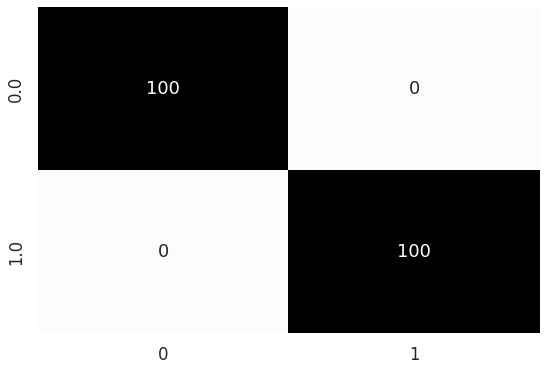

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_RF_grouped_uptake = my_model_RF_grouped_uptake.predict(population_data_test_uptake)
heatconmat(target_test_uptake,pred_RF_grouped_uptake)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_grouped_uptake.score(population_data_test_uptake, target_test_uptake)))

In [ ]:
# permutation analysis to find features importance
perm = PermutationImportance(my_model_RF_grouped_uptake).fit(population_data_uptake, target_uptake)
eli5.show_weights(perm, feature_names = population_data_uptake.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,normalized_intensity_BV421_A_7
0 ± 0.0000,normalized_intensity_PE_Texas_Red_A_2
0 ± 0.0000,normalized_intensity_PE_Texas_Red_A_1
0 ± 0.0000,normalized_intensity_FITC_A_11
0 ± 0.0000,normalized_intensity_FITC_A_10
0 ± 0.0000,normalized_intensity_FITC_A_9
0 ± 0.0000,normalized_intensity_FITC_A_8
0 ± 0.0000,normalized_intensity_FITC_A_7
0 ± 0.0000,normalized_intensity_FITC_A_6
0 ± 0.0000,normalized_intensity_FITC_A_5


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_rf_uptake_500' # name the model
pickle.dump(my_model_RF_grouped_uptake, open(data_path+ model_name+'.pkl', 'wb'))

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification = XGBClassifier(n_jobs=-1)
PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(population_data_uptake,target_uptake)

print(model_gs.best_params_)

running the model with the best parameters results

In [ ]:
# cross validation on the training data
xgboost_classification = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
scores = cross_val_score(xgboost_classification, population_data_uptake, target_uptake, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# Fitting the model on all the training data
my_model_xgboost_grouped_uptake = xgboost_classification.fit(population_data_uptake, target_uptake)
print ('xgboost training Score: {0:2.5f}'.format(my_model_xgboost_grouped_uptake.score(population_data_uptake, target_uptake)))

xgboost Score: 1.00000


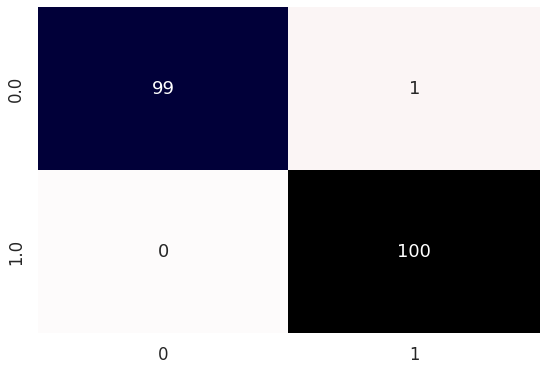

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       100
         1.0       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [ ]:
# prediction and visualization
pred_xgboost = my_model_xgboost_grouped_uptake.predict(population_data_test_uptake)
heatconmat(target_test_uptake,pred_xgboost)
print ('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_grouped_uptake.score(population_data_test_uptake, target_test_uptake)))

In [ ]:
# permutainon analysis to find features importance
perm_xgboost = PermutationImportance(my_model_xgboost_grouped_uptake, random_state=1).fit(population_data_uptake, target_uptake)
eli5.show_weights(perm_xgboost, feature_names = population_data_uptake.columns.tolist())

Weight,Feature
0.0013 ± 0.0025,sum_BV421_A_1
0 ± 0.0000,normalized_intensity_PE_Texas_Red_A_2
0 ± 0.0000,normalized_intensity_PE_Texas_Red_A_1
0 ± 0.0000,normalized_intensity_FITC_A_11
0 ± 0.0000,normalized_intensity_FITC_A_10
0 ± 0.0000,normalized_intensity_FITC_A_9
0 ± 0.0000,normalized_intensity_FITC_A_8
0 ± 0.0000,normalized_intensity_FITC_A_7
0 ± 0.0000,normalized_intensity_FITC_A_6
0 ± 0.0000,normalized_intensity_BV421_A_7


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_xgboost_uptake_500' # name the model
pickle.dump(my_model_xgboost_grouped_uptake, open(data_path+ model_name+'.pkl', 'wb'))

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(population_data_uptake, target_uptake)
print(grid_search.best_params_)

Running the model with the best parameters results

In [ ]:
# cross validation on the training data
SVM_uptake = svm.SVC(kernel='linear', C = 0.001, gamma = 0.001)
scores = cross_val_score(SVM_uptake, population_data_uptake, target_uptake, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the data on all the training data
my_model_SVM_grouped_uptake = SVM_uptake.fit(population_data_uptake, target_uptake)
print ('SVM training Score: {0:2.5f}'.format(my_model_SVM_grouped_uptake.score(population_data_uptake, target_uptake)))

SVM Score: 1.00000


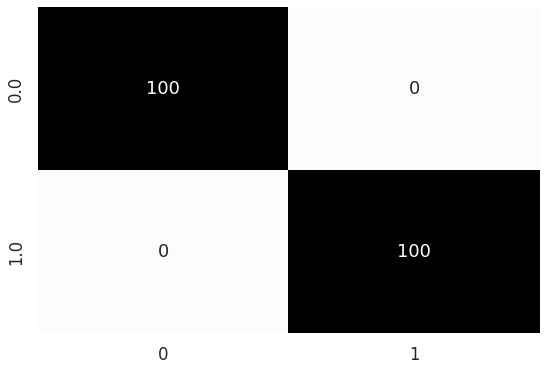

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_SVM = my_model_SVM_grouped_uptake.predict(population_data_test_uptake)
heatconmat(target_test_uptake,pred_SVM)
print ('SVM testing Score: {0:2.5f}'.format(my_model_SVM_grouped_uptake.score(population_data_test_uptake, target_test_uptake)))

In [ ]:
# permutation analysis to find features importance
perm_SVM = PermutationImportance(my_model_SVM_grouped_uptake, random_state=1).fit(population_data_test_uptake, target_test_uptake)
eli5.show_weights(perm_SVM, feature_names = population_data_test_uptake.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,normalized_intensity_BV421_A_7
0 ± 0.0000,normalized_intensity_PE_Texas_Red_A_2
0 ± 0.0000,normalized_intensity_PE_Texas_Red_A_1
0 ± 0.0000,normalized_intensity_FITC_A_11
0 ± 0.0000,normalized_intensity_FITC_A_10
0 ± 0.0000,normalized_intensity_FITC_A_9
0 ± 0.0000,normalized_intensity_FITC_A_8
0 ± 0.0000,normalized_intensity_FITC_A_7
0 ± 0.0000,normalized_intensity_FITC_A_6
0 ± 0.0000,normalized_intensity_FITC_A_5


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_SVM_uptake_500' # name the model
pickle.dump(my_model_SVM_grouped_uptake, open(data_path+ model_name+'.pkl', 'wb'))

### new experiment testing - Batch data

In [ ]:
# reading the batch data - for this example the batch data was already preprocessed
Merge_population_batch_uptake = pd.read_csv(data_path +'Merge_population_H460_test_500.csv')

In [ ]:
# separating the testing features from the lables
cols_batch = [col for col in Merge_population_batch_uptake.columns if col not in ['Cell_line']]
population_data_batch_uptake = Merge_population_batch_uptake[cols_batch]

# assigning the cell identity column as target
target_batch = Merge_population_batch_uptake['Cell_line']

Random forest

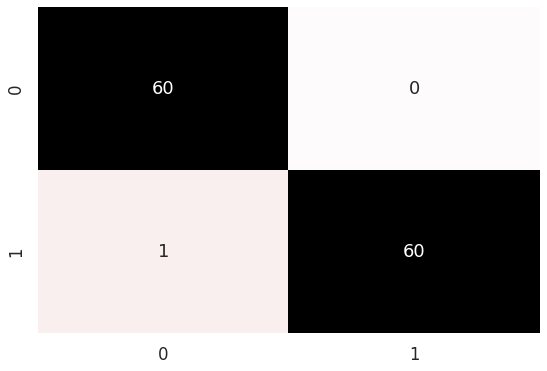

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.98      0.99        61

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



In [ ]:
# prediction and visualization
pred_random_forest_uptake_batch = my_model_RF_grouped_uptake.predict(population_data_batch_uptake)
heatconmat(target_batch,pred_random_forest_uptake_batch)
accuracy = accuracy_score(pred_random_forest_uptake_batch.astype(int), target_batch.astype(int))
print(accuracy)

XGBoost

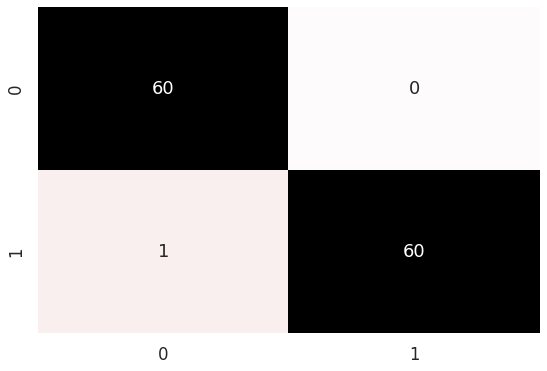

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.98      0.99        61

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



In [ ]:
# prediction and visualization
pred_xgboost_uptake_batch = my_model_xgboost_grouped_uptake.predict(population_data_batch_uptake)
heatconmat(target_batch,pred_xgboost_uptake_batch)
accuracy = accuracy_score(pred_xgboost_uptake_batch.astype(int), target_batch.astype(int))
print(accuracy)

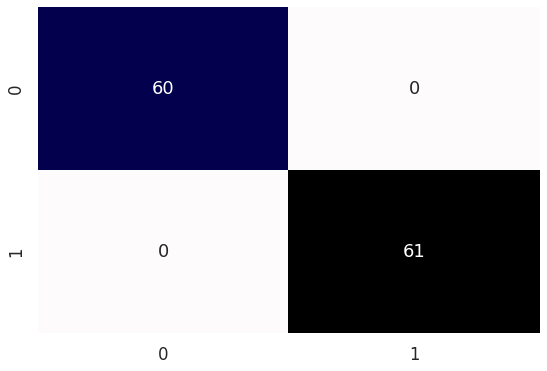

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
# prediction and visualization
pred_batch_uptake_SVM = my_model_SVM_grouped_uptake.predict(population_data_batch_uptake)
heatconmat(target_batch,pred_batch_uptake_SVM)
accuracy = accuracy_score(pred_batch_uptake_SVM.astype(int), target_batch.astype(int))
print(accuracy)

# Dimention reduction using principal component analysis PCA

In [ ]:
# rescale the data
train_data_rescaled = scaler.fit_transform(population_data_uptake)
test_data_rescaled = scaler.fit_transform(population_data_test_uptake)
batch_data_rescaled = scaler.fit_transform(population_data_batch_uptake)


Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


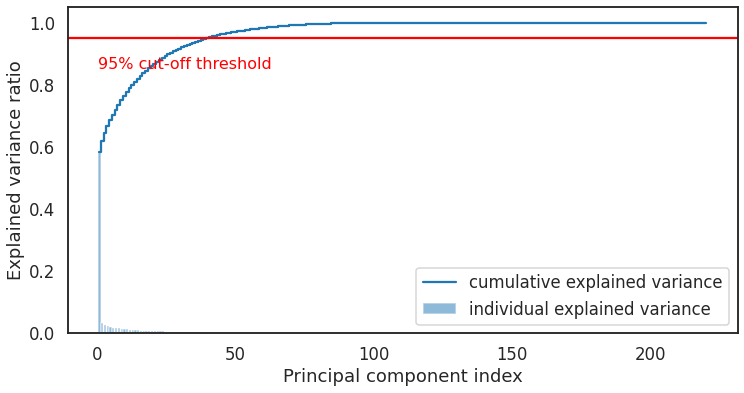

In [ ]:
# displaying the componantes and the data varience they includes for choosing the number of componnets to reduced to
cov_mat = np.cov(train_data_rescaled.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.rcParams["figure.figsize"] = (12,6)
plt.bar(range(1,221), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,221), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.legend(loc='best')
plt.show()

In [ ]:
pca_uptake = PCA(n_components=38) # choosing the number of dimentions

# fit and transform data
X_train_pca_uptake = pca_uptake.fit_transform(train_data_rescaled)
X_test_pca_uptake = pca_uptake.transform(test_data_rescaled)
X_test_pca_batch = pca_uptake.transform(batch_data_rescaled)


In [ ]:
# How much each original feature contribute to the components
print(pd.DataFrame(np.abs(pca_uptake.components_),columns=population_data_uptake.columns ,index = ['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7', 'PC-8', 'PC-9', 'PC-10',
                                                                                                   'PC-11', 'PC-12', 'PC-13', 'PC-14', 'PC-15', 'PC-16', 'PC-17', 'PC-18', 'PC-19', 'PC-20',
                                                                                                   'PC-21', 'PC-22', 'PC-23', 'PC-24', 'PC-25', 'PC-26', 'PC-27', 'PC-28', 'PC-29', 'PC-30',
                                                                                                   'PC-31', 'PC-32', 'PC-33', 'PC-34', 'PC-35', 'PC-36', 'PC-37', 'PC-38']))

In [ ]:
# printing the most contributing original feature for each component
most_important = np.abs(pca_uptake.components_).argmax(axis=1)
initial_feature_names = population_data_uptake.columns
most_important_names = initial_feature_names[most_important]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(38)}
pca_results = pd.DataFrame(dic.items())
print(pca_results)

       0                                         1
0    PC1                              sum_FITC_A_3
1    PC2                     mean_intensity_0.8_10
2    PC3                    mean_intensity_0.04_10
3    PC4                    mean_intensity_0.04_10
4    PC5                     mean_intensity_0.8_10
5    PC6                     mean_intensity_0.04_9
6    PC7                     mean_intensity_0.5_10
7    PC8                     mean_intensity_0.5_11
8    PC9                     mean_intensity_3.36_6
9   PC10                     mean_intensity_0.5_10
10  PC11                     mean_intensity_3.36_4
11  PC12            normalized_intensity_PerCP_A_1
12  PC13                     mean_intensity_2.4_10
13  PC14                     mean_intensity_2.4_10
14  PC15                     mean_intensity_3.36_9
15  PC16                      mean_intensity_0.5_9
16  PC17                      mean_intensity_2.4_5
17  PC18                      mean_intensity_0.5_8
18  PC19                      m

Random forset

Hyperparameters optimization

In [ ]:
random_forest_grouped_uptake_pca= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [500, 1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_uptake_pca,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(X_train_pca_uptake, target_uptake)
print(model_gridsearch.best_params_)

running and fitting the model using the best parameters results

In [ ]:
random_forest_grouped_uptake_pca= RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 500, n_jobs=-1)
my_model_RF_PCA_uptake = random_forest_grouped_uptake_pca.fit(X_train_pca_uptake, target_uptake)
print ('random_forest testing Score: {0:2.5f}'.format(my_model_RF_PCA_uptake.score(X_test_pca_uptake, target_test_uptake)))

In [ ]:
# prediction on Batch data
pred_random_forest_uptake_PCA_batch = my_model_RF_PCA_uptake.predict(X_test_pca_batch)
accuracy = accuracy_score(pred_random_forest_uptake_PCA_batch.astype(int), target_batch.astype(int))
accuracy

0.9917355371900827

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_uptake_pca = XGBClassifier(n_jobs=-1)
PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_uptake_pca,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(X_train_pca_uptake,target_uptake)
print(model_gs.best_params_)

running and fitting the model using the best parameters results

In [ ]:
xgboost_classification_uptake_pca = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
my_model_xgboost_PCA_uptake = xgboost_classification_uptake_pca.fit(X_train_pca_uptake, target_uptake)
print ('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_PCA_uptake.score(X_test_pca_uptake, target_test_uptake)))

In [ ]:
# prediction on Batch data
pred_xgboost_uptake_PCA_batch = my_model_xgboost_PCA_uptake.predict(X_test_pca_batch)
accuracy = accuracy_score(pred_xgboost_uptake_PCA_batch.astype(int), target_batch.astype(int))
accuracy

0.9917355371900827

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(X_train_pca_uptake, target_uptake)
print(grid_search.best_params_)

running and fitting the model using the best parameters results

In [ ]:
SVM_uptake_pca = svm.SVC(C = 0.001, gamma = 0.001, kernel = 'linear')
my_model_SVM_PCA_uptake = SVM_uptake_pca.fit(X_train_pca_uptake, target_uptake)
print ('SVM testing Score: {0:2.5f}'.format(my_model_SVM_PCA_uptake.score(X_test_pca_uptake, target_test_uptake)))

In [ ]:
# prediction on Batch data
pred_SVM_uptake_PCA_batch = my_model_SVM_PCA_uptake.predict(X_test_pca_batch)
accuracy = accuracy_score(pred_SVM_uptake_PCA_batch.astype(int), target_batch.astype(int))
accuracy

0.9917355371900827

## Physiological features

Pop 1 training data

In [ ]:
# deviding FSC and SSC intensities to bins
Total_pop_1_log[['FSC_A_1', 'FSC_A_2', 'FSC_A_3', 'FSC_A_4', 'FSC_A_5', 'FSC_A_6', 'FSC_A_7']] = Total_pop_1_log['FSC_A'].apply(bins_phys)
Total_pop_1_log[['FSC_H_1', 'FSC_H_2', 'FSC_H_3', 'FSC_H_4', 'FSC_H_5', 'FSC_H_6', 'FSC_H_7']] = Total_pop_1_log['FSC_H'].apply(bins_phys)
Total_pop_1_log[['FSC_W_1', 'FSC_W_2', 'FSC_W_3', 'FSC_W_4', 'FSC_W_5', 'FSC_W_6', 'FSC_W_7']] = Total_pop_1_log['FSC_W'].apply(bins_phys)
Total_pop_1_log[['SSC_A_1', 'SSC_A_2', 'SSC_A_3', 'SSC_A_4', 'SSC_A_5', 'SSC_A_6', 'SSC_A_7']] = Total_pop_1_log['SSC_A'].apply(bins_phys)
Total_pop_1_log[['SSC_H_1', 'SSC_H_2', 'SSC_H_3', 'SSC_H_4', 'SSC_H_5', 'SSC_H_6', 'SSC_H_7']] = Total_pop_1_log['SSC_H'].apply(bins_phys)
Total_pop_1_log[['SSC_W_1', 'SSC_W_2', 'SSC_W_3', 'SSC_W_4', 'SSC_W_5', 'SSC_W_6', 'SSC_W_7']] = Total_pop_1_log['SSC_W'].apply(bins_phys)

In [ ]:
# grouping based on population number
grouper = Total_pop_1_log.groupby(pd.Grouper(key='population_number'))

FSC_A_1_sum = grouper['FSC_A_1'].sum().to_frame(name='sum_FSC_A_1').reset_index()
FSC_A_2_sum = grouper['FSC_A_2'].sum().to_frame(name='sum_FSC_A_2').reset_index()
FSC_A_3_sum = grouper['FSC_A_3'].sum().to_frame(name='sum_FSC_A_3').reset_index()
FSC_A_4_sum = grouper['FSC_A_4'].sum().to_frame(name='sum_FSC_A_4').reset_index()
FSC_A_5_sum = grouper['FSC_A_5'].sum().to_frame(name='sum_FSC_A_5').reset_index()
FSC_A_6_sum = grouper['FSC_A_6'].sum().to_frame(name='sum_FSC_A_6').reset_index()
FSC_A_7_sum = grouper['FSC_A_7'].sum().to_frame(name='sum_FSC_A_7').reset_index()

FSC_H_1_sum = grouper['FSC_H_1'].sum().to_frame(name='sum_FSC_H_1').reset_index()
FSC_H_2_sum = grouper['FSC_H_2'].sum().to_frame(name='sum_FSC_H_2').reset_index()
FSC_H_3_sum = grouper['FSC_H_3'].sum().to_frame(name='sum_FSC_H_3').reset_index()
FSC_H_4_sum = grouper['FSC_H_4'].sum().to_frame(name='sum_FSC_H_4').reset_index()
FSC_H_5_sum = grouper['FSC_H_5'].sum().to_frame(name='sum_FSC_H_5').reset_index()
FSC_H_6_sum = grouper['FSC_H_6'].sum().to_frame(name='sum_FSC_H_6').reset_index()
FSC_H_7_sum = grouper['FSC_H_7'].sum().to_frame(name='sum_FSC_H_7').reset_index()

FSC_W_1_sum = grouper['FSC_W_1'].sum().to_frame(name='sum_FSC_W_1').reset_index()
FSC_W_2_sum = grouper['FSC_W_2'].sum().to_frame(name='sum_FSC_W_2').reset_index()
FSC_W_3_sum = grouper['FSC_W_3'].sum().to_frame(name='sum_FSC_W_3').reset_index()
FSC_W_4_sum = grouper['FSC_W_4'].sum().to_frame(name='sum_FSC_W_4').reset_index()
FSC_W_5_sum = grouper['FSC_W_5'].sum().to_frame(name='sum_FSC_W_5').reset_index()
FSC_W_6_sum = grouper['FSC_W_6'].sum().to_frame(name='sum_FSC_W_6').reset_index()
FSC_W_7_sum = grouper['FSC_W_7'].sum().to_frame(name='sum_FSC_W_7').reset_index()

SSC_A_1_sum = grouper['SSC_A_1'].sum().to_frame(name='sum_SSC_A_1').reset_index()
SSC_A_2_sum = grouper['SSC_A_2'].sum().to_frame(name='sum_SSC_A_2').reset_index()
SSC_A_3_sum = grouper['SSC_A_3'].sum().to_frame(name='sum_SSC_A_3').reset_index()
SSC_A_4_sum = grouper['SSC_A_4'].sum().to_frame(name='sum_SSC_A_4').reset_index()
SSC_A_5_sum = grouper['SSC_A_5'].sum().to_frame(name='sum_SSC_A_5').reset_index()
SSC_A_6_sum = grouper['SSC_A_6'].sum().to_frame(name='sum_SSC_A_6').reset_index()
SSC_A_7_sum = grouper['SSC_A_7'].sum().to_frame(name='sum_SSC_A_7').reset_index()

SSC_H_1_sum = grouper['SSC_H_1'].sum().to_frame(name='sum_SSC_H_1').reset_index()
SSC_H_2_sum = grouper['SSC_H_2'].sum().to_frame(name='sum_SSC_H_2').reset_index()
SSC_H_3_sum = grouper['SSC_H_3'].sum().to_frame(name='sum_SSC_H_3').reset_index()
SSC_H_4_sum = grouper['SSC_H_4'].sum().to_frame(name='sum_SSC_H_4').reset_index()
SSC_H_5_sum = grouper['SSC_H_5'].sum().to_frame(name='sum_SSC_H_5').reset_index()
SSC_H_6_sum = grouper['SSC_H_6'].sum().to_frame(name='sum_SSC_H_6').reset_index()
SSC_H_7_sum = grouper['SSC_H_7'].sum().to_frame(name='sum_SSC_H_7').reset_index()

SSC_W_1_sum = grouper['SSC_W_1'].sum().to_frame(name='sum_SSC_W_1').reset_index()
SSC_W_2_sum = grouper['SSC_W_2'].sum().to_frame(name='sum_SSC_W_2').reset_index()
SSC_W_3_sum = grouper['SSC_W_3'].sum().to_frame(name='sum_SSC_W_3').reset_index()
SSC_W_4_sum = grouper['SSC_W_4'].sum().to_frame(name='sum_SSC_W_4').reset_index()
SSC_W_5_sum = grouper['SSC_W_5'].sum().to_frame(name='sum_SSC_W_5').reset_index()
SSC_W_6_sum = grouper['SSC_W_6'].sum().to_frame(name='sum_SSC_W_6').reset_index()
SSC_W_7_sum = grouper['SSC_W_7'].sum().to_frame(name='sum_SSC_W_7').reset_index()

In [ ]:
# setting an array of all the grouped data
pop_1_phys_log_grouper_phys = [FSC_A_1_sum, FSC_A_2_sum, FSC_A_3_sum, FSC_A_4_sum, FSC_A_5_sum, FSC_A_6_sum, FSC_A_7_sum,
                      FSC_H_1_sum, FSC_H_2_sum, FSC_H_3_sum, FSC_H_4_sum, FSC_H_5_sum, FSC_H_6_sum, FSC_H_7_sum,
                      FSC_W_1_sum, FSC_W_2_sum, FSC_W_3_sum, FSC_W_4_sum, FSC_W_5_sum, FSC_W_6_sum, FSC_W_7_sum,
                      SSC_A_1_sum, SSC_A_2_sum, SSC_A_3_sum, SSC_A_4_sum, SSC_A_5_sum, SSC_A_6_sum, SSC_A_7_sum,
                      SSC_H_1_sum, SSC_H_2_sum, SSC_H_3_sum, SSC_H_4_sum, SSC_H_5_sum, SSC_H_6_sum, SSC_H_7_sum,
                      SSC_W_1_sum, SSC_W_2_sum, SSC_W_3_sum, SSC_W_4_sum, SSC_W_5_sum, SSC_W_6_sum, SSC_W_7_sum,
                      ]

In [ ]:
# building a new df of the grouped data
pop_1_phys_log_grouped = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_1_phys_log_grouper_phys)
pop_1_phys_log_grouped['Cell_line'] = 0

Pop 2 - training data

In [ ]:
# deviding FSC and SSC intensities to bins
Total_pop_2_log[['FSC_A_1', 'FSC_A_2', 'FSC_A_3', 'FSC_A_4', 'FSC_A_5', 'FSC_A_6', 'FSC_A_7']] = Total_pop_2_log['FSC_A'].apply(bins_phys)
Total_pop_2_log[['FSC_H_1', 'FSC_H_2', 'FSC_H_3', 'FSC_H_4', 'FSC_H_5', 'FSC_H_6', 'FSC_H_7']] = Total_pop_2_log['FSC_H'].apply(bins_phys)
Total_pop_2_log[['FSC_W_1', 'FSC_W_2', 'FSC_W_3', 'FSC_W_4', 'FSC_W_5', 'FSC_W_6', 'FSC_W_7']] = Total_pop_2_log['FSC_W'].apply(bins_phys)
Total_pop_2_log[['SSC_A_1', 'SSC_A_2', 'SSC_A_3', 'SSC_A_4', 'SSC_A_5', 'SSC_A_6', 'SSC_A_7']] = Total_pop_2_log['SSC_A'].apply(bins_phys)
Total_pop_2_log[['SSC_H_1', 'SSC_H_2', 'SSC_H_3', 'SSC_H_4', 'SSC_H_5', 'SSC_H_6', 'SSC_H_7']] = Total_pop_2_log['SSC_H'].apply(bins_phys)
Total_pop_2_log[['SSC_W_1', 'SSC_W_2', 'SSC_W_3', 'SSC_W_4', 'SSC_W_5', 'SSC_W_6', 'SSC_W_7']] = Total_pop_2_log['SSC_W'].apply(bins_phys)

In [ ]:
# grouping the sunm of the intensitys per bin based on population number
grouper = Total_pop_2_log.groupby(pd.Grouper(key='population_number'))

FSC_A_1_sum = grouper['FSC_A_1'].sum().to_frame(name='sum_FSC_A_1').reset_index()
FSC_A_2_sum = grouper['FSC_A_2'].sum().to_frame(name='sum_FSC_A_2').reset_index()
FSC_A_3_sum = grouper['FSC_A_3'].sum().to_frame(name='sum_FSC_A_3').reset_index()
FSC_A_4_sum = grouper['FSC_A_4'].sum().to_frame(name='sum_FSC_A_4').reset_index()
FSC_A_5_sum = grouper['FSC_A_5'].sum().to_frame(name='sum_FSC_A_5').reset_index()
FSC_A_6_sum = grouper['FSC_A_6'].sum().to_frame(name='sum_FSC_A_6').reset_index()
FSC_A_7_sum = grouper['FSC_A_7'].sum().to_frame(name='sum_FSC_A_7').reset_index()

FSC_H_1_sum = grouper['FSC_H_1'].sum().to_frame(name='sum_FSC_H_1').reset_index()
FSC_H_2_sum = grouper['FSC_H_2'].sum().to_frame(name='sum_FSC_H_2').reset_index()
FSC_H_3_sum = grouper['FSC_H_3'].sum().to_frame(name='sum_FSC_H_3').reset_index()
FSC_H_4_sum = grouper['FSC_H_4'].sum().to_frame(name='sum_FSC_H_4').reset_index()
FSC_H_5_sum = grouper['FSC_H_5'].sum().to_frame(name='sum_FSC_H_5').reset_index()
FSC_H_6_sum = grouper['FSC_H_6'].sum().to_frame(name='sum_FSC_H_6').reset_index()
FSC_H_7_sum = grouper['FSC_H_7'].sum().to_frame(name='sum_FSC_H_7').reset_index()

FSC_W_1_sum = grouper['FSC_W_1'].sum().to_frame(name='sum_FSC_W_1').reset_index()
FSC_W_2_sum = grouper['FSC_W_2'].sum().to_frame(name='sum_FSC_W_2').reset_index()
FSC_W_3_sum = grouper['FSC_W_3'].sum().to_frame(name='sum_FSC_W_3').reset_index()
FSC_W_4_sum = grouper['FSC_W_4'].sum().to_frame(name='sum_FSC_W_4').reset_index()
FSC_W_5_sum = grouper['FSC_W_5'].sum().to_frame(name='sum_FSC_W_5').reset_index()
FSC_W_6_sum = grouper['FSC_W_6'].sum().to_frame(name='sum_FSC_W_6').reset_index()
FSC_W_7_sum = grouper['FSC_W_7'].sum().to_frame(name='sum_FSC_W_7').reset_index()

SSC_A_1_sum = grouper['SSC_A_1'].sum().to_frame(name='sum_SSC_A_1').reset_index()
SSC_A_2_sum = grouper['SSC_A_2'].sum().to_frame(name='sum_SSC_A_2').reset_index()
SSC_A_3_sum = grouper['SSC_A_3'].sum().to_frame(name='sum_SSC_A_3').reset_index()
SSC_A_4_sum = grouper['SSC_A_4'].sum().to_frame(name='sum_SSC_A_4').reset_index()
SSC_A_5_sum = grouper['SSC_A_5'].sum().to_frame(name='sum_SSC_A_5').reset_index()
SSC_A_6_sum = grouper['SSC_A_6'].sum().to_frame(name='sum_SSC_A_6').reset_index()
SSC_A_7_sum = grouper['SSC_A_7'].sum().to_frame(name='sum_SSC_A_7').reset_index()

SSC_H_1_sum = grouper['SSC_H_1'].sum().to_frame(name='sum_SSC_H_1').reset_index()
SSC_H_2_sum = grouper['SSC_H_2'].sum().to_frame(name='sum_SSC_H_2').reset_index()
SSC_H_3_sum = grouper['SSC_H_3'].sum().to_frame(name='sum_SSC_H_3').reset_index()
SSC_H_4_sum = grouper['SSC_H_4'].sum().to_frame(name='sum_SSC_H_4').reset_index()
SSC_H_5_sum = grouper['SSC_H_5'].sum().to_frame(name='sum_SSC_H_5').reset_index()
SSC_H_6_sum = grouper['SSC_H_6'].sum().to_frame(name='sum_SSC_H_6').reset_index()
SSC_H_7_sum = grouper['SSC_H_7'].sum().to_frame(name='sum_SSC_H_7').reset_index()

SSC_W_1_sum = grouper['SSC_W_1'].sum().to_frame(name='sum_SSC_W_1').reset_index()
SSC_W_2_sum = grouper['SSC_W_2'].sum().to_frame(name='sum_SSC_W_2').reset_index()
SSC_W_3_sum = grouper['SSC_W_3'].sum().to_frame(name='sum_SSC_W_3').reset_index()
SSC_W_4_sum = grouper['SSC_W_4'].sum().to_frame(name='sum_SSC_W_4').reset_index()
SSC_W_5_sum = grouper['SSC_W_5'].sum().to_frame(name='sum_SSC_W_5').reset_index()
SSC_W_6_sum = grouper['SSC_W_6'].sum().to_frame(name='sum_SSC_W_6').reset_index()
SSC_W_7_sum = grouper['SSC_W_7'].sum().to_frame(name='sum_SSC_W_7').reset_index()

In [ ]:
# setting an array of all the grouped data
pop_2_phys_log_grouper_phys = [FSC_A_1_sum, FSC_A_2_sum, FSC_A_3_sum, FSC_A_4_sum, FSC_A_5_sum, FSC_A_6_sum, FSC_A_7_sum,
                      FSC_H_1_sum, FSC_H_2_sum, FSC_H_3_sum, FSC_H_4_sum, FSC_H_5_sum, FSC_H_6_sum, FSC_H_7_sum,
                      FSC_W_1_sum, FSC_W_2_sum, FSC_W_3_sum, FSC_W_4_sum, FSC_W_5_sum, FSC_W_6_sum, FSC_W_7_sum,
                      SSC_A_1_sum, SSC_A_2_sum, SSC_A_3_sum, SSC_A_4_sum, SSC_A_5_sum, SSC_A_6_sum, SSC_A_7_sum,
                      SSC_H_1_sum, SSC_H_2_sum, SSC_H_3_sum, SSC_H_4_sum, SSC_H_5_sum, SSC_H_6_sum, SSC_H_7_sum,
                      SSC_W_1_sum, SSC_W_2_sum, SSC_W_3_sum, SSC_W_4_sum, SSC_W_5_sum, SSC_W_6_sum, SSC_W_7_sum,
                      ]

In [ ]:
# building a new dfs of the grouped data
pop_2_phys_log_grouped = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_2_phys_log_grouper_phys)
pop_2_phys_log_grouped['Cell_line'] = 1

In [ ]:
# merging the training datasets of the two populations
populations_df_phys_list = [pop_1_phys_log_grouped, pop_2_phys_log_grouped]
Merge_population_phys = pd.DataFrame()
for df in populations_df_phys_list:
    Merge_population_phys = pd.concat([Merge_population_phys, df], ignore_index=True)

Merge_population_phys = Merge_population_phys.drop('population_number', axis = 1)

Pop 1 - testing data

In [ ]:
# deviding FSC and SSC intensities to bins
Total_pop_1_test_log[['FSC_A_1', 'FSC_A_2', 'FSC_A_3', 'FSC_A_4', 'FSC_A_5', 'FSC_A_6', 'FSC_A_7']] = Total_pop_1_test_log['FSC_A'].apply(bins_phys)
Total_pop_1_test_log[['FSC_H_1', 'FSC_H_2', 'FSC_H_3', 'FSC_H_4', 'FSC_H_5', 'FSC_H_6', 'FSC_H_7']] = Total_pop_1_test_log['FSC_H'].apply(bins_phys)
Total_pop_1_test_log[['FSC_W_1', 'FSC_W_2', 'FSC_W_3', 'FSC_W_4', 'FSC_W_5', 'FSC_W_6', 'FSC_W_7']] = Total_pop_1_test_log['FSC_W'].apply(bins_phys)
Total_pop_1_test_log[['SSC_A_1', 'SSC_A_2', 'SSC_A_3', 'SSC_A_4', 'SSC_A_5', 'SSC_A_6', 'SSC_A_7']] = Total_pop_1_test_log['SSC_A'].apply(bins_phys)
Total_pop_1_test_log[['SSC_H_1', 'SSC_H_2', 'SSC_H_3', 'SSC_H_4', 'SSC_H_5', 'SSC_H_6', 'SSC_H_7']] = Total_pop_1_test_log['SSC_H'].apply(bins_phys)
Total_pop_1_test_log[['SSC_W_1', 'SSC_W_2', 'SSC_W_3', 'SSC_W_4', 'SSC_W_5', 'SSC_W_6', 'SSC_W_7']] = Total_pop_1_test_log['SSC_W'].apply(bins_phys)

In [ ]:
# grouping based on population number
grouper = Total_pop_1_test_log.groupby(pd.Grouper(key='population_number'))

FSC_A_1_sum = grouper['FSC_A_1'].sum().to_frame(name='sum_FSC_A_1').reset_index()
FSC_A_2_sum = grouper['FSC_A_2'].sum().to_frame(name='sum_FSC_A_2').reset_index()
FSC_A_3_sum = grouper['FSC_A_3'].sum().to_frame(name='sum_FSC_A_3').reset_index()
FSC_A_4_sum = grouper['FSC_A_4'].sum().to_frame(name='sum_FSC_A_4').reset_index()
FSC_A_5_sum = grouper['FSC_A_5'].sum().to_frame(name='sum_FSC_A_5').reset_index()
FSC_A_6_sum = grouper['FSC_A_6'].sum().to_frame(name='sum_FSC_A_6').reset_index()
FSC_A_7_sum = grouper['FSC_A_7'].sum().to_frame(name='sum_FSC_A_7').reset_index()

FSC_H_1_sum = grouper['FSC_H_1'].sum().to_frame(name='sum_FSC_H_1').reset_index()
FSC_H_2_sum = grouper['FSC_H_2'].sum().to_frame(name='sum_FSC_H_2').reset_index()
FSC_H_3_sum = grouper['FSC_H_3'].sum().to_frame(name='sum_FSC_H_3').reset_index()
FSC_H_4_sum = grouper['FSC_H_4'].sum().to_frame(name='sum_FSC_H_4').reset_index()
FSC_H_5_sum = grouper['FSC_H_5'].sum().to_frame(name='sum_FSC_H_5').reset_index()
FSC_H_6_sum = grouper['FSC_H_6'].sum().to_frame(name='sum_FSC_H_6').reset_index()
FSC_H_7_sum = grouper['FSC_H_7'].sum().to_frame(name='sum_FSC_H_7').reset_index()

FSC_W_1_sum = grouper['FSC_W_1'].sum().to_frame(name='sum_FSC_W_1').reset_index()
FSC_W_2_sum = grouper['FSC_W_2'].sum().to_frame(name='sum_FSC_W_2').reset_index()
FSC_W_3_sum = grouper['FSC_W_3'].sum().to_frame(name='sum_FSC_W_3').reset_index()
FSC_W_4_sum = grouper['FSC_W_4'].sum().to_frame(name='sum_FSC_W_4').reset_index()
FSC_W_5_sum = grouper['FSC_W_5'].sum().to_frame(name='sum_FSC_W_5').reset_index()
FSC_W_6_sum = grouper['FSC_W_6'].sum().to_frame(name='sum_FSC_W_6').reset_index()
FSC_W_7_sum = grouper['FSC_W_7'].sum().to_frame(name='sum_FSC_W_7').reset_index()

SSC_A_1_sum = grouper['SSC_A_1'].sum().to_frame(name='sum_SSC_A_1').reset_index()
SSC_A_2_sum = grouper['SSC_A_2'].sum().to_frame(name='sum_SSC_A_2').reset_index()
SSC_A_3_sum = grouper['SSC_A_3'].sum().to_frame(name='sum_SSC_A_3').reset_index()
SSC_A_4_sum = grouper['SSC_A_4'].sum().to_frame(name='sum_SSC_A_4').reset_index()
SSC_A_5_sum = grouper['SSC_A_5'].sum().to_frame(name='sum_SSC_A_5').reset_index()
SSC_A_6_sum = grouper['SSC_A_6'].sum().to_frame(name='sum_SSC_A_6').reset_index()
SSC_A_7_sum = grouper['SSC_A_7'].sum().to_frame(name='sum_SSC_A_7').reset_index()

SSC_H_1_sum = grouper['SSC_H_1'].sum().to_frame(name='sum_SSC_H_1').reset_index()
SSC_H_2_sum = grouper['SSC_H_2'].sum().to_frame(name='sum_SSC_H_2').reset_index()
SSC_H_3_sum = grouper['SSC_H_3'].sum().to_frame(name='sum_SSC_H_3').reset_index()
SSC_H_4_sum = grouper['SSC_H_4'].sum().to_frame(name='sum_SSC_H_4').reset_index()
SSC_H_5_sum = grouper['SSC_H_5'].sum().to_frame(name='sum_SSC_H_5').reset_index()
SSC_H_6_sum = grouper['SSC_H_6'].sum().to_frame(name='sum_SSC_H_6').reset_index()
SSC_H_7_sum = grouper['SSC_H_7'].sum().to_frame(name='sum_SSC_H_7').reset_index()

SSC_W_1_sum = grouper['SSC_W_1'].sum().to_frame(name='sum_SSC_W_1').reset_index()
SSC_W_2_sum = grouper['SSC_W_2'].sum().to_frame(name='sum_SSC_W_2').reset_index()
SSC_W_3_sum = grouper['SSC_W_3'].sum().to_frame(name='sum_SSC_W_3').reset_index()
SSC_W_4_sum = grouper['SSC_W_4'].sum().to_frame(name='sum_SSC_W_4').reset_index()
SSC_W_5_sum = grouper['SSC_W_5'].sum().to_frame(name='sum_SSC_W_5').reset_index()
SSC_W_6_sum = grouper['SSC_W_6'].sum().to_frame(name='sum_SSC_W_6').reset_index()
SSC_W_7_sum = grouper['SSC_W_7'].sum().to_frame(name='sum_SSC_W_7').reset_index()

In [ ]:
# setting an array of all the grouped data
pop_1_test_phys_log_grouper_phys = [FSC_A_1_sum, FSC_A_2_sum, FSC_A_3_sum, FSC_A_4_sum, FSC_A_5_sum, FSC_A_6_sum, FSC_A_7_sum,
                      FSC_H_1_sum, FSC_H_2_sum, FSC_H_3_sum, FSC_H_4_sum, FSC_H_5_sum, FSC_H_6_sum, FSC_H_7_sum,
                      FSC_W_1_sum, FSC_W_2_sum, FSC_W_3_sum, FSC_W_4_sum, FSC_W_5_sum, FSC_W_6_sum, FSC_W_7_sum,
                      SSC_A_1_sum, SSC_A_2_sum, SSC_A_3_sum, SSC_A_4_sum, SSC_A_5_sum, SSC_A_6_sum, SSC_A_7_sum,
                      SSC_H_1_sum, SSC_H_2_sum, SSC_H_3_sum, SSC_H_4_sum, SSC_H_5_sum, SSC_H_6_sum, SSC_H_7_sum,
                      SSC_W_1_sum, SSC_W_2_sum, SSC_W_3_sum, SSC_W_4_sum, SSC_W_5_sum, SSC_W_6_sum, SSC_W_7_sum,
                      ]

In [ ]:
# building a new df of the grouped data
pop_1_test_phys_log_grouped = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_1_test_phys_log_grouper_phys)
pop_1_test_phys_log_grouped['Cell_line'] = 0

Pop 2 - testing data

In [ ]:
# deviding FSC and SSC intensities to bins
Total_pop_2_test_log[['FSC_A_1', 'FSC_A_2', 'FSC_A_3', 'FSC_A_4', 'FSC_A_5', 'FSC_A_6', 'FSC_A_7']] = Total_pop_2_test_log['FSC_A'].apply(bins_phys)
Total_pop_2_test_log[['FSC_H_1', 'FSC_H_2', 'FSC_H_3', 'FSC_H_4', 'FSC_H_5', 'FSC_H_6', 'FSC_H_7']] = Total_pop_2_test_log['FSC_H'].apply(bins_phys)
Total_pop_2_test_log[['FSC_W_1', 'FSC_W_2', 'FSC_W_3', 'FSC_W_4', 'FSC_W_5', 'FSC_W_6', 'FSC_W_7']] = Total_pop_2_test_log['FSC_W'].apply(bins_phys)
Total_pop_2_test_log[['SSC_A_1', 'SSC_A_2', 'SSC_A_3', 'SSC_A_4', 'SSC_A_5', 'SSC_A_6', 'SSC_A_7']] = Total_pop_2_test_log['SSC_A'].apply(bins_phys)
Total_pop_2_test_log[['SSC_H_1', 'SSC_H_2', 'SSC_H_3', 'SSC_H_4', 'SSC_H_5', 'SSC_H_6', 'SSC_H_7']] = Total_pop_2_test_log['SSC_H'].apply(bins_phys)
Total_pop_2_test_log[['SSC_W_1', 'SSC_W_2', 'SSC_W_3', 'SSC_W_4', 'SSC_W_5', 'SSC_W_6', 'SSC_W_7']] = Total_pop_2_test_log['SSC_W'].apply(bins_phys)

In [ ]:
# grouping based on population number
grouper = Total_pop_2_test_log.groupby(pd.Grouper(key='population_number'))

FSC_A_1_sum = grouper['FSC_A_1'].sum().to_frame(name='sum_FSC_A_1').reset_index()
FSC_A_2_sum = grouper['FSC_A_2'].sum().to_frame(name='sum_FSC_A_2').reset_index()
FSC_A_3_sum = grouper['FSC_A_3'].sum().to_frame(name='sum_FSC_A_3').reset_index()
FSC_A_4_sum = grouper['FSC_A_4'].sum().to_frame(name='sum_FSC_A_4').reset_index()
FSC_A_5_sum = grouper['FSC_A_5'].sum().to_frame(name='sum_FSC_A_5').reset_index()
FSC_A_6_sum = grouper['FSC_A_6'].sum().to_frame(name='sum_FSC_A_6').reset_index()
FSC_A_7_sum = grouper['FSC_A_7'].sum().to_frame(name='sum_FSC_A_7').reset_index()

FSC_H_1_sum = grouper['FSC_H_1'].sum().to_frame(name='sum_FSC_H_1').reset_index()
FSC_H_2_sum = grouper['FSC_H_2'].sum().to_frame(name='sum_FSC_H_2').reset_index()
FSC_H_3_sum = grouper['FSC_H_3'].sum().to_frame(name='sum_FSC_H_3').reset_index()
FSC_H_4_sum = grouper['FSC_H_4'].sum().to_frame(name='sum_FSC_H_4').reset_index()
FSC_H_5_sum = grouper['FSC_H_5'].sum().to_frame(name='sum_FSC_H_5').reset_index()
FSC_H_6_sum = grouper['FSC_H_6'].sum().to_frame(name='sum_FSC_H_6').reset_index()
FSC_H_7_sum = grouper['FSC_H_7'].sum().to_frame(name='sum_FSC_H_7').reset_index()

FSC_W_1_sum = grouper['FSC_W_1'].sum().to_frame(name='sum_FSC_W_1').reset_index()
FSC_W_2_sum = grouper['FSC_W_2'].sum().to_frame(name='sum_FSC_W_2').reset_index()
FSC_W_3_sum = grouper['FSC_W_3'].sum().to_frame(name='sum_FSC_W_3').reset_index()
FSC_W_4_sum = grouper['FSC_W_4'].sum().to_frame(name='sum_FSC_W_4').reset_index()
FSC_W_5_sum = grouper['FSC_W_5'].sum().to_frame(name='sum_FSC_W_5').reset_index()
FSC_W_6_sum = grouper['FSC_W_6'].sum().to_frame(name='sum_FSC_W_6').reset_index()
FSC_W_7_sum = grouper['FSC_W_7'].sum().to_frame(name='sum_FSC_W_7').reset_index()

SSC_A_1_sum = grouper['SSC_A_1'].sum().to_frame(name='sum_SSC_A_1').reset_index()
SSC_A_2_sum = grouper['SSC_A_2'].sum().to_frame(name='sum_SSC_A_2').reset_index()
SSC_A_3_sum = grouper['SSC_A_3'].sum().to_frame(name='sum_SSC_A_3').reset_index()
SSC_A_4_sum = grouper['SSC_A_4'].sum().to_frame(name='sum_SSC_A_4').reset_index()
SSC_A_5_sum = grouper['SSC_A_5'].sum().to_frame(name='sum_SSC_A_5').reset_index()
SSC_A_6_sum = grouper['SSC_A_6'].sum().to_frame(name='sum_SSC_A_6').reset_index()
SSC_A_7_sum = grouper['SSC_A_7'].sum().to_frame(name='sum_SSC_A_7').reset_index()

SSC_H_1_sum = grouper['SSC_H_1'].sum().to_frame(name='sum_SSC_H_1').reset_index()
SSC_H_2_sum = grouper['SSC_H_2'].sum().to_frame(name='sum_SSC_H_2').reset_index()
SSC_H_3_sum = grouper['SSC_H_3'].sum().to_frame(name='sum_SSC_H_3').reset_index()
SSC_H_4_sum = grouper['SSC_H_4'].sum().to_frame(name='sum_SSC_H_4').reset_index()
SSC_H_5_sum = grouper['SSC_H_5'].sum().to_frame(name='sum_SSC_H_5').reset_index()
SSC_H_6_sum = grouper['SSC_H_6'].sum().to_frame(name='sum_SSC_H_6').reset_index()
SSC_H_7_sum = grouper['SSC_H_7'].sum().to_frame(name='sum_SSC_H_7').reset_index()

SSC_W_1_sum = grouper['SSC_W_1'].sum().to_frame(name='sum_SSC_W_1').reset_index()
SSC_W_2_sum = grouper['SSC_W_2'].sum().to_frame(name='sum_SSC_W_2').reset_index()
SSC_W_3_sum = grouper['SSC_W_3'].sum().to_frame(name='sum_SSC_W_3').reset_index()
SSC_W_4_sum = grouper['SSC_W_4'].sum().to_frame(name='sum_SSC_W_4').reset_index()
SSC_W_5_sum = grouper['SSC_W_5'].sum().to_frame(name='sum_SSC_W_5').reset_index()
SSC_W_6_sum = grouper['SSC_W_6'].sum().to_frame(name='sum_SSC_W_6').reset_index()
SSC_W_7_sum = grouper['SSC_W_7'].sum().to_frame(name='sum_SSC_W_7').reset_index()

In [ ]:
# setting an array of all the grouped data
pop_2_test_phys_log_grouper_phys = [FSC_A_1_sum, FSC_A_2_sum, FSC_A_3_sum, FSC_A_4_sum, FSC_A_5_sum, FSC_A_6_sum, FSC_A_7_sum,
                      FSC_H_1_sum, FSC_H_2_sum, FSC_H_3_sum, FSC_H_4_sum, FSC_H_5_sum, FSC_H_6_sum, FSC_H_7_sum,
                      FSC_W_1_sum, FSC_W_2_sum, FSC_W_3_sum, FSC_W_4_sum, FSC_W_5_sum, FSC_W_6_sum, FSC_W_7_sum,
                      SSC_A_1_sum, SSC_A_2_sum, SSC_A_3_sum, SSC_A_4_sum, SSC_A_5_sum, SSC_A_6_sum, SSC_A_7_sum,
                      SSC_H_1_sum, SSC_H_2_sum, SSC_H_3_sum, SSC_H_4_sum, SSC_H_5_sum, SSC_H_6_sum, SSC_H_7_sum,
                      SSC_W_1_sum, SSC_W_2_sum, SSC_W_3_sum, SSC_W_4_sum, SSC_W_5_sum, SSC_W_6_sum, SSC_W_7_sum,
                      ]

In [ ]:
# building a new dfs of the grouped data
pop_2_test_phys_log_grouped = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_2_test_phys_log_grouper_phys)
pop_2_test_phys_log_grouped['Cell_line'] = 1

In [ ]:
# merging the testing data of the two populations
populations_df_test_phys_list = [pop_1_test_phys_log_grouped, pop_2_test_phys_log_grouped]
Merge_population_test_phys = pd.DataFrame()
for df in populations_df_test_phys_list:
    Merge_population_test_phys = pd.concat([Merge_population_test_phys, df], ignore_index=True)

Merge_population_test_phys = Merge_population_test_phys.drop('population_number', axis = 1)

running the model

In [ ]:
# separating the training features from the lables
cols = [col for col in Merge_population_phys.columns if col not in ['Cell_line']]
population_data_phys = Merge_population_phys[cols] # features

# assigning the cell identity column as target
target_phys = Merge_population_phys['Cell_line'] # labels
target_group = ['0', '1']

In [ ]:
## if the data includes only one sample per population

## split to training and testing
#X_train, X_test, y_train, y_test = train_test_split(All_data_train, target, test_size=0.3, random_state=42) # make sure to change names as needed

In [ ]:
# Do no run if data includes onnly one samlpe per population
# separating the training features from the lables
cols_test = [col for col in Merge_population_test_phys.columns if col not in ['Cell_line']]
population_data_test_phys = Merge_population_test_phys[cols_test] # features

# assigning the cell identity column as target
target_test_phys = Merge_population_test_phys['Cell_line'] # labels
target_group = ['0', '1']

Hyperparameters optimization

In [ ]:
random_forest_grouped_phys =  RandomForestClassifier(n_jobs=-1)
param_grid = {
'n_estimators': [500, 1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_phys,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(population_data_phys, target_phys)
print(model_gridsearch.best_params_)

Running the model using the best parameters results

In [ ]:
# cross validation using the training data
random_forest_grouped_phys = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 500, n_jobs=-1)
scores = cross_val_score(random_forest_grouped_phys, population_data_phys, target_phys, scoring='accuracy', cv=cv, n_jobs=-1)
print('cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model o all the training data
my_model_RF_grouped_phys = random_forest_grouped_phys.fit(population_data_phys, target_phys)
print ('Random Forest training Score: {0:2.5f}'.format(my_model_RF_grouped_phys.score(population_data_phys, target_phys)))

Random Forest Score: 1.00000


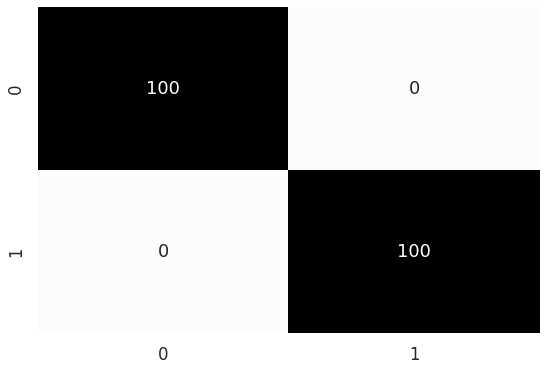

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_RF_grouped_phys = my_model_RF_grouped_phys.predict(population_data_test_phys)
heatconmat(target_test_phys,pred_RF_grouped_phys)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_grouped_phys.score(population_data_test_phys, target_test_phys)))

In [ ]:
# permutation analysis to find feature importance
perm = PermutationImportance(my_model_RF_grouped_phys).fit(population_data_phys, target_phys)
eli5.show_weights(perm, feature_names = population_data_phys.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,sum_FSC_A_5
0 ± 0.0000,sum_FSC_W_4
0 ± 0.0000,sum_FSC_W_3
0 ± 0.0000,sum_FSC_W_2
0 ± 0.0000,sum_FSC_W_1
0 ± 0.0000,sum_FSC_H_7
0 ± 0.0000,sum_FSC_H_6
0 ± 0.0000,sum_FSC_W_6
0 ± 0.0000,sum_FSC_H_4
0 ± 0.0000,sum_FSC_A_2


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_rf_phys_500' # name the model
pickle.dump(my_model_RF_grouped_phys, open(data_path+ model_name+'.pkl', 'wb'))

XBGoost

Hyperparamaters analysis

In [ ]:
xgboost_classification = XGBClassifier(n_jobs=-1)
PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(population_data_phys,target_phys)
print(model_gs.best_params_)

Running the model using the parameters best results

In [ ]:
# Cross validation on the training data
xgboost_classification = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
scores = cross_val_score(xgboost_classification, population_data_phys, target_phys, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_xgboost_grouped_phys = xgboost_classification.fit(population_data_phys, target_phys)
print ('xgboost training Score: {0:2.5f}'.format(my_model_xgboost_grouped_phys.score(population_data_phys, target_phys)))

xgboost Score: 1.00000


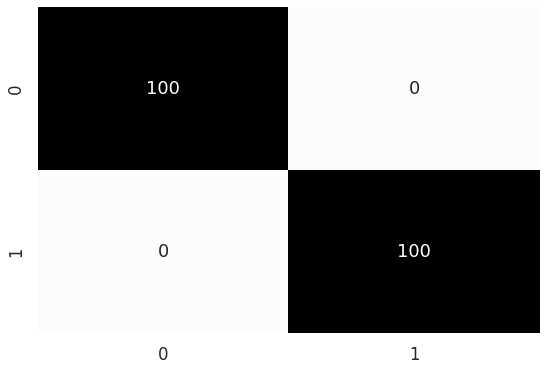

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_xgboost_phys = my_model_xgboost_grouped_phys.predict(population_data_test_phys)
heatconmat(target_test_phys,pred_xgboost_phys)
print ('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_grouped_phys.score(population_data_test_phys, target_test_phys)))

In [ ]:
# permutation analysis to find feature importance
perm_xgboost_phys = PermutationImportance(my_model_xgboost_grouped_phys, random_state=1).fit(population_data_phys, target_phys)
eli5.show_weights(perm_xgboost_phys, feature_names = population_data_phys.columns.tolist())

Weight,Feature
0.4923 ± 0.0435,sum_FSC_W_4
0 ± 0.0000,sum_FSC_A_5
0 ± 0.0000,sum_FSC_W_3
0 ± 0.0000,sum_FSC_W_2
0 ± 0.0000,sum_FSC_W_1
0 ± 0.0000,sum_FSC_H_7
0 ± 0.0000,sum_FSC_H_6
0 ± 0.0000,sum_FSC_W_6
0 ± 0.0000,sum_FSC_H_4
0 ± 0.0000,sum_FSC_A_2


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_xgboost_phys_500' # name the model
pickle.dump(my_model_xgboost_grouped_phys, open(data_path+ model_name+'.pkl', 'wb'))

SVM

Hyperparameter analysis

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(population_data_phys, target_phys)
print(grid_search.best_params_)

In [ ]:
# cross validation on the training data
SVM_phys = svm.SVC(C = 0.001, gamma = 0.001, kernel = 'linear')
scores = cross_val_score(SVM_phys, population_data_phys, target_phys, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# Fitting the model on all the training data
my_model_SVM_grouped_phys = SVM_phys.fit(population_data_phys, target_phys)
print ('SVM Score: {0:2.5f}'.format(my_model_SVM_grouped_phys.score(population_data_phys, target_phys)))

SVM Score: 1.00000


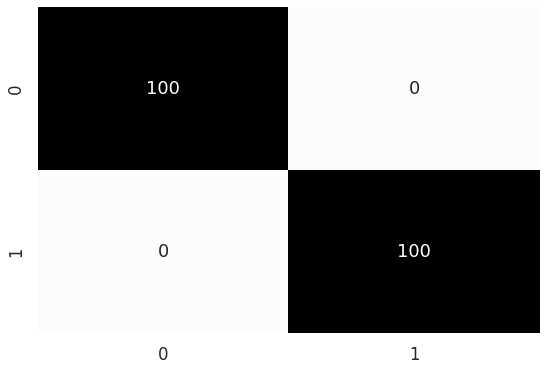

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_SVM_phys = my_model_SVM_grouped_phys.predict(population_data_test_phys)
heatconmat(target_test_phys,pred_SVM_phys)
print ('SVM testing Score: {0:2.5f}'.format(my_model_SVM_grouped_phys.score(population_data_test_phys, target_test_phys)))

In [ ]:
# permutaion analysis to find feature importance
perm_SVM = PermutationImportance(my_model_SVM_grouped_phys, random_state=1).fit(population_data_phys, target_phys)
eli5.show_weights(perm_SVM, feature_names = population_data_phys.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,sum_FSC_A_5
0 ± 0.0000,sum_FSC_W_4
0 ± 0.0000,sum_FSC_W_3
0 ± 0.0000,sum_FSC_W_2
0 ± 0.0000,sum_FSC_W_1
0 ± 0.0000,sum_FSC_H_7
0 ± 0.0000,sum_FSC_H_6
0 ± 0.0000,sum_FSC_W_6
0 ± 0.0000,sum_FSC_H_4
0 ± 0.0000,sum_FSC_A_2


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_SVM_phys_500' # name the model
pickle.dump(my_model_SVM_grouped_phys, open(data_path+ model_name+'.pkl', 'wb'))

In [ ]:
## opening the saved models

# RF
model_name = 'H460_groupkfold_populations_rf_phys_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_rf_phys = pickle.load(a_file)
a_file.close()

# xgboost
model_name = 'H460_groupkfold_populations_xgboost_phys_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_xgboost_phys = pickle.load(a_file)
a_file.close()

# SVM
model_name = 'H460_groupkfold_populations_SVM_phys_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_SVM_phys = pickle.load(a_file)
a_file.close()

# new experiment testing - Batch data

In [ ]:
# reading the batch data- for this example the batch was already preprocessed
Merge_population_batch_phys_filtered = pd.read_csv(data_path +'Merge_population_H460_test_phys_500.csv')

In [ ]:
# separating the data to features and lables
cols_batch = [col for col in Merge_population_batch_phys_filtered.columns if col not in ['Cell_line']]
population_data_batch_phys = Merge_population_batch_phys_filtered[cols_batch]
# assigning the cell identity column as target
target_batch_phys_bins = Merge_population_batch_phys_filtered['Cell_line']

Random forest

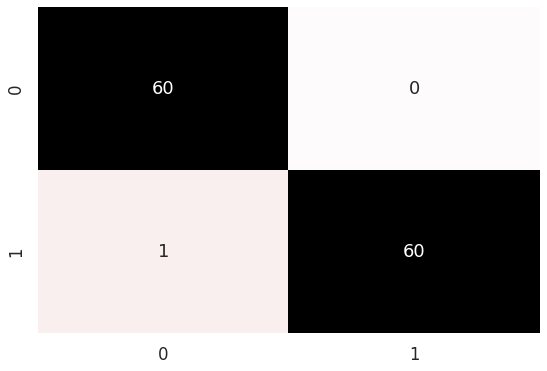

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.98      0.99        61

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



In [ ]:
# prediction and visualiization
pred_random_forest_phys_bins_batch = my_model_RF_grouped_phys.predict(population_data_batch_phys)
heatconmat(target_batch_phys_bins,pred_random_forest_phys_bins_batch)
accuracy = accuracy_score(pred_random_forest_phys_bins_batch.astype(int), target_batch_phys_bins.astype(int))
print(accuracy)

XGBoost

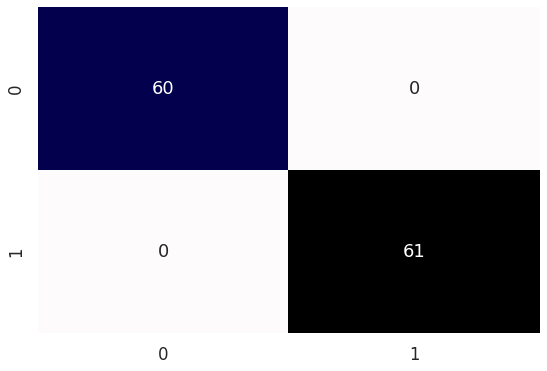

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
# prediction and visualization
pred_xgboost_phys_bins_batch = my_model_xgboost_grouped_phys.predict(population_data_batch_phys)
heatconmat(target_batch_phys_bins,pred_xgboost_phys_bins_batch)
accuracy = accuracy_score(pred_xgboost_phys_bins_batch.astype(int), target_batch_phys_bins.astype(int))
print(accuracy)

SVM

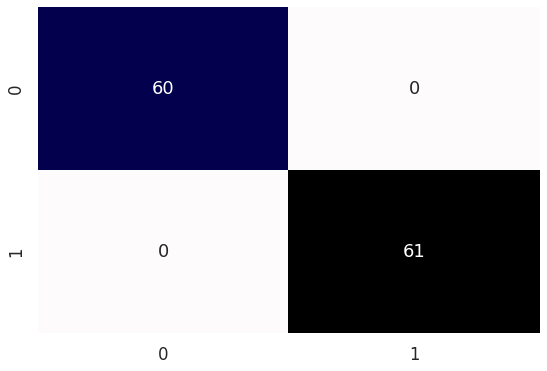

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
# prediction and visualization
pred_SVM_phys_bins_batch = my_model_SVM_grouped_phys.predict(population_data_batch_phys)
heatconmat(target_batch_phys_bins,pred_SVM_phys_bins_batch)
accuracy = accuracy_score(pred_SVM_phys_bins_batch.astype(int), target_batch_phys_bins.astype(int))
aprint(accuracy)

# Dimention reduction - PCA

In [ ]:
# rescale the data
train_data_rescaled_phys = scaler.fit_transform(population_data_phys)
test_data_rescaled_phys = scaler.fit_transform(population_data_test_phys)
batch_data_rescaled_phys = scaler.fit_transform(population_data_batch_phys)


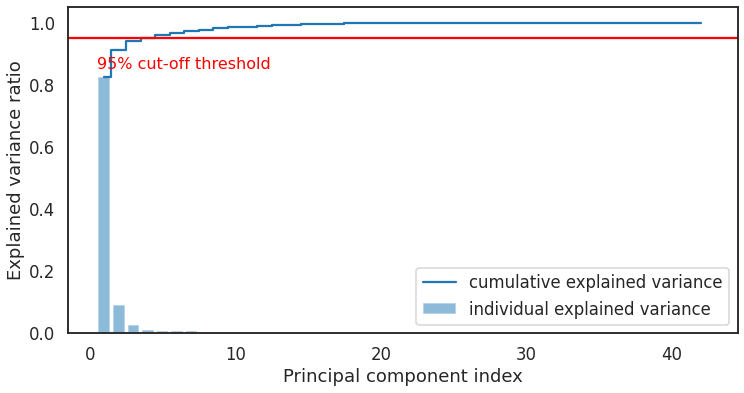

In [ ]:
# displaying the componantes and the data varience they includes for choosing the number of componnets to reduced to
cov_mat = np.cov(train_data_rescaled_phys.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,43), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,43), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.legend(loc='best')
plt.show()

In [ ]:
pca_phys = PCA(n_components=3) # choosing the number of dimentions

# fit and transform data
X_train_pca_phys = pca_phys.fit_transform(train_data_rescaled_phys)
X_test_pca_phys = pca_phys.transform(test_data_rescaled_phys)
X_batch_pca_phys = pca_phys.transform(batch_data_rescaled_phys)


In [ ]:
# How much each original feature contribute to the components
print(pd.DataFrame(np.abs(pca_phys.components_),columns=population_data_phys.columns ,index = ['PC-1', 'PC-2', 'PC-3']))

      sum_FSC_A_1  sum_FSC_A_2  sum_FSC_A_3  sum_FSC_A_4  sum_FSC_A_5  \
PC-1     0.064912     0.119635     0.105732     0.100080     0.139795   
PC-2     0.178837     0.329420     0.187693     0.294261     0.320468   
PC-3     0.385430     0.280125     0.444588     0.177192     0.211139   

      sum_FSC_A_6   sum_FSC_A_7  sum_FSC_H_1  sum_FSC_H_2  sum_FSC_H_3  ...  \
PC-1     0.115520  1.100236e-34     0.088763     0.081004     0.084612  ...   
PC-2     0.198611  5.430536e-29     0.305810     0.287414     0.303819  ...   
PC-3     0.236233  1.635137e-24     0.393402     0.312353     0.268233  ...   

      sum_SSC_H_5  sum_SSC_H_6  sum_SSC_H_7  sum_SSC_W_1  sum_SSC_W_2  \
PC-1     0.226562     0.006371          0.0          0.0          0.0   
PC-2     0.085422     0.002197          0.0          0.0          0.0   
PC-3     0.016263     0.004507          0.0          0.0          0.0   

      sum_SSC_W_3  sum_SSC_W_4  sum_SSC_W_5  sum_SSC_W_6  sum_SSC_W_7  
PC-1          0.0     0.2

In [ ]:
# printing the most contributing original feature for each component
most_important = np.abs(pca_phys.components_).argmax(axis=1)
initial_feature_names = population_data_phys.columns
most_important_names = initial_feature_names[most_important]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(3)}
pca_results = pd.DataFrame(dic.items())
print(pca_results)

     0            1
0  PC1  sum_SSC_A_2
1  PC2  sum_FSC_H_4
2  PC3  sum_FSC_A_3


Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_phys_pca= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_phys_pca,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(X_train_pca_phys, target_phys)
print(model_gridsearch.best_params_)

running the model using best parameters results

In [ ]:
# training the modeln and evaluating its performance on the testing data
random_forest_grouped_phys_no_bins_pca = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
my_model_RF_PCA_phys = random_forest_grouped_phys_no_bins_pca.fit(X_train_pca_phys, target_phys)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_PCA_phys.score(X_test_pca_phys, target_test_phys)))

In [ ]:
# evaluating the model peerformance on the Batch data
pred_random_forest_phys_PCA_batch = my_model_RF_PCA_phys.predict(X_batch_pca_phys)
accuracy = accuracy_score(pred_random_forest_phys_PCA_batch.astype(int), target_batch_phys_bins.astype(int))
accuracy

0.9917355371900827

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification = XGBClassifier(n_jobs=-1)
PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(X_train_pca_phys,target_phys)
print(model_gs.best_params_)

running the model using best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
xgboost_classification_phys_pca = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
my_model_xgboost_PCA_phys = xgboost_classification_phys_pca.fit(X_train_pca_phys, target_phys)
print ('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_PCA_phys.score(X_test_pca_phys, target_test_phys)))

In [ ]:
# evaluating the model performance on the Batch data
pred_xgboost_phys_PCA_batch = my_model_xgboost_PCA_phys.predict(X_batch_pca_phys)
accuracy = accuracy_score(pred_xgboost_phys_PCA_batch.astype(int), target_batch_phys_bins.astype(int))
accuracy

0.9917355371900827

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(X_train_pca_phys,target_phys)
print(grid_search.best_params_)

running the model using best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
SVM_phys_pca = svm.SVC(C = 0.001, gamma = 0.001, kernel = 'linear')
my_model_SVM_PCA_phys = SVM_phys_pca.fit(X_train_pca_phys, target_phys)
print ('SVM Score: {0:2.5f}'.format(my_model_SVM_PCA_phys.score(X_test_pca_phys, target_test_phys)))

In [ ]:
# evaluating the model performance on the Batch data
pred_SVM_phys_PCA_batch = my_model_SVM_PCA_phys.predict(X_batch_pca_phys)
accuracy = accuracy_score(pred_SVM_phys_PCA_batch.astype(int), target_batch_phys_bins.astype(int))
accuracy

0.9917355371900827

# Physiological features without bins

Pop 1 - Training data

In [ ]:
# grouping mean and median pop 1 train FSC and SSC values
grouper_phys_no_bins = Total_pop_1_log.groupby(pd.Grouper(key='population_number'))

FSC_A_mean = grouper_phys_no_bins['FSC_A'].mean().to_frame(name='mean_FSC_A').reset_index()
FSC_A_median = grouper_phys_no_bins['FSC_A'].median().to_frame(name='median_FSC_A').reset_index()

FSC_H_mean = grouper_phys_no_bins['FSC_H'].mean().to_frame(name='mean_FSC_H').reset_index()
FSC_H_median = grouper_phys_no_bins['FSC_H'].median().to_frame(name='median_FSC_H').reset_index()

FSC_W_mean = grouper_phys_no_bins['FSC_W'].mean().to_frame(name='mean_FSC_W').reset_index()
FSC_W_median = grouper_phys_no_bins['FSC_W'].median().to_frame(name='median_FSC_W').reset_index()

SSC_A_mean = grouper_phys_no_bins['SSC_A'].mean().to_frame(name='mean_SSC_A').reset_index()
SSC_A_median = grouper_phys_no_bins['SSC_A'].median().to_frame(name='median_SSC_A').reset_index()

SSC_H_mean = grouper_phys_no_bins['SSC_H'].mean().to_frame(name='mean_SSC_H').reset_index()
SSC_H_median = grouper_phys_no_bins['SSC_H'].median().to_frame(name='median_SSC_H').reset_index()

SSC_W_mean = grouper_phys_no_bins['SSC_W'].mean().to_frame(name='mean_SSC_W').reset_index()
SSC_W_median = grouper_phys_no_bins['SSC_W'].median().to_frame(name='median_SSC_W').reset_index()

In [ ]:
# setting a new array of the grouping data
pop_1_log_grouper_phys_no_bins = [FSC_A_mean, FSC_H_mean, FSC_W_mean, SSC_A_mean, SSC_H_mean, SSC_W_mean, FSC_A_median,
                          FSC_H_median, FSC_W_median, SSC_A_median, SSC_H_median, SSC_W_median
                      ]

In [ ]:
# building a new df of the grouped data
pop_1_log_grouped_phys_no_bins = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_1_log_grouper_phys_no_bins)
pop_1_log_grouped_phys_no_bins['Cell_line'] = 0

Pop 2 - Training data

In [ ]:
# grouping mean and median pop 1 train FSC and SSC values
grouper_phys_no_bins = Total_pop_2_log.groupby(pd.Grouper(key='population_number'))

FSC_A_mean = grouper_phys_no_bins['FSC_A'].mean().to_frame(name='mean_FSC_A').reset_index()
FSC_A_median = grouper_phys_no_bins['FSC_A'].median().to_frame(name='median_FSC_A').reset_index()

FSC_H_mean = grouper_phys_no_bins['FSC_H'].mean().to_frame(name='mean_FSC_H').reset_index()
FSC_H_median = grouper_phys_no_bins['FSC_H'].median().to_frame(name='median_FSC_H').reset_index()

FSC_W_mean = grouper_phys_no_bins['FSC_W'].mean().to_frame(name='mean_FSC_W').reset_index()
FSC_W_median = grouper_phys_no_bins['FSC_W'].median().to_frame(name='median_FSC_W').reset_index()

SSC_A_mean = grouper_phys_no_bins['SSC_A'].mean().to_frame(name='mean_SSC_A').reset_index()
SSC_A_median = grouper_phys_no_bins['SSC_A'].median().to_frame(name='median_SSC_A').reset_index()

SSC_H_mean = grouper_phys_no_bins['SSC_H'].mean().to_frame(name='mean_SSC_H').reset_index()
SSC_H_median = grouper_phys_no_bins['SSC_H'].median().to_frame(name='median_SSC_H').reset_index()

SSC_W_mean = grouper_phys_no_bins['SSC_W'].mean().to_frame(name='mean_SSC_W').reset_index()
SSC_W_median = grouper_phys_no_bins['SSC_W'].median().to_frame(name='median_SSC_W').reset_index()


In [ ]:
# setting a new array of the grouping data
pop_2_log_grouper_phys_no_bins = [FSC_A_mean,FSC_H_mean, FSC_W_mean, SSC_A_mean, SSC_H_mean, SSC_W_mean ,FSC_A_median,
                          FSC_H_median, FSC_W_median, SSC_A_median, SSC_H_median, SSC_W_median
                      ]

In [ ]:
# building a new dfs of the grouped data
pop_2_log_grouped_phys_no_bins = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_2_log_grouper_phys_no_bins)
pop_2_log_grouped_phys_no_bins['Cell_line'] = 1

Pop 1 - Testing data

In [ ]:
# grouping mean and median pop 1 test FSC and SSC values
grouper_phys_no_bins = Total_pop_1_test_log.groupby(pd.Grouper(key='population_number'))

FSC_A_mean = grouper_phys_no_bins['FSC_A'].mean().to_frame(name='mean_FSC_A').reset_index()
FSC_A_median = grouper_phys_no_bins['FSC_A'].median().to_frame(name='median_FSC_A').reset_index()

FSC_H_mean = grouper_phys_no_bins['FSC_H'].mean().to_frame(name='mean_FSC_H').reset_index()
FSC_H_median = grouper_phys_no_bins['FSC_H'].median().to_frame(name='median_FSC_H').reset_index()

FSC_W_mean = grouper_phys_no_bins['FSC_W'].mean().to_frame(name='mean_FSC_W').reset_index()
FSC_W_median = grouper_phys_no_bins['FSC_W'].median().to_frame(name='median_FSC_W').reset_index()

SSC_A_mean = grouper_phys_no_bins['SSC_A'].mean().to_frame(name='mean_SSC_A').reset_index()
SSC_A_median = grouper_phys_no_bins['SSC_A'].median().to_frame(name='median_SSC_A').reset_index()

SSC_H_mean = grouper_phys_no_bins['SSC_H'].mean().to_frame(name='mean_SSC_H').reset_index()
SSC_H_median = grouper_phys_no_bins['SSC_H'].median().to_frame(name='median_SSC_H').reset_index()

SSC_W_mean = grouper_phys_no_bins['SSC_W'].mean().to_frame(name='mean_SSC_W').reset_index()
SSC_W_median = grouper_phys_no_bins['SSC_W'].median().to_frame(name='median_SSC_W').reset_index()

In [ ]:
# setting a new array of the grouping data
pop_1_test_log_grouper_phys_no_bins = [FSC_A_mean, FSC_H_mean, FSC_W_mean, SSC_A_mean, SSC_H_mean, SSC_W_mean, FSC_A_median,
                          FSC_H_median, FSC_W_median, SSC_A_median, SSC_H_median, SSC_W_median]

In [ ]:
# building a new df of the grouped data
pop_1_test_log_grouped_phys_no_bins = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_1_test_log_grouper_phys_no_bins)
pop_1_test_log_grouped_phys_no_bins['Cell_line'] = 0

Pop 2 - Testing data

In [ ]:
# grouping mean and median pop 1 test FSC and SSC values
grouper_phys_no_bins = Total_pop_2_test_log.groupby(pd.Grouper(key='population_number'))

FSC_A_mean = grouper_phys_no_bins['FSC_A'].mean().to_frame(name='mean_FSC_A').reset_index()
FSC_A_median = grouper_phys_no_bins['FSC_A'].median().to_frame(name='median_FSC_A').reset_index()

FSC_H_mean = grouper_phys_no_bins['FSC_H'].mean().to_frame(name='mean_FSC_H').reset_index()
FSC_H_median = grouper_phys_no_bins['FSC_H'].median().to_frame(name='median_FSC_H').reset_index()

FSC_W_mean = grouper_phys_no_bins['FSC_W'].mean().to_frame(name='mean_FSC_W').reset_index()
FSC_W_median = grouper_phys_no_bins['FSC_W'].median().to_frame(name='median_FSC_W').reset_index()

SSC_A_mean = grouper_phys_no_bins['SSC_A'].mean().to_frame(name='mean_SSC_A').reset_index()
SSC_A_median = grouper_phys_no_bins['SSC_A'].median().to_frame(name='median_SSC_A').reset_index()

SSC_H_mean = grouper_phys_no_bins['SSC_H'].mean().to_frame(name='mean_SSC_H').reset_index()
SSC_H_median = grouper_phys_no_bins['SSC_H'].median().to_frame(name='median_SSC_H').reset_index()

SSC_W_mean = grouper_phys_no_bins['SSC_W'].mean().to_frame(name='mean_SSC_W').reset_index()
SSC_W_median = grouper_phys_no_bins['SSC_W'].median().to_frame(name='median_SSC_W').reset_index()

In [ ]:
# setting a new array of the grouping data
pop_2_test_log_grouper_phys_no_bins = [FSC_A_mean,FSC_H_mean, FSC_W_mean, SSC_A_mean, SSC_H_mean, SSC_W_mean ,FSC_A_median,
                          FSC_H_median, FSC_W_median, SSC_A_median, SSC_H_median, SSC_W_median]

In [ ]:
# building a new df of the grouped data
pop_2_test_log_grouped_phys_no_bins = reduce(lambda left, right: pd.merge(left, right, on='population_number'), pop_2_test_log_grouper_phys_no_bins)
pop_2_test_log_grouped_phys_no_bins['Cell_line'] = 1

In [ ]:
# merging the training data of the two populations
populations_df_list = [pop_1_log_grouped_phys_no_bins, pop_2_log_grouped_phys_no_bins]
Merge_population_phys_no_bins = pd.DataFrame()
for df in populations_df_list:
    Merge_population_phys_no_bins = pd.concat([Merge_population_phys_no_bins, df], ignore_index=True)

Merge_population_phys_no_bins.drop('population_number', axis = 1, inplace = True)

In [ ]:
# merging the testing data of the two populations
populations_test_df_list = [pop_1_test_log_grouped_phys_no_bins, pop_2_test_log_grouped_phys_no_bins]
Merge_population_test_phys_no_bins = pd.DataFrame()
for df in populations_test_df_list:
    Merge_population_test_phys_no_bins = pd.concat([Merge_population_test_phys_no_bins, df], ignore_index=True)

Merge_population_test_phys_no_bins.drop('population_number', axis = 1, inplace = True)

running the models

In [ ]:
# separating the training features from the lables
cols = [col for col in Merge_population_phys_no_bins.columns if col not in ['Cell_line']]
population_data_phys_no_bins = Merge_population_phys_no_bins[cols]

# assigning the cell identity column as target
target_phys_no_bins = Merge_population_phys_no_bins['Cell_line']
target_group = ['0', '1']

In [ ]:
## if the data includes only one sample per population

## split to training and testing
#X_train, X_test, y_train, y_test = train_test_split(All_data_train, target, test_size=0.3, random_state=42) # make sure to change names as needed

In [ ]:
# Do not run if the data includes only one sample per population
# separating the testing features from the lables
cols_test = [col for col in Merge_population_test_phys_no_bins.columns if col not in ['Cell_line']]
population_data_test_phys_no_bins = Merge_population_test_phys_no_bins[cols_test]
# assigning the cell identity column as target
target_test_phys_no_bins = Merge_population_test_phys_no_bins['Cell_line']
target_group = ['0', '1']

Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_phys_no_bins= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_phys_no_bins,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(population_data_phys_no_bins, target_phys_no_bins)
print(model_gridsearch.best_params_)

running the model using the best parameters results

In [ ]:
# cross validation on the training data
random_forest_grouped_phys_no_bins = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
scores = cross_val_score(random_forest_grouped_phys_no_bins, population_data_phys_no_bins, target_phys_no_bins, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model using all the training data
my_model_RF_grouped_phys_no_bins = random_forest_grouped_phys_no_bins.fit(population_data_phys_no_bins, target_phys_no_bins)
print ('Random Forest training Score: {0:2.5f}'.format(my_model_RF_grouped_phys_no_bins.score(population_data_phys_no_bins, target_phys_no_bins)))

Random Forest Score: 1.00000


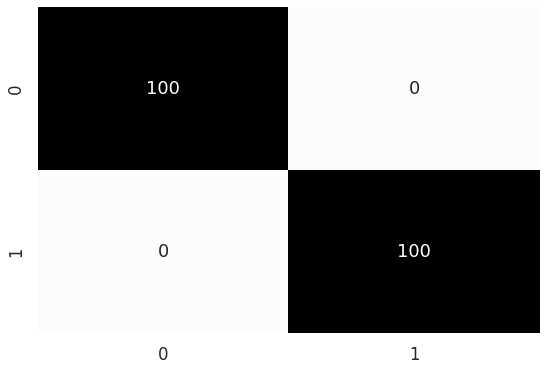

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_RF_grouped_phys_no_bins = my_model_RF_grouped_phys_no_bins.predict(population_data_test_phys_no_bins)
heatconmat(target_test_phys_no_bins,pred_RF_grouped_phys_no_bins)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_grouped_phys_no_bins.score(population_data_test_phys_no_bins, target_test_phys_no_bins)))

In [ ]:
# permutation analysis to find feature importance
perm = PermutationImportance(my_model_RF_grouped_phys_no_bins).fit(population_data_phys_no_bins, target_phys_no_bins)
eli5.show_weights(perm, feature_names = population_data_phys_no_bins.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,median_SSC_W
0 ± 0.0000,median_SSC_H
0 ± 0.0000,median_SSC_A
0 ± 0.0000,median_FSC_W
0 ± 0.0000,median_FSC_H
0 ± 0.0000,median_FSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H
0 ± 0.0000,mean_SSC_A
0 ± 0.0000,mean_FSC_W


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_rf_phys_no_bins_500' # name the model
pickle.dump(my_model_RF_grouped_phys_no_bins, open(data_path+ model_name+'.pkl', 'wb'))

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_phys_no_bins = XGBClassifier(n_jobs=-1)

PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_phys_no_bins,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(population_data_phys_no_bins,target_phys_no_bins)
print(model_gs.best_params_)

running the model using the best parameters results

In [ ]:
# crosss validation on the training data
xgboost_classification_phys_no_bins = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 1, n_jobs=-1)
scores = cross_val_score(xgboost_classification_phys_no_bins, population_data_phys_no_bins, target_phys_no_bins, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# Fitting the model on all the training data
my_model_xgboost_grouped_phys_no_bins = xgboost_classification_phys_no_bins.fit(population_data_phys_no_bins, target_phys_no_bins)
print ('xgboost training Score: {0:2.5f}'.format(my_model_xgboost_grouped_phys_no_bins.score(population_data_phys_no_bins, target_phys_no_bins)))

xgboost Score: 1.00000


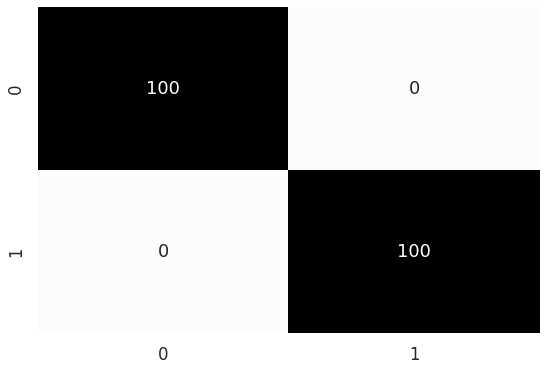

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and validation
pred_xgboost_phys_no_bins = my_model_xgboost_grouped_phys_no_bins.predict(population_data_test_phys_no_bins)
heatconmat(target_test_phys_no_bins,pred_xgboost_phys_no_bins)
print ('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_grouped_phys_no_bins.score(population_data_test_phys_no_bins, target_test_phys_no_bins)))

In [ ]:
# permutation analysis to find features importance
perm_xgboost_phys_no_bins = PermutationImportance(my_model_xgboost_grouped_phys_no_bins, random_state=1).fit(population_data_phys_no_bins, target_phys_no_bins)
eli5.show_weights(perm_xgboost_phys_no_bins, feature_names = population_data_phys_no_bins.columns.tolist())

Weight,Feature
0.5027 ± 0.0271,mean_FSC_W
0 ± 0.0000,median_SSC_W
0 ± 0.0000,median_SSC_H
0 ± 0.0000,median_SSC_A
0 ± 0.0000,median_FSC_W
0 ± 0.0000,median_FSC_H
0 ± 0.0000,median_FSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H
0 ± 0.0000,mean_SSC_A


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_xgboost_phys_no_bins_500' # name the model
pickle.dump(my_model_xgboost_grouped_phys_no_bins, open(data_path+ model_name+'.pkl', 'wb'))

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(population_data_phys_no_bins, target_phys_no_bins)
print(grid_search.best_params_)

running the model using the best parameters results

In [ ]:
# cross validation analysis
SVM_phys_no_bins = svm.SVC(C = 0.001, gamma = 0.01, kernel = 'poly')
scores = cross_val_score(SVM_phys_no_bins, population_data_phys_no_bins, target_phys_no_bins, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# Fitting the model on all the training data
my_model_SVM_grouped_phys_no_bins = SVM_phys_no_bins.fit(population_data_phys_no_bins, target_phys_no_bins)
print ('SVM training Score: {0:2.5f}'.format(my_model_xgboost_grouped_phys_no_bins.score(population_data_phys_no_bins, target_phys_no_bins)))

SVM Score: 1.00000


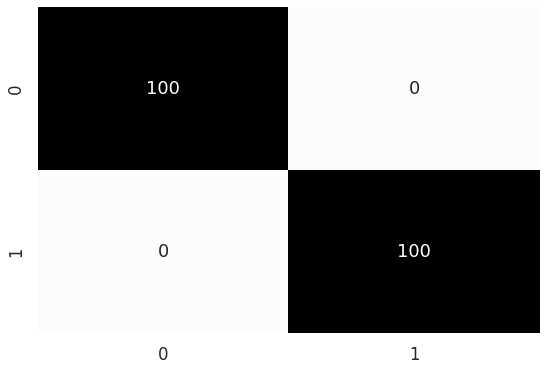

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_SVM_phys_no_bins = my_model_SVM_grouped_phys_no_bins.predict(population_data_test_phys_no_bins)
heatconmat(target_test_phys_no_bins,pred_xgboost_phys_no_bins)
print ('SVM testing Score: {0:2.5f}'.format(my_model_SVM_grouped_phys_no_bins.score(population_data_test_phys_no_bins, target_test_phys_no_bins)))

In [ ]:
# permutation analysis to find features importance
perm_SVM = PermutationImportance(my_model_SVM_grouped_phys_no_bins, random_state=1).fit(population_data_phys_no_bins, target_phys_no_bins)
eli5.show_weights(perm_SVM, feature_names = population_data_phys_no_bins.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,median_SSC_W
0 ± 0.0000,median_SSC_H
0 ± 0.0000,median_SSC_A
0 ± 0.0000,median_FSC_W
0 ± 0.0000,median_FSC_H
0 ± 0.0000,median_FSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H
0 ± 0.0000,mean_SSC_A
0 ± 0.0000,mean_FSC_W


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_SVM_phys_no_bins_500' # name the model
pickle.dump(my_model_SVM_grouped_phys_no_bins, open(data_path+ model_name+'.pkl', 'wb'))

# new experiment testing - Batch data

In [ ]:
# Reading the Batch data
Merge_population_batch_phys_no_bins = pd.read_csv(data_path +'Merge_population_H460_test_phys_no_bins_500.csv')

In [ ]:
# separating the data to features and lables
cols_batch = [col for col in Merge_population_batch_phys_no_bins.columns if col not in ['Cell_line']]
population_data_batch_phys_no_bins = Merge_population_batch_phys_no_bins[cols]
# assigning the cell identity column as target
target_batch_phys_no_bins = Merge_population_batch_phys_no_bins['Cell_line']

Random forest

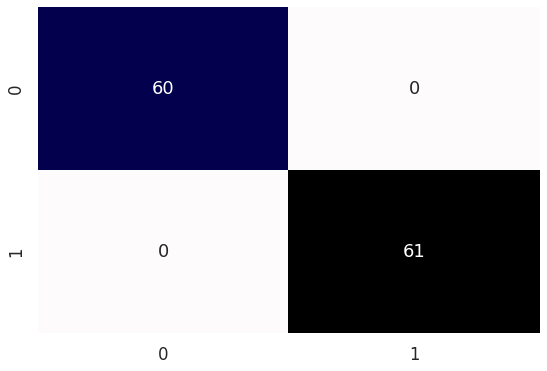

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
# prediction and visualization
pred_phys_no_bins_rf_batch = my_model_RF_grouped_phys_no_bins.predict(population_data_batch_phys_no_bins)
heatconmat(target_batch_phys_no_bins, pred_phys_no_bins_rf_batch)
accuracy = accuracy_score(pred_phys_no_bins_rf_batch.astype(int), target_batch_phys_no_bins.astype(int))
print(accuracy)

XGBoost

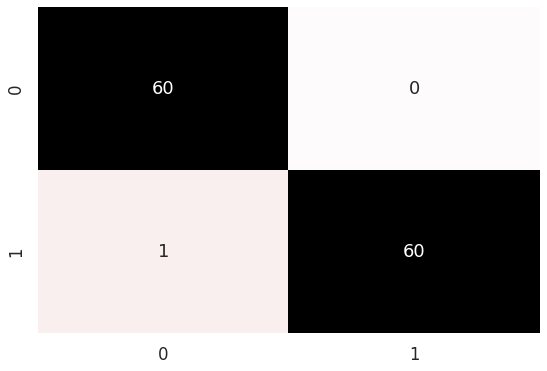

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.98      0.99        61

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



In [ ]:
pred_phys_no_bins_xgboost_batch = my_model_xgboost_grouped_phys_no_bins.predict(population_data_batch_phys_no_bins)
heatconmat(target_batch_phys_no_bins,pred_phys_no_bins_xgboost_batch)
accuracy = accuracy_score(pred_phys_no_bins_xgboost_batch.astype(int), target_batch_phys_no_bins.astype(int))
print(accuracy)

SVM

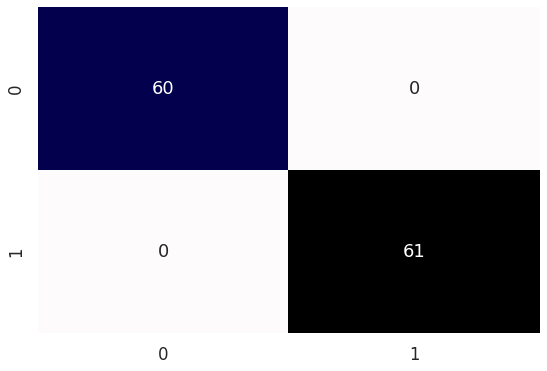

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_phys_no_bins_SVM_batch = my_model_SVM_grouped_phys_no_bins.predict(population_data_batch_phys_no_bins)
heatconmat(target_batch_phys_no_bins, pred_phys_no_bins_SVM_batch)
accuracy = accuracy_score(pred_phys_no_bins_SVM_batch.astype(int), target_batch_phys_no_bins.astype(int))
print(accuracy)

# Dimention reduction - PCA

In [ ]:
# rescale the data for pca
train_data_rescaled_phys_no_bins = scaler.fit_transform(population_data_phys_no_bins)
test_data_rescaled_phys_no_bins = scaler.fit_transform(population_data_test_phys_no_bins)
batch_data_rescaled_phys_no_bins = scaler.fit_transform(population_data_batch_phys_no_bins)


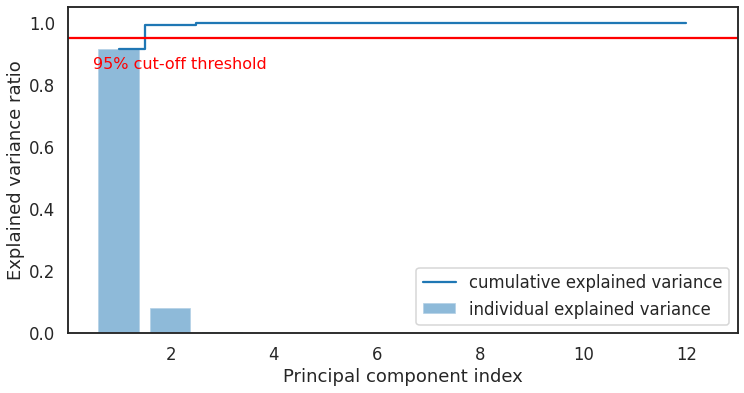

In [ ]:
# displaying the componantes and the data varience they includes for choosing the number of componnets to reduced to
cov_mat = np.cov(train_data_rescaled_phys_no_bins.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,13), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,13), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.legend(loc='best')
plt.show()

In [ ]:
pca_phys_no_bins = PCA(n_components=2) # choosing the number of dimentions

# fit and transform data
X_train_pca_phys_no_bins = pca_phys_no_bins.fit_transform(train_data_rescaled_phys_no_bins)
X_test_pca_phys_no_bins = pca_phys_no_bins.transform(test_data_rescaled_phys_no_bins)
X_batch_pca_phys_no_bins = pca_phys_no_bins.transform(batch_data_rescaled_phys_no_bins)


In [ ]:
# How much each original feature contribute to the components

print(pd.DataFrame(np.abs(pca_phys_no_bins.components_),columns=population_data_phys_no_bins.columns ,index = ['PC-1', 'PC-2']))

      mean_FSC_A  mean_FSC_H  mean_FSC_W  mean_SSC_A  mean_SSC_H  mean_SSC_W  \
PC-1    0.160343    0.110642    0.302770    0.368221    0.367615    0.329942   
PC-2    0.460746    0.484494    0.031824    0.139726    0.146858    0.092432   

      median_FSC_A  median_FSC_H  median_FSC_W  median_SSC_A  median_SSC_H  \
PC-1      0.151806      0.106980      0.304911      0.355523      0.357514   
PC-2      0.458888      0.493658      0.020096      0.135484      0.146469   

      median_SSC_W  
PC-1      0.330328  
PC-2      0.088556  


In [ ]:
# printing the most contributing original feature for each component
most_important = np.abs(pca_phys_no_bins.components_).argmax(axis=1)
initial_feature_names = population_data_phys_no_bins.columns
most_important_names = initial_feature_names[most_important]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(2)}
pca_results = pd.DataFrame(dic.items())
print(pca_results)

     0             1
0  PC1    mean_SSC_A
1  PC2  median_FSC_H


Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_phys_no_bis= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_phys_no_bis,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(X_train_pca_phys_no_bins, target_phys_no_bins)
print(model_gridsearch.best_params_)

running the model using the best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
random_forest_grouped_phys_no_bins = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 5, n_estimators = 1000, n_jobs=-1)
my_model_RF_PCA_phys_no_bins = random_forest_grouped_phys_no_bins.fit(X_train_pca_phys_no_bins, target_phys_no_bins)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_PCA_phys_no_bins.score(X_test_pca_phys_no_bins, target_test_phys_no_bins)))

In [ ]:
# evaluating the model performance on the Batch data
pred_random_forest_phys_no_bins_PCA_batch = my_model_RF_PCA_phys_no_bins.predict(X_batch_pca_phys_no_bins)
accuracy = accuracy_score(pred_random_forest_phys_no_bins_PCA_batch.astype(int), target_batch_phys_no_bins.astype(int))
accuracy

0.6859504132231405

XGBoost

In [ ]:
xgboost_classification = XGBClassifier(n_jobs=-1)
PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(X_train_pca_phys_no_bins, target_phys_no_bins)

print(model_gs.best_params_)

running model using the best paramaters results

In [ ]:
# training the model and evaluating its performance on the testing data
xgboost_classification_phys_no_bins_pca = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
my_model_xgboost_PCA_phys_no_bins = xgboost_classification_phys_no_bins_pca.fit(X_train_pca_phys_no_bins, target_phys_no_bins)
print ('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_PCA_phys_no_bins.score(X_test_pca_phys_no_bins, target_test_phys_no_bins)))

In [ ]:
# evaluating the model performance on the Batch data
pred_xgboost_phys_no_bins_PCA_batch = my_model_xgboost_PCA_phys_no_bins.predict(X_batch_pca_phys_no_bins)
accuracy = accuracy_score(pred_xgboost_phys_no_bins_PCA_batch.astype(int), target_batch_phys_no_bins.astype(int))
accuracy

1.0

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(X_train_pca_phys_no_bins, target_phys_no_bins)
print(grid_search.best_params_)

running the model using best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
SVM_phys_no_bins = svm.SVC(C = 0.001, gamma =0.001, kernel = 'linear')
my_model_SVM_PCA_phys_no_bins = SVM_phys_no_bins.fit(X_train_pca_phys_no_bins, target_phys_no_bins)
print ('SVM Score: {0:2.5f}'.format(my_model_SVM_PCA_phys_no_bins.score(X_test_pca_phys_no_bins, target_test_phys_no_bins)))

In [ ]:
# evaluating the model performance on the Batch data
pred_SVM_phys_no_bins_PCA_batch = my_model_SVM_PCA_phys_no_bins.predict(X_batch_pca_phys_no_bins)
accuracy = accuracy_score(pred_SVM_phys_no_bins_PCA_batch.astype(int), target_batch_phys_no_bins.astype(int))
accuracy

1.0

## No SSC

In [ ]:
# setting the training dataset
Merge_population_FSC = Merge_population_phys_no_bins.drop(['mean_SSC_A', 'mean_SSC_H', 'mean_SSC_W',
                                               'median_SSC_A','median_SSC_H','median_SSC_W'], axis = 1)

Merge_population_FSC.to_csv('H460_Merge_population_FSC.csv')

,mean_FSC_A,mean_FSC_H,mean_FSC_W,median_FSC_A,median_FSC_H,median_FSC_W,Cell_line
0,10.507752,10.111106,11.487000,10.487589,10.109322,11.477874,0
1,10.473732,10.080257,11.483830,10.468478,10.083014,11.476759,0
2,10.439020,10.036956,11.492420,10.451490,10.064750,11.477704,0
3,10.491569,10.089079,11.492845,10.472490,10.090382,11.479196,0
4,10.490274,10.091143,11.489487,10.479072,10.065308,11.482977,0
...,...,...,...,...,...,...,...
595,11.202718,10.678702,11.614371,11.207537,10.678422,11.605178,1
596,11.156532,10.643195,11.603692,11.180240,10.658376,11.602348,1
597,11.151739,10.643918,11.598176,11.160360,10.643971,11.598168,1
598,11.204371,10.684381,11.610345,11.203125,10.660243,11.601918,1


In [ ]:
# setting the testing dataset
Merge_population_test_FSC = Merge_population_test_phys_no_bins.drop(['mean_SSC_A', 'mean_SSC_H', 'mean_SSC_W',
                                               'median_SSC_A','median_SSC_H','median_SSC_W'], axis = 1)

In [ ]:
# separating the training features from the lables
cols = [col for col in Merge_population_FSC.columns if col not in ['Cell_line']]
population_data_FSC = Merge_population_FSC[cols] # features

# assigning the cell identity column as target
target_FSC = Merge_population_FSC['Cell_line'] # lables
target_group = ['0', '1']

In [ ]:
## if the data includes only one sample per population

## split to training and testing
#X_train, X_test, y_train, y_test = train_test_split(All_data_train, target, test_size=0.3, random_state=42) # make sure to change names as needed

In [ ]:
# do not run if the data includes only one sample per population

# separating the testing features from the lables
cols_test = [col for col in Merge_population_test_FSC.columns if col not in ['Cell_line']]
population_data_test_FSC = Merge_population_test_FSC[cols_test] # features

#assigning the Oppurtunity Result column as target
target_test_FSC = Merge_population_test_FSC['Cell_line'] # labels
target_group = ['0', '1']

Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_FSC= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_FSC,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(population_data_FSC, target_FSC)
print(model_gridsearch.best_params_)

running the model using best parameters results

In [ ]:
# cross validation on the training data
random_forest_grouped_FSC = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
scores = cross_val_score(random_forest_grouped_FSC, population_data_FSC, target_FSC, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validataion Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model fon all the training data
my_model_RF_grouped_FSC = random_forest_grouped_FSC.fit(population_data_FSC, target_FSC)
print ('Random Forest training Score: {0:2.5f}'.format(my_model_RF_grouped_FSC.score(population_data_FSC, target_FSC)))

Random Forest Score: 1.00000


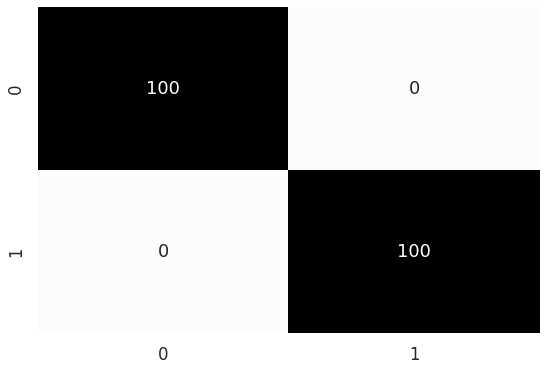

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_RF_grouped_FSC = my_model_RF_grouped_FSC.predict(population_data_test_FSC)
heatconmat(target_test_FSC,pred_RF_grouped_FSC)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_grouped_FSC.score(population_data_test_FSC, target_test_FSC)))

In [ ]:
# permutation analysis to find feature importance
perm = PermutationImportance(my_model_RF_grouped_FSC).fit(population_data_FSC, target_FSC)
eli5.show_weights(perm, feature_names = population_data_FSC.columns.tolist())

Weight,Feature
0.2383 ± 0.0067,mean_FSC_W
0 ± 0.0000,median_FSC_W
0 ± 0.0000,median_FSC_H
0 ± 0.0000,median_FSC_A
0 ± 0.0000,mean_FSC_H
0 ± 0.0000,mean_FSC_A


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_rf_FSC_500' # name the model
pickle.dump(my_model_RF_grouped_FSC, open(data_path + model_name+'.pkl', 'wb'))

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_FSC = XGBClassifier(n_jobs=-1)

PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_FSC,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(population_data_FSC,target_FSC)

print(model_gs.best_params_)

In [ ]:
# cross validation on the training data
xgboost_classification_FSC = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
scores = cross_val_score(xgboost_classification_FSC, population_data_FSC, target_FSC, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_xgboost_grouped_FSC = xgboost_classification.fit(population_data_FSC, target_FSC)
print ('xgboost training Score: {0:2.5f}'.format(my_model_xgboost_grouped_FSC.score(population_data_FSC, target_FSC)))

xgboost Score: 1.00000


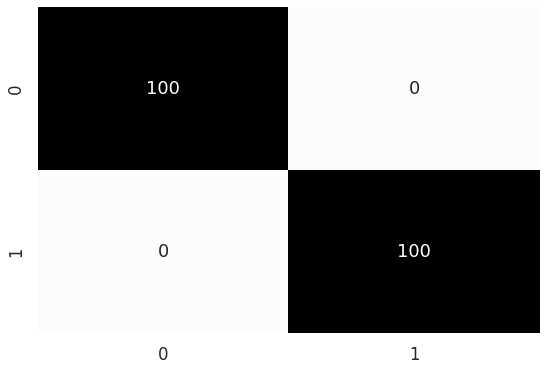

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_xgboost_FSC = my_model_xgboost_grouped_FSC.predict(population_data_test_FSC)
heatconmat(target_test_FSC,pred_xgboost_FSC)
print('xgboost testing
Score: {0:2.5f}'.format(my_model_xgboost_grouped_FSC.score(population_data_test_FSC, target_test_FSC)))

In [ ]:
# permutation analysis to find features importance
perm_xgboost_FSC = PermutationImportance(my_model_xgboost_grouped_FSC, random_state=1).fit(population_data_FSC, target_FSC)
eli5.show_weights(perm_xgboost_FSC, feature_names = population_data_FSC.columns.tolist())

Weight,Feature
0.1417 ± 0.0126,mean_FSC_W
0.0010 ± 0.0027,median_FSC_W
0 ± 0.0000,median_FSC_H
0 ± 0.0000,median_FSC_A
0 ± 0.0000,mean_FSC_H
0 ± 0.0000,mean_FSC_A


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_xgboost_FSC_500' # name the model
pickle.dump(my_model_xgboost_grouped_FSC, open(data_path+ model_name+'.pkl', 'wb'))

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(population_data_FSC, target_FSC)
print(grid_search.best_params_)

running the models using best parameters results

In [ ]:
# cross validation on the training data
SVM_FSC = svm.SVC(C = 0.001, gamma = 0.1, kernel='poly')
scores = cross_val_score(SVM_FSC, population_data_FSC, target_FSC, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_SVM_grouped_FSC = SVM_FSC.fit(population_data_FSC, target_FSC)
print ('SVM training Score: {0:2.5f}'.format(my_model_SVM_grouped_FSC.score(population_data_FSC, target_FSC)))

SVM Score: 1.00000


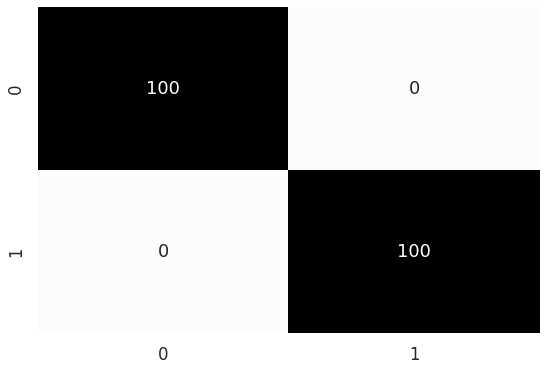

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_SVM_FSC = my_model_SVM_grouped_FSC.predict(population_data_test_FSC)
heatconmat(target_test_FSC,pred_SVM_FSC)
print ('SVM testing Score: {0:2.5f}'.format(my_model_SVM_grouped_FSC.score(population_data_test_FSC, target_test_FSC)))

In [ ]:
# permutation analysis to find features importance
perm_SVM = PermutationImportance(my_model_SVM_grouped_FSC, random_state=1).fit(population_data_FSC, target_FSC)
eli5.show_weights(perm_SVM, feature_names = population_data_FSC.columns.tolist())

Weight,Feature
0.1873 ± 0.0235,mean_FSC_A
0.0587 ± 0.0124,median_FSC_W
0.0497 ± 0.0154,median_FSC_A
0.0453 ± 0.0090,median_FSC_H
0.0183 ± 0.0180,mean_FSC_H
0.0117 ± 0.0042,mean_FSC_W


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_SVM_FSC_500' # name the model
pickle.dump(my_model_SVM_grouped_FSC, open(data_path+ model_name+'.pkl', 'wb'))

# new experiment testing - Batch data

In [ ]:
# reading the batch data
Merge_population_batch_FSC = pd.read_csv(data_path +'Merge_population_H460_test_FSC_500.csv')

In [ ]:
# separating the training features from the lables
cols_batch = [col for col in Merge_population_batch_FSC.columns if col not in ['Cell_line']]
population_data_FSC_batch = Merge_population_batch_FSC[cols] # features

# assigning the cell identity column as target
target_batch_FSC = Merge_population_batch_FSC['Cell_line'] # labels

Random forest

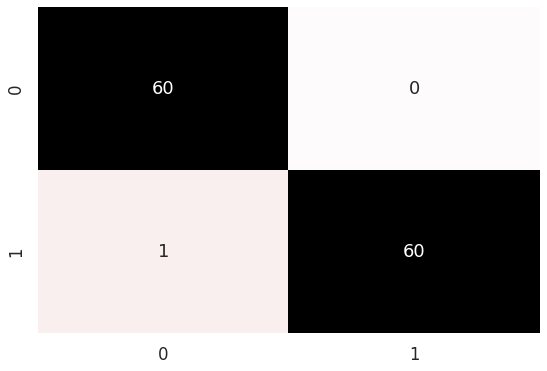

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.98      0.99        61

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



In [ ]:
pred_batch_FSC_rf = my_model_RF_grouped_FSC.predict(population_data_FSC_batch)
heatconmat(target_batch_FSC,pred_batch_FSC_rf)
accuracy = accuracy_score(pred_batch_FSC_rf.astype(int), target_batch_FSC.astype(int))
print(accuracy)

XGBoost

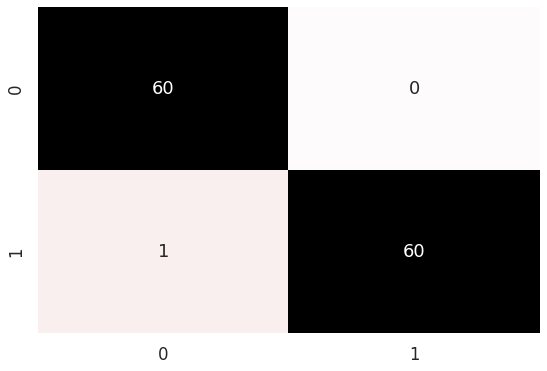

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.98      0.99        61

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



In [ ]:
pred_batch_FSC_xgboost = my_model_xgboost_grouped_FSC.predict(population_data_FSC_batch)
heatconmat(target_batch_FSC,pred_batch_FSC_xgboost)
accuracy = accuracy_score(pred_batch_FSC_xgboost.astype(int), target_batch_FSC.astype(int))
print(accuracy)

SVM

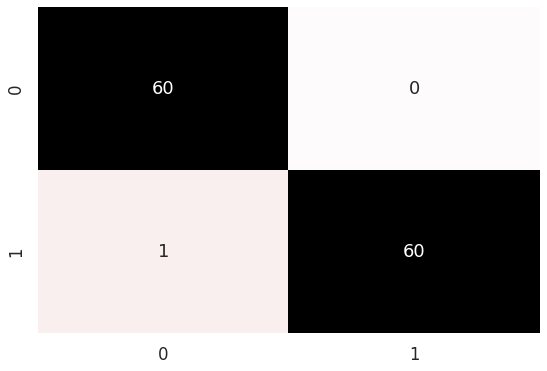

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.98      0.99        61

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



In [ ]:
pred_batch_FSC_SVM = my_model_SVM_grouped_FSC.predict(population_data_FSC_batch)
heatconmat(target_batch_FSC,pred_batch_FSC_SVM)
accuracy = accuracy_score(pred_batch_FSC_SVM.astype(int), target_batch_FSC.astype(int))
print(accuracy)

# Dimention reduction - PCA

In [ ]:
# rescale the data for pca
train_data_rescaled_FSC = scaler.fit_transform(population_data_FSC)
test_data_rescaled_FSC = scaler.fit_transform(population_data_test_FSC)
batch_data_rescaled_FSC = scaler.fit_transform(population_data_FSC_batch)


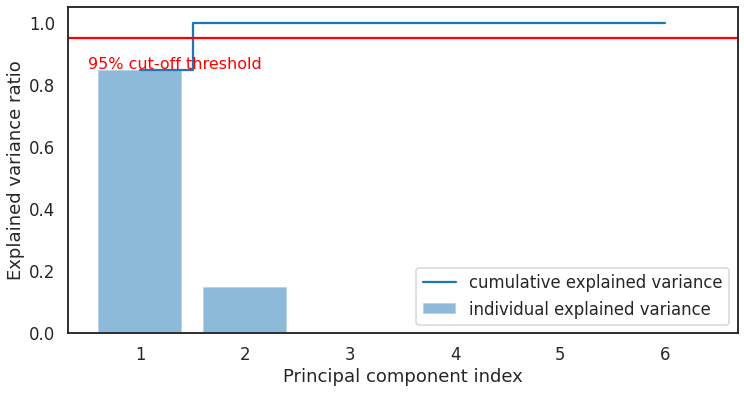

In [ ]:
# displaying the componantes and the data varience they includes for choosing the number of componnets to reduced to
cov_mat = np.cov(train_data_rescaled_FSC.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,7), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.legend(loc='best')
plt.show()

In [ ]:
pca_FSC = PCA(n_components=2) # choosing the number of dimentions

# fit and transform data
X_train_pca_FSC = pca_FSC.fit_transform(train_data_rescaled_FSC)
X_test_pca_FSC = pca_FSC.transform(test_data_rescaled_FSC)
X_batch_pca_FSC = pca_FSC.transform(batch_data_rescaled_FSC)


In [ ]:
# How much each original feature contribute to the components

print(pd.DataFrame(np.abs(pca_FSC.components_),columns=population_data_FSC.columns ,index = ['PC-1', 'PC-2']))

      mean_FSC_A  mean_FSC_H  mean_FSC_W  median_FSC_A  median_FSC_H  \
PC-1    0.368278    0.285549    0.537270      0.352939      0.280811   
PC-2    0.320933    0.429039    0.438598      0.332138      0.446441   

      median_FSC_W  
PC-1      0.539216  
PC-2      0.459276  


In [ ]:
# printing the most contributing original feature for each component
most_important = np.abs(pca_FSC.components_).argmax(axis=1)
initial_feature_names = population_data_FSC.columns
most_important_names = initial_feature_names[most_important]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(2)}
pca_results = pd.DataFrame(dic.items())
print(pca_results)

     0             1
0  PC1  median_FSC_W
1  PC2  median_FSC_W


Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_FSC_pca= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_FSC_pca,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(X_train_pca_FSC, target_FSC)
print(model_gridsearch.best_params_)

# running the model using best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
random_forest_grouped_FSC_pca = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
my_model_RF_PCA_FSC = random_forest_grouped_FSC_pca.fit(X_train_pca_FSC, target_FSC)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_PCA_FSC.score(X_test_pca_FSC, target_test_FSC)))

In [ ]:
# evaluating the model performance on the Batch data
pred_random_forest_FSC_PCA_batch = my_model_RF_PCA_FSC.predict(X_batch_pca_FSC)
accuracy = accuracy_score(pred_random_forest_FSC_PCA_batch.astype(int), target_batch_FSC.astype(int))
accuracy

0.9917355371900827

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_FSC_pca = XGBClassifier(n_jobs=-1)

PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_FSC_pca,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(X_train_pca_FSC, target_FSC)
print(model_gs.best_params_)

running the model using the best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
xgboost_classification_FSC_pca = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.75, n_jobs=-1)
my_model_xgboost_PCA_FSC = xgboost_classification_FSC_pca.fit(X_train_pca_FSC, target_FSC)
print ('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_PCA_FSC.score(X_test_pca_FSC, target_test_FSC)))

In [ ]:
# evaluating the model performance on the Batch data
pred_xgboost_FSC_PCA_batch = my_model_xgboost_PCA_FSC.predict(X_batch_pca_FSC)
accuracy = accuracy_score(pred_xgboost_FSC_PCA_batch.astype(int), target_batch_FSC.astype(int))
accuracy

0.9917355371900827

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(X_train_pca_FSC, target_FSC)
print(grid_search.best_params_)

running the model using best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
SVM_FSC = svm.SVC(kernel='linear')
my_model_SVM_PCA_FSC = SVM_FSC.fit(X_train_pca_FSC, target_FSC)
print ('SVM Score: {0:2.5f}'.format(my_model_SVM_PCA_FSC.score(X_test_pca_FSC, target_test_FSC)))

In [ ]:
# evaluating the model performance on the Batch data
pred_SVM_FSC_PCA_batch = my_model_SVM_PCA_FSC.predict(X_batch_pca_FSC)
accuracy = accuracy_score(pred_SVM_FSC_PCA_batch.astype(int), target_batch_FSC.astype(int))
accuracy

0.9917355371900827

# Physiological- Only SSC features

In [ ]:
# setting the training dataset
Merge_population_SSC = Merge_population_phys_no_bins.drop(['mean_FSC_A', 'mean_FSC_H', 'mean_FSC_W',
                                               'median_FSC_A','median_FSC_H','median_FSC_W'], axis = 1)

,mean_SSC_A,mean_SSC_H,mean_SSC_W,median_SSC_A,median_SSC_H,median_SSC_W,Cell_line
0,10.435119,10.146627,11.378847,10.397805,10.101949,11.366908,0
1,10.419438,10.133258,11.376534,10.361570,10.082052,11.361712,0
2,10.433145,10.138630,11.384870,10.354655,10.055307,11.370997,0
3,10.414259,10.122827,11.381787,10.343450,10.038630,11.364383,0
4,10.434629,10.139656,11.385328,10.385963,10.075380,11.373618,0
...,...,...,...,...,...,...,...
595,11.395504,10.954566,11.531293,11.378860,10.950438,11.499668,1
596,11.383955,10.938614,11.535696,11.342809,10.911299,11.516684,1
597,11.393939,10.954752,11.529542,11.423537,10.979701,11.511677,1
598,11.402008,10.958624,11.533739,11.375782,10.931631,11.507749,1


In [ ]:
# setting the testing data set
Merge_population_test_SSC = Merge_population_test_phys_no_bins.drop(['mean_FSC_A', 'mean_FSC_H', 'mean_FSC_W',
                                               'median_FSC_A','median_FSC_H','median_FSC_W'], axis = 1)


In [ ]:
# separating the training features from the labels
cols = [col for col in Merge_population_SSC.columns if col not in ['Cell_line']]
population_data_SSC = Merge_population_SSC[cols] # features

# assigning the cell identity column as target
target_SSC = Merge_population_SSC['Cell_line'] # labels
target_group = ['0', '1']

In [ ]:
## if the data includes only one sample per population

## split to training and testing
#X_train, X_test, y_train, y_test = train_test_split(All_data_train, target, test_size=0.3, random_state=42) # make sure to change names as needed

In [ ]:
# do not run if the data includes only one sample per population

# separating the testing features from the labels
cols_test = [col for col in Merge_population_test_SSC.columns if col not in ['Cell_line']]
population_data_test_SSC = Merge_population_test_SSC[cols_test] # features

# assigning the cell identity column as target
target_test_SSC = Merge_population_test_SSC['Cell_line'] # labels

Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_SSC= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_SSC,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(population_data_SSC, target_SSC)
print(model_gridsearch.best_params_)

running the model using best parameters results

In [ ]:
# cross validation on the training data
random_forest_grouped_SSC = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
scores = cross_val_score(random_forest_grouped_SSC, population_data_SSC, target_SSC, scoring='accuracy', cv=cv, n_jobs=-1)
print('Croos validation  Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_RF_grouped_SSC = random_forest_grouped_SSC.fit(population_data_SSC, target_SSC)
print ('Random Forest training Score: {0:2.5f}'.format(my_model_RF_grouped_SSC.score(population_data_SSC, target_SSC)))

Random Forest Score: 1.00000


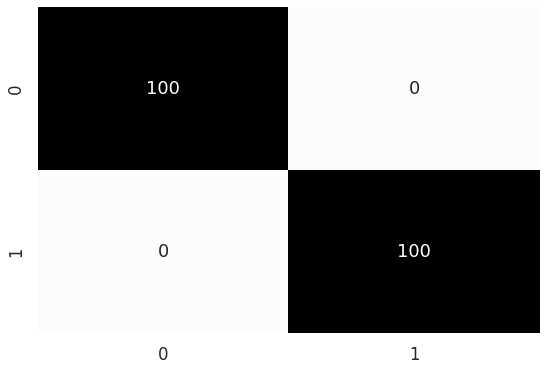

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_RF_grouped_SSC = my_model_RF_grouped_SSC.predict(population_data_test_SSC)
heatconmat(target_test_SSC,pred_RF_grouped_SSC)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_grouped_SSC.score(population_data_test_SSC, target_test_SSC)))

In [ ]:
# permutation analysis to find features importance
perm = PermutationImportance(my_model_RF_grouped_SSC).fit(population_data_SSC, target_SSC)
eli5.show_weights(perm, feature_names = population_data_SSC.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,median_SSC_W
0 ± 0.0000,median_SSC_H
0 ± 0.0000,median_SSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H
0 ± 0.0000,mean_SSC_A


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_rf_SSC_500' # name the model
pickle.dump(my_model_RF_grouped_SSC, open(data_path+ model_name+'.pkl', 'wb'))

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_SSC = XGBClassifier(n_jobs=-1)

PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_SSC,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(population_data_SSC,target_SSC)

print(model_gs.best_params_)

running the model using best parameters results

In [ ]:
# cross validation on the training data
xgboost_classification_SSC = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
scores = cross_val_score(xgboost_classification_SSC, population_data_SSC, target_SSC, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_xgboost_grouped_SSC = xgboost_classification_SSC.fit(population_data_SSC, target_SSC)
print('xgboost training Score: {0:2.5f}'.format(my_model_xgboost_grouped_SSC.score(population_data_SSC, target_SSC)))

xgboost Score: 1.00000


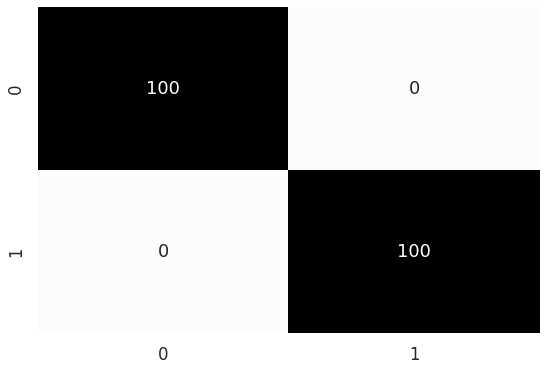

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_xgboost_SSC = my_model_xgboost_grouped_SSC.predict(population_data_test_SSC)
heatconmat(target_test_SSC,pred_xgboost_SSC)
print('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_grouped_SSC.score(population_data_test_SSC, target_test_SSC)))

In [ ]:
# permutation analysis to find feature importance
perm_xgboost_SSC = PermutationImportance(my_model_xgboost_grouped_SSC, random_state=1).fit(population_data_SSC, target_SSC)
eli5.show_weights(perm_xgboost_SSC, feature_names = population_data_SSC.columns.tolist())

Weight,Feature
0.5053 ± 0.0182,mean_SSC_A
0 ± 0.0000,median_SSC_W
0 ± 0.0000,median_SSC_H
0 ± 0.0000,median_SSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_xgboost_SSC_500' # name the model
pickle.dump(my_model_xgboost_grouped_SSC, open(data_path+ model_name+'.pkl', 'wb'))

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(population_data_SSC, target_SSC)
print(grid_search.best_params_)

running the model with the best parameters results

In [ ]:
# cross validation on the training data
SVM_SSC = svm.SVC(C = 0.001, gamma = 0.01, kernel='poly')
scores = cross_val_score(SVM_SSC, population_data_SSC, target_SSC, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the data on all the training data
my_model_SVM_grouped_SSC = SVM_SSC.fit(population_data_SSC, target_SSC)
print('SVM training Score: {0:2.5f}'.format(my_model_SVM_grouped_SSC.score(population_data_SSC, target_SSC)))

SVM Score: 1.00000


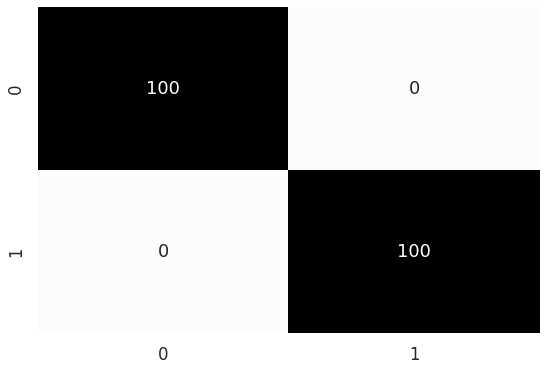

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_SVM_SSC = my_model_SVM_grouped_SSC.predict(population_data_test_SSC)
heatconmat(target_test_SSC,pred_SVM_SSC)
print('SVM Score: {0:2.5f}'.format(my_model_SVM_grouped_SSC.score(population_data_test_SSC, target_test_SSC)))

In [ ]:
# permutation analysis to find features importance
perm_SVM = PermutationImportance(my_model_SVM_grouped_SSC, random_state=1).fit(population_data_SSC, target_SSC)
eli5.show_weights(perm_SVM, feature_names = population_data_SSC.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,median_SSC_W
0 ± 0.0000,median_SSC_H
0 ± 0.0000,median_SSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H
0 ± 0.0000,mean_SSC_A


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_SVM_SSC_500' # name the model
pickle.dump(my_model_SVM_grouped_SSC, open(data_path+ model_name+'.pkl', 'wb'))

In [ ]:
## opening the saved models

# RF
model_name = 'H460_groupkfold_populations_rf_SSC_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_rf_SSC = pickle.load(a_file)
a_file.close()

# xgboost
model_name = 'H460_groupkfold_populations_xgboost_SSC_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_xgboost_SSC = pickle.load(a_file)
a_file.close()

# SVM
model_name = 'H460_groupkfold_populations_SVM_SSC_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_SVM_SSC = pickle.load(a_file)
a_file.close()

#models performance evaluation on new unseen data using the Batch dataset

In [ ]:
# reading the Batch data (for thhis example batch data was already preprocessed)
Merge_population_batch_SSC = pd.read_csv(data_path +'Merge_population_H460_test_SSC_500.csv')

In [ ]:
# separating the training features from the labels
cols_batch = [col for col in Merge_population_batch_SSC.columns if col not in ['Cell_line']]
population_data_SSC_batch = Merge_population_batch_SSC[cols_batch]# features

# assigning the cell identity column as target
target_batch_SSC = Merge_population_batch_SSC['Cell_line'] # labels

Random forest performance

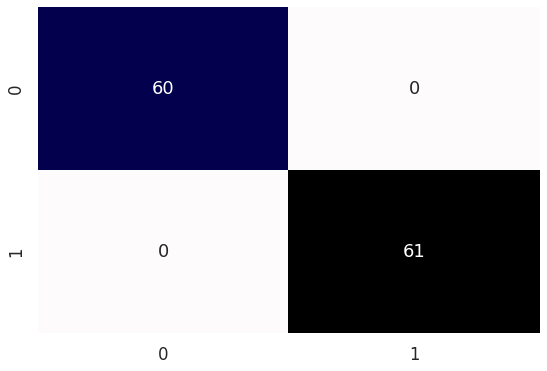

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_SSC_rf = my_model_population_rf_SSC.predict(population_data_SSC_batch)
heatconmat(target_batch_SSC,pred_batch_SSC_rf)
accuracy = accuracy_score(pred_batch_SSC_rf.astype(int), target_batch_SSC.astype(int))
print(accuracy)

XGBoost performance

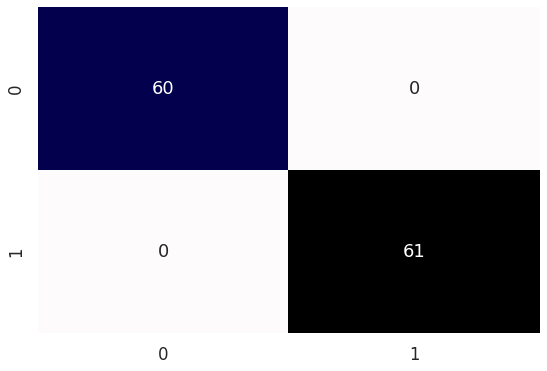

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_SSC_xgboost = my_model_population_xgboost_SSC.predict(population_data_SSC_batch)
heatconmat(target_batch_SSC,pred_batch_SSC_xgboost)
accuracy = accuracy_score(pred_batch_SSC_xgboost.astype(int), target_batch_SSC.astype(int))
print(accuracy)

SVM performance

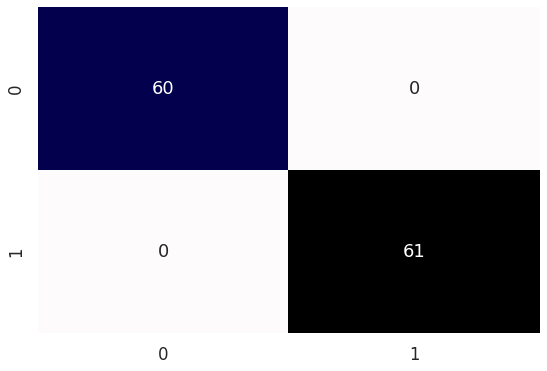

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_SSC_SVM = my_model_population_SVM_SSC.predict(population_data_SSC_batch)
heatconmat(target_batch_SSC,pred_batch_SSC_SVM)
accuracy = accuracy_score(pred_batch_SSC_SVM.astype(int), target_batch_SSC.astype(int))
print(accuracy)

# Dimention reduction - PCA

preparing the transformed data

In [ ]:
# rescale the data
train_data_rescaled_SSC = scaler.fit_transform(population_data_SSC)
test_data_rescaled_SSC = scaler.fit_transform(population_data_test_SSC)
batch_data_rescaled_SSC = scaler.fit_transform(population_data_SSC_batch)


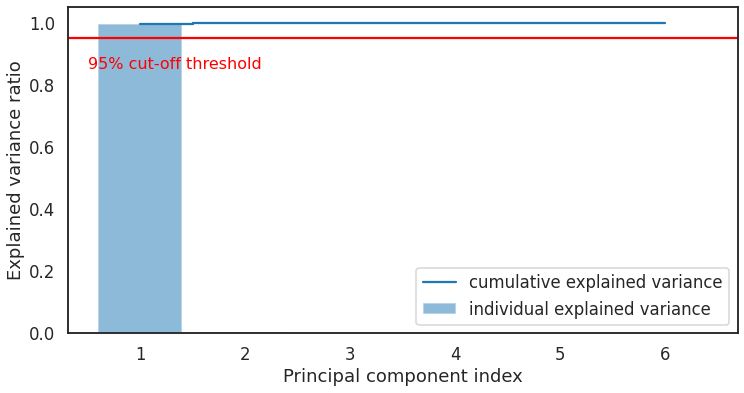

In [ ]:
# displaying the componantes and the data varience they includes for choosing the number of componnets to reduced to
cov_mat = np.cov(train_data_rescaled_SSC.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,7), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.legend(loc='best')
plt.show()

In [ ]:
pca_SSC = PCA(n_components=2) # choosing the number of dimentions

# fit and transform data
X_train_pca_SSC = pca_SSC.fit_transform(train_data_rescaled_SSC)
X_test_pca_SSC = pca_SSC.transform(test_data_rescaled_SSC)
X_batch_pca_SSC = pca_SSC.transform(batch_data_rescaled_SSC)


In [ ]:
# How much each original feature contribute to the components

print(pd.DataFrame(np.abs(pca_SSC.components_),columns=population_data_SSC.columns ,index = ['PC-1', 'PC-2']))

      mean_SSC_A  mean_SSC_H  mean_SSC_W  median_SSC_A  median_SSC_H  \
PC-1    0.427657    0.427382    0.381289      0.412977      0.415829   
PC-2    0.178955    0.339020    0.554494      0.192307      0.353396   

      median_SSC_W  
PC-1      0.381588  
PC-2      0.619440  


In [ ]:
# printing the most contributing original feature for each component
most_important = np.abs(pca_SSC.components_).argmax(axis=1)
initial_feature_names = population_data_SSC.columns
most_important_names = initial_feature_names[most_important]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(2)}
pca_results = pd.DataFrame(dic.items())
print(pca_results)

     0             1
0  PC1    mean_SSC_A
1  PC2  median_SSC_W


Random fores

Hyperparameters optimization

In [ ]:
random_forest_SSC_pca = RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [500, 1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_SSC_pca,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(X_train_pca_SSC, target_SSC)
print(model_gridsearch.best_params_)

In [ ]:
# training the model and evaluating its performance on the testing data
random_forest_SSC_pca = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators =500, n_jobs=-1)
my_model_RF_PCA_SSC = random_forest_SSC_pca.fit(X_train_pca_SSC, target_SSC)
print('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_PCA_SSC.score(X_test_pca_SSC, target_test_SSC)))

In [ ]:
# evaluating the model performance on the Batch data
pred_random_forest_SSC_PCA_batch = my_model_RF_PCA_SSC.predict(X_batch_pca_SSC)
accuracy = accuracy_score(pred_random_forest_SSC_PCA_batch.astype(int), target_batch_SSC.astype(int))
accuracy

1.0

XGBoost

Hyperparameteres optimization

In [ ]:
xgboost_classification_SSC_pca = XGBClassifier(n_jobs=-1)
PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_SSC_pca,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(X_train_pca_SSC, target_SSC)
print(model_gs.best_params_)

In [ ]:
# training the model and evaluating its performance on the testing data
xgboost_classification_SSC_pca = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
my_model_xgboost_PCA_SSC = xgboost_classification_SSC_pca.fit(X_train_pca_SSC, target_SSC)
print('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_PCA_SSC.score(X_test_pca_SSC, target_test_SSC)))

In [ ]:
# evaluating the model performance on the Batch data
pred_xgboost_SSC_PCA_batch = my_model_xgboost_PCA_SSC.predict(X_batch_pca_SSC)
accuracy = accuracy_score(pred_xgboost_SSC_PCA_batch.astype(int), target_batch_SSC.astype(int))
accuracy

1.0

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(X_train_pca_SSC, target_SSC)
print(grid_search.best_params_)

In [ ]:
# training the model and evaluating its performance on the testing data
SVM_SSC = svm.SVC(kernel='linear')
my_model_SVM_PCA_SSC = SVM_SSC.fit(X_train_pca_SSC, target_SSC)
print ('SVM testing Score: {0:2.5f}'.format(my_model_SVM_PCA_SSC.score(X_test_pca_SSC, target_test_SSC)))

In [ ]:
# evaluating the model performance on the Batch data
pred_SVM_SSC_PCA_batch = my_model_SVM_PCA_SSC.predict(X_batch_pca_SSC)
accuracy = accuracy_score(pred_SVM_SSC_PCA_batch.astype(int), target_batch_SSC.astype(int))
accuracy

1.0

# Uptake features without bins only

preparing the data

In [ ]:
# train dfs
Total_pop_1_uptake_no_bins = prefeatured_pop_1
Total_pop_2_uptake_no_bins = prefeatured_pop_2

# test dfs (scilent if there is one sample per population only )
Total_pop_1_test_uptake_no_bins = prefeatured_pop_1_test
Total_pop_2_test_uptake_no_bins = prefeatured_pop_2_test

Training data

In [ ]:
# grouping mean and median pop 1 train uptake values
grouper_pop_1_uptake_no_bins = Total_pop_1_uptake_no_bins.groupby(pd.Grouper(key='population_number'))

BV421_A_mean = grouper_pop_1_uptake_no_bins['BV421_A'].mean().to_frame(name='mean_BV421_A').reset_index()
BV421_A_median = grouper_pop_1_uptake_no_bins['BV421_A'].median().to_frame(name='median_BV421_A').reset_index()

FITC_A_mean = grouper_pop_1_uptake_no_bins['FITC_A'].mean().to_frame(name='mean_FITC_A').reset_index()
FITC_A_median = grouper_pop_1_uptake_no_bins['FITC_A'].median().to_frame(name='median_FITC_A').reset_index()

PerCP_A_mean = grouper_pop_1_uptake_no_bins['PerCP_A'].mean().to_frame(name='mean_PerCP_A').reset_index()
PerCP_A_median = grouper_pop_1_uptake_no_bins['PerCP_A'].median().to_frame(name='median_PerCP_A').reset_index()

PE_Texas_Red_A_mean = grouper_pop_1_uptake_no_bins['PE_Texas_Red_A'].mean().to_frame(name='mean_PE_Texas_Red_A').reset_index()
PE_Texas_Red_A_median = grouper_pop_1_uptake_no_bins['PE_Texas_Red_A'].median().to_frame(name='median_PE_Texas_Red_A').reset_index()

Alexa_Fluor_700_A_mean = grouper_pop_1_uptake_no_bins['Alexa_Fluor_700_A'].mean().to_frame(name='mean_Alexa_Fluor_700_A').reset_index()
Alexa_Fluor_700_A_median = grouper_pop_1_uptake_no_bins['Alexa_Fluor_700_A'].median().to_frame(name='median_Alexa_Fluor_700_A').reset_index()

In [ ]:
# setting a new array of the grouping data
grouper_pop_1_uptake_no_bins = [BV421_A_mean,BV421_A_median, FITC_A_mean, FITC_A_median, PerCP_A_mean, PerCP_A_median ,
                          PE_Texas_Red_A_mean, PE_Texas_Red_A_median, Alexa_Fluor_700_A_mean, Alexa_Fluor_700_A_median]

In [ ]:
# building a new df of the grouped data
pop_1_log_grouped_uptake_no_bins = reduce(lambda left, right: pd.merge(left, right, on='population_number'), grouper_pop_1_uptake_no_bins)
pop_1_log_grouped_uptake_no_bins['Cell_line'] = 0

In [ ]:
# grouping mean and median pop 2 train uptake values
grouper_pop_2_uptake_no_bins = Total_pop_2_uptake_no_bins.groupby(pd.Grouper(key='population_number'))

BV421_A_mean = grouper_pop_2_uptake_no_bins['BV421_A'].mean().to_frame(name='mean_BV421_A').reset_index()
BV421_A_median = grouper_pop_2_uptake_no_bins['BV421_A'].median().to_frame(name='median_BV421_A').reset_index()

FITC_A_mean = grouper_pop_2_uptake_no_bins['FITC_A'].mean().to_frame(name='mean_FITC_A').reset_index()
FITC_A_median = grouper_pop_2_uptake_no_bins['FITC_A'].median().to_frame(name='median_FITC_A').reset_index()

PerCP_A_mean = grouper_pop_2_uptake_no_bins['PerCP_A'].mean().to_frame(name='mean_PerCP_A').reset_index()
PerCP_A_median = grouper_pop_2_uptake_no_bins['PerCP_A'].median().to_frame(name='median_PerCP_A').reset_index()

PE_Texas_Red_A_mean = grouper_pop_2_uptake_no_bins['PE_Texas_Red_A'].mean().to_frame(name='mean_PE_Texas_Red_A').reset_index()
PE_Texas_Red_A_median = grouper_pop_2_uptake_no_bins['PE_Texas_Red_A'].median().to_frame(name='median_PE_Texas_Red_A').reset_index()

Alexa_Fluor_700_A_mean = grouper_pop_2_uptake_no_bins['Alexa_Fluor_700_A'].mean().to_frame(name='mean_Alexa_Fluor_700_A').reset_index()
Alexa_Fluor_700_A_median = grouper_pop_2_uptake_no_bins['Alexa_Fluor_700_A'].median().to_frame(name='median_Alexa_Fluor_700_A').reset_index()

In [ ]:
# setting a new array of the grouping data
grouper_pop_2_uptake_no_bins = [BV421_A_mean,BV421_A_median, FITC_A_mean, FITC_A_median, PerCP_A_mean, PerCP_A_median ,
                          PE_Texas_Red_A_mean, PE_Texas_Red_A_median, Alexa_Fluor_700_A_mean, Alexa_Fluor_700_A_median]

In [ ]:
# building a new df of the grouped data
pop_2_log_grouped_uptake_no_bins = reduce(lambda left, right: pd.merge(left, right, on='population_number'), grouper_pop_2_uptake_no_bins)
pop_2_log_grouped_uptake_no_bins['Cell_line'] = 1

In [ ]:
# merging the training data of the two populations
populations_df_list = [pop_1_log_grouped_uptake_no_bins, pop_2_log_grouped_uptake_no_bins]
Merge_population_uptake_no_bins = pd.DataFrame()
for df in populations_df_list:
    Merge_population_uptake_no_bins = pd.concat([Merge_population_uptake_no_bins, df], ignore_index=True)

Merge_population_uptake_no_bins.drop('population_number', axis = 1, inplace = True)
Merge_population_uptake_no_bins.to_csv('Merge_population_H460_uptake_no_bins.csv') # name the data

Testing data

In [ ]:
# grouping mean and median pop 1 test uptake values
grouper_pop_1_test_uptake_no_bins = Total_pop_1_test_uptake_no_bins.groupby(pd.Grouper(key='population_number'))

BV421_A_mean = grouper_pop_1_test_uptake_no_bins['BV421_A'].mean().to_frame(name='mean_BV421_A').reset_index()
BV421_A_median = grouper_pop_1_test_uptake_no_bins['BV421_A'].median().to_frame(name='median_BV421_A').reset_index()

FITC_A_mean = grouper_pop_1_test_uptake_no_bins['FITC_A'].mean().to_frame(name='mean_FITC_A').reset_index()
FITC_A_median = grouper_pop_1_test_uptake_no_bins['FITC_A'].median().to_frame(name='median_FITC_A').reset_index()

PerCP_A_mean = grouper_pop_1_test_uptake_no_bins['PerCP_A'].mean().to_frame(name='mean_PerCP_A').reset_index()
PerCP_A_median = grouper_pop_1_test_uptake_no_bins['PerCP_A'].median().to_frame(name='median_PerCP_A').reset_index()

PE_Texas_Red_A_mean = grouper_pop_1_test_uptake_no_bins['PE_Texas_Red_A'].mean().to_frame(name='mean_PE_Texas_Red_A').reset_index()
PE_Texas_Red_A_median = grouper_pop_1_test_uptake_no_bins['PE_Texas_Red_A'].median().to_frame(name='median_PE_Texas_Red_A').reset_index()

Alexa_Fluor_700_A_mean = grouper_pop_1_test_uptake_no_bins['Alexa_Fluor_700_A'].mean().to_frame(name='mean_Alexa_Fluor_700_A').reset_index()
Alexa_Fluor_700_A_median = grouper_pop_1_test_uptake_no_bins['Alexa_Fluor_700_A'].median().to_frame(name='median_Alexa_Fluor_700_A').reset_index()

In [ ]:
# setting a new array of the grouping data
grouper_pop_1_test_uptake_no_bins = [BV421_A_mean,BV421_A_median, FITC_A_mean, FITC_A_median, PerCP_A_mean, PerCP_A_median ,
                          PE_Texas_Red_A_mean, PE_Texas_Red_A_median, Alexa_Fluor_700_A_mean, Alexa_Fluor_700_A_median]

In [ ]:
# building a new df of the grouped data
pop_1_test_log_grouped_uptake_no_bins = reduce(lambda left, right: pd.merge(left, right, on='population_number'), grouper_pop_1_test_uptake_no_bins)
pop_1_test_log_grouped_uptake_no_bins['Cell_line'] = 0

In [ ]:
# grouping mean and median pop 2 test uptake values
grouper_pop_2_test_uptake_no_bins = Total_pop_2_test_uptake_no_bins.groupby(pd.Grouper(key='population_number'))

BV421_A_mean = grouper_pop_2_test_uptake_no_bins['BV421_A'].mean().to_frame(name='mean_BV421_A').reset_index()
BV421_A_median = grouper_pop_2_test_uptake_no_bins['BV421_A'].median().to_frame(name='median_BV421_A').reset_index()

FITC_A_mean = grouper_pop_2_test_uptake_no_bins['FITC_A'].mean().to_frame(name='mean_FITC_A').reset_index()
FITC_A_median = grouper_pop_2_test_uptake_no_bins['FITC_A'].median().to_frame(name='median_FITC_A').reset_index()

PerCP_A_mean = grouper_pop_2_test_uptake_no_bins['PerCP_A'].mean().to_frame(name='mean_PerCP_A').reset_index()
PerCP_A_median = grouper_pop_2_test_uptake_no_bins['PerCP_A'].median().to_frame(name='median_PerCP_A').reset_index()

PE_Texas_Red_A_mean = grouper_pop_2_test_uptake_no_bins['PE_Texas_Red_A'].mean().to_frame(name='mean_PE_Texas_Red_A').reset_index()
PE_Texas_Red_A_median = grouper_pop_2_test_uptake_no_bins['PE_Texas_Red_A'].median().to_frame(name='median_PE_Texas_Red_A').reset_index()

Alexa_Fluor_700_A_mean = grouper_pop_2_test_uptake_no_bins['Alexa_Fluor_700_A'].mean().to_frame(name='mean_Alexa_Fluor_700_A').reset_index()
Alexa_Fluor_700_A_median = grouper_pop_2_test_uptake_no_bins['Alexa_Fluor_700_A'].median().to_frame(name='median_Alexa_Fluor_700_A').reset_index()

In [ ]:
# setting a new array of the grouping data
grouper_pop_2_test_uptake_no_bins = [BV421_A_mean,BV421_A_median, FITC_A_mean, FITC_A_median, PerCP_A_mean, PerCP_A_median ,
                          PE_Texas_Red_A_mean, PE_Texas_Red_A_median, Alexa_Fluor_700_A_mean, Alexa_Fluor_700_A_median]

In [ ]:
# building a new df of the grouped data
pop_2_test_log_grouped_uptake_no_bins = reduce(lambda left, right: pd.merge(left, right, on='population_number'), grouper_pop_2_test_uptake_no_bins)
pop_2_test_log_grouped_uptake_no_bins['Cell_line'] = 1

In [ ]:
# merging the testing data of the two populations
populations_df_list_test = [pop_1_test_log_grouped_uptake_no_bins, pop_2_test_log_grouped_uptake_no_bins]
Merge_population_test_uptake_no_bins = pd.DataFrame()
for df in populations_df_list_test:
    Merge_population_test_uptake_no_bins = pd.concat([Merge_population_test_uptake_no_bins, df], ignore_index=True)

Merge_population_test_uptake_no_bins.drop('population_number', axis = 1, inplace = True)

Running the models

In [ ]:
# separating the training features from the labels
cols = [col for col in Merge_population_uptake_no_bins.columns if col not in ['Cell_line']]
population_data_uptake_no_bins = Merge_population_uptake_no_bins[cols] # features

# assigning the cell identity column as target
target_uptake_no_bins = Merge_population_uptake_no_bins['Cell_line'] # labels
target_group = ['0', '1']

In [ ]:
## if the data includes only one sample per population

## split to training and testing
#X_train, X_test, y_train, y_test = train_test_split(All_data_train, target, test_size=0.3, random_state=42) # make sure to change names as needed

In [ ]:
# do not run if the data includes only one sample per population

# separating the testing features from the labels
cols_test = [col for col in Merge_population_test_uptake_no_bins.columns if col not in ['Cell_line']]
population_data_test_uptake_no_bins = Merge_population_test_uptake_no_bins[cols_test] # features

# assigning the cell identity column as target
target_test_uptake_no_bins = Merge_population_test_uptake_no_bins['Cell_line'] # labels


Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_uptake_no_bins= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_uptake_no_bins,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(population_data_uptake_no_bins, target_uptake_no_bins)
print(model_gridsearch.best_params_)

running the model using best parameters results

In [ ]:
# cross validation on the training data
random_forest_grouped_uptake_no_bins = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
scores = cross_val_score(random_forest_grouped_uptake_no_bins, population_data_uptake_no_bins, target_uptake_no_bins, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_RF_grouped_uptake_no_bins = random_forest_grouped_uptake_no_bins.fit(population_data_uptake_no_bins, target_uptake_no_bins)
print('Random Forest trainin gScore: {0:2.5f}'.format(my_model_RF_grouped_uptake_no_bins.score(population_data_uptake_no_bins, target_uptake_no_bins)))

Random Forest Score: 1.00000


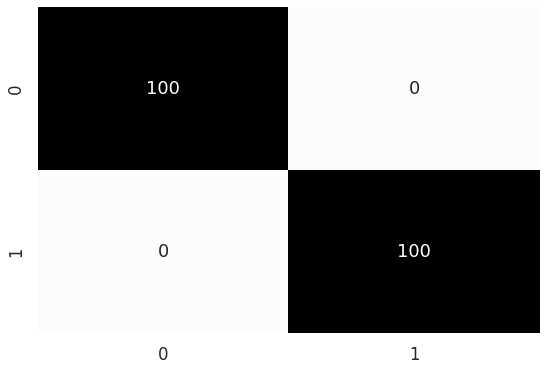

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_RF_grouped_uptake_no_bins = my_model_RF_grouped_uptake_no_bins.predict(population_data_test_uptake_no_bins)
heatconmat(target_test_uptake_no_bins,pred_RF_grouped_uptake_no_bins)
print('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_grouped_uptake_no_bins.score(population_data_test_uptake_no_bins, target_test_uptake_no_bins)))


In [ ]:
# permutation analysis to find features importance
perm = PermutationImportance(my_model_RF_grouped_uptake_no_bins).fit(population_data_uptake_no_bins, target_uptake_no_bins)
eli5.show_weights(perm, feature_names = population_data_uptake_no_bins.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,median_Alexa_Fluor_700_A
0 ± 0.0000,mean_Alexa_Fluor_700_A
0 ± 0.0000,median_PE_Texas_Red_A
0 ± 0.0000,mean_PE_Texas_Red_A
0 ± 0.0000,median_PerCP_A
0 ± 0.0000,mean_PerCP_A
0 ± 0.0000,median_FITC_A
0 ± 0.0000,mean_FITC_A
0 ± 0.0000,median_BV421_A
0 ± 0.0000,mean_BV421_A


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_population_rf_uptake_no_bins_500' # name the model
pickle.dump(my_model_RF_grouped_uptake_no_bins, open(data_path+ model_name+'.pkl', 'wb'))

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_uptake_no_bins = XGBClassifier(n_jobs=-1)
PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_uptake_no_bins,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(population_data_uptake_no_bins, target_uptake_no_bins)
print(model_gs.best_params_)

running the model using best parameters results

In [ ]:
# cross validation on the training data
xgboost_classification_uptake_no_bins = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
scores = cross_val_score(xgboost_classification_uptake_no_bins, population_data_uptake_no_bins, target_uptake_no_bins, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting thhe model on all thhe training data
my_model_xgboost_grouped_uptake_no_bins = xgboost_classification_uptake_no_bins.fit(population_data_uptake_no_bins, target_uptake_no_bins)
print('xgboost training Score: {0:2.5f}'.format(my_model_xgboost_grouped_uptake_no_bins.score(population_data_uptake_no_bins, target_uptake_no_bins)))

xgboost Score: 1.00000


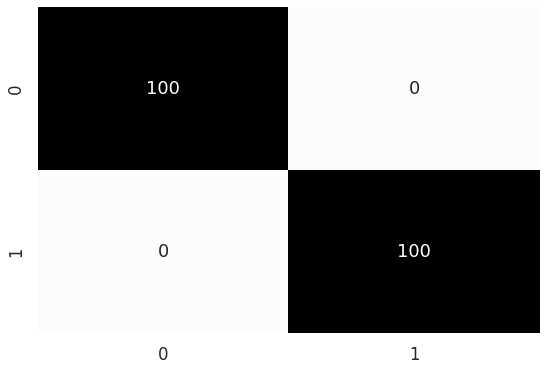

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_xgboost_uptake_no_bins = my_model_xgboost_grouped_uptake_no_bins.predict(population_data_test_uptake_no_bins)
heatconmat(target_test_uptake_no_bins,pred_xgboost_uptake_no_bins)
print('xgboost testingScore: {0:2.5f}'.format(my_model_xgboost_grouped_uptake_no_bins.score(population_data_test_uptake_no_bins, target_test_uptake_no_bins)))

In [ ]:
# permutation analysis to find features importance
perm_xgboost_uptake_no_bins = PermutationImportance(my_model_xgboost_grouped_uptake_no_bins, random_state=1).fit(population_data_uptake_no_bins, target_uptake_no_bins)
eli5.show_weights(perm_xgboost_uptake_no_bins, feature_names = population_data_uptake_no_bins.columns.tolist())

Weight,Feature
0.5047 ± 0.0480,mean_BV421_A
0 ± 0.0000,median_Alexa_Fluor_700_A
0 ± 0.0000,mean_Alexa_Fluor_700_A
0 ± 0.0000,median_PE_Texas_Red_A
0 ± 0.0000,mean_PE_Texas_Red_A
0 ± 0.0000,median_PerCP_A
0 ± 0.0000,mean_PerCP_A
0 ± 0.0000,median_FITC_A
0 ± 0.0000,mean_FITC_A
0 ± 0.0000,median_BV421_A


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_population_xgboost_uptake_no_bins_500' # name the model
pickle.dump(my_model_xgboost_grouped_uptake_no_bins, open(data_path+ model_name+'.pkl', 'wb'))

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(population_data_uptake_no_bins, target_uptake_no_bins)
print(grid_search.best_params_)

In [ ]:
# cross validation on the training data
SVM_uptake_no_bins = svm.SVC(C = 0.001, gamma = 0.001, kernel='linear')
scores = cross_val_score(SVM_uptake_no_bins, population_data_uptake_no_bins, target_uptake_no_bins, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_SVM_grouped_uptake_no_bins = SVM_uptake_no_bins.fit(population_data_uptake_no_bins, target_uptake_no_bins)
print('SVM training Score: {0:2.5f}'.format(my_model_SVM_grouped_uptake_no_bins.score(population_data_uptake_no_bins, target_uptake_no_bins)))

SVM Score: 1.00000


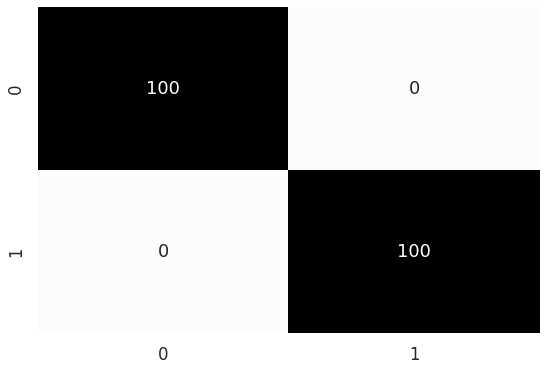

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_SVM_uptake_no_bins = my_model_SVM_grouped_uptake_no_bins.predict(population_data_test_uptake_no_bins)
heatconmat(target_test_uptake_no_bins,pred_SVM_uptake_no_bins)
print('SVM testing Score: {0:2.5f}'.format(my_model_SVM_grouped_uptake_no_bins.score(population_data_test_uptake_no_bins, target_test_uptake_no_bins)))

In [ ]:
# permutation analysis to find features importance
perm_SVM = PermutationImportance(my_model_SVM_grouped_uptake_no_bins, random_state=1).fit(population_data_uptake_no_bins, target_uptake_no_bins)
eli5.show_weights(perm_SVM, feature_names = population_data_uptake_no_bins.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,median_Alexa_Fluor_700_A
0 ± 0.0000,mean_Alexa_Fluor_700_A
0 ± 0.0000,median_PE_Texas_Red_A
0 ± 0.0000,mean_PE_Texas_Red_A
0 ± 0.0000,median_PerCP_A
0 ± 0.0000,mean_PerCP_A
0 ± 0.0000,median_FITC_A
0 ± 0.0000,mean_FITC_A
0 ± 0.0000,median_BV421_A
0 ± 0.0000,mean_BV421_A


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_population_SVM_uptake_no_bins_500' # name the model
pickle.dump(my_model_SVM_grouped_uptake_no_bins, open(data_path+ model_name+'.pkl', 'wb'))

In [ ]:
## opening the saved models

# RF
model_name = 'H460_groupkfold_population_rf_uptake_no_bins_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_rf_uptake_no_bins = pickle.load(a_file)
a_file.close()

# xgboost
model_name = 'H460_groupkfold_population_xgboost_uptake_no_bins_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_xgboost_uptake_no_bins = pickle.load(a_file)
a_file.close()

# SVM
model_name = 'H460_groupkfold_population_SVM_uptake_no_bins_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_SVM_uptake_no_bins = pickle.load(a_file)
a_file.close()

# models performance evaluation on new unseen data using the Batch dataset

In [ ]:
# reading the Batch data
Merge_population_batch_uptake_no_bins = pd.read_csv(data_path +'Merge_population_H460_uptake_test_no_bins_500.csv')
Merge_population_batch_uptake_no_bins.drop('Unnamed: 0', axis =1, inplace = True)

In [ ]:
# separating the Batch features from the labels
cols_batch = [col for col in Merge_population_batch_uptake_no_bins.columns if col not in ['Cell_line']]
population_data_uptake_no_bins_batch = Merge_population_batch_uptake_no_bins[cols_batch]
# assigning the cell identity column as target
target_batch_uptake_no_bins = Merge_population_batch_uptake_no_bins['Cell_line']

Random forest performance

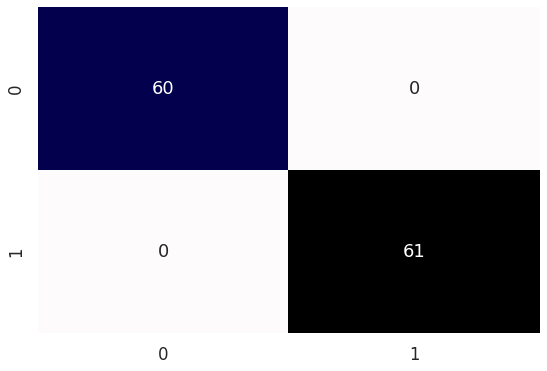

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_uptake_no_bins_rf = my_model_population_rf_uptake_no_bins.predict(population_data_uptake_no_bins_batch)
heatconmat(target_batch_uptake_no_bins,pred_batch_uptake_no_bins_rf)
accuracy = accuracy_score(pred_batch_uptake_no_bins_rf.astype(int), target_batch_uptake_no_bins.astype(int))
print(accuracy)

XGBoost performance

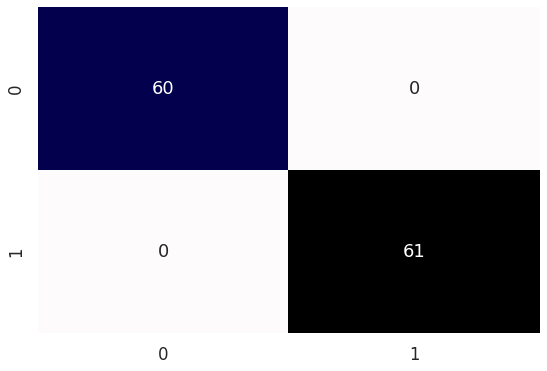

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_uptake_no_bins_xgboost = my_model_population_xgboost_uptake_no_bins.predict(population_data_uptake_no_bins_batch)
heatconmat(target_batch_uptake_no_bins,pred_batch_uptake_no_bins_xgboost)
accuracy = accuracy_score(pred_batch_uptake_no_bins_xgboost.astype(int), target_batch_uptake_no_bins.astype(int))
print(accuracy)

SVM performance

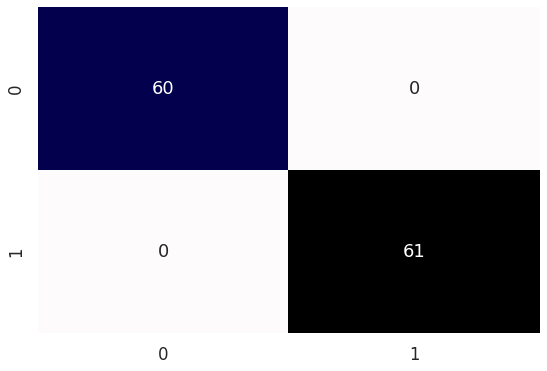

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_uptake_no_bins_SVM = my_model_population_SVM_uptake_no_bins.predict(population_data_uptake_no_bins_batch)
heatconmat(target_batch_uptake_no_bins,pred_batch_uptake_no_bins_SVM)
accuracy = accuracy_score(pred_batch_uptake_no_bins_SVM.astype(int), target_batch_uptake_no_bins.astype(int))
print(accuracy)

# Dimention reduction -PCA

In [ ]:
# rescale the data
train_data_rescaled_uptake_no_bins = scaler.fit_transform(population_data_uptake_no_bins)
test_data_rescaled_uptake_no_bins = scaler.fit_transform(population_data_test_uptake_no_bins)
batch_data_rescaled_uptake_no_bins = scaler.fit_transform(population_data_uptake_no_bins_batch)


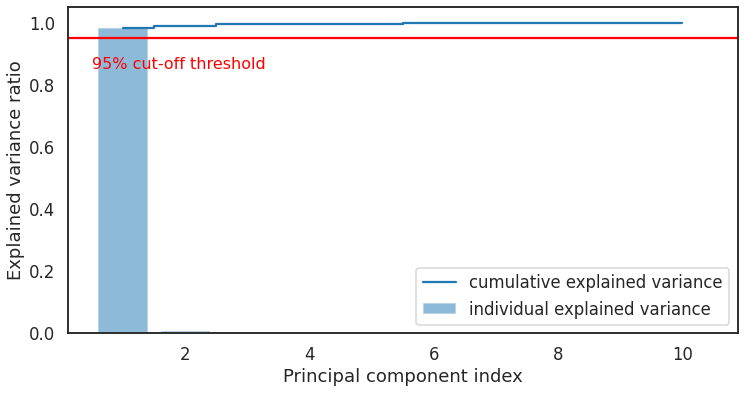

In [ ]:
# displaying the componantes and the data varience they includes for choosing the number of componnets to reduced to
cov_mat = np.cov(train_data_rescaled_uptake_no_bins.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,11), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,11), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.legend(loc='best')
plt.show()

In [ ]:
pca_uptake_no_bins = PCA(n_components=2) # choosing the number of dimentions

# fit and transform data
X_train_pca_uptake_no_bins = pca_uptake_no_bins.fit_transform(train_data_rescaled_uptake_no_bins)
X_test_pca_uptake_no_bins = pca_uptake_no_bins.transform(test_data_rescaled_uptake_no_bins)
X_batch_pca_uptake_no_bins = pca_uptake_no_bins.transform(batch_data_rescaled_uptake_no_bins)


In [ ]:
# How much each original feature contribute to the components

print(pd.DataFrame(np.abs(pca_uptake_no_bins.components_),columns=population_data_uptake_no_bins.columns ,index = ['PC-1','PC-2']))

      mean_BV421_A  median_BV421_A  mean_FITC_A  median_FITC_A  mean_PerCP_A  \
PC-1      0.342773        0.289797     0.320584       0.342834      0.346148   
PC-2      0.339978        0.374273     0.230132       0.293554      0.107214   

      median_PerCP_A  mean_PE_Texas_Red_A  median_PE_Texas_Red_A  \
PC-1        0.374950             0.356117               0.150222   
PC-2        0.016317             0.139067               0.164560   

      mean_Alexa_Fluor_700_A  median_Alexa_Fluor_700_A  
PC-1                0.328333                  0.246210  
PC-2                0.385287                  0.631327  


In [ ]:
# printing the most contributing original feature for each component
most_important = np.abs(pca_uptake_no_bins.components_).argmax(axis=1)
initial_feature_names = population_data_uptake_no_bins.columns
most_important_names = initial_feature_names[most_important]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(2)}
pca_results = pd.DataFrame(dic.items())
print(pca_results)

     0                         1
0  PC1            median_PerCP_A
1  PC2  median_Alexa_Fluor_700_A


Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_uptake_no_bins_pca= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_uptake_no_bins_pca,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(X_train_pca_uptake_no_bins, target_uptake_no_bins)
print(model_gridsearch.best_params_)

Running the model using best parameters results

In [ ]:
# training the modeln and evaluating its performance on the testing data
random_forest_grouped_uptake_no_bins_pca = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
my_model_RF_PCA_uptake_no_bins = random_forest_grouped_uptake_no_bins_pca.fit(X_train_pca_uptake_no_bins, target_uptake_no_bins)
print('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_PCA_uptake_no_bins.score(X_test_pca_uptake_no_bins, target_test_uptake_no_bins)))

In [ ]:
# evaluating the model peerformance on the Batch data
pred_random_forest_uptake_no_bins_PCA_batch = my_model_RF_PCA_uptake_no_bins.predict(X_batch_pca_uptake_no_bins)
accuracy = accuracy_score(pred_random_forest_uptake_no_bins_PCA_batch.astype(int), target_batch_uptake_no_bins.astype(int))
accuracy

1.0

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_uptake_no_bins_pca = XGBClassifier(n_jobs=-1)

PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_uptake_no_bins_pca,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(X_train_pca_uptake_no_bins, target_uptake_no_bins)
print(model_gs.best_params_)

running the model using best parameters results

In [ ]:
# training the modeln and evaluating its performance on the testing data
xgboost_classification_uptake_no_bins_pca = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
my_model_xgboost_PCA_uptake_no_bins = xgboost_classification_uptake_no_bins_pca.fit(X_train_pca_uptake_no_bins, target_uptake_no_bins)
print('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_PCA_uptake_no_bins.score(X_test_pca_uptake_no_bins, target_test_uptake_no_bins)))

In [ ]:
# evaluating the model peerformance on the Batch data
pred_xgboost_uptake_no_bins_PCA_batch = xgboost_classification_uptake_no_bins_pca.predict(X_batch_pca_uptake_no_bins)
accuracy = accuracy_score(pred_xgboost_uptake_no_bins_PCA_batch.astype(int), target_batch_uptake_no_bins.astype(int))
accuracy

1.0

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(X_train_pca_uptake_no_bins, target_uptake_no_bins)
print(grid_search.best_params_)

running the model using best parameters results

In [ ]:
# training the modeln and evaluating its performance on the testing data
SVM_uptake_no_bins = svm.SVC(C = 0.001, gamma = 0.001, kernel='linear')
my_model_SVM_PCA_uptake_no_bins = SVM_uptake_no_bins.fit(X_train_pca_uptake_no_bins, target_uptake_no_bins)
print('SVM testing Score: {0:2.5f}'.format(my_model_SVM_PCA_uptake_no_bins.score(X_test_pca_uptake_no_bins, target_test_uptake_no_bins)))

In [ ]:
# evaluating the model peerformance on the Batch data
pred_SVM_uptake_no_bins_PCA_batch = my_model_SVM_PCA_uptake_no_bins.predict(X_batch_pca_uptake_no_bins)
accuracy = accuracy_score(pred_SVM_uptake_no_bins_PCA_batch.astype(int), target_batch_uptake_no_bins.astype(int))
accuracy

1.0

# All Features - includes physiological (A,W,H) and uptkae (A) features (22)

preparing the data

In [ ]:
# training dataset
Merge_population_all = Merge_population_uptake_no_bins
Merge_population_all.drop('Cell_line', axis = 1, inplace = True)
Merge_population_all = pd.concat([Merge_population_all, Merge_population_phys_no_bins], axis =1)

In [ ]:
# do not run if the data includes only one sample per population
# testing dataset
Merge_population_test_all = Merge_population_test_uptake_no_bins
Merge_population_test_all.drop(['Cell_line'], axis = 1, inplace = True)
Merge_population_test_all = pd.concat([Merge_population_test_all, Merge_population_test_phys_no_bins], axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mean_BV421_A              200 non-null    float64
 1   median_BV421_A            200 non-null    float64
 2   mean_FITC_A               200 non-null    float64
 3   median_FITC_A             200 non-null    float64
 4   mean_PerCP_A              200 non-null    float64
 5   median_PerCP_A            200 non-null    float64
 6   mean_PE_Texas_Red_A       200 non-null    float64
 7   median_PE_Texas_Red_A     200 non-null    float64
 8   mean_Alexa_Fluor_700_A    200 non-null    float64
 9   median_Alexa_Fluor_700_A  200 non-null    float64
 10  mean_FSC_A                200 non-null    float64
 11  mean_FSC_H                200 non-null    float64
 12  mean_FSC_W                200 non-null    float64
 13  mean_SSC_A                200 non-null    float64
 14  mean_SSC_H

In [ ]:
# separating the training features from the labels
cols = [col for col in Merge_population_all.columns if col not in ['Cell_line']]
population_data_all = Merge_population_all[cols] # features

# assigning the cell identity column as target
target_all = Merge_population_all['Cell_line'] # labels
target_group = ['0', '1']

In [ ]:
## if the data includes only one sample per population

## split to training and testing
#X_train, X_test, y_train, y_test = train_test_split(All_data_train, target, test_size=0.3, random_state=42) # make sure to change names as needed

In [ ]:
# do not run if the data includes only one sample per population
# separating the testing features from the labels
cols_test = [col for col in Merge_population_test_all.columns if col not in ['Cell_line']]
population_data_test_all = Merge_population_test_all[cols_test] # features

# assigning the cell identity column as target
target_test_all = Merge_population_test_all['Cell_line']

Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_all= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_all,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(population_data_all, target_all)
print(model_gridsearch.best_params_)

running the model using best parameters results

In [ ]:
# cross validation on the training data
random_forest_grouped_all = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
scores = cross_val_score(random_forest_grouped_all, population_data_all, target_all, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_RF_grouped_all = random_forest_grouped_all.fit(population_data_all, target_all)
print('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_grouped_all.score(population_data_all, target_all)))

Random Forest Score: 1.00000


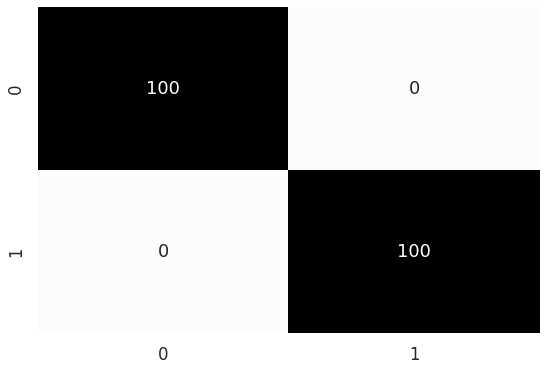

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_RF_grouped_all = my_model_RF_grouped_all.predict(population_data_test_all)
heatconmat(target_test_all,pred_RF_grouped_all)

In [ ]:
# prediction and visualization
perm = PermutationImportance(my_model_RF_grouped_all).fit(population_data_all, target_all)
eli5.show_weights(perm, feature_names = population_data_all.columns.tolist())
print('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_grouped_all.score(population_data_test_all, target_test_all)))

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,mean_FITC_A
0 ± 0.0000,median_SSC_A
0 ± 0.0000,median_FSC_W
0 ± 0.0000,median_FSC_H
0 ± 0.0000,median_FSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H
0 ± 0.0000,mean_SSC_A
0 ± 0.0000,mean_FSC_W
0 ± 0.0000,mean_FSC_H


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_rf_all_no_bins_500' # name the model
pickle.dump(my_model_RF_grouped_all, open(data_path+ model_name+'.pkl', 'wb'))

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_all = XGBClassifier(n_jobs=-1)

PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_all,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(population_data_all, target_all)
print(model_gs.best_params_)

running the model using best parameters results

In [ ]:
# cross validation on the training data
xgboost_classification_all = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
scores_xg = cross_val_score(xgboost_classification_all, population_data_all, target_all, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores_xg)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_xgboost_grouped_all = xgboost_classification_all.fit(population_data_all, target_all)
print ('xgboost training Score: {0:2.5f}'.format(my_model_xgboost_grouped_all.score(population_data_all, target_all)))

xgboost Score: 1.00000


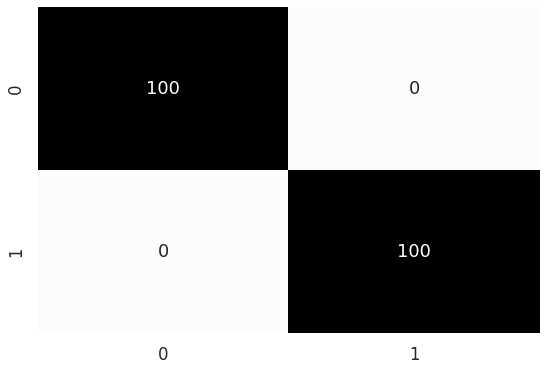

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_xgboost_all = my_model_xgboost_grouped_all.predict(population_data_test_all)
heatconmat(target_test_all,pred_xgboost_all)
print ('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_grouped_all.score(population_data_test_all, target_test_all)))

In [ ]:
# permutation analysis to find features importance
perm_xgboost_all = PermutationImportance(my_model_xgboost_grouped_all, random_state=1).fit(population_data_all, target_all)
eli5.show_weights(perm_xgboost_all, feature_names = population_data_all.columns.tolist())

Weight,Feature
0.5007 ± 0.0517,mean_BV421_A
0 ± 0.0000,median_FITC_A
0 ± 0.0000,median_SSC_A
0 ± 0.0000,median_FSC_W
0 ± 0.0000,median_FSC_H
0 ± 0.0000,median_FSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H
0 ± 0.0000,mean_SSC_A
0 ± 0.0000,mean_FSC_W


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_xgboost_all_no_bins_500' # name the model
pickle.dump(my_model_xgboost_grouped_all, open(data_path+model_name+'.pkl', 'wb'))

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(population_data_all, target_all)
print(grid_search.best_params_)

running the model using best parameters results

In [ ]:
# cross validation on the training data
SVM_all = svm.SVC(C = 0.001, gamma = 0.001, kernel='linear')
scores = cross_val_score(SVM_all, population_data_all, target_all, scoring='accuracy', cv=cv, n_jobs=-1)
print('Cross validation Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))

In [ ]:
# fitting the model on all the training data
my_model_SVM_grouped_all = SVM_all.fit(population_data_all, target_all)
print ('SVM training tScore: {0:2.5f}'.format(my_model_SVM_grouped_all.score(population_data_all, target_all)))

SVM Score: 1.00000


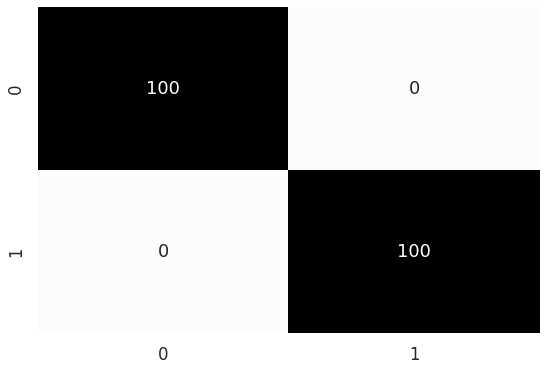

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# prediction and visualization
pred_SVM_all = my_model_SVM_grouped_all.predict(population_data_test_all)
heatconmat(target_test_all,pred_SVM_all)
print('SVM testing Score: {0:2.5f}'.format(my_model_SVM_grouped_all.score(population_data_test_all, target_test_all)))

In [ ]:
# permutation analysis to find features importance
perm_SVM = PermutationImportance(my_model_SVM_grouped_all, random_state=1).fit(population_data_all, target_all)
eli5.show_weights(perm_SVM, feature_names = population_data_all.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,mean_FITC_A
0 ± 0.0000,median_SSC_A
0 ± 0.0000,median_FSC_W
0 ± 0.0000,median_FSC_H
0 ± 0.0000,median_FSC_A
0 ± 0.0000,mean_SSC_W
0 ± 0.0000,mean_SSC_H
0 ± 0.0000,mean_SSC_A
0 ± 0.0000,mean_FSC_W
0 ± 0.0000,mean_FSC_H


In [ ]:
# saving the model as a pickle
model_name = 'H460_groupkfold_populations_SVM_all_no_bins_500' # name the model
pickle.dump(my_model_SVM_grouped_all, open(data_path+ model_name+'.pkl', 'wb'))

In [ ]:
## opening the saved models

# RF
model_name = 'H460_groupkfold_populations_rf_all_no_bins_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_rf_all = pickle.load(a_file)
a_file.close()

# xgboost
model_name = 'H460_groupkfold_populations_xgboost_all_no_bins_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_populatin_xgboost_all = pickle.load(a_file)
a_file.close()

# SVM
model_name = 'H460_groupkfold_populations_SVM_all_no_bins_500' # name the model
a_file = open(data_path+model_name+'.pkl', "rb")
my_model_population_SVM_all = pickle.load(a_file)
a_file.close()

# new experiment testing - Batch data

In [ ]:
# reading the Batch data (for this example the batch data was already preprocessed)
Merge_population_batch_all = pd.read_csv(data_path +'Merge_population_all_H460_batch_no_nps_500.csv')
Merge_population_batch_all.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
# separating the Batch features from the labels
cols_batch = [col for col in Merge_population_batch_all.columns if col not in ['Cell_line']]
population_data_all_batch = Merge_population_batch_all[cols_batch] # features

# assigning the cell identity column as target
target_batch_all = Merge_population_batch_all['Cell_line']

Random forest performance

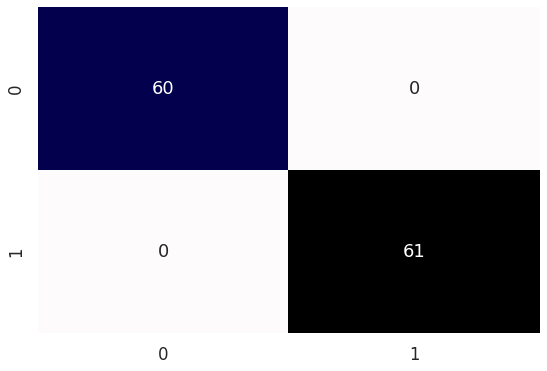

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_all_rf = my_model_population_rf_all.predict(population_data_all_batch)
heatconmat(target_batch_all,pred_batch_all_rf)
accuracy = accuracy_score(pred_batch_all_rf.astype(int), target_batch_all.astype(int))
print(accuracy)

XGBoost performance

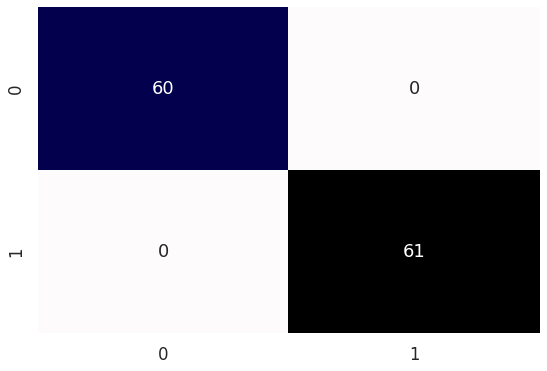

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_all_xgboost = my_model_populatin_xgboost_all.predict(population_data_all_batch)
heatconmat(target_batch_all,pred_batch_all_xgboost)
accuracy = accuracy_score(pred_batch_all_xgboost.astype(int), target_batch_all.astype(int))
print(accuracy)

SVM performace

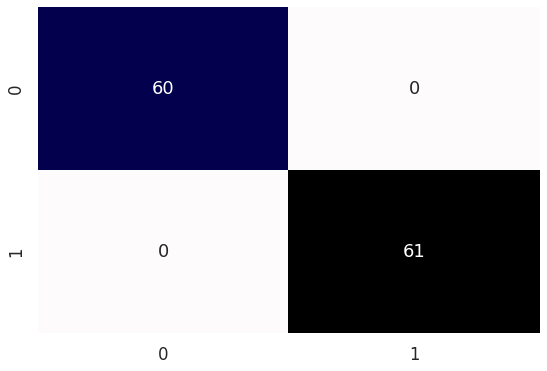

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        61

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121



In [ ]:
pred_batch_all_SVM = my_model_population_SVM_all.predict(population_data_all_batch)
heatconmat(target_batch_all,pred_batch_all_SVM)
accuracy = accuracy_score(pred_batch_all_SVM.astype(int), target_batch_all.astype(int))
print(accuracy)

#Dimention reduction -PCA

In [ ]:
# rescale the data for pca
train_data_rescaled_all = scaler.fit_transform(population_data_all)
test_data_rescaled_all = scaler.fit_transform(population_data_test_all)
batch_data_rescaled_all = scaler.fit_transform(population_data_all_batch)


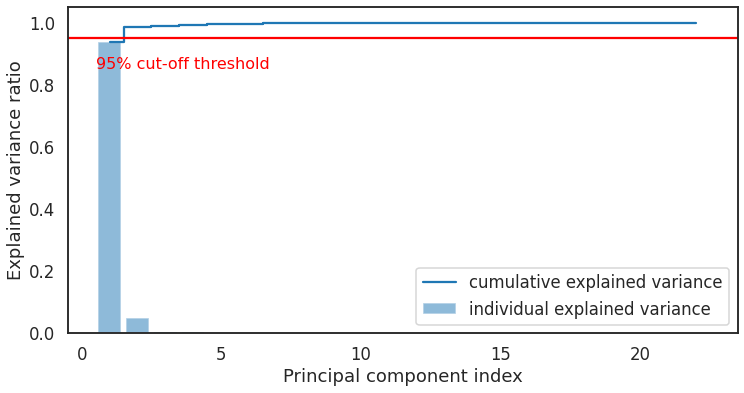

In [ ]:
# displaying the componantes and the data varience they includes for choosing the number of componnets to reduced to
cov_mat = np.cov(train_data_rescaled_all.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,23), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,23), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.legend(loc='best')
plt.show()

In [ ]:
pca_all = PCA(n_components=2) # choosing the number of dimentions

# fit and transform data
X_train_pca_all = pca_all.fit_transform(train_data_rescaled_all)
X_test_pca_all = pca_all.transform(test_data_rescaled_all)
X_batch_pca_all = pca_all.transform(batch_data_rescaled_all)


In [ ]:
# How much each original feature contribute to the components

print(pd.DataFrame(np.abs(pca_all.components_),columns=population_data_all.columns ,index = ['PC-1', 'PC-2']))

      mean_BV421_A  median_BV421_A  mean_FITC_A  median_FITC_A  mean_PerCP_A  \
PC-1      0.228163        0.192342     0.212862       0.227882      0.230172   
PC-2      0.074688        0.060276     0.058559       0.062894      0.049110   

      median_PerCP_A  mean_PE_Texas_Red_A  median_PE_Texas_Red_A  \
PC-1        0.249763             0.237113               0.099258   
PC-2        0.063557             0.032360               0.008303   

      mean_Alexa_Fluor_700_A  median_Alexa_Fluor_700_A  ...  mean_FSC_W  \
PC-1                0.218064                  0.163676  ...    0.225394   
PC-2                0.033829                  0.010700  ...    0.076085   

      mean_SSC_A  mean_SSC_H  mean_SSC_W  median_FSC_A  median_FSC_H  \
PC-1    0.276616    0.276428    0.246667      0.109382      0.075674   
PC-2    0.086350    0.094318    0.041257      0.469689      0.496966   

      median_FSC_W  median_SSC_A  median_SSC_H  median_SSC_W  
PC-1      0.226955      0.267086      0.268865  

In [ ]:
# printing the most contributing original feature for each component
most_important = np.abs(pca_all.components_).argmax(axis=1)
initial_feature_names = population_data_all.columns
most_important_names = initial_feature_names[most_important]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(2)}
pca_results = pd.DataFrame(dic.items())
print(pca_results)

     0             1
0  PC1    mean_SSC_A
1  PC2  median_FSC_H


Random forest

Hyperparameters optimization

In [ ]:
random_forest_grouped_all_pca= RandomForestClassifier(n_jobs=-1)

param_grid = {
'n_estimators': [1000],
'min_samples_leaf': [1, 5, 10],
'max_depth': [4, 6, 8, 10, 12],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV
model_gridsearch = GridSearchCV(
estimator=random_forest_grouped_all_pca,
param_grid=param_grid,
scoring='accuracy',
n_jobs=4,
cv=cv,
refit=True,
return_train_score=True)

# Fit the selected model
model_gridsearch.fit(X_train_pca_all, target_all)
print(model_gridsearch.best_params_)

running the model using best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
random_forest_grouped_all_pca = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 'auto', min_samples_leaf = 1, n_estimators = 1000, n_jobs=-1)
my_model_RF_PCA_all = random_forest_grouped_all_pca.fit(X_train_pca_all, target_all)
print ('Random Forest testing Score: {0:2.5f}'.format(my_model_RF_PCA_all.score(X_test_pca_all, target_test_all)))

In [ ]:
# evaluating the model performance on the Batch data
pred_random_forest_all_PCA_batch = my_model_RF_PCA_all.predict(X_batch_pca_all)
accuracy = accuracy_score(pred_random_forest_all_PCA_batch.astype(int), target_batch_all.astype(int))
accuracy

1.0

XGBoost

Hyperparameters optimization

In [ ]:
xgboost_classification_all_pca = XGBClassifier(n_jobs=-1)

PARAMETERS = {"subsample":[0.5, 0.75, 1],
              "colsample_bytree":[0.5, 0.75, 1],
              "max_depth":[2, 6, 12],
              "min_child_weight":[1,5,15],
              "learning_rate":[0.3, 0.1, 0.03],
              'n_estimator' : [500]}

model_gs = GridSearchCV(xgboost_classification_all_pca,param_grid=PARAMETERS,cv=cv,scoring="accuracy")
model_gs.fit(X_train_pca_all, target_all)
print(model_gs.best_params_)

running the model using best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
xgboost_classification_all_pca = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 2, min_child_weight = 1, n_estimator = 500, subsample = 0.5, n_jobs=-1)
my_model_xgboost_PCA_all = xgboost_classification_all_pca.fit(X_train_pca_all, target_all)
print('xgboost testing Score: {0:2.5f}'.format(my_model_xgboost_PCA_all.score(X_test_pca_all, target_test_all)))

In [ ]:
# evaluating the model performance on the Batch data
pred_xgboost_all_PCA_batch = my_model_xgboost_PCA_all.predict(X_batch_pca_all)
accuracy = accuracy_score(pred_xgboost_all_PCA_batch.astype(int), target_batch_all.astype(int))
accuracy

1.0

SVM

Hyperparameters optimization

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'sigmoid']}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=cv)
grid_search.fit(X_train_pca_all, target_all)
print(grid_search.best_params_)

running the model using best parameters results

In [ ]:
# training the model and evaluating its performance on the testing data
SVM_all = svm.SVC(C = 0.001, gamma = 0.001, kernel='linear')
my_model_SVM_PCA_all = SVM_all.fit(X_train_pca_all, target_all)
print('SVM testing Score: {0:2.5f}'.format(my_model_SVM_PCA_all.score(X_test_pca_all, target_test_all)))

In [ ]:
# evaluating the model performance on the Batch data
pred_SVM_all_PCA_batch = my_model_SVM_PCA_all.predict(X_batch_pca_all)
accuracy = accuracy_score(pred_SVM_all_PCA_batch.astype(int), target_batch_all.astype(int))
accuracy

1.0